### TFG MES - Cesar Hernandez Rodriguez
El estudio se hace con los datos historicos de mes a mes (21 dias), se realiza la prediccion de ciertos activos elegidos previamente, si se necesita cualquier otro activo del NASDAQ estan en los otros script ya que esto solo es una pequeña muestra representativa del funcionamiento

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice NASDAQ que es uno de los índices más importantes de Estados Unidos (índide tecnologico), siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

De este conjunto de datos solo voy a coger son $['AAPL', 'SNRC', 'ATVI', 'MINI', 'GOOG', 'BBOX']$ 

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. Al crearme una cuenta gratuita las opciones que se ofrecen no son las mias que para una cuenata premium por lo que cogere fechas pasadas y no actuales. 

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

A la hora de realizar el modelo creo 3 atributos, 2 medias moviles una de 10 dias y otra de 20 dias y un oscilador de la media movil de 20 dias.

Depues de realizar el modelo la idea de la practica es realizar una prueba real, por ello me fio del modelo que he obtenido e imaginando una inversion inical de 100000 euros dejo que la red neuronal haga lo que deba con ese dinero, decidiendo si quiere comprar, vender o mantener. Hay 3 formas programadas, compra a la alza, compra a la alza y a la baja y compra a la baja.

In [1]:
# Import predefinifods
import pandas as pd
import numpy as np
import random
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt
from collections import Counter

# Importa descaga de datos
import quandl

# Import serializar
import pickle

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import SimpleRNN #Redes Recurrentes
from keras.layers import LSTM
from keras.layers import GRU
import keras.backend as K

# Conteo
from collections import Counter

# Graficos
#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')
plt.style.use('seaborn')

In [2]:
# Descarga de las bases los tickets de los activos que vamos a predecir con los csv de la carpeta
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-listed-symbols-TFG.csv')
    
    tickersQuandl = []    
    tickers = pd.DataFrame(columns = ['Symbol','CompanyName'], index = range(len(tickers_nasdaq)))

    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq['Symbol'][i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers['Symbol'][i] = word
                tickers['CompanyName'][i] = tickers_nasdaq['CompanyName'][i]
    
    for tick in tickers['Symbol']:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

#a,b = get_tickers_sample_nasdaq()

In [3]:
# Descargo de los datos con la API Quandl y la key propia
# Las fechas estan elegidas a convinencia para poder concatenar las fechas y que quede de seguido

def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    # Las fechas elegidas son esas para poder tener una gran cantidad de datos historicos y
    # que justo se complementen con las fechas de tipo test, al hacer Medias Moviles se pierden muchos datos
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        #aux=quandl.get(ticker,start_date="2000-01-01",end_date="2016-12-31")
        aux=quandl.get(ticker,start_date="2009-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2016-11-01",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
    
    # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos_demo/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos_demo/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos_demo/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos_demo/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos_demo/nasdaq_testMes.p", "wb"))
    pickle.dump(datosClose_test, open("datos_demo/nasdaqClose_testMes.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [4]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos_demo/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos_demo/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos_demo/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos_demo/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos_demo/nasdaq_testMes.p", "rb" ))
    datosClose_test = pickle.load(open("datos_demo/nasdaqClose_testMes.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre['Symbol']].plot(figsize=(12,5),grid=True)
    plt.title('{} de la compañia {} {}\n'.format(nombre['Symbol'],nombre['CompanyName'],test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

In [5]:
datos_descargados = True
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a cargar los datos****

 ****Cargados los datos****


 ****Empezamos a cargar los datos test****

 ****Cargados los datos test****



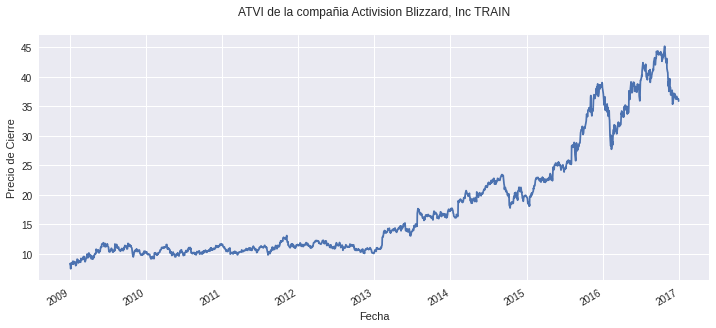

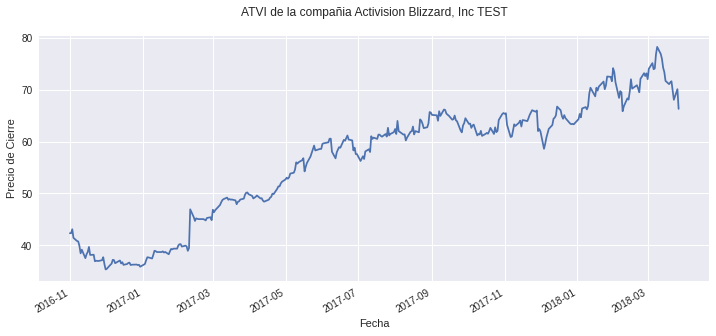

In [6]:
# Grafico un activo aleatorio 
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
ran = 3
plot_datos(datosClose,tickers.iloc[ran],"TRAIN")
plot_datos(datosClose_test,tickers.iloc[ran],"TEST")

In [8]:
# Creacion de los atributos para la Red Neuronal Recurrente
def differences(x):
    return x[-1] - x[0]

def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:len(X)-1].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    return X, indices[(days2+1):len(indices)]

# Creo tambien timestep de 30 dias (igual que la media movil) para la RED NEURONAL
def cut_timestep(x,y,time):
    
    Xt = []
    yt = []
    index_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i,0])
        index_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(index_time)

In [9]:
# A parte de la creacion de atributos
index = ran
timeStep = 21 # longitud de secuencias que se hacen en cada iteracion de la red

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers['Symbol'][index]],10,20)
Y = pd.DataFrame(datosClose[tickers['Symbol'][index]].values[21:len(datosClose[tickers['Symbol'][index]])])
X = X.to_numpy()

# Creamos los atributos para los datos test
ticket_uso = tickers['Symbol'][index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers['Symbol'][index]],10,20)
Ytesteo = pd.DataFrame(datosClose_test[tickers['Symbol'][index]].values[21:len(datosClose_test[tickers['Symbol'][index]])])
Xtesteo = Xtesteo.to_numpy()

# Junto todos los datos para poder hacer su correcta normalizacion
X_aux = np.concatenate((X,Xtesteo),axis=0)

scaler = MinMaxScaler()
X_aux_scaled = scaler.fit_transform(X_aux)
X_scaled = X_aux_scaled[0:len(X)]
Xtesteo_scaled = X_aux_scaled[len(X):len(X_aux_scaled)]

# Creacion de los timestep
Xt, yt, index_time = cut_timestep(X_scaled,Y,ind_time)
Xtt, ytt, index_time_t = cut_timestep(Xtesteo_scaled,Ytesteo,ind_time_t)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]


print("Voy a predecir el activo {} de la compañia {}".format(ticket_uso,tickers['CompanyName'][index]))

Voy a predecir el activo ATVI de la compañia Activision Blizzard, Inc


In [10]:
# Calculates a successfull ratio using less relative error than a maximum
def porcentaje_margen(y_true, y_pred):
    margen = 0.05
    yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), margen), dtype=float))
    return yy/K.cast(K.shape(y_pred)[0], dtype=float)

In [16]:
modelRNN42 = Sequential()
modelRNN42.add(SimpleRNN(input_shape=(21,3),units=4,activation='relu',return_sequences=True))
modelRNN42.add(SimpleRNN(2,activation="relu"))
modelRNN42.add(Dense(1)) 
modelRNN42.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN42.summary()
history_RNN42 = modelRNN42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 21, 4)             32        
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 2)                 14        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 403.9733 - porcentaje_margen: 0.0000e+00 - val_loss: 447.9594 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [==============================] - 1s 702us/step - loss: 402.4765 - porcentaje_margen: 0.0000e+00 - val_loss: 446.4037 - val_porcentaje_margen

Epoch 45/1500
1314/1314 [==============================] - 1s 746us/step - loss: 1.0277 - porcentaje_margen: 0.7240 - val_loss: 1.0811 - val_porcentaje_margen: 0.7235
Epoch 46/1500
1314/1314 [==============================] - 1s 679us/step - loss: 1.0019 - porcentaje_margen: 0.7202 - val_loss: 1.2243 - val_porcentaje_margen: 0.7070
Epoch 47/1500
1314/1314 [==============================] - 1s 771us/step - loss: 1.1174 - porcentaje_margen: 0.6815 - val_loss: 1.0680 - val_porcentaje_margen: 0.7295
Epoch 48/1500
1314/1314 [==============================] - 1s 678us/step - loss: 0.9332 - porcentaje_margen: 0.7240 - val_loss: 1.1134 - val_porcentaje_margen: 0.7090
Epoch 49/1500
1314/1314 [==============================] - 1s 727us/step - loss: 1.0331 - porcentaje_margen: 0.7180 - val_loss: 1.1092 - val_porcentaje_margen: 0.7275
Epoch 50/1500
1314/1314 [==============================] - 1s 662us/step - loss: 0.9894 - porcentaje_margen: 0.7307 - val_loss: 1.1834 - val_porcentaje_margen: 0.695

1314/1314 [==============================] - 1s 701us/step - loss: 0.8209 - porcentaje_margen: 0.7448 - val_loss: 0.9524 - val_porcentaje_margen: 0.7358
Epoch 95/1500
1314/1314 [==============================] - 1s 720us/step - loss: 0.8429 - porcentaje_margen: 0.7307 - val_loss: 0.9351 - val_porcentaje_margen: 0.7462
Epoch 96/1500
1314/1314 [==============================] - 1s 650us/step - loss: 0.8072 - porcentaje_margen: 0.7626 - val_loss: 0.9409 - val_porcentaje_margen: 0.7569
Epoch 97/1500
1314/1314 [==============================] - 1s 670us/step - loss: 0.8200 - porcentaje_margen: 0.7626 - val_loss: 0.9458 - val_porcentaje_margen: 0.7540
Epoch 98/1500
1314/1314 [==============================] - 1s 667us/step - loss: 0.8283 - porcentaje_margen: 0.7545 - val_loss: 0.9356 - val_porcentaje_margen: 0.7432
Epoch 99/1500
1314/1314 [==============================] - 1s 648us/step - loss: 0.8224 - porcentaje_margen: 0.7626 - val_loss: 0.9428 - val_porcentaje_margen: 0.7555
Epoch 100/15

Epoch 143/1500
1314/1314 [==============================] - 1s 666us/step - loss: 0.7586 - porcentaje_margen: 0.7545 - val_loss: 0.9693 - val_porcentaje_margen: 0.7328
Epoch 144/1500
1314/1314 [==============================] - 1s 650us/step - loss: 0.7754 - porcentaje_margen: 0.7679 - val_loss: 0.8973 - val_porcentaje_margen: 0.7447
Epoch 145/1500
1314/1314 [==============================] - 1s 738us/step - loss: 0.7919 - porcentaje_margen: 0.7664 - val_loss: 1.0205 - val_porcentaje_margen: 0.7483
Epoch 146/1500
1314/1314 [==============================] - 1s 707us/step - loss: 0.7646 - porcentaje_margen: 0.7671 - val_loss: 0.9249 - val_porcentaje_margen: 0.7614
Epoch 147/1500
1314/1314 [==============================] - 1s 691us/step - loss: 0.7800 - porcentaje_margen: 0.7626 - val_loss: 0.8935 - val_porcentaje_margen: 0.7596
Epoch 148/1500
1314/1314 [==============================] - 1s 678us/step - loss: 0.7878 - porcentaje_margen: 0.7552 - val_loss: 1.0208 - val_porcentaje_margen:

Epoch 192/1500
1314/1314 [==============================] - 1s 660us/step - loss: 0.7462 - porcentaje_margen: 0.7567 - val_loss: 0.8712 - val_porcentaje_margen: 0.7581
Epoch 193/1500
1314/1314 [==============================] - 1s 664us/step - loss: 0.7538 - porcentaje_margen: 0.7641 - val_loss: 0.9216 - val_porcentaje_margen: 0.7659
Epoch 194/1500
1314/1314 [==============================] - 1s 632us/step - loss: 0.7429 - porcentaje_margen: 0.7783 - val_loss: 0.8582 - val_porcentaje_margen: 0.7611
Epoch 195/1500
1314/1314 [==============================] - 1s 675us/step - loss: 0.7307 - porcentaje_margen: 0.7716 - val_loss: 0.9685 - val_porcentaje_margen: 0.7224
Epoch 196/1500
1314/1314 [==============================] - 1s 673us/step - loss: 0.7518 - porcentaje_margen: 0.7656 - val_loss: 0.9038 - val_porcentaje_margen: 0.7659
Epoch 197/1500
1314/1314 [==============================] - 1s 643us/step - loss: 0.7252 - porcentaje_margen: 0.7671 - val_loss: 0.9505 - val_porcentaje_margen:

Epoch 241/1500
1314/1314 [==============================] - 1s 691us/step - loss: 0.7331 - porcentaje_margen: 0.7656 - val_loss: 0.8433 - val_porcentaje_margen: 0.7819
Epoch 242/1500
1314/1314 [==============================] - 1s 678us/step - loss: 0.6969 - porcentaje_margen: 0.7619 - val_loss: 1.1836 - val_porcentaje_margen: 0.6984
Epoch 243/1500
1314/1314 [==============================] - 1s 632us/step - loss: 0.9697 - porcentaje_margen: 0.6942 - val_loss: 0.8614 - val_porcentaje_margen: 0.7730
Epoch 244/1500
1314/1314 [==============================] - 1s 600us/step - loss: 0.7143 - porcentaje_margen: 0.7820 - val_loss: 0.8286 - val_porcentaje_margen: 0.7730
Epoch 245/1500
1314/1314 [==============================] - 1s 645us/step - loss: 0.7147 - porcentaje_margen: 0.7790 - val_loss: 0.8981 - val_porcentaje_margen: 0.7688
Epoch 246/1500
1314/1314 [==============================] - 1s 654us/step - loss: 0.7281 - porcentaje_margen: 0.7686 - val_loss: 0.9144 - val_porcentaje_margen:

Epoch 290/1500
1314/1314 [==============================] - 1s 678us/step - loss: 0.6929 - porcentaje_margen: 0.7827 - val_loss: 0.8266 - val_porcentaje_margen: 0.7745
Epoch 291/1500
1314/1314 [==============================] - 1s 654us/step - loss: 0.7709 - porcentaje_margen: 0.7619 - val_loss: 0.8892 - val_porcentaje_margen: 0.7518
Epoch 292/1500
1314/1314 [==============================] - 1s 753us/step - loss: 0.7002 - porcentaje_margen: 0.7909 - val_loss: 0.8041 - val_porcentaje_margen: 0.7864
Epoch 293/1500
1314/1314 [==============================] - 1s 685us/step - loss: 0.6764 - porcentaje_margen: 0.7924 - val_loss: 0.8023 - val_porcentaje_margen: 0.7789
Epoch 294/1500
1314/1314 [==============================] - 1s 690us/step - loss: 0.6957 - porcentaje_margen: 0.7917 - val_loss: 0.8035 - val_porcentaje_margen: 0.7879
Epoch 295/1500
1314/1314 [==============================] - 1s 689us/step - loss: 0.7107 - porcentaje_margen: 0.7857 - val_loss: 0.8385 - val_porcentaje_margen:

Epoch 339/1500
1314/1314 [==============================] - 1s 675us/step - loss: 0.6575 - porcentaje_margen: 0.7932 - val_loss: 0.8091 - val_porcentaje_margen: 0.7774
Epoch 340/1500
1314/1314 [==============================] - 1s 713us/step - loss: 0.6703 - porcentaje_margen: 0.7887 - val_loss: 0.8330 - val_porcentaje_margen: 0.7727
Epoch 341/1500
1314/1314 [==============================] - 1s 686us/step - loss: 0.6701 - porcentaje_margen: 0.7827 - val_loss: 0.8300 - val_porcentaje_margen: 0.7789
Epoch 342/1500
1314/1314 [==============================] - 1s 637us/step - loss: 0.6602 - porcentaje_margen: 0.8051 - val_loss: 0.7836 - val_porcentaje_margen: 0.7938
Epoch 343/1500
1314/1314 [==============================] - 1s 681us/step - loss: 0.6669 - porcentaje_margen: 0.7932 - val_loss: 0.7799 - val_porcentaje_margen: 0.7879
Epoch 344/1500
1314/1314 [==============================] - 1s 666us/step - loss: 0.6668 - porcentaje_margen: 0.7894 - val_loss: 0.8194 - val_porcentaje_margen:

Epoch 388/1500
1314/1314 [==============================] - 1s 683us/step - loss: 0.6573 - porcentaje_margen: 0.7805 - val_loss: 0.8426 - val_porcentaje_margen: 0.7808
Epoch 389/1500
1314/1314 [==============================] - 1s 687us/step - loss: 0.7566 - porcentaje_margen: 0.7649 - val_loss: 0.7608 - val_porcentaje_margen: 0.7968
Epoch 390/1500
1314/1314 [==============================] - 1s 674us/step - loss: 0.6398 - porcentaje_margen: 0.8073 - val_loss: 0.7607 - val_porcentaje_margen: 0.7938
Epoch 391/1500
1314/1314 [==============================] - 1s 685us/step - loss: 0.6405 - porcentaje_margen: 0.8058 - val_loss: 0.7600 - val_porcentaje_margen: 0.7938
Epoch 392/1500
1314/1314 [==============================] - 1s 671us/step - loss: 0.6314 - porcentaje_margen: 0.7976 - val_loss: 0.7978 - val_porcentaje_margen: 0.7834
Epoch 393/1500
1314/1314 [==============================] - 1s 677us/step - loss: 0.6465 - porcentaje_margen: 0.7976 - val_loss: 0.8396 - val_porcentaje_margen:

Epoch 437/1500
1314/1314 [==============================] - 1s 638us/step - loss: 0.6256 - porcentaje_margen: 0.8058 - val_loss: 0.7554 - val_porcentaje_margen: 0.7968
Epoch 438/1500
1314/1314 [==============================] - 1s 644us/step - loss: 0.6209 - porcentaje_margen: 0.8051 - val_loss: 0.8761 - val_porcentaje_margen: 0.7518
Epoch 439/1500
1314/1314 [==============================] - 1s 655us/step - loss: 0.6397 - porcentaje_margen: 0.8021 - val_loss: 0.7492 - val_porcentaje_margen: 0.7983
Epoch 440/1500
1314/1314 [==============================] - 1s 671us/step - loss: 0.6147 - porcentaje_margen: 0.7902 - val_loss: 0.7490 - val_porcentaje_margen: 0.7908
Epoch 441/1500
1314/1314 [==============================] - 1s 644us/step - loss: 0.6270 - porcentaje_margen: 0.8080 - val_loss: 0.7661 - val_porcentaje_margen: 0.7923
Epoch 442/1500
1314/1314 [==============================] - 1s 697us/step - loss: 0.6169 - porcentaje_margen: 0.8125 - val_loss: 0.7771 - val_porcentaje_margen:

Epoch 486/1500
1314/1314 [==============================] - 1s 678us/step - loss: 0.6283 - porcentaje_margen: 0.7932 - val_loss: 0.7264 - val_porcentaje_margen: 0.7998
Epoch 487/1500
1314/1314 [==============================] - 1s 641us/step - loss: 0.6099 - porcentaje_margen: 0.7961 - val_loss: 0.7203 - val_porcentaje_margen: 0.8042
Epoch 488/1500
1314/1314 [==============================] - 1s 683us/step - loss: 0.6109 - porcentaje_margen: 0.8162 - val_loss: 0.7643 - val_porcentaje_margen: 0.8013
Epoch 489/1500
1314/1314 [==============================] - 1s 686us/step - loss: 0.6075 - porcentaje_margen: 0.8073 - val_loss: 0.7251 - val_porcentaje_margen: 0.7998
Epoch 490/1500
1314/1314 [==============================] - 1s 706us/step - loss: 0.6000 - porcentaje_margen: 0.8207 - val_loss: 0.7306 - val_porcentaje_margen: 0.7983
Epoch 491/1500
1314/1314 [==============================] - 1s 664us/step - loss: 0.6832 - porcentaje_margen: 0.7827 - val_loss: 0.7532 - val_porcentaje_margen:

Epoch 535/1500
1314/1314 [==============================] - 1s 647us/step - loss: 0.6089 - porcentaje_margen: 0.8259 - val_loss: 0.8099 - val_porcentaje_margen: 0.7882
Epoch 536/1500
1314/1314 [==============================] - 1s 658us/step - loss: 0.5963 - porcentaje_margen: 0.8080 - val_loss: 0.7035 - val_porcentaje_margen: 0.8057
Epoch 537/1500
1314/1314 [==============================] - 1s 701us/step - loss: 0.5971 - porcentaje_margen: 0.8192 - val_loss: 0.7049 - val_porcentaje_margen: 0.8057
Epoch 538/1500
1314/1314 [==============================] - 1s 645us/step - loss: 0.5796 - porcentaje_margen: 0.8274 - val_loss: 0.7237 - val_porcentaje_margen: 0.7998
Epoch 539/1500
1314/1314 [==============================] - 1s 655us/step - loss: 0.5953 - porcentaje_margen: 0.8140 - val_loss: 0.8448 - val_porcentaje_margen: 0.7518
Epoch 540/1500
1314/1314 [==============================] - 1s 664us/step - loss: 0.6182 - porcentaje_margen: 0.8155 - val_loss: 0.7122 - val_porcentaje_margen:

Epoch 584/1500
1314/1314 [==============================] - 1s 622us/step - loss: 0.5768 - porcentaje_margen: 0.8229 - val_loss: 0.6900 - val_porcentaje_margen: 0.8072
Epoch 585/1500
1314/1314 [==============================] - 1s 646us/step - loss: 0.5613 - porcentaje_margen: 0.8043 - val_loss: 0.8350 - val_porcentaje_margen: 0.7563
Epoch 586/1500
1314/1314 [==============================] - 1s 655us/step - loss: 0.5824 - porcentaje_margen: 0.8289 - val_loss: 0.7057 - val_porcentaje_margen: 0.8099
Epoch 587/1500
1314/1314 [==============================] - 1s 625us/step - loss: 0.5875 - porcentaje_margen: 0.8281 - val_loss: 0.6839 - val_porcentaje_margen: 0.8102
Epoch 588/1500
1314/1314 [==============================] - 1s 649us/step - loss: 0.5615 - porcentaje_margen: 0.8237 - val_loss: 0.7155 - val_porcentaje_margen: 0.8084
Epoch 589/1500
1314/1314 [==============================] - 1s 591us/step - loss: 0.5845 - porcentaje_margen: 0.8080 - val_loss: 0.7514 - val_porcentaje_margen:

Epoch 633/1500
1314/1314 [==============================] - 1s 666us/step - loss: 0.5581 - porcentaje_margen: 0.8341 - val_loss: 0.6690 - val_porcentaje_margen: 0.8146
Epoch 634/1500
1314/1314 [==============================] - 1s 647us/step - loss: 0.5464 - porcentaje_margen: 0.8371 - val_loss: 0.7182 - val_porcentaje_margen: 0.8072
Epoch 635/1500
1314/1314 [==============================] - 1s 628us/step - loss: 0.5586 - porcentaje_margen: 0.8289 - val_loss: 0.7031 - val_porcentaje_margen: 0.8128
Epoch 636/1500
1314/1314 [==============================] - 1s 653us/step - loss: 0.5657 - porcentaje_margen: 0.8348 - val_loss: 0.6932 - val_porcentaje_margen: 0.8158
Epoch 637/1500
1314/1314 [==============================] - 1s 688us/step - loss: 0.5942 - porcentaje_margen: 0.8021 - val_loss: 0.6699 - val_porcentaje_margen: 0.8161
Epoch 638/1500
1314/1314 [==============================] - 1s 667us/step - loss: 0.5799 - porcentaje_margen: 0.8274 - val_loss: 0.7368 - val_porcentaje_margen:

Epoch 682/1500
1314/1314 [==============================] - 1s 650us/step - loss: 0.5368 - porcentaje_margen: 0.8289 - val_loss: 0.7182 - val_porcentaje_margen: 0.8061
Epoch 683/1500
1314/1314 [==============================] - 1s 636us/step - loss: 0.5428 - porcentaje_margen: 0.8281 - val_loss: 0.6601 - val_porcentaje_margen: 0.8232
Epoch 684/1500
1314/1314 [==============================] - 1s 691us/step - loss: 0.5475 - porcentaje_margen: 0.8445 - val_loss: 0.6592 - val_porcentaje_margen: 0.8262
Epoch 685/1500
1314/1314 [==============================] - 1s 643us/step - loss: 0.5353 - porcentaje_margen: 0.8415 - val_loss: 0.6708 - val_porcentaje_margen: 0.8203
Epoch 686/1500
1314/1314 [==============================] - 1s 643us/step - loss: 0.5387 - porcentaje_margen: 0.8356 - val_loss: 0.6562 - val_porcentaje_margen: 0.8176
Epoch 687/1500
1314/1314 [==============================] - 1s 628us/step - loss: 0.5430 - porcentaje_margen: 0.8430 - val_loss: 0.6812 - val_porcentaje_margen:

Epoch 731/1500
1314/1314 [==============================] - 1s 649us/step - loss: 0.5574 - porcentaje_margen: 0.8348 - val_loss: 0.6623 - val_porcentaje_margen: 0.8218
Epoch 732/1500
1314/1314 [==============================] - 1s 648us/step - loss: 0.5252 - porcentaje_margen: 0.8430 - val_loss: 0.6437 - val_porcentaje_margen: 0.8292
Epoch 733/1500
1314/1314 [==============================] - 1s 662us/step - loss: 0.5218 - porcentaje_margen: 0.8467 - val_loss: 0.6908 - val_porcentaje_margen: 0.8176
Epoch 734/1500
1314/1314 [==============================] - 1s 651us/step - loss: 0.5284 - porcentaje_margen: 0.8497 - val_loss: 0.6380 - val_porcentaje_margen: 0.8236
Epoch 735/1500
1314/1314 [==============================] - 1s 648us/step - loss: 0.5221 - porcentaje_margen: 0.8341 - val_loss: 0.6456 - val_porcentaje_margen: 0.8236
Epoch 736/1500
1314/1314 [==============================] - 1s 679us/step - loss: 0.5380 - porcentaje_margen: 0.8229 - val_loss: 0.6366 - val_porcentaje_margen:

Epoch 780/1500
1314/1314 [==============================] - 1s 685us/step - loss: 0.5451 - porcentaje_margen: 0.8333 - val_loss: 0.6230 - val_porcentaje_margen: 0.8280
Epoch 781/1500
1314/1314 [==============================] - 1s 656us/step - loss: 0.5347 - porcentaje_margen: 0.8519 - val_loss: 0.6477 - val_porcentaje_margen: 0.8307
Epoch 782/1500
1314/1314 [==============================] - 1s 654us/step - loss: 0.5187 - porcentaje_margen: 0.8415 - val_loss: 0.6237 - val_porcentaje_margen: 0.8277
Epoch 783/1500
1314/1314 [==============================] - 1s 619us/step - loss: 0.5098 - porcentaje_margen: 0.8423 - val_loss: 0.6740 - val_porcentaje_margen: 0.8236
Epoch 784/1500
1314/1314 [==============================] - 1s 648us/step - loss: 0.5329 - porcentaje_margen: 0.8475 - val_loss: 0.6516 - val_porcentaje_margen: 0.8218
Epoch 785/1500
1314/1314 [==============================] - 1s 675us/step - loss: 0.5213 - porcentaje_margen: 0.8504 - val_loss: 0.6244 - val_porcentaje_margen:

Epoch 829/1500
1314/1314 [==============================] - 1s 630us/step - loss: 0.5041 - porcentaje_margen: 0.8400 - val_loss: 0.6856 - val_porcentaje_margen: 0.8128
Epoch 830/1500
1314/1314 [==============================] - 1s 683us/step - loss: 0.5495 - porcentaje_margen: 0.8289 - val_loss: 0.6115 - val_porcentaje_margen: 0.8322
Epoch 831/1500
1314/1314 [==============================] - 1s 658us/step - loss: 0.5245 - porcentaje_margen: 0.8475 - val_loss: 0.6518 - val_porcentaje_margen: 0.8251
Epoch 832/1500
1314/1314 [==============================] - 1s 682us/step - loss: 0.5058 - porcentaje_margen: 0.8564 - val_loss: 0.6788 - val_porcentaje_margen: 0.8113
Epoch 833/1500
1314/1314 [==============================] - 1s 705us/step - loss: 0.5407 - porcentaje_margen: 0.8408 - val_loss: 0.6169 - val_porcentaje_margen: 0.8307
Epoch 834/1500
1314/1314 [==============================] - 1s 630us/step - loss: 0.5034 - porcentaje_margen: 0.8534 - val_loss: 0.6374 - val_porcentaje_margen:

Epoch 926/1500
1314/1314 [==============================] - 1s 636us/step - loss: 0.4950 - porcentaje_margen: 0.8527 - val_loss: 0.5893 - val_porcentaje_margen: 0.8366
Epoch 927/1500
1314/1314 [==============================] - 1s 659us/step - loss: 0.4774 - porcentaje_margen: 0.8653 - val_loss: 0.6379 - val_porcentaje_margen: 0.8358
Epoch 928/1500
1314/1314 [==============================] - 1s 650us/step - loss: 0.4993 - porcentaje_margen: 0.8594 - val_loss: 0.6096 - val_porcentaje_margen: 0.8471
Epoch 929/1500
1314/1314 [==============================] - 1s 606us/step - loss: 0.5107 - porcentaje_margen: 0.8564 - val_loss: 0.5954 - val_porcentaje_margen: 0.8411
Epoch 930/1500
1314/1314 [==============================] - 1s 651us/step - loss: 0.4832 - porcentaje_margen: 0.8467 - val_loss: 0.5858 - val_porcentaje_margen: 0.8393
Epoch 931/1500
1314/1314 [==============================] - 1s 688us/step - loss: 0.4774 - porcentaje_margen: 0.8713 - val_loss: 0.5831 - val_porcentaje_margen:

Epoch 975/1500
1314/1314 [==============================] - 1s 660us/step - loss: 0.5069 - porcentaje_margen: 0.8534 - val_loss: 0.6457 - val_porcentaje_margen: 0.8188
Epoch 976/1500
1314/1314 [==============================] - 1s 597us/step - loss: 0.5077 - porcentaje_margen: 0.8371 - val_loss: 0.5761 - val_porcentaje_margen: 0.8456
Epoch 977/1500
1314/1314 [==============================] - 1s 609us/step - loss: 0.4680 - porcentaje_margen: 0.8661 - val_loss: 0.5727 - val_porcentaje_margen: 0.8512
Epoch 978/1500
1314/1314 [==============================] - 1s 609us/step - loss: 0.4728 - porcentaje_margen: 0.8668 - val_loss: 0.5789 - val_porcentaje_margen: 0.8456
Epoch 979/1500
1314/1314 [==============================] - 1s 624us/step - loss: 0.4672 - porcentaje_margen: 0.8683 - val_loss: 0.5797 - val_porcentaje_margen: 0.8452
Epoch 980/1500
1314/1314 [==============================] - 1s 622us/step - loss: 0.4714 - porcentaje_margen: 0.8616 - val_loss: 0.5718 - val_porcentaje_margen:

1314/1314 [==============================] - 1s 601us/step - loss: 0.4714 - porcentaje_margen: 0.8683 - val_loss: 0.5542 - val_porcentaje_margen: 0.8527
Epoch 1072/1500
1314/1314 [==============================] - 1s 715us/step - loss: 0.4537 - porcentaje_margen: 0.8579 - val_loss: 0.5649 - val_porcentaje_margen: 0.8586
Epoch 1073/1500
1314/1314 [==============================] - 1s 689us/step - loss: 0.4557 - porcentaje_margen: 0.8743 - val_loss: 0.5795 - val_porcentaje_margen: 0.8604
Epoch 1074/1500
1314/1314 [==============================] - 1s 675us/step - loss: 0.4643 - porcentaje_margen: 0.8683 - val_loss: 0.5642 - val_porcentaje_margen: 0.8586
Epoch 1075/1500
1314/1314 [==============================] - 1s 684us/step - loss: 0.4685 - porcentaje_margen: 0.8757 - val_loss: 0.5566 - val_porcentaje_margen: 0.8586
Epoch 1076/1500
1314/1314 [==============================] - 1s 700us/step - loss: 0.4563 - porcentaje_margen: 0.8579 - val_loss: 0.5541 - val_porcentaje_margen: 0.8467
Ep

1314/1314 [==============================] - 1s 608us/step - loss: 0.4430 - porcentaje_margen: 0.8832 - val_loss: 0.5638 - val_porcentaje_margen: 0.8676
Epoch 1168/1500
1314/1314 [==============================] - 1s 608us/step - loss: 0.4475 - porcentaje_margen: 0.8631 - val_loss: 0.5864 - val_porcentaje_margen: 0.8634
Epoch 1169/1500
1314/1314 [==============================] - 1s 592us/step - loss: 0.4522 - porcentaje_margen: 0.8728 - val_loss: 0.5491 - val_porcentaje_margen: 0.8497
Epoch 1170/1500
1314/1314 [==============================] - 1s 621us/step - loss: 0.4502 - porcentaje_margen: 0.8750 - val_loss: 0.5440 - val_porcentaje_margen: 0.8542
Epoch 1171/1500
1314/1314 [==============================] - 1s 586us/step - loss: 0.4520 - porcentaje_margen: 0.8780 - val_loss: 0.5457 - val_porcentaje_margen: 0.8661
Epoch 1172/1500
1314/1314 [==============================] - 1s 620us/step - loss: 0.4396 - porcentaje_margen: 0.8661 - val_loss: 0.6108 - val_porcentaje_margen: 0.8581
Ep

1314/1314 [==============================] - 1s 563us/step - loss: 0.4920 - porcentaje_margen: 0.8497 - val_loss: 0.6472 - val_porcentaje_margen: 0.8462
Epoch 1264/1500
1314/1314 [==============================] - 1s 546us/step - loss: 0.4425 - porcentaje_margen: 0.8542 - val_loss: 0.5335 - val_porcentaje_margen: 0.8720
Epoch 1265/1500
1314/1314 [==============================] - 1s 589us/step - loss: 0.4703 - porcentaje_margen: 0.8579 - val_loss: 0.5587 - val_porcentaje_margen: 0.8735
Epoch 1266/1500
1314/1314 [==============================] - 1s 570us/step - loss: 0.4318 - porcentaje_margen: 0.8668 - val_loss: 0.5461 - val_porcentaje_margen: 0.8780
Epoch 1267/1500
1314/1314 [==============================] - 1s 568us/step - loss: 0.4488 - porcentaje_margen: 0.8698 - val_loss: 0.5324 - val_porcentaje_margen: 0.8586
Epoch 1268/1500
1314/1314 [==============================] - 1s 567us/step - loss: 0.4747 - porcentaje_margen: 0.8504 - val_loss: 0.5323 - val_porcentaje_margen: 0.8735
Ep

1314/1314 [==============================] - 1s 574us/step - loss: 0.4531 - porcentaje_margen: 0.8743 - val_loss: 0.5339 - val_porcentaje_margen: 0.8780
Epoch 1360/1500
1314/1314 [==============================] - 1s 561us/step - loss: 0.4155 - porcentaje_margen: 0.8750 - val_loss: 0.5383 - val_porcentaje_margen: 0.8795
Epoch 1361/1500
1314/1314 [==============================] - 1s 561us/step - loss: 0.4301 - porcentaje_margen: 0.8690 - val_loss: 0.5233 - val_porcentaje_margen: 0.8690
Epoch 1362/1500
1314/1314 [==============================] - 1s 562us/step - loss: 0.4349 - porcentaje_margen: 0.8802 - val_loss: 0.5672 - val_porcentaje_margen: 0.8753
Epoch 1363/1500
1314/1314 [==============================] - 1s 563us/step - loss: 0.4511 - porcentaje_margen: 0.8772 - val_loss: 0.5744 - val_porcentaje_margen: 0.8667
Epoch 1364/1500
1314/1314 [==============================] - 1s 544us/step - loss: 0.4330 - porcentaje_margen: 0.8847 - val_loss: 0.5487 - val_porcentaje_margen: 0.8765
Ep

1314/1314 [==============================] - 1s 542us/step - loss: 0.4176 - porcentaje_margen: 0.8854 - val_loss: 0.5281 - val_porcentaje_margen: 0.8810
Epoch 1456/1500
1314/1314 [==============================] - 1s 566us/step - loss: 0.4251 - porcentaje_margen: 0.8624 - val_loss: 0.5188 - val_porcentaje_margen: 0.8705
Epoch 1457/1500
1314/1314 [==============================] - 1s 575us/step - loss: 0.4207 - porcentaje_margen: 0.8876 - val_loss: 0.5481 - val_porcentaje_margen: 0.8828
Epoch 1458/1500
1314/1314 [==============================] - 1s 488us/step - loss: 0.4264 - porcentaje_margen: 0.8832 - val_loss: 0.5351 - val_porcentaje_margen: 0.8839
Epoch 1459/1500
1314/1314 [==============================] - 1s 557us/step - loss: 0.4183 - porcentaje_margen: 0.8743 - val_loss: 0.5203 - val_porcentaje_margen: 0.8795
Epoch 1460/1500
1314/1314 [==============================] - 1s 560us/step - loss: 0.4213 - porcentaje_margen: 0.8772 - val_loss: 0.5476 - val_porcentaje_margen: 0.8843
Ep

In [17]:
modelRNN84 = Sequential()
modelRNN84.add(SimpleRNN(input_shape=(21,3),units=8,activation='relu',return_sequences=True))
modelRNN84.add(SimpleRNN(4,activation="relu"))
modelRNN84.add(Dense(1)) 
modelRNN84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN84.summary()
history_RNN84 = modelRNN84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 21, 8)             96        
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 4)                 52        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 1s 18ms/step - loss: 446.0948 - porcentaje_margen: 0.0000e+00 - val_loss: 418.2764 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 13ms/step - loss: 421.8938 - porcentaje_margen: 0.0000e+00 - val_loss: 405.3725 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [====================

42/42 [==============================] - 0s 12ms/step - loss: 0.8949 - porcentaje_margen: 0.7292 - val_loss: 0.9213 - val_porcentaje_margen: 0.6749
Epoch 47/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.8551 - porcentaje_margen: 0.7597 - val_loss: 0.7135 - val_porcentaje_margen: 0.7814
Epoch 48/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.8037 - porcentaje_margen: 0.7634 - val_loss: 0.8132 - val_porcentaje_margen: 0.7591
Epoch 49/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.8668 - porcentaje_margen: 0.7277 - val_loss: 0.7192 - val_porcentaje_margen: 0.7832
Epoch 50/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.8285 - porcentaje_margen: 0.7612 - val_loss: 0.7063 - val_porcentaje_margen: 0.7907
Epoch 51/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.8191 - porcentaje_margen: 0.7515 - val_loss: 0.7046 - val_porcentaje_margen: 0.7859
Epoch 52/1500
42/42 [=====================

Epoch 97/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.6886 - porcentaje_margen: 0.8147 - val_loss: 0.6968 - val_porcentaje_margen: 0.7761
Epoch 98/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.7204 - porcentaje_margen: 0.8095 - val_loss: 0.6412 - val_porcentaje_margen: 0.8156
Epoch 99/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.7452 - porcentaje_margen: 0.7909 - val_loss: 0.6208 - val_porcentaje_margen: 0.8064
Epoch 100/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.7754 - porcentaje_margen: 0.7679 - val_loss: 0.6206 - val_porcentaje_margen: 0.8079
Epoch 101/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.7247 - porcentaje_margen: 0.8065 - val_loss: 0.6480 - val_porcentaje_margen: 0.8120
Epoch 102/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.7056 - porcentaje_margen: 0.8095 - val_loss: 0.6349 - val_porcentaje_margen: 0.8216
Epoch 103/1500
42/42 [===

42/42 [==============================] - 0s 12ms/step - loss: 0.6485 - porcentaje_margen: 0.8021 - val_loss: 0.5426 - val_porcentaje_margen: 0.8221
Epoch 148/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.6110 - porcentaje_margen: 0.8162 - val_loss: 0.5866 - val_porcentaje_margen: 0.8406
Epoch 149/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.6223 - porcentaje_margen: 0.8155 - val_loss: 0.5288 - val_porcentaje_margen: 0.8269
Epoch 150/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.5880 - porcentaje_margen: 0.8475 - val_loss: 0.9031 - val_porcentaje_margen: 0.6772
Epoch 151/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.6334 - porcentaje_margen: 0.8214 - val_loss: 0.5223 - val_porcentaje_margen: 0.8545
Epoch 152/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.6701 - porcentaje_margen: 0.8080 - val_loss: 0.7915 - val_porcentaje_margen: 0.7591
Epoch 153/1500
42/42 [===============

42/42 [==============================] - 0s 12ms/step - loss: 0.5784 - porcentaje_margen: 0.8229 - val_loss: 0.4956 - val_porcentaje_margen: 0.8545
Epoch 198/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.6011 - porcentaje_margen: 0.8192 - val_loss: 0.4791 - val_porcentaje_margen: 0.8522
Epoch 199/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.5506 - porcentaje_margen: 0.8311 - val_loss: 0.5150 - val_porcentaje_margen: 0.8456
Epoch 200/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.5647 - porcentaje_margen: 0.8497 - val_loss: 0.4739 - val_porcentaje_margen: 0.8641
Epoch 201/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.5368 - porcentaje_margen: 0.8452 - val_loss: 0.4830 - val_porcentaje_margen: 0.8623
Epoch 202/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.5788 - porcentaje_margen: 0.8185 - val_loss: 0.4812 - val_porcentaje_margen: 0.8715
Epoch 203/1500
42/42 [===============

42/42 [==============================] - 1s 12ms/step - loss: 0.5795 - porcentaje_margen: 0.8348 - val_loss: 0.4949 - val_porcentaje_margen: 0.8543
Epoch 248/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.5572 - porcentaje_margen: 0.8378 - val_loss: 0.4696 - val_porcentaje_margen: 0.8611
Epoch 249/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.6742 - porcentaje_margen: 0.7746 - val_loss: 0.5194 - val_porcentaje_margen: 0.8515
Epoch 250/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.5558 - porcentaje_margen: 0.8192 - val_loss: 0.5236 - val_porcentaje_margen: 0.8016
Epoch 251/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.5809 - porcentaje_margen: 0.8460 - val_loss: 0.5035 - val_porcentaje_margen: 0.8295
Epoch 252/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.5386 - porcentaje_margen: 0.8460 - val_loss: 0.4730 - val_porcentaje_margen: 0.8462
Epoch 253/1500
42/42 [===============

42/42 [==============================] - 1s 13ms/step - loss: 0.5410 - porcentaje_margen: 0.8534 - val_loss: 0.5768 - val_porcentaje_margen: 0.8528
Epoch 298/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.5343 - porcentaje_margen: 0.8467 - val_loss: 0.6972 - val_porcentaje_margen: 0.8294
Epoch 299/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.5482 - porcentaje_margen: 0.8423 - val_loss: 0.5202 - val_porcentaje_margen: 0.8180
Epoch 300/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.5247 - porcentaje_margen: 0.8586 - val_loss: 0.4480 - val_porcentaje_margen: 0.8790
Epoch 301/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.5311 - porcentaje_margen: 0.8512 - val_loss: 0.6162 - val_porcentaje_margen: 0.8074
Epoch 302/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.5324 - porcentaje_margen: 0.8363 - val_loss: 0.5803 - val_porcentaje_margen: 0.8368
Epoch 303/1500
42/42 [===============

42/42 [==============================] - 1s 12ms/step - loss: 0.5749 - porcentaje_margen: 0.8371 - val_loss: 0.4431 - val_porcentaje_margen: 0.8760
Epoch 348/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.5419 - porcentaje_margen: 0.8504 - val_loss: 0.4485 - val_porcentaje_margen: 0.8719
Epoch 349/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.5601 - porcentaje_margen: 0.8497 - val_loss: 0.4920 - val_porcentaje_margen: 0.8403
Epoch 350/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.5974 - porcentaje_margen: 0.8333 - val_loss: 0.6419 - val_porcentaje_margen: 0.7632
Epoch 351/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.5973 - porcentaje_margen: 0.8118 - val_loss: 0.4554 - val_porcentaje_margen: 0.8626
Epoch 352/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.5539 - porcentaje_margen: 0.8490 - val_loss: 0.4553 - val_porcentaje_margen: 0.8730
Epoch 353/1500
42/42 [===============

42/42 [==============================] - 1s 16ms/step - loss: 0.5067 - porcentaje_margen: 0.8609 - val_loss: 0.4333 - val_porcentaje_margen: 0.8775
Epoch 398/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.5050 - porcentaje_margen: 0.8646 - val_loss: 0.6719 - val_porcentaje_margen: 0.7763
Epoch 399/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.6193 - porcentaje_margen: 0.8073 - val_loss: 0.4323 - val_porcentaje_margen: 0.8834
Epoch 400/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.5103 - porcentaje_margen: 0.8646 - val_loss: 0.5677 - val_porcentaje_margen: 0.8413
Epoch 401/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.5333 - porcentaje_margen: 0.8415 - val_loss: 0.4497 - val_porcentaje_margen: 0.8763
Epoch 402/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.5037 - porcentaje_margen: 0.8490 - val_loss: 0.4443 - val_porcentaje_margen: 0.8745
Epoch 403/1500
42/42 [===============

42/42 [==============================] - 0s 11ms/step - loss: 0.4980 - porcentaje_margen: 0.8579 - val_loss: 0.4853 - val_porcentaje_margen: 0.8403
Epoch 448/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.6252 - porcentaje_margen: 0.7976 - val_loss: 0.8969 - val_porcentaje_margen: 0.7583
Epoch 449/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.9540 - porcentaje_margen: 0.6964 - val_loss: 0.5407 - val_porcentaje_margen: 0.8442
Epoch 450/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.5583 - porcentaje_margen: 0.8400 - val_loss: 0.4850 - val_porcentaje_margen: 0.8689
Epoch 451/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.4892 - porcentaje_margen: 0.8735 - val_loss: 0.4809 - val_porcentaje_margen: 0.8644
Epoch 452/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.5181 - porcentaje_margen: 0.8609 - val_loss: 0.5407 - val_porcentaje_margen: 0.8514
Epoch 453/1500
42/42 [===============

42/42 [==============================] - 0s 11ms/step - loss: 0.5159 - porcentaje_margen: 0.8452 - val_loss: 0.4177 - val_porcentaje_margen: 0.8849
Epoch 498/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4974 - porcentaje_margen: 0.8571 - val_loss: 0.8367 - val_porcentaje_margen: 0.7550
Epoch 499/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.7025 - porcentaje_margen: 0.7909 - val_loss: 0.4287 - val_porcentaje_margen: 0.8715
Epoch 500/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.5074 - porcentaje_margen: 0.8601 - val_loss: 0.5669 - val_porcentaje_margen: 0.8087
Epoch 501/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.5553 - porcentaje_margen: 0.8482 - val_loss: 0.4218 - val_porcentaje_margen: 0.8849
Epoch 502/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.4771 - porcentaje_margen: 0.8795 - val_loss: 0.4296 - val_porcentaje_margen: 0.8834
Epoch 503/1500
42/42 [===============

42/42 [==============================] - 0s 11ms/step - loss: 0.4904 - porcentaje_margen: 0.8728 - val_loss: 0.4587 - val_porcentaje_margen: 0.8644
Epoch 548/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.5193 - porcentaje_margen: 0.8705 - val_loss: 0.7188 - val_porcentaje_margen: 0.7907
Epoch 549/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.6023 - porcentaje_margen: 0.8281 - val_loss: 0.4238 - val_porcentaje_margen: 0.8775
Epoch 550/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.4833 - porcentaje_margen: 0.8750 - val_loss: 0.4133 - val_porcentaje_margen: 0.8924
Epoch 551/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.4881 - porcentaje_margen: 0.8713 - val_loss: 0.4175 - val_porcentaje_margen: 0.8849
Epoch 552/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.5019 - porcentaje_margen: 0.8750 - val_loss: 0.5231 - val_porcentaje_margen: 0.7941
Epoch 553/1500
42/42 [===============

42/42 [==============================] - 0s 12ms/step - loss: 0.4820 - porcentaje_margen: 0.8705 - val_loss: 0.4514 - val_porcentaje_margen: 0.8507
Epoch 598/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.5267 - porcentaje_margen: 0.8527 - val_loss: 0.4765 - val_porcentaje_margen: 0.8790
Epoch 599/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.5480 - porcentaje_margen: 0.8490 - val_loss: 0.4486 - val_porcentaje_margen: 0.8719
Epoch 600/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.5286 - porcentaje_margen: 0.8512 - val_loss: 0.4074 - val_porcentaje_margen: 0.8897
Epoch 601/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.5215 - porcentaje_margen: 0.8661 - val_loss: 0.5560 - val_porcentaje_margen: 0.8442
Epoch 602/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.5188 - porcentaje_margen: 0.8549 - val_loss: 0.4060 - val_porcentaje_margen: 0.8968
Epoch 603/1500
42/42 [===============

42/42 [==============================] - 0s 11ms/step - loss: 0.5233 - porcentaje_margen: 0.8527 - val_loss: 0.4485 - val_porcentaje_margen: 0.8662
Epoch 648/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4818 - porcentaje_margen: 0.8750 - val_loss: 0.4422 - val_porcentaje_margen: 0.8447
Epoch 649/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4898 - porcentaje_margen: 0.8817 - val_loss: 0.4364 - val_porcentaje_margen: 0.8763
Epoch 650/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4832 - porcentaje_margen: 0.8683 - val_loss: 0.4603 - val_porcentaje_margen: 0.8775
Epoch 651/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4966 - porcentaje_margen: 0.8720 - val_loss: 0.4271 - val_porcentaje_margen: 0.8912
Epoch 652/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4681 - porcentaje_margen: 0.8795 - val_loss: 0.4267 - val_porcentaje_margen: 0.8819
Epoch 653/1500
42/42 [===============

42/42 [==============================] - 0s 11ms/step - loss: 0.5471 - porcentaje_margen: 0.8557 - val_loss: 0.3975 - val_porcentaje_margen: 0.8953
Epoch 698/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.5094 - porcentaje_margen: 0.8728 - val_loss: 0.4712 - val_porcentaje_margen: 0.8522
Epoch 699/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4953 - porcentaje_margen: 0.8720 - val_loss: 0.4687 - val_porcentaje_margen: 0.8719
Epoch 700/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.7674 - porcentaje_margen: 0.7396 - val_loss: 0.4361 - val_porcentaje_margen: 0.8666
Epoch 701/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.5228 - porcentaje_margen: 0.8445 - val_loss: 0.4235 - val_porcentaje_margen: 0.8752
Epoch 702/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4732 - porcentaje_margen: 0.8668 - val_loss: 0.4065 - val_porcentaje_margen: 0.8968
Epoch 703/1500
42/42 [===============

42/42 [==============================] - 0s 11ms/step - loss: 0.5507 - porcentaje_margen: 0.8527 - val_loss: 0.4359 - val_porcentaje_margen: 0.8748
Epoch 748/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.5210 - porcentaje_margen: 0.8564 - val_loss: 0.4098 - val_porcentaje_margen: 0.8879
Epoch 749/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.4720 - porcentaje_margen: 0.8795 - val_loss: 0.4543 - val_porcentaje_margen: 0.8507
Epoch 750/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.5204 - porcentaje_margen: 0.8601 - val_loss: 0.4114 - val_porcentaje_margen: 0.8808
Epoch 751/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.5054 - porcentaje_margen: 0.8527 - val_loss: 1.0261 - val_porcentaje_margen: 0.6910
Epoch 752/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.8184 - porcentaje_margen: 0.7574 - val_loss: 0.4014 - val_porcentaje_margen: 0.8998
Epoch 753/1500
42/42 [===============

42/42 [==============================] - 1s 12ms/step - loss: 0.4753 - porcentaje_margen: 0.8802 - val_loss: 0.4041 - val_porcentaje_margen: 0.8968
Epoch 798/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.5247 - porcentaje_margen: 0.8579 - val_loss: 0.4191 - val_porcentaje_margen: 0.8671
Epoch 799/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.4999 - porcentaje_margen: 0.8668 - val_loss: 0.5633 - val_porcentaje_margen: 0.8368
Epoch 800/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.4826 - porcentaje_margen: 0.8787 - val_loss: 0.4179 - val_porcentaje_margen: 0.8879
Epoch 801/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.4724 - porcentaje_margen: 0.8735 - val_loss: 0.4449 - val_porcentaje_margen: 0.8719
Epoch 802/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.5427 - porcentaje_margen: 0.8482 - val_loss: 0.4168 - val_porcentaje_margen: 0.8715
Epoch 803/1500
42/42 [===============

42/42 [==============================] - 0s 11ms/step - loss: 0.4702 - porcentaje_margen: 0.8772 - val_loss: 0.4729 - val_porcentaje_margen: 0.8689
Epoch 848/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4993 - porcentaje_margen: 0.8661 - val_loss: 0.4297 - val_porcentaje_margen: 0.8879
Epoch 849/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4701 - porcentaje_margen: 0.8802 - val_loss: 0.4154 - val_porcentaje_margen: 0.8849
Epoch 850/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4809 - porcentaje_margen: 0.8638 - val_loss: 1.1765 - val_porcentaje_margen: 0.5119
Epoch 851/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.7765 - porcentaje_margen: 0.7359 - val_loss: 0.4067 - val_porcentaje_margen: 0.8909
Epoch 852/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.4765 - porcentaje_margen: 0.8772 - val_loss: 0.6301 - val_porcentaje_margen: 0.7454
Epoch 853/1500
42/42 [===============

42/42 [==============================] - 0s 12ms/step - loss: 0.4932 - porcentaje_margen: 0.8780 - val_loss: 0.3882 - val_porcentaje_margen: 0.8998
Epoch 898/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.4776 - porcentaje_margen: 0.8839 - val_loss: 0.4401 - val_porcentaje_margen: 0.8938
Epoch 899/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.5356 - porcentaje_margen: 0.8534 - val_loss: 0.3948 - val_porcentaje_margen: 0.8897
Epoch 900/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4747 - porcentaje_margen: 0.8780 - val_loss: 0.3860 - val_porcentaje_margen: 0.9013
Epoch 901/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4495 - porcentaje_margen: 0.8847 - val_loss: 0.3910 - val_porcentaje_margen: 0.9028
Epoch 902/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4714 - porcentaje_margen: 0.8876 - val_loss: 0.3905 - val_porcentaje_margen: 0.8998
Epoch 903/1500
42/42 [===============

42/42 [==============================] - 0s 11ms/step - loss: 0.5568 - porcentaje_margen: 0.8304 - val_loss: 0.3836 - val_porcentaje_margen: 0.9028
Epoch 948/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4587 - porcentaje_margen: 0.8921 - val_loss: 0.3808 - val_porcentaje_margen: 0.8998
Epoch 949/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.4555 - porcentaje_margen: 0.8854 - val_loss: 0.3972 - val_porcentaje_margen: 0.8894
Epoch 950/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.4628 - porcentaje_margen: 0.8832 - val_loss: 0.4871 - val_porcentaje_margen: 0.8504
Epoch 951/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.6456 - porcentaje_margen: 0.8237 - val_loss: 0.4003 - val_porcentaje_margen: 0.8953
Epoch 952/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.5188 - porcentaje_margen: 0.8698 - val_loss: 0.4099 - val_porcentaje_margen: 0.8894
Epoch 953/1500
42/42 [===============

42/42 [==============================] - 0s 11ms/step - loss: 0.4641 - porcentaje_margen: 0.8847 - val_loss: 0.3787 - val_porcentaje_margen: 0.8983
Epoch 998/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4581 - porcentaje_margen: 0.8921 - val_loss: 0.3860 - val_porcentaje_margen: 0.9028
Epoch 999/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.4557 - porcentaje_margen: 0.8839 - val_loss: 0.3926 - val_porcentaje_margen: 0.8953
Epoch 1000/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.4624 - porcentaje_margen: 0.8832 - val_loss: 0.3840 - val_porcentaje_margen: 0.9028
Epoch 1001/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.4547 - porcentaje_margen: 0.8683 - val_loss: 0.3787 - val_porcentaje_margen: 0.9072
Epoch 1002/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4523 - porcentaje_margen: 0.8832 - val_loss: 0.3928 - val_porcentaje_margen: 0.8864
Epoch 1003/1500
42/42 [===========

42/42 [==============================] - 1s 13ms/step - loss: 0.4726 - porcentaje_margen: 0.8862 - val_loss: 0.3771 - val_porcentaje_margen: 0.9043
Epoch 1048/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4680 - porcentaje_margen: 0.8862 - val_loss: 0.3870 - val_porcentaje_margen: 0.8909
Epoch 1049/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4884 - porcentaje_margen: 0.8832 - val_loss: 0.5310 - val_porcentaje_margen: 0.8532
Epoch 1050/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.4696 - porcentaje_margen: 0.8646 - val_loss: 0.3771 - val_porcentaje_margen: 0.9087
Epoch 1051/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.5675 - porcentaje_margen: 0.8452 - val_loss: 0.3867 - val_porcentaje_margen: 0.8968
Epoch 1052/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4585 - porcentaje_margen: 0.8750 - val_loss: 0.8119 - val_porcentaje_margen: 0.7434
Epoch 1053/1500
42/42 [=========

42/42 [==============================] - 1s 13ms/step - loss: 0.4581 - porcentaje_margen: 0.8832 - val_loss: 0.3770 - val_porcentaje_margen: 0.9043
Epoch 1098/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4519 - porcentaje_margen: 0.8638 - val_loss: 0.3942 - val_porcentaje_margen: 0.8983
Epoch 1099/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.4506 - porcentaje_margen: 0.8720 - val_loss: 0.3772 - val_porcentaje_margen: 0.8983
Epoch 1100/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4642 - porcentaje_margen: 0.8787 - val_loss: 0.3771 - val_porcentaje_margen: 0.9043
Epoch 1101/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4514 - porcentaje_margen: 0.8876 - val_loss: 0.3939 - val_porcentaje_margen: 0.8968
Epoch 1102/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4725 - porcentaje_margen: 0.8832 - val_loss: 0.3942 - val_porcentaje_margen: 0.9013
Epoch 1103/1500
42/42 [=========

42/42 [==============================] - 0s 12ms/step - loss: 0.5169 - porcentaje_margen: 0.8728 - val_loss: 0.3726 - val_porcentaje_margen: 0.9072
Epoch 1148/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4498 - porcentaje_margen: 0.8914 - val_loss: 0.3770 - val_porcentaje_margen: 0.9043
Epoch 1149/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4491 - porcentaje_margen: 0.8847 - val_loss: 0.3698 - val_porcentaje_margen: 0.9072
Epoch 1150/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4654 - porcentaje_margen: 0.8854 - val_loss: 0.4123 - val_porcentaje_margen: 0.8879
Epoch 1151/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4785 - porcentaje_margen: 0.8787 - val_loss: 0.3714 - val_porcentaje_margen: 0.9072
Epoch 1152/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.4514 - porcentaje_margen: 0.8906 - val_loss: 0.3830 - val_porcentaje_margen: 0.8998
Epoch 1153/1500
42/42 [=========

42/42 [==============================] - 0s 11ms/step - loss: 0.4656 - porcentaje_margen: 0.8876 - val_loss: 0.3783 - val_porcentaje_margen: 0.8953
Epoch 1198/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4628 - porcentaje_margen: 0.8921 - val_loss: 0.3804 - val_porcentaje_margen: 0.9028
Epoch 1199/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.5491 - porcentaje_margen: 0.8631 - val_loss: 0.4968 - val_porcentaje_margen: 0.8730
Epoch 1200/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.4623 - porcentaje_margen: 0.8929 - val_loss: 0.3702 - val_porcentaje_margen: 0.9072
Epoch 1201/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4847 - porcentaje_margen: 0.8839 - val_loss: 0.5377 - val_porcentaje_margen: 0.8532
Epoch 1202/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4693 - porcentaje_margen: 0.8757 - val_loss: 0.4015 - val_porcentaje_margen: 0.8849
Epoch 1203/1500
42/42 [=========

42/42 [==============================] - 0s 11ms/step - loss: 0.5323 - porcentaje_margen: 0.8519 - val_loss: 0.4405 - val_porcentaje_margen: 0.8894
Epoch 1248/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.4779 - porcentaje_margen: 0.8757 - val_loss: 0.4233 - val_porcentaje_margen: 0.8808
Epoch 1249/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.4594 - porcentaje_margen: 0.8876 - val_loss: 0.3867 - val_porcentaje_margen: 0.8968
Epoch 1250/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4399 - porcentaje_margen: 0.8966 - val_loss: 0.3661 - val_porcentaje_margen: 0.9043
Epoch 1251/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4784 - porcentaje_margen: 0.8780 - val_loss: 0.3761 - val_porcentaje_margen: 0.8983
Epoch 1252/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4589 - porcentaje_margen: 0.8869 - val_loss: 0.3652 - val_porcentaje_margen: 0.9028
Epoch 1253/1500
42/42 [=========

42/42 [==============================] - 1s 12ms/step - loss: 0.4435 - porcentaje_margen: 0.8981 - val_loss: 0.3718 - val_porcentaje_margen: 0.9028
Epoch 1298/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.4375 - porcentaje_margen: 0.8951 - val_loss: 0.3816 - val_porcentaje_margen: 0.9028
Epoch 1299/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.4452 - porcentaje_margen: 0.8914 - val_loss: 0.3775 - val_porcentaje_margen: 0.9013
Epoch 1300/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4436 - porcentaje_margen: 0.8921 - val_loss: 0.3735 - val_porcentaje_margen: 0.8968
Epoch 1301/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4451 - porcentaje_margen: 0.8876 - val_loss: 0.3643 - val_porcentaje_margen: 0.9132
Epoch 1302/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.4520 - porcentaje_margen: 0.8862 - val_loss: 0.3805 - val_porcentaje_margen: 0.8998
Epoch 1303/1500
42/42 [=========

42/42 [==============================] - 0s 12ms/step - loss: 0.4463 - porcentaje_margen: 0.8884 - val_loss: 0.3788 - val_porcentaje_margen: 0.8953
Epoch 1348/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.4852 - porcentaje_margen: 0.8668 - val_loss: 0.3928 - val_porcentaje_margen: 0.8953
Epoch 1349/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4607 - porcentaje_margen: 0.8862 - val_loss: 0.3627 - val_porcentaje_margen: 0.9072
Epoch 1350/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.4687 - porcentaje_margen: 0.8631 - val_loss: 0.4080 - val_porcentaje_margen: 0.8924
Epoch 1351/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4616 - porcentaje_margen: 0.8824 - val_loss: 0.3735 - val_porcentaje_margen: 0.9028
Epoch 1352/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4430 - porcentaje_margen: 0.8757 - val_loss: 0.3615 - val_porcentaje_margen: 0.9102
Epoch 1353/1500
42/42 [=========

42/42 [==============================] - 1s 14ms/step - loss: 0.4800 - porcentaje_margen: 0.8862 - val_loss: 0.4001 - val_porcentaje_margen: 0.9028
Epoch 1398/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.4491 - porcentaje_margen: 0.8914 - val_loss: 0.3674 - val_porcentaje_margen: 0.9087
Epoch 1399/1500
42/42 [==============================] - 0s 11ms/step - loss: 0.4401 - porcentaje_margen: 0.8966 - val_loss: 0.3707 - val_porcentaje_margen: 0.8968
Epoch 1400/1500
42/42 [==============================] - 0s 12ms/step - loss: 0.4623 - porcentaje_margen: 0.8705 - val_loss: 0.3803 - val_porcentaje_margen: 0.9013
Epoch 1401/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4447 - porcentaje_margen: 0.8810 - val_loss: 0.4135 - val_porcentaje_margen: 0.8879
Epoch 1402/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.6203 - porcentaje_margen: 0.8140 - val_loss: 0.5905 - val_porcentaje_margen: 0.8454
Epoch 1403/1500
42/42 [=========

42/42 [==============================] - 1s 14ms/step - loss: 0.4518 - porcentaje_margen: 0.8854 - val_loss: 0.3552 - val_porcentaje_margen: 0.9087
Epoch 1448/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.4579 - porcentaje_margen: 0.8906 - val_loss: 0.3984 - val_porcentaje_margen: 0.8983
Epoch 1449/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4497 - porcentaje_margen: 0.8906 - val_loss: 0.3721 - val_porcentaje_margen: 0.9132
Epoch 1450/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4504 - porcentaje_margen: 0.8795 - val_loss: 0.3803 - val_porcentaje_margen: 0.9043
Epoch 1451/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4547 - porcentaje_margen: 0.8876 - val_loss: 0.3750 - val_porcentaje_margen: 0.8968
Epoch 1452/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4415 - porcentaje_margen: 0.8869 - val_loss: 0.4384 - val_porcentaje_margen: 0.8399
Epoch 1453/1500
42/42 [=========

42/42 [==============================] - 1s 12ms/step - loss: 0.4406 - porcentaje_margen: 0.8869 - val_loss: 0.3598 - val_porcentaje_margen: 0.9102
Epoch 1498/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.4582 - porcentaje_margen: 0.8810 - val_loss: 0.3709 - val_porcentaje_margen: 0.9028
Epoch 1499/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4421 - porcentaje_margen: 0.8891 - val_loss: 0.3748 - val_porcentaje_margen: 0.9028
Epoch 1500/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4411 - porcentaje_margen: 0.8914 - val_loss: 0.3657 - val_porcentaje_margen: 0.9013


In [11]:
modelRNN168 = Sequential()
modelRNN168.add(SimpleRNN(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelRNN168.add(SimpleRNN(8,activation="relu"))
modelRNN168.add(Dense(1)) 
modelRNN168.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN168.summary()
history_RNN168 = modelRNN168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 21, 16)            320       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 8)                 200       
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 529
Trainable params: 529
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 1s 25ms/step - loss: 394.4041 - porcentaje_margen: 0.0000e+00 - val_loss: 336.4734 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 14ms/step - loss: 113.5529 - porcentaje_margen: 0.0707 - val_loss: 4.3372 - val_porcentaje_margen: 0.2555
Epoch 3/1500
42/42 [==============================] 

Epoch 47/1500
42/42 [==============================] - 1s 12ms/step - loss: 2.2561 - porcentaje_margen: 0.4993 - val_loss: 1.5466 - val_porcentaje_margen: 0.5278
Epoch 48/1500
42/42 [==============================] - 0s 12ms/step - loss: 1.3503 - porcentaje_margen: 0.6406 - val_loss: 1.7660 - val_porcentaje_margen: 0.5103
Epoch 49/1500
42/42 [==============================] - 1s 13ms/step - loss: 1.6661 - porcentaje_margen: 0.5826 - val_loss: 1.2212 - val_porcentaje_margen: 0.6220
Epoch 50/1500
42/42 [==============================] - 1s 13ms/step - loss: 1.1798 - porcentaje_margen: 0.6927 - val_loss: 1.0058 - val_porcentaje_margen: 0.7025
Epoch 51/1500
42/42 [==============================] - 0s 11ms/step - loss: 1.2425 - porcentaje_margen: 0.6860 - val_loss: 1.0262 - val_porcentaje_margen: 0.6978
Epoch 52/1500
42/42 [==============================] - 1s 13ms/step - loss: 1.1392 - porcentaje_margen: 0.7173 - val_loss: 0.9828 - val_porcentaje_margen: 0.7145
Epoch 53/1500
42/42 [=======

42/42 [==============================] - 1s 14ms/step - loss: 0.9320 - porcentaje_margen: 0.7418 - val_loss: 1.1686 - val_porcentaje_margen: 0.7130
Epoch 98/1500
42/42 [==============================] - 1s 13ms/step - loss: 1.0404 - porcentaje_margen: 0.7165 - val_loss: 1.4535 - val_porcentaje_margen: 0.6073
Epoch 99/1500
42/42 [==============================] - 1s 13ms/step - loss: 1.0189 - porcentaje_margen: 0.7247 - val_loss: 1.0820 - val_porcentaje_margen: 0.6655
Epoch 100/1500
42/42 [==============================] - 1s 14ms/step - loss: 1.1437 - porcentaje_margen: 0.6637 - val_loss: 0.9652 - val_porcentaje_margen: 0.7412
Epoch 101/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.9914 - porcentaje_margen: 0.7299 - val_loss: 0.8082 - val_porcentaje_margen: 0.7282
Epoch 102/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.9049 - porcentaje_margen: 0.7403 - val_loss: 0.9600 - val_porcentaje_margen: 0.7219
Epoch 103/1500
42/42 [=================

42/42 [==============================] - 1s 13ms/step - loss: 0.7642 - porcentaje_margen: 0.7812 - val_loss: 0.6278 - val_porcentaje_margen: 0.8090
Epoch 148/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.7974 - porcentaje_margen: 0.7760 - val_loss: 1.1580 - val_porcentaje_margen: 0.5392
Epoch 149/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.7490 - porcentaje_margen: 0.7820 - val_loss: 0.7687 - val_porcentaje_margen: 0.7808
Epoch 150/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.8322 - porcentaje_margen: 0.7626 - val_loss: 0.6803 - val_porcentaje_margen: 0.7763
Epoch 151/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.7173 - porcentaje_margen: 0.7976 - val_loss: 0.7059 - val_porcentaje_margen: 0.7897
Epoch 152/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.7691 - porcentaje_margen: 0.7969 - val_loss: 0.7614 - val_porcentaje_margen: 0.7912
Epoch 153/1500
42/42 [===============

42/42 [==============================] - 1s 13ms/step - loss: 0.6262 - porcentaje_margen: 0.8110 - val_loss: 0.5239 - val_porcentaje_margen: 0.8399
Epoch 198/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.6811 - porcentaje_margen: 0.8147 - val_loss: 0.5817 - val_porcentaje_margen: 0.8290
Epoch 199/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.6316 - porcentaje_margen: 0.8207 - val_loss: 0.5200 - val_porcentaje_margen: 0.8500
Epoch 200/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.6732 - porcentaje_margen: 0.8140 - val_loss: 0.5173 - val_porcentaje_margen: 0.8545
Epoch 201/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.6413 - porcentaje_margen: 0.8251 - val_loss: 0.5536 - val_porcentaje_margen: 0.8287
Epoch 202/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.5954 - porcentaje_margen: 0.8378 - val_loss: 0.5085 - val_porcentaje_margen: 0.8421
Epoch 203/1500
42/42 [===============

42/42 [==============================] - 1s 14ms/step - loss: 0.5727 - porcentaje_margen: 0.8348 - val_loss: 0.8392 - val_porcentaje_margen: 0.7612
Epoch 248/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.7551 - porcentaje_margen: 0.7820 - val_loss: 0.6486 - val_porcentaje_margen: 0.7908
Epoch 249/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.5586 - porcentaje_margen: 0.8423 - val_loss: 0.5032 - val_porcentaje_margen: 0.8358
Epoch 250/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.5492 - porcentaje_margen: 0.8579 - val_loss: 0.4633 - val_porcentaje_margen: 0.8608
Epoch 251/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.5610 - porcentaje_margen: 0.8423 - val_loss: 0.5512 - val_porcentaje_margen: 0.8072
Epoch 252/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.5695 - porcentaje_margen: 0.8467 - val_loss: 0.4757 - val_porcentaje_margen: 0.8689
Epoch 253/1500
42/42 [===============

42/42 [==============================] - 1s 13ms/step - loss: 0.6001 - porcentaje_margen: 0.8482 - val_loss: 0.5112 - val_porcentaje_margen: 0.8209
Epoch 298/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.5317 - porcentaje_margen: 0.8564 - val_loss: 0.5021 - val_porcentaje_margen: 0.8545
Epoch 299/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.5790 - porcentaje_margen: 0.8497 - val_loss: 0.4615 - val_porcentaje_margen: 0.8674
Epoch 300/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.4831 - porcentaje_margen: 0.8854 - val_loss: 0.4291 - val_porcentaje_margen: 0.8790
Epoch 301/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.4799 - porcentaje_margen: 0.8720 - val_loss: 0.5303 - val_porcentaje_margen: 0.8585
Epoch 302/1500
42/42 [==============================] - 1s 20ms/step - loss: 0.5780 - porcentaje_margen: 0.8490 - val_loss: 0.4746 - val_porcentaje_margen: 0.8689
Epoch 303/1500
42/42 [===============

42/42 [==============================] - 1s 14ms/step - loss: 0.5752 - porcentaje_margen: 0.8534 - val_loss: 0.4213 - val_porcentaje_margen: 0.8879
Epoch 348/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4875 - porcentaje_margen: 0.8609 - val_loss: 0.4439 - val_porcentaje_margen: 0.8682
Epoch 349/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.5422 - porcentaje_margen: 0.8363 - val_loss: 0.9699 - val_porcentaje_margen: 0.5957
Epoch 350/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.5133 - porcentaje_margen: 0.8579 - val_loss: 0.4579 - val_porcentaje_margen: 0.8864
Epoch 351/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.4779 - porcentaje_margen: 0.8728 - val_loss: 0.4207 - val_porcentaje_margen: 0.8938
Epoch 352/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.4793 - porcentaje_margen: 0.8772 - val_loss: 0.4290 - val_porcentaje_margen: 0.8876
Epoch 353/1500
42/42 [===============

42/42 [==============================] - 1s 13ms/step - loss: 0.5063 - porcentaje_margen: 0.8698 - val_loss: 0.4032 - val_porcentaje_margen: 0.8998
Epoch 398/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4617 - porcentaje_margen: 0.8921 - val_loss: 0.5329 - val_porcentaje_margen: 0.8733
Epoch 399/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4623 - porcentaje_margen: 0.8884 - val_loss: 0.6979 - val_porcentaje_margen: 0.8219
Epoch 400/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.5369 - porcentaje_margen: 0.8557 - val_loss: 0.6261 - val_porcentaje_margen: 0.7748
Epoch 401/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.4656 - porcentaje_margen: 0.8854 - val_loss: 0.4494 - val_porcentaje_margen: 0.8727
Epoch 402/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.4878 - porcentaje_margen: 0.8661 - val_loss: 0.4087 - val_porcentaje_margen: 0.8995
Epoch 403/1500
42/42 [===============

42/42 [==============================] - 1s 14ms/step - loss: 0.4505 - porcentaje_margen: 0.8958 - val_loss: 0.4104 - val_porcentaje_margen: 0.8623
Epoch 448/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4431 - porcentaje_margen: 0.8988 - val_loss: 0.3994 - val_porcentaje_margen: 0.9069
Epoch 449/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4315 - porcentaje_margen: 0.9048 - val_loss: 0.5208 - val_porcentaje_margen: 0.8558
Epoch 450/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4841 - porcentaje_margen: 0.8765 - val_loss: 0.3970 - val_porcentaje_margen: 0.9054
Epoch 451/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.4399 - porcentaje_margen: 0.8943 - val_loss: 0.4311 - val_porcentaje_margen: 0.8980
Epoch 452/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.5043 - porcentaje_margen: 0.8876 - val_loss: 0.4359 - val_porcentaje_margen: 0.8816
Epoch 453/1500
42/42 [===============

42/42 [==============================] - 1s 14ms/step - loss: 0.5715 - porcentaje_margen: 0.8348 - val_loss: 0.5882 - val_porcentaje_margen: 0.8102
Epoch 498/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.5145 - porcentaje_margen: 0.8326 - val_loss: 0.4479 - val_porcentaje_margen: 0.8882
Epoch 499/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.5351 - porcentaje_margen: 0.8631 - val_loss: 0.6772 - val_porcentaje_margen: 0.7905
Epoch 500/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.6127 - porcentaje_margen: 0.8333 - val_loss: 0.4625 - val_porcentaje_margen: 0.8591
Epoch 501/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4713 - porcentaje_margen: 0.8862 - val_loss: 0.6998 - val_porcentaje_margen: 0.7022
Epoch 502/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.5595 - porcentaje_margen: 0.8571 - val_loss: 0.5534 - val_porcentaje_margen: 0.8383
Epoch 503/1500
42/42 [===============

42/42 [==============================] - 1s 14ms/step - loss: 0.4250 - porcentaje_margen: 0.9018 - val_loss: 0.3695 - val_porcentaje_margen: 0.8950
Epoch 548/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.4203 - porcentaje_margen: 0.9062 - val_loss: 0.3691 - val_porcentaje_margen: 0.9010
Epoch 549/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4281 - porcentaje_margen: 0.8981 - val_loss: 0.3839 - val_porcentaje_margen: 0.9069
Epoch 550/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4233 - porcentaje_margen: 0.9018 - val_loss: 0.3854 - val_porcentaje_margen: 0.9046
Epoch 551/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4223 - porcentaje_margen: 0.9010 - val_loss: 0.3849 - val_porcentaje_margen: 0.9114
Epoch 552/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.4197 - porcentaje_margen: 0.8981 - val_loss: 0.4426 - val_porcentaje_margen: 0.8945
Epoch 553/1500
42/42 [===============

42/42 [==============================] - 1s 13ms/step - loss: 0.4658 - porcentaje_margen: 0.8899 - val_loss: 0.4007 - val_porcentaje_margen: 0.9069
Epoch 598/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.4329 - porcentaje_margen: 0.9010 - val_loss: 0.4650 - val_porcentaje_margen: 0.8814
Epoch 599/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.4434 - porcentaje_margen: 0.9085 - val_loss: 0.3745 - val_porcentaje_margen: 0.9010
Epoch 600/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.5095 - porcentaje_margen: 0.8601 - val_loss: 0.5749 - val_porcentaje_margen: 0.7870
Epoch 601/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.5740 - porcentaje_margen: 0.8296 - val_loss: 0.3803 - val_porcentaje_margen: 0.9016
Epoch 602/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.4347 - porcentaje_margen: 0.9003 - val_loss: 0.3832 - val_porcentaje_margen: 0.8972
Epoch 603/1500
42/42 [===============

42/42 [==============================] - 1s 13ms/step - loss: 0.4573 - porcentaje_margen: 0.8795 - val_loss: 0.3980 - val_porcentaje_margen: 0.9069
Epoch 648/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.4749 - porcentaje_margen: 0.8772 - val_loss: 0.4558 - val_porcentaje_margen: 0.8900
Epoch 649/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4114 - porcentaje_margen: 0.8936 - val_loss: 0.4374 - val_porcentaje_margen: 0.9054
Epoch 650/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.5493 - porcentaje_margen: 0.8698 - val_loss: 0.4221 - val_porcentaje_margen: 0.8771
Epoch 651/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.5517 - porcentaje_margen: 0.8393 - val_loss: 0.3661 - val_porcentaje_margen: 0.9233
Epoch 652/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4191 - porcentaje_margen: 0.9062 - val_loss: 0.3599 - val_porcentaje_margen: 0.9117
Epoch 653/1500
42/42 [===============

42/42 [==============================] - 1s 14ms/step - loss: 0.4825 - porcentaje_margen: 0.8705 - val_loss: 0.3806 - val_porcentaje_margen: 0.9129
Epoch 698/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.4988 - porcentaje_margen: 0.8646 - val_loss: 0.3794 - val_porcentaje_margen: 0.8891
Epoch 699/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.4397 - porcentaje_margen: 0.9010 - val_loss: 0.3679 - val_porcentaje_margen: 0.9173
Epoch 700/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4611 - porcentaje_margen: 0.8862 - val_loss: 0.4434 - val_porcentaje_margen: 0.8563
Epoch 701/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4595 - porcentaje_margen: 0.8891 - val_loss: 0.3939 - val_porcentaje_margen: 0.9087
Epoch 702/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.4282 - porcentaje_margen: 0.8936 - val_loss: 0.4423 - val_porcentaje_margen: 0.8325
Epoch 703/1500
42/42 [===============

42/42 [==============================] - 1s 14ms/step - loss: 0.4614 - porcentaje_margen: 0.8795 - val_loss: 0.4336 - val_porcentaje_margen: 0.8829
Epoch 748/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3891 - porcentaje_margen: 0.9115 - val_loss: 0.4272 - val_porcentaje_margen: 0.9043
Epoch 749/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4618 - porcentaje_margen: 0.8728 - val_loss: 0.4112 - val_porcentaje_margen: 0.8945
Epoch 750/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3935 - porcentaje_margen: 0.9189 - val_loss: 0.4467 - val_porcentaje_margen: 0.9001
Epoch 751/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.4189 - porcentaje_margen: 0.8929 - val_loss: 0.3527 - val_porcentaje_margen: 0.9162
Epoch 752/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4170 - porcentaje_margen: 0.9062 - val_loss: 0.3520 - val_porcentaje_margen: 0.8950
Epoch 753/1500
42/42 [===============

42/42 [==============================] - 1s 13ms/step - loss: 0.3633 - porcentaje_margen: 0.9189 - val_loss: 0.3533 - val_porcentaje_margen: 0.8965
Epoch 798/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3660 - porcentaje_margen: 0.9196 - val_loss: 0.7096 - val_porcentaje_margen: 0.7022
Epoch 799/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.5190 - porcentaje_margen: 0.8467 - val_loss: 0.4219 - val_porcentaje_margen: 0.8623
Epoch 800/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.4086 - porcentaje_margen: 0.9055 - val_loss: 0.3655 - val_porcentaje_margen: 0.8965
Epoch 801/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.4553 - porcentaje_margen: 0.8795 - val_loss: 0.3683 - val_porcentaje_margen: 0.8995
Epoch 802/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.3837 - porcentaje_margen: 0.9062 - val_loss: 0.3900 - val_porcentaje_margen: 0.9162
Epoch 803/1500
42/42 [===============

42/42 [==============================] - 1s 13ms/step - loss: 0.3926 - porcentaje_margen: 0.9085 - val_loss: 0.3874 - val_porcentaje_margen: 0.8930
Epoch 848/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.4027 - porcentaje_margen: 0.8936 - val_loss: 0.3616 - val_porcentaje_margen: 0.9010
Epoch 849/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.3922 - porcentaje_margen: 0.9115 - val_loss: 0.3574 - val_porcentaje_margen: 0.9147
Epoch 850/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3783 - porcentaje_margen: 0.8914 - val_loss: 0.3459 - val_porcentaje_margen: 0.9188
Epoch 851/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.3744 - porcentaje_margen: 0.9129 - val_loss: 0.3521 - val_porcentaje_margen: 0.9144
Epoch 852/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.3759 - porcentaje_margen: 0.9129 - val_loss: 0.3713 - val_porcentaje_margen: 0.9117
Epoch 853/1500
42/42 [===============

42/42 [==============================] - 1s 15ms/step - loss: 0.4827 - porcentaje_margen: 0.8698 - val_loss: 0.4531 - val_porcentaje_margen: 0.8882
Epoch 898/1500
42/42 [==============================] - 1s 17ms/step - loss: 0.3650 - porcentaje_margen: 0.9167 - val_loss: 0.3665 - val_porcentaje_margen: 0.9069
Epoch 899/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.3976 - porcentaje_margen: 0.9018 - val_loss: 0.4056 - val_porcentaje_margen: 0.9117
Epoch 900/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.3785 - porcentaje_margen: 0.9040 - val_loss: 0.3539 - val_porcentaje_margen: 0.9132
Epoch 901/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.3565 - porcentaje_margen: 0.9167 - val_loss: 0.3422 - val_porcentaje_margen: 0.9188
Epoch 902/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.3750 - porcentaje_margen: 0.9033 - val_loss: 0.3797 - val_porcentaje_margen: 0.8861
Epoch 903/1500
42/42 [===============

42/42 [==============================] - 1s 13ms/step - loss: 0.4268 - porcentaje_margen: 0.8839 - val_loss: 0.3720 - val_porcentaje_margen: 0.9028
Epoch 948/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3591 - porcentaje_margen: 0.9196 - val_loss: 0.3942 - val_porcentaje_margen: 0.8935
Epoch 949/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3580 - porcentaje_margen: 0.9152 - val_loss: 0.3673 - val_porcentaje_margen: 0.9102
Epoch 950/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4568 - porcentaje_margen: 0.8609 - val_loss: 0.3786 - val_porcentaje_margen: 0.8686
Epoch 951/1500
42/42 [==============================] - 1s 12ms/step - loss: 1.0491 - porcentaje_margen: 0.7522 - val_loss: 0.4942 - val_porcentaje_margen: 0.8221
Epoch 952/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4564 - porcentaje_margen: 0.8899 - val_loss: 0.3955 - val_porcentaje_margen: 0.9043
Epoch 953/1500
42/42 [===============

42/42 [==============================] - 1s 13ms/step - loss: 0.6069 - porcentaje_margen: 0.8266 - val_loss: 0.4851 - val_porcentaje_margen: 0.7751
Epoch 998/1500
42/42 [==============================] - 1s 12ms/step - loss: 0.3998 - porcentaje_margen: 0.8914 - val_loss: 0.3700 - val_porcentaje_margen: 0.9114
Epoch 999/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3557 - porcentaje_margen: 0.9025 - val_loss: 0.3487 - val_porcentaje_margen: 0.9144
Epoch 1000/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3609 - porcentaje_margen: 0.8996 - val_loss: 0.5345 - val_porcentaje_margen: 0.7502
Epoch 1001/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3783 - porcentaje_margen: 0.9062 - val_loss: 0.3498 - val_porcentaje_margen: 0.9206
Epoch 1002/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3957 - porcentaje_margen: 0.9167 - val_loss: 0.5195 - val_porcentaje_margen: 0.8733
Epoch 1003/1500
42/42 [===========

Epoch 1047/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.3659 - porcentaje_margen: 0.9115 - val_loss: 0.4120 - val_porcentaje_margen: 0.9162
Epoch 1048/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.3411 - porcentaje_margen: 0.9182 - val_loss: 0.3416 - val_porcentaje_margen: 0.9311
Epoch 1049/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3841 - porcentaje_margen: 0.9122 - val_loss: 0.3624 - val_porcentaje_margen: 0.8891
Epoch 1050/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3429 - porcentaje_margen: 0.9234 - val_loss: 0.4145 - val_porcentaje_margen: 0.8891
Epoch 1051/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3771 - porcentaje_margen: 0.9025 - val_loss: 0.3518 - val_porcentaje_margen: 0.9218
Epoch 1052/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.3851 - porcentaje_margen: 0.8943 - val_loss: 0.3806 - val_porcentaje_margen: 0.9120
Epoch 1053/1500


Epoch 1097/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.3740 - porcentaje_margen: 0.9129 - val_loss: 0.3452 - val_porcentaje_margen: 0.9069
Epoch 1098/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.3630 - porcentaje_margen: 0.9219 - val_loss: 0.3585 - val_porcentaje_margen: 0.9117
Epoch 1099/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3305 - porcentaje_margen: 0.9129 - val_loss: 0.3448 - val_porcentaje_margen: 0.9248
Epoch 1100/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3387 - porcentaje_margen: 0.9137 - val_loss: 0.4907 - val_porcentaje_margen: 0.8924
Epoch 1101/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.5204 - porcentaje_margen: 0.8824 - val_loss: 0.3608 - val_porcentaje_margen: 0.9221
Epoch 1102/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3614 - porcentaje_margen: 0.9211 - val_loss: 0.3937 - val_porcentaje_margen: 0.9135
Epoch 1103/1500


Epoch 1147/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3765 - porcentaje_margen: 0.9048 - val_loss: 0.4291 - val_porcentaje_margen: 0.8533
Epoch 1148/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.5230 - porcentaje_margen: 0.8549 - val_loss: 0.5060 - val_porcentaje_margen: 0.8719
Epoch 1149/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3947 - porcentaje_margen: 0.8936 - val_loss: 0.4703 - val_porcentaje_margen: 0.8652
Epoch 1150/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4153 - porcentaje_margen: 0.9062 - val_loss: 0.3654 - val_porcentaje_margen: 0.9084
Epoch 1151/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3451 - porcentaje_margen: 0.9204 - val_loss: 0.3598 - val_porcentaje_margen: 0.8965
Epoch 1152/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3768 - porcentaje_margen: 0.8943 - val_loss: 0.3502 - val_porcentaje_margen: 0.8995
Epoch 1153/1500


Epoch 1197/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3775 - porcentaje_margen: 0.9129 - val_loss: 0.3510 - val_porcentaje_margen: 0.9147
Epoch 1198/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.3666 - porcentaje_margen: 0.9241 - val_loss: 0.5231 - val_porcentaje_margen: 0.8442
Epoch 1199/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4853 - porcentaje_margen: 0.8757 - val_loss: 0.3792 - val_porcentaje_margen: 0.8831
Epoch 1200/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.4412 - porcentaje_margen: 0.8914 - val_loss: 0.3496 - val_porcentaje_margen: 0.9239
Epoch 1201/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.3925 - porcentaje_margen: 0.8958 - val_loss: 0.3744 - val_porcentaje_margen: 0.9046
Epoch 1202/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3310 - porcentaje_margen: 0.9219 - val_loss: 0.3891 - val_porcentaje_margen: 0.9206
Epoch 1203/1500


Epoch 1247/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.4277 - porcentaje_margen: 0.9062 - val_loss: 0.5245 - val_porcentaje_margen: 0.8838
Epoch 1248/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.4111 - porcentaje_margen: 0.9003 - val_loss: 0.3441 - val_porcentaje_margen: 0.9269
Epoch 1249/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3481 - porcentaje_margen: 0.9159 - val_loss: 0.3578 - val_porcentaje_margen: 0.8935
Epoch 1250/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3564 - porcentaje_margen: 0.9055 - val_loss: 0.4804 - val_porcentaje_margen: 0.9099
Epoch 1251/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.4009 - porcentaje_margen: 0.8713 - val_loss: 0.3642 - val_porcentaje_margen: 0.9188
Epoch 1252/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3260 - porcentaje_margen: 0.9263 - val_loss: 0.3383 - val_porcentaje_margen: 0.9248
Epoch 1253/1500


Epoch 1297/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.3581 - porcentaje_margen: 0.9211 - val_loss: 0.3546 - val_porcentaje_margen: 0.9105
Epoch 1298/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.3386 - porcentaje_margen: 0.9263 - val_loss: 0.3425 - val_porcentaje_margen: 0.9072
Epoch 1299/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.3792 - porcentaje_margen: 0.9085 - val_loss: 0.3458 - val_porcentaje_margen: 0.9177
Epoch 1300/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3366 - porcentaje_margen: 0.9204 - val_loss: 0.3430 - val_porcentaje_margen: 0.9195
Epoch 1301/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3442 - porcentaje_margen: 0.9234 - val_loss: 0.3411 - val_porcentaje_margen: 0.9135
Epoch 1302/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3294 - porcentaje_margen: 0.9241 - val_loss: 0.3443 - val_porcentaje_margen: 0.9266
Epoch 1303/1500


Epoch 1347/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3749 - porcentaje_margen: 0.9033 - val_loss: 0.3857 - val_porcentaje_margen: 0.9120
Epoch 1348/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3594 - porcentaje_margen: 0.9092 - val_loss: 0.3526 - val_porcentaje_margen: 0.9162
Epoch 1349/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3475 - porcentaje_margen: 0.9286 - val_loss: 0.3437 - val_porcentaje_margen: 0.9165
Epoch 1350/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3379 - porcentaje_margen: 0.9100 - val_loss: 0.3390 - val_porcentaje_margen: 0.9210
Epoch 1351/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.3359 - porcentaje_margen: 0.9256 - val_loss: 0.3461 - val_porcentaje_margen: 0.9210
Epoch 1352/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3458 - porcentaje_margen: 0.9196 - val_loss: 0.3487 - val_porcentaje_margen: 0.9150
Epoch 1353/1500


Epoch 1397/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.4436 - porcentaje_margen: 0.8943 - val_loss: 0.8624 - val_porcentaje_margen: 0.7523
Epoch 1398/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.4946 - porcentaje_margen: 0.8579 - val_loss: 0.7221 - val_porcentaje_margen: 0.8290
Epoch 1399/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.4046 - porcentaje_margen: 0.8936 - val_loss: 0.4107 - val_porcentaje_margen: 0.8924
Epoch 1400/1500
42/42 [==============================] - 1s 16ms/step - loss: 0.3411 - porcentaje_margen: 0.9278 - val_loss: 0.3512 - val_porcentaje_margen: 0.9263
Epoch 1401/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.3614 - porcentaje_margen: 0.9122 - val_loss: 0.3555 - val_porcentaje_margen: 0.9225
Epoch 1402/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.4415 - porcentaje_margen: 0.8891 - val_loss: 0.3456 - val_porcentaje_margen: 0.9195
Epoch 1403/1500


Epoch 1447/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3093 - porcentaje_margen: 0.9323 - val_loss: 0.3320 - val_porcentaje_margen: 0.9210
Epoch 1448/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.3195 - porcentaje_margen: 0.9263 - val_loss: 0.4034 - val_porcentaje_margen: 0.9117
Epoch 1449/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.3484 - porcentaje_margen: 0.9107 - val_loss: 0.3442 - val_porcentaje_margen: 0.9221
Epoch 1450/1500
42/42 [==============================] - 1s 14ms/step - loss: 0.3148 - porcentaje_margen: 0.9338 - val_loss: 0.3353 - val_porcentaje_margen: 0.9236
Epoch 1451/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3161 - porcentaje_margen: 0.9323 - val_loss: 0.4160 - val_porcentaje_margen: 0.8707
Epoch 1452/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3226 - porcentaje_margen: 0.9234 - val_loss: 0.3367 - val_porcentaje_margen: 0.9147
Epoch 1453/1500


Epoch 1497/1500
42/42 [==============================] - 1s 13ms/step - loss: 0.3070 - porcentaje_margen: 0.9330 - val_loss: 0.3277 - val_porcentaje_margen: 0.9296
Epoch 1498/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.3342 - porcentaje_margen: 0.9249 - val_loss: 0.3310 - val_porcentaje_margen: 0.9132
Epoch 1499/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.3245 - porcentaje_margen: 0.9278 - val_loss: 0.3257 - val_porcentaje_margen: 0.9147
Epoch 1500/1500
42/42 [==============================] - 1s 15ms/step - loss: 0.3147 - porcentaje_margen: 0.9167 - val_loss: 0.3305 - val_porcentaje_margen: 0.9251


In [19]:
modelRNN1684 = Sequential()
modelRNN1684.add(SimpleRNN(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelRNN1684.add(SimpleRNN(8,activation="relu",return_sequences=True))
modelRNN1684.add(SimpleRNN(4,activation="relu"))
modelRNN1684.add(Dense(1)) 
modelRNN1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN1684.summary()
history_RNN1684 = modelRNN1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_9 (SimpleRNN)     (None, 21, 16)            320       
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 21, 8)             200       
_________________________________________________________________
simple_rnn_11 (SimpleRNN)    (None, 4)                 52        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 2ms/step - loss: 401.1719 - porcentaje_margen: 0.0000e+00 - val_loss: 431.5041 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [=======

Epoch 45/1500
1314/1314 [==============================] - 1s 924us/step - loss: 1.7480 - porcentaje_margen: 0.5848 - val_loss: 2.2758 - val_porcentaje_margen: 0.4830
Epoch 46/1500
1314/1314 [==============================] - 1s 948us/step - loss: 2.2374 - porcentaje_margen: 0.5372 - val_loss: 1.8614 - val_porcentaje_margen: 0.6037
Epoch 47/1500
1314/1314 [==============================] - 1s 978us/step - loss: 1.7673 - porcentaje_margen: 0.5796 - val_loss: 2.0186 - val_porcentaje_margen: 0.5898
Epoch 48/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.9901 - porcentaje_margen: 0.5290 - val_loss: 2.5987 - val_porcentaje_margen: 0.4937
Epoch 49/1500
1314/1314 [==============================] - 1s 971us/step - loss: 1.6976 - porcentaje_margen: 0.6027 - val_loss: 1.9903 - val_porcentaje_margen: 0.5683
Epoch 50/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.1553 - porcentaje_margen: 0.4926 - val_loss: 2.8827 - val_porcentaje_margen: 0.4229
Ep

1314/1314 [==============================] - 1s 963us/step - loss: 1.2620 - porcentaje_margen: 0.6711 - val_loss: 1.7403 - val_porcentaje_margen: 0.6427
Epoch 144/1500
1314/1314 [==============================] - 1s 945us/step - loss: 1.5757 - porcentaje_margen: 0.5722 - val_loss: 1.9904 - val_porcentaje_margen: 0.5585
Epoch 145/1500
1314/1314 [==============================] - 1s 944us/step - loss: 1.2999 - porcentaje_margen: 0.6577 - val_loss: 1.3298 - val_porcentaje_margen: 0.6933
Epoch 146/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2293 - porcentaje_margen: 0.6458 - val_loss: 1.4160 - val_porcentaje_margen: 0.6561
Epoch 147/1500
1314/1314 [==============================] - 1s 954us/step - loss: 1.2938 - porcentaje_margen: 0.6615 - val_loss: 1.5206 - val_porcentaje_margen: 0.6100
Epoch 148/1500
1314/1314 [==============================] - 1s 998us/step - loss: 1.2730 - porcentaje_margen: 0.6629 - val_loss: 1.5024 - val_porcentaje_margen: 0.6653
Epoch 149

Epoch 192/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2471 - porcentaje_margen: 0.6496 - val_loss: 1.1813 - val_porcentaje_margen: 0.7149
Epoch 193/1500
1314/1314 [==============================] - 1s 955us/step - loss: 1.0742 - porcentaje_margen: 0.7031 - val_loss: 1.1981 - val_porcentaje_margen: 0.7111
Epoch 194/1500
1314/1314 [==============================] - 1s 978us/step - loss: 1.1503 - porcentaje_margen: 0.6890 - val_loss: 1.4782 - val_porcentaje_margen: 0.6285
Epoch 195/1500
1314/1314 [==============================] - 1s 889us/step - loss: 1.2035 - porcentaje_margen: 0.6912 - val_loss: 1.1270 - val_porcentaje_margen: 0.7295
Epoch 196/1500
1314/1314 [==============================] - 1s 979us/step - loss: 1.2217 - porcentaje_margen: 0.6868 - val_loss: 1.1109 - val_porcentaje_margen: 0.7316
Epoch 197/1500
1314/1314 [==============================] - 1s 990us/step - loss: 1.1289 - porcentaje_margen: 0.6935 - val_loss: 1.2554 - val_porcentaje_margen: 0

Epoch 241/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9368 - porcentaje_margen: 0.7106 - val_loss: 0.9224 - val_porcentaje_margen: 0.7778
Epoch 242/1500
1314/1314 [==============================] - 1s 904us/step - loss: 0.9269 - porcentaje_margen: 0.7277 - val_loss: 1.0777 - val_porcentaje_margen: 0.6720
Epoch 243/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0537 - porcentaje_margen: 0.6957 - val_loss: 1.3494 - val_porcentaje_margen: 0.6278
Epoch 244/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8648 - porcentaje_margen: 0.7232 - val_loss: 0.9121 - val_porcentaje_margen: 0.7677
Epoch 245/1500
1314/1314 [==============================] - 1s 985us/step - loss: 0.9423 - porcentaje_margen: 0.7143 - val_loss: 0.9034 - val_porcentaje_margen: 0.7688
Epoch 246/1500
1314/1314 [==============================] - 1s 959us/step - loss: 0.8604 - porcentaje_margen: 0.7463 - val_loss: 0.9384 - val_porcentaje_margen: 0.744

Epoch 290/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8188 - porcentaje_margen: 0.7470 - val_loss: 0.9563 - val_porcentaje_margen: 0.6840
Epoch 291/1500
1314/1314 [==============================] - 1s 937us/step - loss: 0.7170 - porcentaje_margen: 0.7686 - val_loss: 0.7804 - val_porcentaje_margen: 0.7718
Epoch 292/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7498 - porcentaje_margen: 0.7359 - val_loss: 0.7478 - val_porcentaje_margen: 0.8001
Epoch 293/1500
1314/1314 [==============================] - 1s 887us/step - loss: 0.8263 - porcentaje_margen: 0.7589 - val_loss: 0.7457 - val_porcentaje_margen: 0.7885
Epoch 294/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7179 - porcentaje_margen: 0.7626 - val_loss: 0.7467 - val_porcentaje_margen: 0.7915
Epoch 295/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.6792 - porcentaje_margen: 0.7872 - val_loss: 0.7869 - val_porcentaje_margen: 0.7736


Epoch 339/1500
1314/1314 [==============================] - 1s 941us/step - loss: 1.0993 - porcentaje_margen: 0.6696 - val_loss: 0.6650 - val_porcentaje_margen: 0.8165
Epoch 340/1500
1314/1314 [==============================] - 1s 981us/step - loss: 0.6649 - porcentaje_margen: 0.7961 - val_loss: 0.7801 - val_porcentaje_margen: 0.7736
Epoch 341/1500
1314/1314 [==============================] - 1s 982us/step - loss: 0.6135 - porcentaje_margen: 0.8103 - val_loss: 1.2947 - val_porcentaje_margen: 0.6427
Epoch 342/1500
1314/1314 [==============================] - 1s 983us/step - loss: 1.2212 - porcentaje_margen: 0.6518 - val_loss: 0.7033 - val_porcentaje_margen: 0.7900
Epoch 343/1500
1314/1314 [==============================] - 1s 943us/step - loss: 0.7301 - porcentaje_margen: 0.7582 - val_loss: 1.1766 - val_porcentaje_margen: 0.7305
Epoch 344/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.6566 - porcentaje_margen: 0.7775 - val_loss: 0.6731 - val_porcentaje_margen: 0

Epoch 388/1500
1314/1314 [==============================] - 1s 989us/step - loss: 0.5754 - porcentaje_margen: 0.8259 - val_loss: 0.9466 - val_porcentaje_margen: 0.7421
Epoch 389/1500
1314/1314 [==============================] - 1s 870us/step - loss: 0.6901 - porcentaje_margen: 0.7857 - val_loss: 1.1364 - val_porcentaje_margen: 0.6341
Epoch 390/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5546 - porcentaje_margen: 0.8318 - val_loss: 0.5937 - val_porcentaje_margen: 0.8459
Epoch 391/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5777 - porcentaje_margen: 0.8185 - val_loss: 0.5922 - val_porcentaje_margen: 0.8340
Epoch 392/1500
1314/1314 [==============================] - 1s 977us/step - loss: 0.5109 - porcentaje_margen: 0.8497 - val_loss: 0.6296 - val_porcentaje_margen: 0.8176
Epoch 393/1500
1314/1314 [==============================] - 1s 936us/step - loss: 0.6109 - porcentaje_margen: 0.8147 - val_loss: 0.6519 - val_porcentaje_margen: 0.8

Epoch 437/1500
1314/1314 [==============================] - 1s 928us/step - loss: 0.5723 - porcentaje_margen: 0.8058 - val_loss: 0.7296 - val_porcentaje_margen: 0.7998
Epoch 438/1500
1314/1314 [==============================] - 1s 985us/step - loss: 0.5591 - porcentaje_margen: 0.8475 - val_loss: 0.5342 - val_porcentaje_margen: 0.8429
Epoch 439/1500
1314/1314 [==============================] - 1s 984us/step - loss: 0.4793 - porcentaje_margen: 0.8519 - val_loss: 0.5785 - val_porcentaje_margen: 0.8444
Epoch 440/1500
1314/1314 [==============================] - 1s 946us/step - loss: 0.5061 - porcentaje_margen: 0.8363 - val_loss: 0.5372 - val_porcentaje_margen: 0.8504
Epoch 441/1500
1314/1314 [==============================] - 1s 959us/step - loss: 0.5426 - porcentaje_margen: 0.8259 - val_loss: 0.5986 - val_porcentaje_margen: 0.8340
Epoch 442/1500
1314/1314 [==============================] - 1s 937us/step - loss: 0.5139 - porcentaje_margen: 0.8534 - val_loss: 0.5404 - val_porcentaje_margen:

Epoch 486/1500
1314/1314 [==============================] - 1s 872us/step - loss: 1.0234 - porcentaje_margen: 0.7173 - val_loss: 0.5376 - val_porcentaje_margen: 0.8682
Epoch 487/1500
1314/1314 [==============================] - 1s 950us/step - loss: 0.4466 - porcentaje_margen: 0.8676 - val_loss: 0.4918 - val_porcentaje_margen: 0.8724
Epoch 488/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4374 - porcentaje_margen: 0.8728 - val_loss: 0.7957 - val_porcentaje_margen: 0.7846
Epoch 489/1500
1314/1314 [==============================] - 1s 950us/step - loss: 0.5408 - porcentaje_margen: 0.8400 - val_loss: 0.5949 - val_porcentaje_margen: 0.8545
Epoch 490/1500
1314/1314 [==============================] - 1s 925us/step - loss: 0.4245 - porcentaje_margen: 0.8795 - val_loss: 0.6931 - val_porcentaje_margen: 0.8352
Epoch 491/1500
1314/1314 [==============================] - 1s 934us/step - loss: 0.5447 - porcentaje_margen: 0.8452 - val_loss: 0.5811 - val_porcentaje_margen: 0

Epoch 535/1500
1314/1314 [==============================] - 1s 970us/step - loss: 0.4305 - porcentaje_margen: 0.8757 - val_loss: 0.5810 - val_porcentaje_margen: 0.8813
Epoch 536/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4853 - porcentaje_margen: 0.8728 - val_loss: 0.5991 - val_porcentaje_margen: 0.8337
Epoch 537/1500
1314/1314 [==============================] - 1s 963us/step - loss: 0.4535 - porcentaje_margen: 0.8705 - val_loss: 0.4820 - val_porcentaje_margen: 0.8917
Epoch 538/1500
1314/1314 [==============================] - 1s 856us/step - loss: 0.4007 - porcentaje_margen: 0.8958 - val_loss: 0.5828 - val_porcentaje_margen: 0.8768
Epoch 539/1500
1314/1314 [==============================] - 1s 975us/step - loss: 0.4532 - porcentaje_margen: 0.8802 - val_loss: 0.5407 - val_porcentaje_margen: 0.8798
Epoch 540/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4428 - porcentaje_margen: 0.8653 - val_loss: 0.6466 - val_porcentaje_margen: 0.7

Epoch 584/1500
1314/1314 [==============================] - 1s 927us/step - loss: 0.4694 - porcentaje_margen: 0.8586 - val_loss: 0.5883 - val_porcentaje_margen: 0.8843
Epoch 585/1500
1314/1314 [==============================] - 1s 834us/step - loss: 0.6646 - porcentaje_margen: 0.7641 - val_loss: 0.6335 - val_porcentaje_margen: 0.8340
Epoch 586/1500
1314/1314 [==============================] - 1s 930us/step - loss: 0.4260 - porcentaje_margen: 0.8765 - val_loss: 0.4882 - val_porcentaje_margen: 0.8887
Epoch 587/1500
1314/1314 [==============================] - 1s 954us/step - loss: 0.3891 - porcentaje_margen: 0.8996 - val_loss: 0.5475 - val_porcentaje_margen: 0.8828
Epoch 588/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3982 - porcentaje_margen: 0.8862 - val_loss: 0.5817 - val_porcentaje_margen: 0.8459
Epoch 589/1500
1314/1314 [==============================] - 1s 986us/step - loss: 0.4220 - porcentaje_margen: 0.8847 - val_loss: 0.8706 - val_porcentaje_margen: 0

Epoch 633/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3887 - porcentaje_margen: 0.8802 - val_loss: 0.4573 - val_porcentaje_margen: 0.8813
Epoch 634/1500
1314/1314 [==============================] - 1s 961us/step - loss: 0.4608 - porcentaje_margen: 0.8683 - val_loss: 1.2301 - val_porcentaje_margen: 0.6918
Epoch 635/1500
1314/1314 [==============================] - 1s 955us/step - loss: 0.6662 - porcentaje_margen: 0.8237 - val_loss: 0.5254 - val_porcentaje_margen: 0.8857
Epoch 636/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3811 - porcentaje_margen: 0.9033 - val_loss: 0.4615 - val_porcentaje_margen: 0.8753
Epoch 637/1500
1314/1314 [==============================] - 1s 982us/step - loss: 0.3788 - porcentaje_margen: 0.8996 - val_loss: 0.5071 - val_porcentaje_margen: 0.8634
Epoch 638/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4186 - porcentaje_margen: 0.8876 - val_loss: 0.5843 - val_porcentaje_margen: 0.845

Epoch 682/1500
1314/1314 [==============================] - 1s 991us/step - loss: 0.4036 - porcentaje_margen: 0.8661 - val_loss: 0.8890 - val_porcentaje_margen: 0.7391
Epoch 683/1500
1314/1314 [==============================] - 1s 947us/step - loss: 0.5211 - porcentaje_margen: 0.8423 - val_loss: 0.6110 - val_porcentaje_margen: 0.8411
Epoch 684/1500
1314/1314 [==============================] - 1s 954us/step - loss: 0.3871 - porcentaje_margen: 0.9018 - val_loss: 0.4794 - val_porcentaje_margen: 0.8887
Epoch 685/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3842 - porcentaje_margen: 0.8958 - val_loss: 0.5668 - val_porcentaje_margen: 0.8738
Epoch 686/1500
1314/1314 [==============================] - 1s 938us/step - loss: 0.4121 - porcentaje_margen: 0.8713 - val_loss: 0.6710 - val_porcentaje_margen: 0.8590
Epoch 687/1500
1314/1314 [==============================] - 1s 944us/step - loss: 0.4924 - porcentaje_margen: 0.8423 - val_loss: 0.8324 - val_porcentaje_margen: 0

Epoch 731/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3981 - porcentaje_margen: 0.8847 - val_loss: 1.1874 - val_porcentaje_margen: 0.6746
Epoch 732/1500
1314/1314 [==============================] - 1s 930us/step - loss: 0.6248 - porcentaje_margen: 0.7924 - val_loss: 1.0144 - val_porcentaje_margen: 0.7659
Epoch 733/1500
1314/1314 [==============================] - 1s 989us/step - loss: 0.5193 - porcentaje_margen: 0.8400 - val_loss: 0.4637 - val_porcentaje_margen: 0.8917
Epoch 734/1500
1314/1314 [==============================] - 1s 968us/step - loss: 0.3780 - porcentaje_margen: 0.9048 - val_loss: 0.4453 - val_porcentaje_margen: 0.8947
Epoch 735/1500
1314/1314 [==============================] - 1s 917us/step - loss: 0.4175 - porcentaje_margen: 0.8921 - val_loss: 0.7063 - val_porcentaje_margen: 0.8304
Epoch 736/1500
1314/1314 [==============================] - 1s 959us/step - loss: 0.4185 - porcentaje_margen: 0.8899 - val_loss: 0.4714 - val_porcentaje_margen: 0

Epoch 780/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4700 - porcentaje_margen: 0.8668 - val_loss: 0.5784 - val_porcentaje_margen: 0.8872
Epoch 781/1500
1314/1314 [==============================] - 1s 938us/step - loss: 0.3898 - porcentaje_margen: 0.8899 - val_loss: 0.5097 - val_porcentaje_margen: 0.8887
Epoch 782/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3375 - porcentaje_margen: 0.9055 - val_loss: 0.5179 - val_porcentaje_margen: 0.8872
Epoch 783/1500
1314/1314 [==============================] - 1s 964us/step - loss: 0.3673 - porcentaje_margen: 0.9033 - val_loss: 0.4960 - val_porcentaje_margen: 0.8917
Epoch 784/1500
1314/1314 [==============================] - 1s 969us/step - loss: 0.4024 - porcentaje_margen: 0.9048 - val_loss: 0.5773 - val_porcentaje_margen: 0.8411
Epoch 785/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4098 - porcentaje_margen: 0.8817 - val_loss: 0.9227 - val_porcentaje_margen: 0.711

Epoch 829/1500
1314/1314 [==============================] - 1s 963us/step - loss: 0.3658 - porcentaje_margen: 0.8780 - val_loss: 0.9447 - val_porcentaje_margen: 0.6969
Epoch 830/1500
1314/1314 [==============================] - 1s 983us/step - loss: 0.5155 - porcentaje_margen: 0.8609 - val_loss: 0.5498 - val_porcentaje_margen: 0.8738
Epoch 831/1500
1314/1314 [==============================] - 1s 973us/step - loss: 0.4806 - porcentaje_margen: 0.8631 - val_loss: 0.5127 - val_porcentaje_margen: 0.8798
Epoch 832/1500
1314/1314 [==============================] - 1s 972us/step - loss: 0.3954 - porcentaje_margen: 0.8847 - val_loss: 0.5737 - val_porcentaje_margen: 0.8709
Epoch 833/1500
1314/1314 [==============================] - 1s 991us/step - loss: 0.3456 - porcentaje_margen: 0.9077 - val_loss: 0.4933 - val_porcentaje_margen: 0.8604
Epoch 834/1500
1314/1314 [==============================] - 1s 924us/step - loss: 0.3566 - porcentaje_margen: 0.9122 - val_loss: 0.4432 - val_porcentaje_margen:

Epoch 878/1500
1314/1314 [==============================] - 1s 960us/step - loss: 0.3238 - porcentaje_margen: 0.9196 - val_loss: 0.4674 - val_porcentaje_margen: 0.8917
Epoch 879/1500
1314/1314 [==============================] - 1s 988us/step - loss: 0.3280 - porcentaje_margen: 0.9159 - val_loss: 0.4542 - val_porcentaje_margen: 0.8902
Epoch 880/1500
1314/1314 [==============================] - 1s 906us/step - loss: 0.3516 - porcentaje_margen: 0.9062 - val_loss: 0.4411 - val_porcentaje_margen: 0.8947
Epoch 881/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3535 - porcentaje_margen: 0.9174 - val_loss: 0.4346 - val_porcentaje_margen: 0.8917
Epoch 882/1500
1314/1314 [==============================] - 1s 991us/step - loss: 0.3455 - porcentaje_margen: 0.9055 - val_loss: 0.5417 - val_porcentaje_margen: 0.8649
Epoch 883/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3337 - porcentaje_margen: 0.9003 - val_loss: 0.4479 - val_porcentaje_margen: 0.8

Epoch 927/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3970 - porcentaje_margen: 0.8996 - val_loss: 0.5509 - val_porcentaje_margen: 0.8557
Epoch 928/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3557 - porcentaje_margen: 0.9062 - val_loss: 0.4261 - val_porcentaje_margen: 0.8947
Epoch 929/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3506 - porcentaje_margen: 0.9100 - val_loss: 0.4831 - val_porcentaje_margen: 0.8738
Epoch 930/1500
1314/1314 [==============================] - 1s 998us/step - loss: 0.3211 - porcentaje_margen: 0.9189 - val_loss: 0.5423 - val_porcentaje_margen: 0.8694
Epoch 931/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3310 - porcentaje_margen: 0.9115 - val_loss: 0.4573 - val_porcentaje_margen: 0.8995
Epoch 932/1500
1314/1314 [==============================] - 1s 975us/step - loss: 0.4200 - porcentaje_margen: 0.8810 - val_loss: 0.5783 - val_porcentaje_margen: 0.8423


Epoch 976/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3223 - porcentaje_margen: 0.9219 - val_loss: 0.4244 - val_porcentaje_margen: 0.8991
Epoch 977/1500
1314/1314 [==============================] - 1s 995us/step - loss: 0.3172 - porcentaje_margen: 0.9219 - val_loss: 0.5652 - val_porcentaje_margen: 0.8700
Epoch 978/1500
1314/1314 [==============================] - 1s 964us/step - loss: 0.3444 - porcentaje_margen: 0.9122 - val_loss: 0.5693 - val_porcentaje_margen: 0.8611
Epoch 979/1500
1314/1314 [==============================] - 1s 981us/step - loss: 0.3587 - porcentaje_margen: 0.9092 - val_loss: 0.4351 - val_porcentaje_margen: 0.9066
Epoch 980/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3145 - porcentaje_margen: 0.9204 - val_loss: 0.5486 - val_porcentaje_margen: 0.8745
Epoch 981/1500
1314/1314 [==============================] - 1s 971us/step - loss: 0.3715 - porcentaje_margen: 0.8981 - val_loss: 0.4740 - val_porcentaje_margen: 0.8

Epoch 1025/1500
1314/1314 [==============================] - 1s 998us/step - loss: 0.3025 - porcentaje_margen: 0.9219 - val_loss: 0.5220 - val_porcentaje_margen: 0.9006
Epoch 1026/1500
1314/1314 [==============================] - 1s 961us/step - loss: 0.3523 - porcentaje_margen: 0.9062 - val_loss: 0.4995 - val_porcentaje_margen: 0.8634
Epoch 1027/1500
1314/1314 [==============================] - 1s 944us/step - loss: 0.3516 - porcentaje_margen: 0.9048 - val_loss: 0.4478 - val_porcentaje_margen: 0.8947
Epoch 1028/1500
1314/1314 [==============================] - 1s 962us/step - loss: 0.3104 - porcentaje_margen: 0.9204 - val_loss: 0.7309 - val_porcentaje_margen: 0.8242
Epoch 1029/1500
1314/1314 [==============================] - 1s 977us/step - loss: 0.3450 - porcentaje_margen: 0.9122 - val_loss: 0.4582 - val_porcentaje_margen: 0.8947
Epoch 1030/1500
1314/1314 [==============================] - 1s 925us/step - loss: 0.4523 - porcentaje_margen: 0.8676 - val_loss: 0.4383 - val_porcentaje_m

1314/1314 [==============================] - 1s 862us/step - loss: 0.3154 - porcentaje_margen: 0.9196 - val_loss: 0.4572 - val_porcentaje_margen: 0.8894
Epoch 1122/1500
1314/1314 [==============================] - 1s 972us/step - loss: 0.2878 - porcentaje_margen: 0.9263 - val_loss: 0.4508 - val_porcentaje_margen: 0.8947
Epoch 1123/1500
1314/1314 [==============================] - 1s 888us/step - loss: 0.2983 - porcentaje_margen: 0.9293 - val_loss: 0.5164 - val_porcentaje_margen: 0.8631
Epoch 1124/1500
1314/1314 [==============================] - 1s 922us/step - loss: 0.3368 - porcentaje_margen: 0.9137 - val_loss: 0.4876 - val_porcentaje_margen: 0.8950
Epoch 1125/1500
1314/1314 [==============================] - 1s 863us/step - loss: 0.3124 - porcentaje_margen: 0.9122 - val_loss: 0.5059 - val_porcentaje_margen: 0.8849
Epoch 1126/1500
1314/1314 [==============================] - 1s 960us/step - loss: 0.2898 - porcentaje_margen: 0.9144 - val_loss: 0.5230 - val_porcentaje_margen: 0.8805
Ep

Epoch 1170/1500
1314/1314 [==============================] - 1s 886us/step - loss: 0.2807 - porcentaje_margen: 0.9263 - val_loss: 0.4735 - val_porcentaje_margen: 0.8879
Epoch 1171/1500
1314/1314 [==============================] - 1s 964us/step - loss: 0.2891 - porcentaje_margen: 0.9315 - val_loss: 0.6841 - val_porcentaje_margen: 0.8347
Epoch 1172/1500
1314/1314 [==============================] - 1s 924us/step - loss: 0.3341 - porcentaje_margen: 0.9085 - val_loss: 0.4585 - val_porcentaje_margen: 0.8924
Epoch 1173/1500
1314/1314 [==============================] - 1s 936us/step - loss: 0.4342 - porcentaje_margen: 0.8735 - val_loss: 0.5449 - val_porcentaje_margen: 0.8995
Epoch 1174/1500
1314/1314 [==============================] - 1s 988us/step - loss: 0.3903 - porcentaje_margen: 0.8921 - val_loss: 0.5073 - val_porcentaje_margen: 0.8783
Epoch 1175/1500
1314/1314 [==============================] - 1s 977us/step - loss: 0.3609 - porcentaje_margen: 0.8914 - val_loss: 0.4987 - val_porcentaje_m

Epoch 1267/1500
1314/1314 [==============================] - 1s 973us/step - loss: 0.3015 - porcentaje_margen: 0.9263 - val_loss: 0.4352 - val_porcentaje_margen: 0.9010
Epoch 1268/1500
1314/1314 [==============================] - 1s 891us/step - loss: 0.2773 - porcentaje_margen: 0.9256 - val_loss: 0.5662 - val_porcentaje_margen: 0.8671
Epoch 1269/1500
1314/1314 [==============================] - 1s 970us/step - loss: 0.2794 - porcentaje_margen: 0.9182 - val_loss: 0.4395 - val_porcentaje_margen: 0.8899
Epoch 1270/1500
1314/1314 [==============================] - 1s 914us/step - loss: 0.2652 - porcentaje_margen: 0.9301 - val_loss: 0.8510 - val_porcentaje_margen: 0.7606
Epoch 1271/1500
1314/1314 [==============================] - 1s 866us/step - loss: 0.3025 - porcentaje_margen: 0.9167 - val_loss: 0.6989 - val_porcentaje_margen: 0.8034
Epoch 1272/1500
1314/1314 [==============================] - 1s 939us/step - loss: 0.5575 - porcentaje_margen: 0.8356 - val_loss: 0.8946 - val_porcentaje_m

Epoch 1364/1500
1314/1314 [==============================] - 1s 994us/step - loss: 0.2906 - porcentaje_margen: 0.9204 - val_loss: 0.4562 - val_porcentaje_margen: 0.8780
Epoch 1365/1500
1314/1314 [==============================] - 1s 973us/step - loss: 0.2682 - porcentaje_margen: 0.9293 - val_loss: 0.4711 - val_porcentaje_margen: 0.8980
Epoch 1366/1500
1314/1314 [==============================] - 1s 966us/step - loss: 0.3024 - porcentaje_margen: 0.9234 - val_loss: 0.5679 - val_porcentaje_margen: 0.8730
Epoch 1367/1500
1314/1314 [==============================] - 1s 954us/step - loss: 0.3206 - porcentaje_margen: 0.9129 - val_loss: 0.4487 - val_porcentaje_margen: 0.9066
Epoch 1368/1500
1314/1314 [==============================] - 1s 957us/step - loss: 0.2652 - porcentaje_margen: 0.9271 - val_loss: 0.5133 - val_porcentaje_margen: 0.8894
Epoch 1369/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.2679 - porcentaje_margen: 0.9226 - val_loss: 0.5240 - val_porcentaje_mar

1314/1314 [==============================] - 1s 946us/step - loss: 0.3124 - porcentaje_margen: 0.9137 - val_loss: 0.8347 - val_porcentaje_margen: 0.7751
Epoch 1461/1500
1314/1314 [==============================] - 1s 931us/step - loss: 0.2800 - porcentaje_margen: 0.9070 - val_loss: 0.4542 - val_porcentaje_margen: 0.8953
Epoch 1462/1500
1314/1314 [==============================] - 1s 880us/step - loss: 0.2593 - porcentaje_margen: 0.9315 - val_loss: 0.4215 - val_porcentaje_margen: 0.8958
Epoch 1463/1500
1314/1314 [==============================] - 1s 970us/step - loss: 0.2671 - porcentaje_margen: 0.9330 - val_loss: 0.4089 - val_porcentaje_margen: 0.9062
Epoch 1464/1500
1314/1314 [==============================] - 1s 991us/step - loss: 0.2532 - porcentaje_margen: 0.9338 - val_loss: 0.4329 - val_porcentaje_margen: 0.8780
Epoch 1465/1500
1314/1314 [==============================] - 1s 913us/step - loss: 0.2658 - porcentaje_margen: 0.9159 - val_loss: 0.4876 - val_porcentaje_margen: 0.8879
Ep

In [20]:
modelRNN16D84 = Sequential()
modelRNN16D84.add(SimpleRNN(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelRNN16D84.add(Dropout(0.2))
modelRNN16D84.add(SimpleRNN(8,activation="relu",return_sequences=True))
modelRNN16D84.add(SimpleRNN(4,activation="relu"))
modelRNN16D84.add(Dense(1)) 
modelRNN16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN16D84.summary()
history_RNN16D84 = modelRNN16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (None, 21, 16)            320       
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 16)            0         
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 21, 8)             200       
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 4)                 52        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 2ms/step - los

Epoch 44/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.6070 - porcentaje_margen: 0.6198 - val_loss: 1.8397 - val_porcentaje_margen: 0.6207
Epoch 45/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.7405 - porcentaje_margen: 0.6183 - val_loss: 1.3841 - val_porcentaje_margen: 0.6873
Epoch 46/1500
1314/1314 [==============================] - 1s 986us/step - loss: 1.5059 - porcentaje_margen: 0.6339 - val_loss: 2.1185 - val_porcentaje_margen: 0.5532
Epoch 47/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.6694 - porcentaje_margen: 0.6354 - val_loss: 1.4461 - val_porcentaje_margen: 0.6710
Epoch 48/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.4731 - porcentaje_margen: 0.6190 - val_loss: 1.5781 - val_porcentaje_margen: 0.6569
Epoch 49/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.4150 - porcentaje_margen: 0.6310 - val_loss: 2.4187 - val_porcentaje_margen: 0.4818
Epoch 50

1314/1314 [==============================] - 1s 1ms/step - loss: 1.1560 - porcentaje_margen: 0.6689 - val_loss: 1.7429 - val_porcentaje_margen: 0.6240
Epoch 143/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2745 - porcentaje_margen: 0.6577 - val_loss: 2.0401 - val_porcentaje_margen: 0.6121
Epoch 144/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.0302 - porcentaje_margen: 0.7061 - val_loss: 1.5356 - val_porcentaje_margen: 0.6683
Epoch 145/1500
1314/1314 [==============================] - 1s 990us/step - loss: 1.1440 - porcentaje_margen: 0.6667 - val_loss: 1.0313 - val_porcentaje_margen: 0.7275
Epoch 146/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1407 - porcentaje_margen: 0.6845 - val_loss: 1.1131 - val_porcentaje_margen: 0.7391
Epoch 147/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1814 - porcentaje_margen: 0.6756 - val_loss: 0.9420 - val_porcentaje_margen: 0.7525
Epoch 148/1500
13

1314/1314 [==============================] - 1s 1ms/step - loss: 1.0594 - porcentaje_margen: 0.6942 - val_loss: 2.1615 - val_porcentaje_margen: 0.5253
Epoch 241/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9100 - porcentaje_margen: 0.7679 - val_loss: 2.0630 - val_porcentaje_margen: 0.6273
Epoch 242/1500
1314/1314 [==============================] - 1s 960us/step - loss: 1.0183 - porcentaje_margen: 0.6927 - val_loss: 1.4134 - val_porcentaje_margen: 0.6936
Epoch 243/1500
1314/1314 [==============================] - 1s 983us/step - loss: 0.9461 - porcentaje_margen: 0.7440 - val_loss: 2.1189 - val_porcentaje_margen: 0.5190
Epoch 244/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2513 - porcentaje_margen: 0.6414 - val_loss: 1.7728 - val_porcentaje_margen: 0.6645
Epoch 245/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0260 - porcentaje_margen: 0.7344 - val_loss: 1.7045 - val_porcentaje_margen: 0.6437
Epoch 246/1500


1314/1314 [==============================] - 1s 1ms/step - loss: 0.7949 - porcentaje_margen: 0.7760 - val_loss: 2.8366 - val_porcentaje_margen: 0.5413
Epoch 339/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8254 - porcentaje_margen: 0.7433 - val_loss: 2.8827 - val_porcentaje_margen: 0.5622
Epoch 340/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8126 - porcentaje_margen: 0.7746 - val_loss: 3.0692 - val_porcentaje_margen: 0.5235
Epoch 341/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8931 - porcentaje_margen: 0.7396 - val_loss: 1.4597 - val_porcentaje_margen: 0.7245
Epoch 342/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.9568 - porcentaje_margen: 0.6912 - val_loss: 1.7178 - val_porcentaje_margen: 0.7073
Epoch 343/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8462 - porcentaje_margen: 0.7671 - val_loss: 2.0682 - val_porcentaje_margen: 0.6106
Epoch 344/1500
1314

1314/1314 [==============================] - 1s 1ms/step - loss: 0.7258 - porcentaje_margen: 0.8028 - val_loss: 3.2656 - val_porcentaje_margen: 0.5336
Epoch 437/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.6884 - porcentaje_margen: 0.7783 - val_loss: 4.4187 - val_porcentaje_margen: 0.4845
Epoch 438/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.7617 - porcentaje_margen: 0.7924 - val_loss: 3.6433 - val_porcentaje_margen: 0.5127
Epoch 439/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7256 - porcentaje_margen: 0.7969 - val_loss: 4.3665 - val_porcentaje_margen: 0.4360
Epoch 440/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.6913 - porcentaje_margen: 0.7939 - val_loss: 4.2810 - val_porcentaje_margen: 0.4830
Epoch 441/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.6605 - porcentaje_margen: 0.8162 - val_loss: 3.8842 - val_porcentaje_margen: 0.4889
Epoch 442/1500
1314

1314/1314 [==============================] - 1s 1ms/step - loss: 0.7860 - porcentaje_margen: 0.7790 - val_loss: 3.0555 - val_porcentaje_margen: 0.5484
Epoch 486/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.6130 - porcentaje_margen: 0.8073 - val_loss: 4.1765 - val_porcentaje_margen: 0.4845
Epoch 487/1500
1314/1314 [==============================] - 1s 991us/step - loss: 0.6327 - porcentaje_margen: 0.8140 - val_loss: 4.3934 - val_porcentaje_margen: 0.4770
Epoch 488/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.6268 - porcentaje_margen: 0.8080 - val_loss: 2.9542 - val_porcentaje_margen: 0.5336
Epoch 489/1500
1314/1314 [==============================] - 1s 997us/step - loss: 0.7889 - porcentaje_margen: 0.7545 - val_loss: 5.7116 - val_porcentaje_margen: 0.4259
Epoch 490/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.6654 - porcentaje_margen: 0.7946 - val_loss: 3.8146 - val_porcentaje_margen: 0.4949
Epoch 491/1500


1314/1314 [==============================] - 1s 991us/step - loss: 0.5360 - porcentaje_margen: 0.8333 - val_loss: 5.1501 - val_porcentaje_margen: 0.4535
Epoch 584/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5158 - porcentaje_margen: 0.8266 - val_loss: 4.6942 - val_porcentaje_margen: 0.4770
Epoch 585/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5496 - porcentaje_margen: 0.8251 - val_loss: 4.1825 - val_porcentaje_margen: 0.4960
Epoch 586/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5688 - porcentaje_margen: 0.8304 - val_loss: 2.7300 - val_porcentaje_margen: 0.5559
Epoch 587/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.6571 - porcentaje_margen: 0.8013 - val_loss: 5.3529 - val_porcentaje_margen: 0.4583
Epoch 588/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5374 - porcentaje_margen: 0.8237 - val_loss: 5.8356 - val_porcentaje_margen: 0.4268
Epoch 589/1500
13

1314/1314 [==============================] - 1s 1ms/step - loss: 0.5143 - porcentaje_margen: 0.8363 - val_loss: 6.7449 - val_porcentaje_margen: 0.4372
Epoch 682/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5378 - porcentaje_margen: 0.8385 - val_loss: 6.1224 - val_porcentaje_margen: 0.4390
Epoch 683/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5608 - porcentaje_margen: 0.8244 - val_loss: 5.4802 - val_porcentaje_margen: 0.4734
Epoch 684/1500
1314/1314 [==============================] - 1s 956us/step - loss: 0.5429 - porcentaje_margen: 0.8311 - val_loss: 4.0467 - val_porcentaje_margen: 0.5321
Epoch 685/1500
1314/1314 [==============================] - 1s 977us/step - loss: 0.5854 - porcentaje_margen: 0.8229 - val_loss: 4.7978 - val_porcentaje_margen: 0.4669
Epoch 686/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5517 - porcentaje_margen: 0.8318 - val_loss: 7.5371 - val_porcentaje_margen: 0.3284
Epoch 687/1500


1314/1314 [==============================] - 1s 1ms/step - loss: 0.4229 - porcentaje_margen: 0.8542 - val_loss: 6.5903 - val_porcentaje_margen: 0.4241
Epoch 780/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4635 - porcentaje_margen: 0.8557 - val_loss: 6.4170 - val_porcentaje_margen: 0.4550
Epoch 781/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4651 - porcentaje_margen: 0.8512 - val_loss: 6.2929 - val_porcentaje_margen: 0.4215
Epoch 782/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4285 - porcentaje_margen: 0.8631 - val_loss: 5.9217 - val_porcentaje_margen: 0.4289
Epoch 783/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4242 - porcentaje_margen: 0.8683 - val_loss: 4.8547 - val_porcentaje_margen: 0.5050
Epoch 784/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5562 - porcentaje_margen: 0.8229 - val_loss: 5.0410 - val_porcentaje_margen: 0.4964
Epoch 785/1500
1314

1314/1314 [==============================] - 1s 1ms/step - loss: 0.3940 - porcentaje_margen: 0.8728 - val_loss: 5.0502 - val_porcentaje_margen: 0.4907
Epoch 878/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4121 - porcentaje_margen: 0.8690 - val_loss: 5.5997 - val_porcentaje_margen: 0.4949
Epoch 879/1500
1314/1314 [==============================] - 1s 938us/step - loss: 0.4084 - porcentaje_margen: 0.8460 - val_loss: 4.8608 - val_porcentaje_margen: 0.4744
Epoch 880/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4433 - porcentaje_margen: 0.8438 - val_loss: 6.0104 - val_porcentaje_margen: 0.4360
Epoch 881/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4068 - porcentaje_margen: 0.8787 - val_loss: 6.8444 - val_porcentaje_margen: 0.4521
Epoch 882/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4186 - porcentaje_margen: 0.8713 - val_loss: 5.9199 - val_porcentaje_margen: 0.4282
Epoch 883/1500
13

1314/1314 [==============================] - 1s 1ms/step - loss: 0.3889 - porcentaje_margen: 0.8631 - val_loss: 4.7996 - val_porcentaje_margen: 0.5020
Epoch 976/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4949 - porcentaje_margen: 0.8289 - val_loss: 6.5750 - val_porcentaje_margen: 0.4259
Epoch 977/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3726 - porcentaje_margen: 0.8646 - val_loss: 6.6495 - val_porcentaje_margen: 0.4319
Epoch 978/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3798 - porcentaje_margen: 0.8757 - val_loss: 5.9256 - val_porcentaje_margen: 0.4393
Epoch 979/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3672 - porcentaje_margen: 0.8884 - val_loss: 5.3740 - val_porcentaje_margen: 0.4916
Epoch 980/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3771 - porcentaje_margen: 0.8802 - val_loss: 5.2348 - val_porcentaje_margen: 0.4785
Epoch 981/1500
1314

1314/1314 [==============================] - 1s 1ms/step - loss: 0.3490 - porcentaje_margen: 0.9033 - val_loss: 6.6472 - val_porcentaje_margen: 0.4524
Epoch 1074/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3208 - porcentaje_margen: 0.8981 - val_loss: 6.0231 - val_porcentaje_margen: 0.4696
Epoch 1075/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3604 - porcentaje_margen: 0.8854 - val_loss: 6.2300 - val_porcentaje_margen: 0.4636
Epoch 1076/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4104 - porcentaje_margen: 0.8698 - val_loss: 5.7881 - val_porcentaje_margen: 0.4636
Epoch 1077/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3433 - porcentaje_margen: 0.8921 - val_loss: 7.6702 - val_porcentaje_margen: 0.4315
Epoch 1078/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3309 - porcentaje_margen: 0.8824 - val_loss: 6.8417 - val_porcentaje_margen: 0.4241
Epoch 1079/150

1314/1314 [==============================] - 1s 1ms/step - loss: 0.4977 - porcentaje_margen: 0.8668 - val_loss: 7.6615 - val_porcentaje_margen: 0.3709
Epoch 1172/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5643 - porcentaje_margen: 0.8274 - val_loss: 7.7322 - val_porcentaje_margen: 0.4110
Epoch 1173/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5124 - porcentaje_margen: 0.8802 - val_loss: 6.9096 - val_porcentaje_margen: 0.4464
Epoch 1174/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4915 - porcentaje_margen: 0.8735 - val_loss: 6.8112 - val_porcentaje_margen: 0.4673
Epoch 1175/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4492 - porcentaje_margen: 0.8668 - val_loss: 6.5695 - val_porcentaje_margen: 0.4375
Epoch 1176/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4846 - porcentaje_margen: 0.8557 - val_loss: 7.5838 - val_porcentaje_margen: 0.4140
Epoch 1177/150

1314/1314 [==============================] - 1s 1ms/step - loss: 0.4568 - porcentaje_margen: 0.8824 - val_loss: 8.6420 - val_porcentaje_margen: 0.2834
Epoch 1270/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4465 - porcentaje_margen: 0.8757 - val_loss: 6.4050 - val_porcentaje_margen: 0.3604
Epoch 1271/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4753 - porcentaje_margen: 0.8780 - val_loss: 8.7407 - val_porcentaje_margen: 0.3679
Epoch 1272/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4865 - porcentaje_margen: 0.8735 - val_loss: 7.7984 - val_porcentaje_margen: 0.3724
Epoch 1273/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4624 - porcentaje_margen: 0.8810 - val_loss: 6.6397 - val_porcentaje_margen: 0.4539
Epoch 1274/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4784 - porcentaje_margen: 0.8653 - val_loss: 7.5911 - val_porcentaje_margen: 0.4110
Epoch 1275/150

1314/1314 [==============================] - 2s 1ms/step - loss: 0.4033 - porcentaje_margen: 0.8854 - val_loss: 7.5534 - val_porcentaje_margen: 0.4066
Epoch 1368/1500
1314/1314 [==============================] - 1s 979us/step - loss: 0.4134 - porcentaje_margen: 0.8817 - val_loss: 10.3778 - val_porcentaje_margen: 0.2097
Epoch 1369/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4552 - porcentaje_margen: 0.8713 - val_loss: 8.3961 - val_porcentaje_margen: 0.3236
Epoch 1370/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4822 - porcentaje_margen: 0.8624 - val_loss: 9.7888 - val_porcentaje_margen: 0.2316
Epoch 1371/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4421 - porcentaje_margen: 0.8810 - val_loss: 8.9129 - val_porcentaje_margen: 0.2804
Epoch 1372/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4251 - porcentaje_margen: 0.8899 - val_loss: 6.9146 - val_porcentaje_margen: 0.3828
Epoch 1373/

1314/1314 [==============================] - 1s 1ms/step - loss: 0.4277 - porcentaje_margen: 0.8943 - val_loss: 7.0885 - val_porcentaje_margen: 0.4229
Epoch 1466/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3992 - porcentaje_margen: 0.8973 - val_loss: 8.2142 - val_porcentaje_margen: 0.3057
Epoch 1467/1500
1314/1314 [==============================] - 1s 980us/step - loss: 0.4220 - porcentaje_margen: 0.8757 - val_loss: 6.6699 - val_porcentaje_margen: 0.3280
Epoch 1468/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4241 - porcentaje_margen: 0.8921 - val_loss: 8.2882 - val_porcentaje_margen: 0.2968
Epoch 1469/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4221 - porcentaje_margen: 0.9010 - val_loss: 7.7177 - val_porcentaje_margen: 0.3322
Epoch 1470/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3973 - porcentaje_margen: 0.8996 - val_loss: 7.8392 - val_porcentaje_margen: 0.3902
Epoch 1471/1

In [21]:
modelRNN10D54 = Sequential()
modelRNN10D54.add(SimpleRNN(input_shape=(21,3),units=10,activation='relu',return_sequences=True))
modelRNN10D54.add(Dropout(0.2))
modelRNN10D54.add(SimpleRNN(5,activation="relu",return_sequences=True))
modelRNN10D54.add(SimpleRNN(4,activation="relu"))
modelRNN10D54.add(Dense(1)) 
modelRNN10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelRNN10D54.summary()
history_RNN10D54 = modelRNN10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_15 (SimpleRNN)    (None, 21, 10)            140       
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 10)            0         
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 21, 5)             80        
_________________________________________________________________
simple_rnn_17 (SimpleRNN)    (None, 4)                 40        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 5         
Total params: 265
Trainable params: 265
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 2ms/step - los

Epoch 44/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.9428 - porcentaje_margen: 0.6109 - val_loss: 2.9934 - val_porcentaje_margen: 0.4750
Epoch 45/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.7698 - porcentaje_margen: 0.6131 - val_loss: 2.2668 - val_porcentaje_margen: 0.5752
Epoch 46/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.7854 - porcentaje_margen: 0.5945 - val_loss: 1.9194 - val_porcentaje_margen: 0.6486
Epoch 47/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.8062 - porcentaje_margen: 0.6213 - val_loss: 3.8766 - val_porcentaje_margen: 0.3891
Epoch 48/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 2.2685 - porcentaje_margen: 0.5595 - val_loss: 2.3402 - val_porcentaje_margen: 0.6088
Epoch 49/1500
1314/1314 [==============================] - 1s 994us/step - loss: 1.9364 - porcentaje_margen: 0.5781 - val_loss: 2.0063 - val_porcentaje_margen: 0.6133
Epoch 50

1314/1314 [==============================] - 1s 1ms/step - loss: 1.2415 - porcentaje_margen: 0.7039 - val_loss: 5.6005 - val_porcentaje_margen: 0.3849
Epoch 143/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 1.1583 - porcentaje_margen: 0.6912 - val_loss: 3.7701 - val_porcentaje_margen: 0.4699
Epoch 144/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.1903 - porcentaje_margen: 0.6689 - val_loss: 6.0860 - val_porcentaje_margen: 0.2505
Epoch 145/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0745 - porcentaje_margen: 0.7113 - val_loss: 6.4081 - val_porcentaje_margen: 0.2892
Epoch 146/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.2341 - porcentaje_margen: 0.7135 - val_loss: 5.5656 - val_porcentaje_margen: 0.3183
Epoch 147/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 1.0906 - porcentaje_margen: 0.7046 - val_loss: 4.7375 - val_porcentaje_margen: 0.4182
Epoch 148/1500
1314

1314/1314 [==============================] - 1s 1ms/step - loss: 0.8868 - porcentaje_margen: 0.7604 - val_loss: 6.2832 - val_porcentaje_margen: 0.3542
Epoch 241/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8525 - porcentaje_margen: 0.7634 - val_loss: 8.2373 - val_porcentaje_margen: 0.2308
Epoch 242/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8128 - porcentaje_margen: 0.7723 - val_loss: 5.6547 - val_porcentaje_margen: 0.3943
Epoch 243/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8301 - porcentaje_margen: 0.7738 - val_loss: 6.0332 - val_porcentaje_margen: 0.4048
Epoch 244/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7679 - porcentaje_margen: 0.7857 - val_loss: 7.5419 - val_porcentaje_margen: 0.3381
Epoch 245/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8167 - porcentaje_margen: 0.7641 - val_loss: 8.8174 - val_porcentaje_margen: 0.2326
Epoch 246/1500
1314

1314/1314 [==============================] - 1s 1ms/step - loss: 0.8334 - porcentaje_margen: 0.7589 - val_loss: 9.3548 - val_porcentaje_margen: 0.2808
Epoch 339/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.6891 - porcentaje_margen: 0.8110 - val_loss: 7.8426 - val_porcentaje_margen: 0.3426
Epoch 340/1500
1314/1314 [==============================] - 1s 988us/step - loss: 0.6366 - porcentaje_margen: 0.8088 - val_loss: 8.4248 - val_porcentaje_margen: 0.3530
Epoch 341/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.6508 - porcentaje_margen: 0.7984 - val_loss: 6.0235 - val_porcentaje_margen: 0.4271
Epoch 342/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.6923 - porcentaje_margen: 0.8244 - val_loss: 7.8293 - val_porcentaje_margen: 0.3530
Epoch 343/1500
1314/1314 [==============================] - 1s 981us/step - loss: 0.6906 - porcentaje_margen: 0.8140 - val_loss: 6.7330 - val_porcentaje_margen: 0.3694
Epoch 344/1500


1314/1314 [==============================] - 1s 1ms/step - loss: 0.7099 - porcentaje_margen: 0.7909 - val_loss: 6.4258 - val_porcentaje_margen: 0.4006
Epoch 437/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.6806 - porcentaje_margen: 0.8036 - val_loss: 7.8662 - val_porcentaje_margen: 0.2975
Epoch 438/1500
1314/1314 [==============================] - 1s 987us/step - loss: 0.5818 - porcentaje_margen: 0.8341 - val_loss: 8.1773 - val_porcentaje_margen: 0.3530
Epoch 439/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.6206 - porcentaje_margen: 0.8296 - val_loss: 6.3329 - val_porcentaje_margen: 0.4021
Epoch 440/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7375 - porcentaje_margen: 0.7909 - val_loss: 10.3136 - val_porcentaje_margen: 0.1657
Epoch 441/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.6553 - porcentaje_margen: 0.8080 - val_loss: 8.7919 - val_porcentaje_margen: 0.3034
Epoch 442/1500
1

1314/1314 [==============================] - 1s 1ms/step - loss: 0.7384 - porcentaje_margen: 0.8028 - val_loss: 8.5096 - val_porcentaje_margen: 0.3690
Epoch 535/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5723 - porcentaje_margen: 0.8430 - val_loss: 8.2663 - val_porcentaje_margen: 0.3795
Epoch 536/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5439 - porcentaje_margen: 0.8415 - val_loss: 10.2154 - val_porcentaje_margen: 0.2528
Epoch 537/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.6282 - porcentaje_margen: 0.8222 - val_loss: 6.6194 - val_porcentaje_margen: 0.3958
Epoch 538/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.6323 - porcentaje_margen: 0.8318 - val_loss: 10.2421 - val_porcentaje_margen: 0.2867
Epoch 539/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5823 - porcentaje_margen: 0.8400 - val_loss: 7.7436 - val_porcentaje_margen: 0.3631
Epoch 540/1500
13

1314/1314 [==============================] - 1s 1ms/step - loss: 0.5712 - porcentaje_margen: 0.8318 - val_loss: 8.7227 - val_porcentaje_margen: 0.3203
Epoch 633/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5299 - porcentaje_margen: 0.8557 - val_loss: 9.9089 - val_porcentaje_margen: 0.2935
Epoch 634/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5859 - porcentaje_margen: 0.8155 - val_loss: 14.3721 - val_porcentaje_margen: 0.1083
Epoch 635/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.8666 - porcentaje_margen: 0.7277 - val_loss: 8.7391 - val_porcentaje_margen: 0.3646
Epoch 636/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4976 - porcentaje_margen: 0.8363 - val_loss: 10.4541 - val_porcentaje_margen: 0.2442
Epoch 637/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4893 - porcentaje_margen: 0.8408 - val_loss: 9.8457 - val_porcentaje_margen: 0.2953
Epoch 638/1500
13

1314/1314 [==============================] - 1s 1ms/step - loss: 0.5103 - porcentaje_margen: 0.8594 - val_loss: 8.7706 - val_porcentaje_margen: 0.2778
Epoch 731/1500
1314/1314 [==============================] - 1s 994us/step - loss: 0.5143 - porcentaje_margen: 0.8482 - val_loss: 10.0983 - val_porcentaje_margen: 0.2492
Epoch 732/1500
1314/1314 [==============================] - 1s 991us/step - loss: 0.5135 - porcentaje_margen: 0.8408 - val_loss: 6.4736 - val_porcentaje_margen: 0.4081
Epoch 733/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.6388 - porcentaje_margen: 0.8162 - val_loss: 8.7667 - val_porcentaje_margen: 0.3322
Epoch 734/1500
1314/1314 [==============================] - 1s 989us/step - loss: 0.4820 - porcentaje_margen: 0.8579 - val_loss: 9.9959 - val_porcentaje_margen: 0.3009
Epoch 735/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5694 - porcentaje_margen: 0.8445 - val_loss: 10.3129 - val_porcentaje_margen: 0.2786
Epoch 736/1

1314/1314 [==============================] - 1s 1ms/step - loss: 0.4754 - porcentaje_margen: 0.8549 - val_loss: 9.8464 - val_porcentaje_margen: 0.2935
Epoch 829/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4894 - porcentaje_margen: 0.8557 - val_loss: 9.5828 - val_porcentaje_margen: 0.3024
Epoch 830/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4864 - porcentaje_margen: 0.8430 - val_loss: 10.6715 - val_porcentaje_margen: 0.2201
Epoch 831/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4632 - porcentaje_margen: 0.8586 - val_loss: 11.8334 - val_porcentaje_margen: 0.1731
Epoch 832/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5235 - porcentaje_margen: 0.8341 - val_loss: 7.6854 - val_porcentaje_margen: 0.3560
Epoch 833/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5351 - porcentaje_margen: 0.8460 - val_loss: 7.3903 - val_porcentaje_margen: 0.3854
Epoch 834/1500
13

1314/1314 [==============================] - 1s 1ms/step - loss: 0.4689 - porcentaje_margen: 0.8676 - val_loss: 10.3112 - val_porcentaje_margen: 0.2115
Epoch 927/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4582 - porcentaje_margen: 0.8713 - val_loss: 11.8778 - val_porcentaje_margen: 0.1574
Epoch 928/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.5564 - porcentaje_margen: 0.8222 - val_loss: 13.4141 - val_porcentaje_margen: 0.1232
Epoch 929/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.7235 - porcentaje_margen: 0.7597 - val_loss: 10.3266 - val_porcentaje_margen: 0.2379
Epoch 930/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4987 - porcentaje_margen: 0.8475 - val_loss: 9.7405 - val_porcentaje_margen: 0.2171
Epoch 931/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4807 - porcentaje_margen: 0.8460 - val_loss: 9.6450 - val_porcentaje_margen: 0.1984
Epoch 932/1500


1314/1314 [==============================] - 2s 1ms/step - loss: 0.4739 - porcentaje_margen: 0.8557 - val_loss: 9.4779 - val_porcentaje_margen: 0.2495
Epoch 1025/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.6020 - porcentaje_margen: 0.8058 - val_loss: 10.1137 - val_porcentaje_margen: 0.1850
Epoch 1026/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4549 - porcentaje_margen: 0.8780 - val_loss: 10.4377 - val_porcentaje_margen: 0.1749
Epoch 1027/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4581 - porcentaje_margen: 0.8683 - val_loss: 9.9065 - val_porcentaje_margen: 0.2617
Epoch 1028/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4518 - porcentaje_margen: 0.8750 - val_loss: 9.7869 - val_porcentaje_margen: 0.1835
Epoch 1029/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4446 - porcentaje_margen: 0.8676 - val_loss: 9.8029 - val_porcentaje_margen: 0.2141
Epoch 1030/1

Epoch 1073/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4691 - porcentaje_margen: 0.8586 - val_loss: 8.7893 - val_porcentaje_margen: 0.2614
Epoch 1074/1500
1314/1314 [==============================] - 1s 989us/step - loss: 0.4508 - porcentaje_margen: 0.8698 - val_loss: 11.2208 - val_porcentaje_margen: 0.1232
Epoch 1075/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4750 - porcentaje_margen: 0.8527 - val_loss: 8.0476 - val_porcentaje_margen: 0.2793
Epoch 1076/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4472 - porcentaje_margen: 0.8765 - val_loss: 10.2061 - val_porcentaje_margen: 0.1515
Epoch 1077/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4925 - porcentaje_margen: 0.8400 - val_loss: 8.4321 - val_porcentaje_margen: 0.1868
Epoch 1078/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4786 - porcentaje_margen: 0.8638 - val_loss: 8.2577 - val_porcentaje_margen: 0

Epoch 1122/1500
1314/1314 [==============================] - 1s 993us/step - loss: 0.4812 - porcentaje_margen: 0.8549 - val_loss: 11.8463 - val_porcentaje_margen: 0.1247
Epoch 1123/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4655 - porcentaje_margen: 0.8527 - val_loss: 10.8885 - val_porcentaje_margen: 0.1381
Epoch 1124/1500
1314/1314 [==============================] - 1s 976us/step - loss: 0.4755 - porcentaje_margen: 0.8668 - val_loss: 11.2041 - val_porcentaje_margen: 0.1217
Epoch 1125/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4710 - porcentaje_margen: 0.8683 - val_loss: 12.6849 - val_porcentaje_margen: 0.0785
Epoch 1126/1500
1314/1314 [==============================] - 1s 991us/step - loss: 0.4898 - porcentaje_margen: 0.8557 - val_loss: 11.1635 - val_porcentaje_margen: 0.1276
Epoch 1127/1500
1314/1314 [==============================] - 1s 983us/step - loss: 0.4427 - porcentaje_margen: 0.8735 - val_loss: 10.5160 - val_porcentaje

Epoch 1171/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4578 - porcentaje_margen: 0.8720 - val_loss: 8.7215 - val_porcentaje_margen: 0.3203
Epoch 1172/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4885 - porcentaje_margen: 0.8638 - val_loss: 9.9667 - val_porcentaje_margen: 0.1764
Epoch 1173/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4196 - porcentaje_margen: 0.8772 - val_loss: 10.0984 - val_porcentaje_margen: 0.1705
Epoch 1174/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4290 - porcentaje_margen: 0.8810 - val_loss: 11.6410 - val_porcentaje_margen: 0.1098
Epoch 1175/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4295 - porcentaje_margen: 0.8780 - val_loss: 9.7764 - val_porcentaje_margen: 0.1954
Epoch 1176/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4224 - porcentaje_margen: 0.8683 - val_loss: 9.7850 - val_porcentaje_margen: 0.1

Epoch 1220/1500
1314/1314 [==============================] - 1s 959us/step - loss: 0.6226 - porcentaje_margen: 0.8452 - val_loss: 8.7131 - val_porcentaje_margen: 0.2525
Epoch 1221/1500
1314/1314 [==============================] - 1s 994us/step - loss: 0.4463 - porcentaje_margen: 0.8616 - val_loss: 9.5096 - val_porcentaje_margen: 0.1820
Epoch 1222/1500
1314/1314 [==============================] - 1s 989us/step - loss: 0.4642 - porcentaje_margen: 0.8795 - val_loss: 9.1673 - val_porcentaje_margen: 0.2603
Epoch 1223/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4572 - porcentaje_margen: 0.8549 - val_loss: 10.3719 - val_porcentaje_margen: 0.1868
Epoch 1224/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4412 - porcentaje_margen: 0.8616 - val_loss: 9.9061 - val_porcentaje_margen: 0.1541
Epoch 1225/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4217 - porcentaje_margen: 0.8787 - val_loss: 9.2213 - val_porcentaje_margen

Epoch 1269/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4127 - porcentaje_margen: 0.8728 - val_loss: 9.3171 - val_porcentaje_margen: 0.2085
Epoch 1270/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4350 - porcentaje_margen: 0.8765 - val_loss: 8.6134 - val_porcentaje_margen: 0.2353
Epoch 1271/1500
1314/1314 [==============================] - 1s 972us/step - loss: 0.4622 - porcentaje_margen: 0.8668 - val_loss: 10.0138 - val_porcentaje_margen: 0.2002
Epoch 1272/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4079 - porcentaje_margen: 0.8787 - val_loss: 11.2163 - val_porcentaje_margen: 0.1336
Epoch 1273/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4374 - porcentaje_margen: 0.8698 - val_loss: 10.2677 - val_porcentaje_margen: 0.1981
Epoch 1274/1500
1314/1314 [==============================] - 1s 947us/step - loss: 0.4215 - porcentaje_margen: 0.8802 - val_loss: 10.4323 - val_porcentaje_marge

Epoch 1318/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4139 - porcentaje_margen: 0.8743 - val_loss: 8.5248 - val_porcentaje_margen: 0.2745
Epoch 1319/1500
1314/1314 [==============================] - 1s 993us/step - loss: 0.4065 - porcentaje_margen: 0.8854 - val_loss: 10.6743 - val_porcentaje_margen: 0.1604
Epoch 1320/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3857 - porcentaje_margen: 0.8891 - val_loss: 9.3754 - val_porcentaje_margen: 0.2275
Epoch 1321/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3944 - porcentaje_margen: 0.8772 - val_loss: 11.4405 - val_porcentaje_margen: 0.1068
Epoch 1322/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4263 - porcentaje_margen: 0.8371 - val_loss: 12.1711 - val_porcentaje_margen: 0.1232
Epoch 1323/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4842 - porcentaje_margen: 0.8534 - val_loss: 10.1901 - val_porcentaje_margen:

Epoch 1367/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3913 - porcentaje_margen: 0.8876 - val_loss: 8.0683 - val_porcentaje_margen: 0.2483
Epoch 1368/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4162 - porcentaje_margen: 0.8802 - val_loss: 8.2557 - val_porcentaje_margen: 0.2834
Epoch 1369/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4034 - porcentaje_margen: 0.8705 - val_loss: 9.1119 - val_porcentaje_margen: 0.1999
Epoch 1370/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4042 - porcentaje_margen: 0.8921 - val_loss: 10.3050 - val_porcentaje_margen: 0.1865
Epoch 1371/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3844 - porcentaje_margen: 0.9055 - val_loss: 11.3580 - val_porcentaje_margen: 0.1336
Epoch 1372/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4166 - porcentaje_margen: 0.8884 - val_loss: 9.4958 - val_porcentaje_margen: 0.2

Epoch 1416/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4364 - porcentaje_margen: 0.8705 - val_loss: 10.2619 - val_porcentaje_margen: 0.2145
Epoch 1417/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3997 - porcentaje_margen: 0.8973 - val_loss: 10.2127 - val_porcentaje_margen: 0.1996
Epoch 1418/1500
1314/1314 [==============================] - 1s 955us/step - loss: 0.4069 - porcentaje_margen: 0.8787 - val_loss: 10.4118 - val_porcentaje_margen: 0.2454
Epoch 1419/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3797 - porcentaje_margen: 0.8929 - val_loss: 10.0167 - val_porcentaje_margen: 0.2234
Epoch 1420/1500
1314/1314 [==============================] - 1s 985us/step - loss: 0.3967 - porcentaje_margen: 0.8973 - val_loss: 9.5745 - val_porcentaje_margen: 0.2130
Epoch 1421/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4008 - porcentaje_margen: 0.8936 - val_loss: 8.1084 - val_porcentaje_marge

Epoch 1465/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3920 - porcentaje_margen: 0.8891 - val_loss: 9.1108 - val_porcentaje_margen: 0.2927
Epoch 1466/1500
1314/1314 [==============================] - 1s 945us/step - loss: 0.3741 - porcentaje_margen: 0.8847 - val_loss: 10.0313 - val_porcentaje_margen: 0.1366
Epoch 1467/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4045 - porcentaje_margen: 0.8891 - val_loss: 10.1092 - val_porcentaje_margen: 0.1779
Epoch 1468/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3959 - porcentaje_margen: 0.8772 - val_loss: 10.2734 - val_porcentaje_margen: 0.2148
Epoch 1469/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.3760 - porcentaje_margen: 0.8943 - val_loss: 11.1459 - val_porcentaje_margen: 0.1794
Epoch 1470/1500
1314/1314 [==============================] - 1s 1ms/step - loss: 0.4543 - porcentaje_margen: 0.8661 - val_loss: 9.5622 - val_porcentaje_margen:

#### Recojo todas las opciones de SimpleRNN

In [22]:
modelGRU42 = Sequential()
modelGRU42.add(GRU(input_shape=(21,3),units=4,activation='relu',return_sequences=True))
modelGRU42.add(GRU(2,activation="relu"))
modelGRU42.add(Dense(1)) 
modelGRU42.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU42.summary()
history_GRU42 = modelGRU42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 21, 4)             96        
_________________________________________________________________
gru_2 (GRU)                  (None, 2)                 42        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 3         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________
Train on 1314 samples, validate on 658 samples
Epoch 1/1500
1314/1314 [==============================] - 3s 2ms/step - loss: 400.5617 - porcentaje_margen: 0.0000e+00 - val_loss: 441.1516 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 392.3010 - porcentaje_margen: 0.0000e+00 - val_loss: 430.5300 - val_porcentaje_margen

Epoch 95/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.6256 - porcentaje_margen: 0.8155 - val_loss: 0.7464 - val_porcentaje_margen: 0.7986
Epoch 96/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.6292 - porcentaje_margen: 0.8237 - val_loss: 0.7273 - val_porcentaje_margen: 0.8016
Epoch 97/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.6243 - porcentaje_margen: 0.8125 - val_loss: 0.9382 - val_porcentaje_margen: 0.7543
Epoch 98/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.6742 - porcentaje_margen: 0.7827 - val_loss: 0.7201 - val_porcentaje_margen: 0.8120
Epoch 99/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.6233 - porcentaje_margen: 0.8058 - val_loss: 0.7197 - val_porcentaje_margen: 0.8105
Epoch 100/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.6067 - porcentaje_margen: 0.8318 - val_loss: 1.2061 - val_porcentaje_margen: 0.6683
Epoch 101

1314/1314 [==============================] - 2s 1ms/step - loss: 0.5955 - porcentaje_margen: 0.8333 - val_loss: 0.6818 - val_porcentaje_margen: 0.8165
Epoch 194/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.6894 - porcentaje_margen: 0.8058 - val_loss: 0.6972 - val_porcentaje_margen: 0.8001
Epoch 195/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.5702 - porcentaje_margen: 0.8408 - val_loss: 0.6799 - val_porcentaje_margen: 0.8105
Epoch 196/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.5717 - porcentaje_margen: 0.8281 - val_loss: 0.7061 - val_porcentaje_margen: 0.8046
Epoch 197/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.5944 - porcentaje_margen: 0.8289 - val_loss: 0.6772 - val_porcentaje_margen: 0.8075
Epoch 198/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.5823 - porcentaje_margen: 0.8371 - val_loss: 0.7167 - val_porcentaje_margen: 0.7983
Epoch 199/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 0.5493 - porcentaje_margen: 0.8363 - val_loss: 0.6745 - val_porcentaje_margen: 0.8165
Epoch 292/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.5516 - porcentaje_margen: 0.8460 - val_loss: 0.6469 - val_porcentaje_margen: 0.8269
Epoch 293/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.5611 - porcentaje_margen: 0.8490 - val_loss: 0.6606 - val_porcentaje_margen: 0.8087
Epoch 294/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.6049 - porcentaje_margen: 0.8177 - val_loss: 0.6796 - val_porcentaje_margen: 0.8090
Epoch 295/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.5437 - porcentaje_margen: 0.8482 - val_loss: 0.6337 - val_porcentaje_margen: 0.8165
Epoch 296/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.5824 - porcentaje_margen: 0.8318 - val_loss: 0.8318 - val_porcentaje_margen: 0.7774
Epoch 297/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 0.5307 - porcentaje_margen: 0.8378 - val_loss: 0.6324 - val_porcentaje_margen: 0.8117
Epoch 390/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.5446 - porcentaje_margen: 0.8423 - val_loss: 0.6564 - val_porcentaje_margen: 0.8191
Epoch 391/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.5056 - porcentaje_margen: 0.8542 - val_loss: 0.6100 - val_porcentaje_margen: 0.8373
Epoch 392/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.5156 - porcentaje_margen: 0.8415 - val_loss: 0.8461 - val_porcentaje_margen: 0.7688
Epoch 393/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.5612 - porcentaje_margen: 0.8408 - val_loss: 0.6426 - val_porcentaje_margen: 0.8313
Epoch 394/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.5163 - porcentaje_margen: 0.8311 - val_loss: 0.6028 - val_porcentaje_margen: 0.8343
Epoch 395/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 0.5210 - porcentaje_margen: 0.8497 - val_loss: 0.6256 - val_porcentaje_margen: 0.8132
Epoch 488/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.5022 - porcentaje_margen: 0.8490 - val_loss: 0.6327 - val_porcentaje_margen: 0.8161
Epoch 489/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.5462 - porcentaje_margen: 0.8393 - val_loss: 0.5820 - val_porcentaje_margen: 0.8429
Epoch 490/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4893 - porcentaje_margen: 0.8594 - val_loss: 0.6263 - val_porcentaje_margen: 0.8221
Epoch 491/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.5006 - porcentaje_margen: 0.8646 - val_loss: 0.5757 - val_porcentaje_margen: 0.8358
Epoch 492/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4921 - porcentaje_margen: 0.8609 - val_loss: 0.5821 - val_porcentaje_margen: 0.8373
Epoch 493/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 0.4765 - porcentaje_margen: 0.8549 - val_loss: 0.6016 - val_porcentaje_margen: 0.8161
Epoch 586/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4810 - porcentaje_margen: 0.8467 - val_loss: 0.6126 - val_porcentaje_margen: 0.8414
Epoch 587/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4963 - porcentaje_margen: 0.8586 - val_loss: 0.5679 - val_porcentaje_margen: 0.8474
Epoch 588/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4839 - porcentaje_margen: 0.8698 - val_loss: 0.5687 - val_porcentaje_margen: 0.8295
Epoch 589/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4752 - porcentaje_margen: 0.8646 - val_loss: 0.6872 - val_porcentaje_margen: 0.8061
Epoch 590/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4826 - porcentaje_margen: 0.8683 - val_loss: 0.5863 - val_porcentaje_margen: 0.8474
Epoch 591/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 0.4727 - porcentaje_margen: 0.8653 - val_loss: 0.5710 - val_porcentaje_margen: 0.8489
Epoch 684/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4417 - porcentaje_margen: 0.8668 - val_loss: 0.5543 - val_porcentaje_margen: 0.8489
Epoch 685/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4500 - porcentaje_margen: 0.8735 - val_loss: 0.5863 - val_porcentaje_margen: 0.8504
Epoch 686/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4444 - porcentaje_margen: 0.8757 - val_loss: 0.5372 - val_porcentaje_margen: 0.8548
Epoch 687/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4521 - porcentaje_margen: 0.8750 - val_loss: 0.5330 - val_porcentaje_margen: 0.8548
Epoch 688/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4574 - porcentaje_margen: 0.8772 - val_loss: 0.5326 - val_porcentaje_margen: 0.8504
Epoch 689/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 0.4586 - porcentaje_margen: 0.8624 - val_loss: 0.5217 - val_porcentaje_margen: 0.8548
Epoch 782/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4360 - porcentaje_margen: 0.8780 - val_loss: 0.5167 - val_porcentaje_margen: 0.8578
Epoch 783/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4553 - porcentaje_margen: 0.8817 - val_loss: 0.5112 - val_porcentaje_margen: 0.8590
Epoch 784/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4334 - porcentaje_margen: 0.8810 - val_loss: 0.5442 - val_porcentaje_margen: 0.8578
Epoch 785/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4426 - porcentaje_margen: 0.8802 - val_loss: 0.5072 - val_porcentaje_margen: 0.8619
Epoch 786/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4354 - porcentaje_margen: 0.8735 - val_loss: 0.5663 - val_porcentaje_margen: 0.8456
Epoch 787/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 0.4188 - porcentaje_margen: 0.8616 - val_loss: 0.5011 - val_porcentaje_margen: 0.8694
Epoch 880/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4275 - porcentaje_margen: 0.8780 - val_loss: 0.5441 - val_porcentaje_margen: 0.8623
Epoch 881/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4820 - porcentaje_margen: 0.8676 - val_loss: 0.5279 - val_porcentaje_margen: 0.8563
Epoch 882/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4277 - porcentaje_margen: 0.8787 - val_loss: 0.5231 - val_porcentaje_margen: 0.8593
Epoch 883/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4225 - porcentaje_margen: 0.8787 - val_loss: 0.5109 - val_porcentaje_margen: 0.8608
Epoch 884/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4268 - porcentaje_margen: 0.8705 - val_loss: 0.5014 - val_porcentaje_margen: 0.8619
Epoch 885/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 0.4153 - porcentaje_margen: 0.8832 - val_loss: 0.4837 - val_porcentaje_margen: 0.8709
Epoch 978/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4438 - porcentaje_margen: 0.8765 - val_loss: 0.5137 - val_porcentaje_margen: 0.8682
Epoch 979/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4137 - porcentaje_margen: 0.8847 - val_loss: 0.4827 - val_porcentaje_margen: 0.8768
Epoch 980/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4404 - porcentaje_margen: 0.8817 - val_loss: 0.4832 - val_porcentaje_margen: 0.8753
Epoch 981/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4212 - porcentaje_margen: 0.8914 - val_loss: 0.4962 - val_porcentaje_margen: 0.8771
Epoch 982/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4471 - porcentaje_margen: 0.8824 - val_loss: 0.4940 - val_porcentaje_margen: 0.8604
Epoch 983/1500
1314

1314/1314 [==============================] - 2s 1ms/step - loss: 0.3944 - porcentaje_margen: 0.8891 - val_loss: 0.4637 - val_porcentaje_margen: 0.8783
Epoch 1076/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3979 - porcentaje_margen: 0.8906 - val_loss: 0.4661 - val_porcentaje_margen: 0.8798
Epoch 1077/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3943 - porcentaje_margen: 0.8817 - val_loss: 0.4805 - val_porcentaje_margen: 0.8783
Epoch 1078/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4086 - porcentaje_margen: 0.8981 - val_loss: 0.4644 - val_porcentaje_margen: 0.8783
Epoch 1079/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3950 - porcentaje_margen: 0.8943 - val_loss: 0.5004 - val_porcentaje_margen: 0.8753
Epoch 1080/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3983 - porcentaje_margen: 0.8884 - val_loss: 0.4923 - val_porcentaje_margen: 0.8727
Epoch 1081/150

1314/1314 [==============================] - 2s 1ms/step - loss: 0.3788 - porcentaje_margen: 0.8958 - val_loss: 0.4584 - val_porcentaje_margen: 0.8828
Epoch 1174/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3808 - porcentaje_margen: 0.8921 - val_loss: 0.4560 - val_porcentaje_margen: 0.8753
Epoch 1175/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3873 - porcentaje_margen: 0.8817 - val_loss: 0.4472 - val_porcentaje_margen: 0.8917
Epoch 1176/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3789 - porcentaje_margen: 0.8988 - val_loss: 0.4593 - val_porcentaje_margen: 0.8843
Epoch 1177/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3859 - porcentaje_margen: 0.8914 - val_loss: 0.4446 - val_porcentaje_margen: 0.8872
Epoch 1178/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3854 - porcentaje_margen: 0.8921 - val_loss: 0.4521 - val_porcentaje_margen: 0.8843
Epoch 1179/150

1314/1314 [==============================] - 2s 1ms/step - loss: 0.3983 - porcentaje_margen: 0.8921 - val_loss: 0.4980 - val_porcentaje_margen: 0.8757
Epoch 1272/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3722 - porcentaje_margen: 0.8929 - val_loss: 0.4533 - val_porcentaje_margen: 0.8857
Epoch 1273/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3811 - porcentaje_margen: 0.8862 - val_loss: 0.4544 - val_porcentaje_margen: 0.8798
Epoch 1274/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.4105 - porcentaje_margen: 0.8832 - val_loss: 0.4417 - val_porcentaje_margen: 0.8843
Epoch 1275/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3843 - porcentaje_margen: 0.8780 - val_loss: 0.4580 - val_porcentaje_margen: 0.8843
Epoch 1276/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3784 - porcentaje_margen: 0.8899 - val_loss: 0.4433 - val_porcentaje_margen: 0.8798
Epoch 1277/150

1314/1314 [==============================] - 2s 1ms/step - loss: 0.3781 - porcentaje_margen: 0.8943 - val_loss: 0.4298 - val_porcentaje_margen: 0.8932
Epoch 1370/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3699 - porcentaje_margen: 0.8929 - val_loss: 0.4702 - val_porcentaje_margen: 0.8798
Epoch 1371/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3798 - porcentaje_margen: 0.8862 - val_loss: 0.4358 - val_porcentaje_margen: 0.8977
Epoch 1372/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3781 - porcentaje_margen: 0.8966 - val_loss: 0.4367 - val_porcentaje_margen: 0.8872
Epoch 1373/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3723 - porcentaje_margen: 0.9033 - val_loss: 0.4315 - val_porcentaje_margen: 0.8887
Epoch 1374/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3992 - porcentaje_margen: 0.8787 - val_loss: 0.5377 - val_porcentaje_margen: 0.8593
Epoch 1375/150

1314/1314 [==============================] - 2s 1ms/step - loss: 0.3672 - porcentaje_margen: 0.8988 - val_loss: 0.4486 - val_porcentaje_margen: 0.8887
Epoch 1468/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3754 - porcentaje_margen: 0.8958 - val_loss: 0.4549 - val_porcentaje_margen: 0.8917
Epoch 1469/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3679 - porcentaje_margen: 0.9003 - val_loss: 0.4335 - val_porcentaje_margen: 0.8857
Epoch 1470/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3703 - porcentaje_margen: 0.8936 - val_loss: 0.4368 - val_porcentaje_margen: 0.8917
Epoch 1471/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3641 - porcentaje_margen: 0.9018 - val_loss: 0.4434 - val_porcentaje_margen: 0.8962
Epoch 1472/1500
1314/1314 [==============================] - 2s 1ms/step - loss: 0.3687 - porcentaje_margen: 0.8966 - val_loss: 0.4813 - val_porcentaje_margen: 0.8813
Epoch 1473/150

In [ ]:
modelGRU84 = Sequential()
modelGRU84.add(GRU(input_shape=(21,3),units=8,activation='relu',return_sequences=True))
modelGRU84.add(GRU(4,activation="relu"))
modelGRU84.add(Dense(1)) 
modelGRU84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU84.summary()
history_GRU84 = modelGRU84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

In [12]:
modelGRU168 = Sequential()
modelGRU168.add(GRU(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelGRU168.add(GRU(8,activation="relu"))
modelGRU168.add(Dense(1)) 
modelGRU168.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU168.summary()
history_GRU168 = modelGRU168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 21, 16)            1008      
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 624       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,641
Trainable params: 1,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 2s 36ms/step - loss: 414.3896 - porcentaje_margen: 0.0000e+00 - val_loss: 389.3892 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 27ms/step - loss: 343.9748 - porcentaje_margen: 0.0000e+00 - val_loss: 84.5136 - val_porcentaje_margen: 0.0283
Epoch 3/1500
42/42 [=====================

Epoch 47/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.9581 - porcentaje_margen: 0.7388 - val_loss: 0.9184 - val_porcentaje_margen: 0.7323
Epoch 48/1500
42/42 [==============================] - 1s 26ms/step - loss: 1.0402 - porcentaje_margen: 0.7039 - val_loss: 1.0214 - val_porcentaje_margen: 0.6341
Epoch 49/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.9672 - porcentaje_margen: 0.7336 - val_loss: 1.1304 - val_porcentaje_margen: 0.6285
Epoch 50/1500
42/42 [==============================] - 1s 25ms/step - loss: 1.0384 - porcentaje_margen: 0.6905 - val_loss: 0.8649 - val_porcentaje_margen: 0.7606
Epoch 51/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.9640 - porcentaje_margen: 0.7098 - val_loss: 0.8117 - val_porcentaje_margen: 0.7665
Epoch 52/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.9993 - porcentaje_margen: 0.7210 - val_loss: 1.0530 - val_porcentaje_margen: 0.6713
Epoch 53/1500
42/42 [=======

42/42 [==============================] - 1s 25ms/step - loss: 0.8790 - porcentaje_margen: 0.7321 - val_loss: 1.0592 - val_porcentaje_margen: 0.5823
Epoch 98/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.8566 - porcentaje_margen: 0.7500 - val_loss: 0.6765 - val_porcentaje_margen: 0.7877
Epoch 99/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.7747 - porcentaje_margen: 0.7753 - val_loss: 0.6725 - val_porcentaje_margen: 0.7937
Epoch 100/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.8902 - porcentaje_margen: 0.7247 - val_loss: 0.7150 - val_porcentaje_margen: 0.7784
Epoch 101/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.7738 - porcentaje_margen: 0.7626 - val_loss: 0.6868 - val_porcentaje_margen: 0.7870
Epoch 102/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.7613 - porcentaje_margen: 0.7746 - val_loss: 0.6786 - val_porcentaje_margen: 0.7862
Epoch 103/1500
42/42 [=================

42/42 [==============================] - 1s 24ms/step - loss: 0.6833 - porcentaje_margen: 0.7701 - val_loss: 1.0041 - val_porcentaje_margen: 0.7211
Epoch 148/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.7544 - porcentaje_margen: 0.7731 - val_loss: 0.7078 - val_porcentaje_margen: 0.7242
Epoch 149/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.6689 - porcentaje_margen: 0.7939 - val_loss: 0.6737 - val_porcentaje_margen: 0.7684
Epoch 150/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.6867 - porcentaje_margen: 0.7969 - val_loss: 0.6736 - val_porcentaje_margen: 0.7778
Epoch 151/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.7888 - porcentaje_margen: 0.7507 - val_loss: 0.6677 - val_porcentaje_margen: 0.7684
Epoch 152/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.8336 - porcentaje_margen: 0.7448 - val_loss: 0.7149 - val_porcentaje_margen: 0.7538
Epoch 153/1500
42/42 [===============

42/42 [==============================] - 1s 24ms/step - loss: 0.6551 - porcentaje_margen: 0.7835 - val_loss: 1.7597 - val_porcentaje_margen: 0.5274
Epoch 198/1500
42/42 [==============================] - 1s 24ms/step - loss: 1.5488 - porcentaje_margen: 0.5774 - val_loss: 0.5792 - val_porcentaje_margen: 0.8046
Epoch 199/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.7244 - porcentaje_margen: 0.7805 - val_loss: 0.7506 - val_porcentaje_margen: 0.7799
Epoch 200/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.7027 - porcentaje_margen: 0.7574 - val_loss: 0.5232 - val_porcentaje_margen: 0.8373
Epoch 201/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.6372 - porcentaje_margen: 0.8088 - val_loss: 0.5809 - val_porcentaje_margen: 0.7882
Epoch 202/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.6449 - porcentaje_margen: 0.8259 - val_loss: 0.6579 - val_porcentaje_margen: 0.7851
Epoch 203/1500
42/42 [===============

42/42 [==============================] - 1s 23ms/step - loss: 0.5480 - porcentaje_margen: 0.8445 - val_loss: 0.4680 - val_porcentaje_margen: 0.8441
Epoch 248/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.5445 - porcentaje_margen: 0.8519 - val_loss: 0.6195 - val_porcentaje_margen: 0.7391
Epoch 249/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.5620 - porcentaje_margen: 0.8467 - val_loss: 0.4723 - val_porcentaje_margen: 0.8623
Epoch 250/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.5732 - porcentaje_margen: 0.8371 - val_loss: 0.5072 - val_porcentaje_margen: 0.8335
Epoch 251/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.5588 - porcentaje_margen: 0.8371 - val_loss: 0.7306 - val_porcentaje_margen: 0.7925
Epoch 252/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.7096 - porcentaje_margen: 0.7812 - val_loss: 0.4787 - val_porcentaje_margen: 0.8495
Epoch 253/1500
42/42 [===============

42/42 [==============================] - 1s 22ms/step - loss: 0.5009 - porcentaje_margen: 0.8601 - val_loss: 0.4433 - val_porcentaje_margen: 0.8530
Epoch 298/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.5366 - porcentaje_margen: 0.8430 - val_loss: 0.4105 - val_porcentaje_margen: 0.8667
Epoch 299/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.5190 - porcentaje_margen: 0.8490 - val_loss: 0.4095 - val_porcentaje_margen: 0.8819
Epoch 300/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.4831 - porcentaje_margen: 0.8772 - val_loss: 0.4350 - val_porcentaje_margen: 0.8492
Epoch 301/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.4942 - porcentaje_margen: 0.8542 - val_loss: 0.4692 - val_porcentaje_margen: 0.7938
Epoch 302/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.4943 - porcentaje_margen: 0.8676 - val_loss: 0.4136 - val_porcentaje_margen: 0.8593
Epoch 303/1500
42/42 [===============

42/42 [==============================] - 1s 22ms/step - loss: 0.4509 - porcentaje_margen: 0.8631 - val_loss: 0.4661 - val_porcentaje_margen: 0.8771
Epoch 348/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.4800 - porcentaje_margen: 0.8594 - val_loss: 0.6748 - val_porcentaje_margen: 0.7174
Epoch 349/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.6292 - porcentaje_margen: 0.8013 - val_loss: 0.5336 - val_porcentaje_margen: 0.8232
Epoch 350/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.4729 - porcentaje_margen: 0.8653 - val_loss: 0.3752 - val_porcentaje_margen: 0.8801
Epoch 351/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.4466 - porcentaje_margen: 0.8735 - val_loss: 0.4189 - val_porcentaje_margen: 0.8737
Epoch 352/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.4790 - porcentaje_margen: 0.8519 - val_loss: 0.4529 - val_porcentaje_margen: 0.8385
Epoch 353/1500
42/42 [===============

42/42 [==============================] - 1s 22ms/step - loss: 0.4201 - porcentaje_margen: 0.8743 - val_loss: 0.3748 - val_porcentaje_margen: 0.8957
Epoch 398/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.4067 - porcentaje_margen: 0.8817 - val_loss: 0.4521 - val_porcentaje_margen: 0.8796
Epoch 399/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.4043 - porcentaje_margen: 0.8891 - val_loss: 0.3516 - val_porcentaje_margen: 0.9099
Epoch 400/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.4145 - porcentaje_margen: 0.8876 - val_loss: 0.3593 - val_porcentaje_margen: 0.9114
Epoch 401/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.4237 - porcentaje_margen: 0.8929 - val_loss: 0.4934 - val_porcentaje_margen: 0.8090
Epoch 402/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.4643 - porcentaje_margen: 0.8452 - val_loss: 0.4648 - val_porcentaje_margen: 0.8209
Epoch 403/1500
42/42 [===============

42/42 [==============================] - 1s 23ms/step - loss: 0.4317 - porcentaje_margen: 0.8720 - val_loss: 0.3448 - val_porcentaje_margen: 0.9177
Epoch 448/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.4141 - porcentaje_margen: 0.8862 - val_loss: 0.4135 - val_porcentaje_margen: 0.8986
Epoch 449/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.4394 - porcentaje_margen: 0.8817 - val_loss: 0.7069 - val_porcentaje_margen: 0.8100
Epoch 450/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.4783 - porcentaje_margen: 0.8705 - val_loss: 0.3617 - val_porcentaje_margen: 0.8864
Epoch 451/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.4279 - porcentaje_margen: 0.8787 - val_loss: 0.3981 - val_porcentaje_margen: 0.8986
Epoch 452/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.4174 - porcentaje_margen: 0.8891 - val_loss: 0.3472 - val_porcentaje_margen: 0.9158
Epoch 453/1500
42/42 [===============

42/42 [==============================] - 1s 22ms/step - loss: 0.3875 - porcentaje_margen: 0.8981 - val_loss: 0.3661 - val_porcentaje_margen: 0.8909
Epoch 498/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3901 - porcentaje_margen: 0.8847 - val_loss: 0.3844 - val_porcentaje_margen: 0.9016
Epoch 499/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.4380 - porcentaje_margen: 0.8854 - val_loss: 0.3488 - val_porcentaje_margen: 0.8938
Epoch 500/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3778 - porcentaje_margen: 0.8996 - val_loss: 0.3692 - val_porcentaje_margen: 0.8938
Epoch 501/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3857 - porcentaje_margen: 0.9092 - val_loss: 0.3898 - val_porcentaje_margen: 0.8682
Epoch 502/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3823 - porcentaje_margen: 0.8839 - val_loss: 0.3819 - val_porcentaje_margen: 0.8856
Epoch 503/1500
42/42 [===============

42/42 [==============================] - 1s 22ms/step - loss: 0.4123 - porcentaje_margen: 0.8869 - val_loss: 0.3523 - val_porcentaje_margen: 0.9087
Epoch 548/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.3819 - porcentaje_margen: 0.9003 - val_loss: 0.5566 - val_porcentaje_margen: 0.7975
Epoch 549/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.4387 - porcentaje_margen: 0.8810 - val_loss: 0.3655 - val_porcentaje_margen: 0.8831
Epoch 550/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.4194 - porcentaje_margen: 0.8847 - val_loss: 0.4330 - val_porcentaje_margen: 0.8399
Epoch 551/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.5506 - porcentaje_margen: 0.8110 - val_loss: 0.3630 - val_porcentaje_margen: 0.8771
Epoch 552/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.4080 - porcentaje_margen: 0.8817 - val_loss: 0.4462 - val_porcentaje_margen: 0.8897
Epoch 553/1500
42/42 [===============

42/42 [==============================] - 1s 24ms/step - loss: 0.3750 - porcentaje_margen: 0.9010 - val_loss: 0.3411 - val_porcentaje_margen: 0.9135
Epoch 598/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3805 - porcentaje_margen: 0.9092 - val_loss: 0.3570 - val_porcentaje_margen: 0.8876
Epoch 599/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.3729 - porcentaje_margen: 0.8958 - val_loss: 0.4125 - val_porcentaje_margen: 0.9105
Epoch 600/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3854 - porcentaje_margen: 0.9040 - val_loss: 0.3483 - val_porcentaje_margen: 0.8909
Epoch 601/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3551 - porcentaje_margen: 0.9085 - val_loss: 0.3559 - val_porcentaje_margen: 0.9120
Epoch 602/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3663 - porcentaje_margen: 0.9048 - val_loss: 0.3400 - val_porcentaje_margen: 0.8879
Epoch 603/1500
42/42 [===============

42/42 [==============================] - 1s 23ms/step - loss: 0.3740 - porcentaje_margen: 0.8973 - val_loss: 0.3355 - val_porcentaje_margen: 0.8953
Epoch 648/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.3559 - porcentaje_margen: 0.8906 - val_loss: 0.3369 - val_porcentaje_margen: 0.9102
Epoch 649/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.3584 - porcentaje_margen: 0.9077 - val_loss: 0.3526 - val_porcentaje_margen: 0.8909
Epoch 650/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3848 - porcentaje_margen: 0.9100 - val_loss: 0.4188 - val_porcentaje_margen: 0.8355
Epoch 651/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3639 - porcentaje_margen: 0.8996 - val_loss: 0.3512 - val_porcentaje_margen: 0.9061
Epoch 652/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3659 - porcentaje_margen: 0.9129 - val_loss: 0.5852 - val_porcentaje_margen: 0.8353
Epoch 653/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 0.3677 - porcentaje_margen: 0.8981 - val_loss: 0.3773 - val_porcentaje_margen: 0.8519
Epoch 698/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3812 - porcentaje_margen: 0.9033 - val_loss: 0.3948 - val_porcentaje_margen: 0.8591
Epoch 699/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3882 - porcentaje_margen: 0.8780 - val_loss: 0.4113 - val_porcentaje_margen: 0.8194
Epoch 700/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3974 - porcentaje_margen: 0.8824 - val_loss: 0.4593 - val_porcentaje_margen: 0.8897
Epoch 701/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3815 - porcentaje_margen: 0.8981 - val_loss: 0.3487 - val_porcentaje_margen: 0.8805
Epoch 702/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3586 - porcentaje_margen: 0.9055 - val_loss: 0.3496 - val_porcentaje_margen: 0.9114
Epoch 703/1500
42/42 [===============

42/42 [==============================] - 1s 24ms/step - loss: 0.3642 - porcentaje_margen: 0.9055 - val_loss: 0.3283 - val_porcentaje_margen: 0.9162
Epoch 748/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.5105 - porcentaje_margen: 0.8452 - val_loss: 0.3440 - val_porcentaje_margen: 0.9087
Epoch 749/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.4080 - porcentaje_margen: 0.8802 - val_loss: 0.3864 - val_porcentaje_margen: 0.9105
Epoch 750/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.3743 - porcentaje_margen: 0.8988 - val_loss: 0.5405 - val_porcentaje_margen: 0.8189
Epoch 751/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.4541 - porcentaje_margen: 0.8579 - val_loss: 0.3472 - val_porcentaje_margen: 0.8786
Epoch 752/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.3870 - porcentaje_margen: 0.8951 - val_loss: 0.3326 - val_porcentaje_margen: 0.9114
Epoch 753/1500
42/42 [===============

42/42 [==============================] - 1s 24ms/step - loss: 0.3843 - porcentaje_margen: 0.8996 - val_loss: 0.3725 - val_porcentaje_margen: 0.9165
Epoch 798/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3423 - porcentaje_margen: 0.8958 - val_loss: 0.4745 - val_porcentaje_margen: 0.8543
Epoch 799/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.3741 - porcentaje_margen: 0.8936 - val_loss: 0.3303 - val_porcentaje_margen: 0.9105
Epoch 800/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3638 - porcentaje_margen: 0.8958 - val_loss: 0.3538 - val_porcentaje_margen: 0.9180
Epoch 801/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3529 - porcentaje_margen: 0.9174 - val_loss: 0.3448 - val_porcentaje_margen: 0.8950
Epoch 802/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3473 - porcentaje_margen: 0.9137 - val_loss: 0.3392 - val_porcentaje_margen: 0.8894
Epoch 803/1500
42/42 [===============

42/42 [==============================] - 1s 22ms/step - loss: 0.3337 - porcentaje_margen: 0.9174 - val_loss: 0.3520 - val_porcentaje_margen: 0.9165
Epoch 848/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.4063 - porcentaje_margen: 0.8973 - val_loss: 0.3846 - val_porcentaje_margen: 0.9091
Epoch 849/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3453 - porcentaje_margen: 0.9100 - val_loss: 0.3496 - val_porcentaje_margen: 0.8894
Epoch 850/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3253 - porcentaje_margen: 0.9167 - val_loss: 0.3229 - val_porcentaje_margen: 0.9158
Epoch 851/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3469 - porcentaje_margen: 0.9085 - val_loss: 0.3394 - val_porcentaje_margen: 0.9165
Epoch 852/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.3643 - porcentaje_margen: 0.9100 - val_loss: 0.3301 - val_porcentaje_margen: 0.9120
Epoch 853/1500
42/42 [===============

42/42 [==============================] - 1s 23ms/step - loss: 0.3520 - porcentaje_margen: 0.9174 - val_loss: 0.3698 - val_porcentaje_margen: 0.8905
Epoch 898/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3721 - porcentaje_margen: 0.9040 - val_loss: 0.3883 - val_porcentaje_margen: 0.9046
Epoch 899/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3396 - porcentaje_margen: 0.9115 - val_loss: 0.3303 - val_porcentaje_margen: 0.9236
Epoch 900/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3447 - porcentaje_margen: 0.9144 - val_loss: 0.3425 - val_porcentaje_margen: 0.9177
Epoch 901/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.3282 - porcentaje_margen: 0.9167 - val_loss: 0.3705 - val_porcentaje_margen: 0.9001
Epoch 902/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3374 - porcentaje_margen: 0.9129 - val_loss: 0.3263 - val_porcentaje_margen: 0.9236
Epoch 903/1500
42/42 [===============

42/42 [==============================] - 1s 26ms/step - loss: 0.3482 - porcentaje_margen: 0.9077 - val_loss: 0.4307 - val_porcentaje_margen: 0.8563
Epoch 948/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.4108 - porcentaje_margen: 0.8832 - val_loss: 0.3248 - val_porcentaje_margen: 0.9173
Epoch 949/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.3247 - porcentaje_margen: 0.9219 - val_loss: 0.3912 - val_porcentaje_margen: 0.8920
Epoch 950/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.4180 - porcentaje_margen: 0.8757 - val_loss: 0.3301 - val_porcentaje_margen: 0.9191
Epoch 951/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.3359 - porcentaje_margen: 0.9226 - val_loss: 0.3592 - val_porcentaje_margen: 0.8980
Epoch 952/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.3314 - porcentaje_margen: 0.9182 - val_loss: 0.3424 - val_porcentaje_margen: 0.9039
Epoch 953/1500
42/42 [===============

42/42 [==============================] - 1s 24ms/step - loss: 0.3255 - porcentaje_margen: 0.9062 - val_loss: 0.3376 - val_porcentaje_margen: 0.9010
Epoch 998/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3366 - porcentaje_margen: 0.9070 - val_loss: 0.3327 - val_porcentaje_margen: 0.9054
Epoch 999/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3324 - porcentaje_margen: 0.9152 - val_loss: 0.3251 - val_porcentaje_margen: 0.9221
Epoch 1000/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.3327 - porcentaje_margen: 0.9174 - val_loss: 0.3520 - val_porcentaje_margen: 0.9099
Epoch 1001/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.3371 - porcentaje_margen: 0.9226 - val_loss: 0.3692 - val_porcentaje_margen: 0.9076
Epoch 1002/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3168 - porcentaje_margen: 0.9211 - val_loss: 0.3498 - val_porcentaje_margen: 0.9144
Epoch 1003/1500
42/42 [===========

42/42 [==============================] - 1s 23ms/step - loss: 0.3653 - porcentaje_margen: 0.8996 - val_loss: 0.3784 - val_porcentaje_margen: 0.8891
Epoch 1048/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3720 - porcentaje_margen: 0.8914 - val_loss: 0.4612 - val_porcentaje_margen: 0.8547
Epoch 1049/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3395 - porcentaje_margen: 0.9129 - val_loss: 0.3221 - val_porcentaje_margen: 0.9144
Epoch 1050/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3120 - porcentaje_margen: 0.9234 - val_loss: 0.3194 - val_porcentaje_margen: 0.9173
Epoch 1051/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3518 - porcentaje_margen: 0.9137 - val_loss: 0.3294 - val_porcentaje_margen: 0.9191
Epoch 1052/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.3486 - porcentaje_margen: 0.9152 - val_loss: 0.3266 - val_porcentaje_margen: 0.9218
Epoch 1053/1500
42/42 [=========

42/42 [==============================] - 1s 22ms/step - loss: 0.3172 - porcentaje_margen: 0.9167 - val_loss: 0.3300 - val_porcentaje_margen: 0.9191
Epoch 1098/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3339 - porcentaje_margen: 0.9144 - val_loss: 0.3261 - val_porcentaje_margen: 0.9248
Epoch 1099/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3597 - porcentaje_margen: 0.9174 - val_loss: 0.3566 - val_porcentaje_margen: 0.9147
Epoch 1100/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3098 - porcentaje_margen: 0.9234 - val_loss: 0.3445 - val_porcentaje_margen: 0.8935
Epoch 1101/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3854 - porcentaje_margen: 0.9115 - val_loss: 0.3938 - val_porcentaje_margen: 0.8882
Epoch 1102/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3720 - porcentaje_margen: 0.8899 - val_loss: 0.3607 - val_porcentaje_margen: 0.8846
Epoch 1103/1500
42/42 [=========

42/42 [==============================] - 1s 24ms/step - loss: 0.3316 - porcentaje_margen: 0.9226 - val_loss: 0.3618 - val_porcentaje_margen: 0.9225
Epoch 1148/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3164 - porcentaje_margen: 0.9263 - val_loss: 0.4311 - val_porcentaje_margen: 0.8533
Epoch 1149/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3869 - porcentaje_margen: 0.8914 - val_loss: 0.3223 - val_porcentaje_margen: 0.9221
Epoch 1150/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3242 - porcentaje_margen: 0.9018 - val_loss: 0.3285 - val_porcentaje_margen: 0.9203
Epoch 1151/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2956 - porcentaje_margen: 0.9278 - val_loss: 0.3313 - val_porcentaje_margen: 0.9248
Epoch 1152/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3531 - porcentaje_margen: 0.8988 - val_loss: 0.3414 - val_porcentaje_margen: 0.8935
Epoch 1153/1500
42/42 [=========

42/42 [==============================] - 1s 23ms/step - loss: 0.3047 - porcentaje_margen: 0.9025 - val_loss: 0.3258 - val_porcentaje_margen: 0.8965
Epoch 1198/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3084 - porcentaje_margen: 0.9189 - val_loss: 0.3400 - val_porcentaje_margen: 0.9251
Epoch 1199/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3168 - porcentaje_margen: 0.9115 - val_loss: 0.3361 - val_porcentaje_margen: 0.9203
Epoch 1200/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3060 - porcentaje_margen: 0.9286 - val_loss: 0.3216 - val_porcentaje_margen: 0.9233
Epoch 1201/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3139 - porcentaje_margen: 0.9219 - val_loss: 0.3874 - val_porcentaje_margen: 0.9105
Epoch 1202/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3288 - porcentaje_margen: 0.9092 - val_loss: 0.3302 - val_porcentaje_margen: 0.9039
Epoch 1203/1500
42/42 [=========

42/42 [==============================] - 1s 22ms/step - loss: 0.3647 - porcentaje_margen: 0.8914 - val_loss: 0.4302 - val_porcentaje_margen: 0.8576
Epoch 1248/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3561 - porcentaje_margen: 0.9085 - val_loss: 0.3463 - val_porcentaje_margen: 0.9144
Epoch 1249/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.3497 - porcentaje_margen: 0.9115 - val_loss: 0.4131 - val_porcentaje_margen: 0.9001
Epoch 1250/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3784 - porcentaje_margen: 0.9085 - val_loss: 0.3329 - val_porcentaje_margen: 0.9292
Epoch 1251/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3500 - porcentaje_margen: 0.9144 - val_loss: 0.3301 - val_porcentaje_margen: 0.9206
Epoch 1252/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3549 - porcentaje_margen: 0.9159 - val_loss: 0.3233 - val_porcentaje_margen: 0.9210
Epoch 1253/1500
42/42 [=========

42/42 [==============================] - 1s 24ms/step - loss: 0.3547 - porcentaje_margen: 0.9144 - val_loss: 0.3340 - val_porcentaje_margen: 0.9102
Epoch 1298/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3311 - porcentaje_margen: 0.9129 - val_loss: 0.3348 - val_porcentaje_margen: 0.8938
Epoch 1299/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3190 - porcentaje_margen: 0.9174 - val_loss: 0.4113 - val_porcentaje_margen: 0.9031
Epoch 1300/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.3277 - porcentaje_margen: 0.9129 - val_loss: 0.3375 - val_porcentaje_margen: 0.8879
Epoch 1301/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.3278 - porcentaje_margen: 0.9144 - val_loss: 0.3192 - val_porcentaje_margen: 0.9251
Epoch 1302/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3570 - porcentaje_margen: 0.8929 - val_loss: 0.4966 - val_porcentaje_margen: 0.8823
Epoch 1303/1500
42/42 [=========

42/42 [==============================] - 1s 23ms/step - loss: 0.3572 - porcentaje_margen: 0.9115 - val_loss: 0.4979 - val_porcentaje_margen: 0.7781
Epoch 1348/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3821 - porcentaje_margen: 0.8936 - val_loss: 0.3860 - val_porcentaje_margen: 0.9150
Epoch 1349/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.4356 - porcentaje_margen: 0.8676 - val_loss: 0.5196 - val_porcentaje_margen: 0.8704
Epoch 1350/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.4057 - porcentaje_margen: 0.8817 - val_loss: 0.3402 - val_porcentaje_margen: 0.9180
Epoch 1351/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3273 - porcentaje_margen: 0.9167 - val_loss: 0.3597 - val_porcentaje_margen: 0.8891
Epoch 1352/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3130 - porcentaje_margen: 0.9196 - val_loss: 0.3355 - val_porcentaje_margen: 0.9191
Epoch 1353/1500
42/42 [=========

42/42 [==============================] - 1s 22ms/step - loss: 0.3377 - porcentaje_margen: 0.9189 - val_loss: 0.3529 - val_porcentaje_margen: 0.9165
Epoch 1398/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3072 - porcentaje_margen: 0.9211 - val_loss: 0.3380 - val_porcentaje_margen: 0.9251
Epoch 1399/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3047 - porcentaje_margen: 0.9182 - val_loss: 0.3577 - val_porcentaje_margen: 0.9266
Epoch 1400/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3047 - porcentaje_margen: 0.8996 - val_loss: 0.3478 - val_porcentaje_margen: 0.9010
Epoch 1401/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3765 - porcentaje_margen: 0.8832 - val_loss: 0.4147 - val_porcentaje_margen: 0.8533
Epoch 1402/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3389 - porcentaje_margen: 0.9129 - val_loss: 0.3270 - val_porcentaje_margen: 0.9251
Epoch 1403/1500
42/42 [=========

42/42 [==============================] - 1s 23ms/step - loss: 0.2835 - porcentaje_margen: 0.9330 - val_loss: 0.3655 - val_porcentaje_margen: 0.8846
Epoch 1448/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3540 - porcentaje_margen: 0.8929 - val_loss: 0.3349 - val_porcentaje_margen: 0.9162
Epoch 1449/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3072 - porcentaje_margen: 0.9085 - val_loss: 0.3319 - val_porcentaje_margen: 0.9248
Epoch 1450/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2891 - porcentaje_margen: 0.9286 - val_loss: 0.3299 - val_porcentaje_margen: 0.9158
Epoch 1451/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3098 - porcentaje_margen: 0.9234 - val_loss: 0.3277 - val_porcentaje_margen: 0.9233
Epoch 1452/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3090 - porcentaje_margen: 0.9271 - val_loss: 0.3258 - val_porcentaje_margen: 0.9221
Epoch 1453/1500
42/42 [=========

42/42 [==============================] - 1s 22ms/step - loss: 0.3818 - porcentaje_margen: 0.8802 - val_loss: 0.3742 - val_porcentaje_margen: 0.9296
Epoch 1498/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3084 - porcentaje_margen: 0.9152 - val_loss: 0.4405 - val_porcentaje_margen: 0.8942
Epoch 1499/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.3314 - porcentaje_margen: 0.9174 - val_loss: 0.3967 - val_porcentaje_margen: 0.9135
Epoch 1500/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3483 - porcentaje_margen: 0.9196 - val_loss: 0.3245 - val_porcentaje_margen: 0.9277


In [16]:
modelGRU1684 = Sequential()
modelGRU1684.add(GRU(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelGRU1684.add(GRU(8,activation="relu",return_sequences=True))
modelGRU1684.add(GRU(4,activation="relu"))
modelGRU1684.add(Dense(1)) 
modelGRU1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU1684.summary()
history_GRU1684 = modelGRU1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 21, 16)            1008      
_________________________________________________________________
gru_3 (GRU)                  (None, 21, 8)             624       
_________________________________________________________________
gru_4 (GRU)                  (None, 4)                 168       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 1,805
Trainable params: 1,805
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 2s 56ms/step - loss: 414.9230 - porcentaje_margen: 0.0000e+00 - val_loss: 393.7147 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 35ms/step - loss: 35

42/42 [==============================] - 1s 28ms/step - loss: 1.1708 - porcentaje_margen: 0.7143 - val_loss: 1.0103 - val_porcentaje_margen: 0.7338
Epoch 47/1500
42/42 [==============================] - 1s 23ms/step - loss: 1.1941 - porcentaje_margen: 0.6897 - val_loss: 1.1111 - val_porcentaje_margen: 0.6741
Epoch 48/1500
42/42 [==============================] - 1s 24ms/step - loss: 1.0935 - porcentaje_margen: 0.7225 - val_loss: 1.2074 - val_porcentaje_margen: 0.6577
Epoch 49/1500
42/42 [==============================] - 1s 26ms/step - loss: 1.1799 - porcentaje_margen: 0.6972 - val_loss: 1.1127 - val_porcentaje_margen: 0.6868
Epoch 50/1500
42/42 [==============================] - 1s 35ms/step - loss: 1.1419 - porcentaje_margen: 0.6987 - val_loss: 2.2964 - val_porcentaje_margen: 0.4124
Epoch 51/1500
42/42 [==============================] - 1s 30ms/step - loss: 2.1590 - porcentaje_margen: 0.5149 - val_loss: 0.9802 - val_porcentaje_margen: 0.7368
Epoch 52/1500
42/42 [=====================

Epoch 97/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.8383 - porcentaje_margen: 0.7530 - val_loss: 0.8720 - val_porcentaje_margen: 0.7201
Epoch 98/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.9047 - porcentaje_margen: 0.7381 - val_loss: 0.8755 - val_porcentaje_margen: 0.7252
Epoch 99/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8736 - porcentaje_margen: 0.7225 - val_loss: 1.1317 - val_porcentaje_margen: 0.6635
Epoch 100/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.9100 - porcentaje_margen: 0.7210 - val_loss: 0.7406 - val_porcentaje_margen: 0.7799
Epoch 101/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.8357 - porcentaje_margen: 0.7478 - val_loss: 0.7692 - val_porcentaje_margen: 0.7692
Epoch 102/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.7979 - porcentaje_margen: 0.7708 - val_loss: 0.7066 - val_porcentaje_margen: 0.7975
Epoch 103/1500
42/42 [===

42/42 [==============================] - 1s 30ms/step - loss: 0.7220 - porcentaje_margen: 0.7798 - val_loss: 0.6836 - val_porcentaje_margen: 0.8049
Epoch 148/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.8025 - porcentaje_margen: 0.7641 - val_loss: 1.0433 - val_porcentaje_margen: 0.6610
Epoch 149/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.7647 - porcentaje_margen: 0.7850 - val_loss: 0.6360 - val_porcentaje_margen: 0.8257
Epoch 150/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.7278 - porcentaje_margen: 0.7835 - val_loss: 0.6695 - val_porcentaje_margen: 0.7882
Epoch 151/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.7634 - porcentaje_margen: 0.7679 - val_loss: 0.6223 - val_porcentaje_margen: 0.8008
Epoch 152/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.7520 - porcentaje_margen: 0.7753 - val_loss: 0.6814 - val_porcentaje_margen: 0.7746
Epoch 153/1500
42/42 [===============

42/42 [==============================] - 1s 28ms/step - loss: 0.6759 - porcentaje_margen: 0.7909 - val_loss: 0.5685 - val_porcentaje_margen: 0.8216
Epoch 198/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.6605 - porcentaje_margen: 0.8073 - val_loss: 0.7482 - val_porcentaje_margen: 0.7361
Epoch 199/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.8399 - porcentaje_margen: 0.7411 - val_loss: 0.5631 - val_porcentaje_margen: 0.8302
Epoch 200/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6934 - porcentaje_margen: 0.7909 - val_loss: 0.5471 - val_porcentaje_margen: 0.8433
Epoch 201/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6575 - porcentaje_margen: 0.8170 - val_loss: 0.5583 - val_porcentaje_margen: 0.8242
Epoch 202/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.6657 - porcentaje_margen: 0.7850 - val_loss: 0.5694 - val_porcentaje_margen: 0.8361
Epoch 203/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 0.9314 - porcentaje_margen: 0.6734 - val_loss: 0.6223 - val_porcentaje_margen: 0.8026
Epoch 248/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.5913 - porcentaje_margen: 0.8296 - val_loss: 0.5641 - val_porcentaje_margen: 0.8189
Epoch 249/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6186 - porcentaje_margen: 0.8259 - val_loss: 0.5087 - val_porcentaje_margen: 0.8548
Epoch 250/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.6091 - porcentaje_margen: 0.8318 - val_loss: 0.6407 - val_porcentaje_margen: 0.7569
Epoch 251/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.6409 - porcentaje_margen: 0.8140 - val_loss: 0.5101 - val_porcentaje_margen: 0.8492
Epoch 252/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.5924 - porcentaje_margen: 0.8229 - val_loss: 0.5531 - val_porcentaje_margen: 0.8016
Epoch 253/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.5566 - porcentaje_margen: 0.8542 - val_loss: 0.4744 - val_porcentaje_margen: 0.8652
Epoch 298/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.5977 - porcentaje_margen: 0.8333 - val_loss: 0.4721 - val_porcentaje_margen: 0.8638
Epoch 299/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.5588 - porcentaje_margen: 0.8512 - val_loss: 0.5527 - val_porcentaje_margen: 0.8522
Epoch 300/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6277 - porcentaje_margen: 0.8229 - val_loss: 0.4757 - val_porcentaje_margen: 0.8638
Epoch 301/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.5694 - porcentaje_margen: 0.8274 - val_loss: 0.5373 - val_porcentaje_margen: 0.8305
Epoch 302/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.6159 - porcentaje_margen: 0.8274 - val_loss: 1.0864 - val_porcentaje_margen: 0.6510
Epoch 303/1500
42/42 [===============

42/42 [==============================] - 1s 29ms/step - loss: 0.5427 - porcentaje_margen: 0.8415 - val_loss: 0.4578 - val_porcentaje_margen: 0.8638
Epoch 348/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.5380 - porcentaje_margen: 0.8460 - val_loss: 0.6246 - val_porcentaje_margen: 0.8097
Epoch 349/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.7235 - porcentaje_margen: 0.7515 - val_loss: 0.4735 - val_porcentaje_margen: 0.8712
Epoch 350/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.5143 - porcentaje_margen: 0.8624 - val_loss: 0.4711 - val_porcentaje_margen: 0.8444
Epoch 351/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.5349 - porcentaje_margen: 0.8415 - val_loss: 0.4514 - val_porcentaje_margen: 0.8697
Epoch 352/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.6530 - porcentaje_margen: 0.7976 - val_loss: 0.5958 - val_porcentaje_margen: 0.8044
Epoch 353/1500
42/42 [===============

42/42 [==============================] - 1s 28ms/step - loss: 0.5292 - porcentaje_margen: 0.8653 - val_loss: 0.5821 - val_porcentaje_margen: 0.7986
Epoch 398/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.7281 - porcentaje_margen: 0.7850 - val_loss: 0.4444 - val_porcentaje_margen: 0.8805
Epoch 399/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.5840 - porcentaje_margen: 0.8214 - val_loss: 0.4443 - val_porcentaje_margen: 0.8805
Epoch 400/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.5390 - porcentaje_margen: 0.8601 - val_loss: 0.4322 - val_porcentaje_margen: 0.8700
Epoch 401/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.5335 - porcentaje_margen: 0.8460 - val_loss: 0.4317 - val_porcentaje_margen: 0.8805
Epoch 402/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.5602 - porcentaje_margen: 0.8445 - val_loss: 0.4455 - val_porcentaje_margen: 0.8715
Epoch 403/1500
42/42 [===============

42/42 [==============================] - 1s 29ms/step - loss: 0.4892 - porcentaje_margen: 0.8750 - val_loss: 0.5011 - val_porcentaje_margen: 0.8294
Epoch 448/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.5222 - porcentaje_margen: 0.8720 - val_loss: 0.5091 - val_porcentaje_margen: 0.8236
Epoch 449/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.5443 - porcentaje_margen: 0.8430 - val_loss: 0.4378 - val_porcentaje_margen: 0.8737
Epoch 450/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4894 - porcentaje_margen: 0.8757 - val_loss: 0.4466 - val_porcentaje_margen: 0.8786
Epoch 451/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4994 - porcentaje_margen: 0.8504 - val_loss: 0.4180 - val_porcentaje_margen: 0.8790
Epoch 452/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4894 - porcentaje_margen: 0.8780 - val_loss: 0.4439 - val_porcentaje_margen: 0.8444
Epoch 453/1500
42/42 [===============

42/42 [==============================] - 1s 30ms/step - loss: 0.4762 - porcentaje_margen: 0.8832 - val_loss: 0.4337 - val_porcentaje_margen: 0.8667
Epoch 498/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4692 - porcentaje_margen: 0.8728 - val_loss: 0.4081 - val_porcentaje_margen: 0.8998
Epoch 499/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.4701 - porcentaje_margen: 0.8929 - val_loss: 0.4158 - val_porcentaje_margen: 0.8805
Epoch 500/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4622 - porcentaje_margen: 0.8921 - val_loss: 0.4137 - val_porcentaje_margen: 0.8968
Epoch 501/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4737 - porcentaje_margen: 0.8839 - val_loss: 0.4114 - val_porcentaje_margen: 0.8894
Epoch 502/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.5213 - porcentaje_margen: 0.8542 - val_loss: 0.4760 - val_porcentaje_margen: 0.8689
Epoch 503/1500
42/42 [===============

42/42 [==============================] - 1s 29ms/step - loss: 0.5623 - porcentaje_margen: 0.8400 - val_loss: 0.4081 - val_porcentaje_margen: 0.8912
Epoch 548/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4923 - porcentaje_margen: 0.8720 - val_loss: 0.4051 - val_porcentaje_margen: 0.8894
Epoch 549/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4775 - porcentaje_margen: 0.8713 - val_loss: 0.3989 - val_porcentaje_margen: 0.9058
Epoch 550/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4905 - porcentaje_margen: 0.8780 - val_loss: 0.4374 - val_porcentaje_margen: 0.8793
Epoch 551/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.5155 - porcentaje_margen: 0.8743 - val_loss: 0.4962 - val_porcentaje_margen: 0.8674
Epoch 552/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.5979 - porcentaje_margen: 0.8289 - val_loss: 0.4013 - val_porcentaje_margen: 0.8909
Epoch 553/1500
42/42 [===============

42/42 [==============================] - 1s 29ms/step - loss: 0.4500 - porcentaje_margen: 0.8921 - val_loss: 0.4025 - val_porcentaje_margen: 0.8834
Epoch 598/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.5096 - porcentaje_margen: 0.8497 - val_loss: 0.4377 - val_porcentaje_margen: 0.8938
Epoch 599/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.4804 - porcentaje_margen: 0.8795 - val_loss: 0.4204 - val_porcentaje_margen: 0.8596
Epoch 600/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4797 - porcentaje_margen: 0.8661 - val_loss: 0.3914 - val_porcentaje_margen: 0.9013
Epoch 601/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4645 - porcentaje_margen: 0.8884 - val_loss: 0.3976 - val_porcentaje_margen: 0.9013
Epoch 602/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4534 - porcentaje_margen: 0.8958 - val_loss: 0.4512 - val_porcentaje_margen: 0.8576
Epoch 603/1500
42/42 [===============

42/42 [==============================] - 1s 32ms/step - loss: 0.4929 - porcentaje_margen: 0.8847 - val_loss: 0.3865 - val_porcentaje_margen: 0.9043
Epoch 648/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4518 - porcentaje_margen: 0.8936 - val_loss: 0.3882 - val_porcentaje_margen: 0.9043
Epoch 649/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4707 - porcentaje_margen: 0.8787 - val_loss: 0.3848 - val_porcentaje_margen: 0.9072
Epoch 650/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.4448 - porcentaje_margen: 0.9018 - val_loss: 0.4784 - val_porcentaje_margen: 0.8763
Epoch 651/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.5628 - porcentaje_margen: 0.8430 - val_loss: 0.5206 - val_porcentaje_margen: 0.8543
Epoch 652/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4852 - porcentaje_margen: 0.8676 - val_loss: 0.3874 - val_porcentaje_margen: 0.9102
Epoch 653/1500
42/42 [===============

42/42 [==============================] - 1s 28ms/step - loss: 0.4932 - porcentaje_margen: 0.8713 - val_loss: 0.3864 - val_porcentaje_margen: 0.9013
Epoch 698/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4576 - porcentaje_margen: 0.8936 - val_loss: 0.3899 - val_porcentaje_margen: 0.8864
Epoch 699/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4511 - porcentaje_margen: 0.8847 - val_loss: 0.4477 - val_porcentaje_margen: 0.8552
Epoch 700/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4487 - porcentaje_margen: 0.8981 - val_loss: 0.3917 - val_porcentaje_margen: 0.9102
Epoch 701/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4599 - porcentaje_margen: 0.8951 - val_loss: 0.3876 - val_porcentaje_margen: 0.9087
Epoch 702/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4442 - porcentaje_margen: 0.8921 - val_loss: 0.3942 - val_porcentaje_margen: 0.8998
Epoch 703/1500
42/42 [===============

42/42 [==============================] - 1s 29ms/step - loss: 0.4574 - porcentaje_margen: 0.8772 - val_loss: 0.4544 - val_porcentaje_margen: 0.8775
Epoch 748/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.5143 - porcentaje_margen: 0.8490 - val_loss: 0.3790 - val_porcentaje_margen: 0.9087
Epoch 749/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4496 - porcentaje_margen: 0.8869 - val_loss: 0.4166 - val_porcentaje_margen: 0.8968
Epoch 750/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4464 - porcentaje_margen: 0.8899 - val_loss: 0.3966 - val_porcentaje_margen: 0.8894
Epoch 751/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4545 - porcentaje_margen: 0.8787 - val_loss: 0.4817 - val_porcentaje_margen: 0.8633
Epoch 752/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4453 - porcentaje_margen: 0.8899 - val_loss: 0.4386 - val_porcentaje_margen: 0.8767
Epoch 753/1500
42/42 [===============

42/42 [==============================] - 1s 27ms/step - loss: 0.4427 - porcentaje_margen: 0.8951 - val_loss: 0.3874 - val_porcentaje_margen: 0.8998
Epoch 798/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4481 - porcentaje_margen: 0.8921 - val_loss: 0.3738 - val_porcentaje_margen: 0.9117
Epoch 799/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4315 - porcentaje_margen: 0.8973 - val_loss: 0.4488 - val_porcentaje_margen: 0.8909
Epoch 800/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.4546 - porcentaje_margen: 0.8899 - val_loss: 0.3932 - val_porcentaje_margen: 0.8834
Epoch 801/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4392 - porcentaje_margen: 0.8810 - val_loss: 0.3704 - val_porcentaje_margen: 0.9147
Epoch 802/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4663 - porcentaje_margen: 0.8891 - val_loss: 0.4138 - val_porcentaje_margen: 0.8826
Epoch 803/1500
42/42 [===============

42/42 [==============================] - 1s 31ms/step - loss: 0.4608 - porcentaje_margen: 0.8914 - val_loss: 0.3834 - val_porcentaje_margen: 0.9043
Epoch 848/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4409 - porcentaje_margen: 0.8787 - val_loss: 0.4090 - val_porcentaje_margen: 0.8790
Epoch 849/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.4352 - porcentaje_margen: 0.8936 - val_loss: 0.3874 - val_porcentaje_margen: 0.8745
Epoch 850/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4342 - porcentaje_margen: 0.8899 - val_loss: 0.3687 - val_porcentaje_margen: 0.9102
Epoch 851/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.4323 - porcentaje_margen: 0.8929 - val_loss: 0.3688 - val_porcentaje_margen: 0.9117
Epoch 852/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.4329 - porcentaje_margen: 0.8988 - val_loss: 0.4054 - val_porcentaje_margen: 0.8968
Epoch 853/1500
42/42 [===============

42/42 [==============================] - 1s 29ms/step - loss: 0.4336 - porcentaje_margen: 0.9003 - val_loss: 0.3822 - val_porcentaje_margen: 0.8834
Epoch 898/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4287 - porcentaje_margen: 0.8929 - val_loss: 0.3755 - val_porcentaje_margen: 0.9072
Epoch 899/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4703 - porcentaje_margen: 0.8817 - val_loss: 0.3643 - val_porcentaje_margen: 0.9102
Epoch 900/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4738 - porcentaje_margen: 0.8817 - val_loss: 0.3805 - val_porcentaje_margen: 0.9072
Epoch 901/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4371 - porcentaje_margen: 0.8973 - val_loss: 0.3984 - val_porcentaje_margen: 0.9058
Epoch 902/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4403 - porcentaje_margen: 0.9010 - val_loss: 0.3671 - val_porcentaje_margen: 0.9058
Epoch 903/1500
42/42 [===============

42/42 [==============================] - 1s 27ms/step - loss: 0.4502 - porcentaje_margen: 0.8981 - val_loss: 0.3740 - val_porcentaje_margen: 0.8998
Epoch 948/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4343 - porcentaje_margen: 0.8869 - val_loss: 0.4049 - val_porcentaje_margen: 0.8775
Epoch 949/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4484 - porcentaje_margen: 0.8921 - val_loss: 0.4085 - val_porcentaje_margen: 0.8581
Epoch 950/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4353 - porcentaje_margen: 0.8921 - val_loss: 0.3805 - val_porcentaje_margen: 0.8879
Epoch 951/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4409 - porcentaje_margen: 0.8921 - val_loss: 0.4084 - val_porcentaje_margen: 0.8775
Epoch 952/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4278 - porcentaje_margen: 0.8973 - val_loss: 0.3708 - val_porcentaje_margen: 0.9117
Epoch 953/1500
42/42 [===============

42/42 [==============================] - 1s 29ms/step - loss: 0.4329 - porcentaje_margen: 0.8884 - val_loss: 0.4209 - val_porcentaje_margen: 0.8886
Epoch 998/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.5029 - porcentaje_margen: 0.8631 - val_loss: 0.3712 - val_porcentaje_margen: 0.9016
Epoch 999/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4455 - porcentaje_margen: 0.8973 - val_loss: 0.3820 - val_porcentaje_margen: 0.9102
Epoch 1000/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4493 - porcentaje_margen: 0.8936 - val_loss: 0.4127 - val_porcentaje_margen: 0.8775
Epoch 1001/1500
42/42 [==============================] - 1s 27ms/step - loss: 0.4534 - porcentaje_margen: 0.8891 - val_loss: 0.3656 - val_porcentaje_margen: 0.9102
Epoch 1002/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4428 - porcentaje_margen: 0.8899 - val_loss: 0.3674 - val_porcentaje_margen: 0.9132
Epoch 1003/1500
42/42 [===========

42/42 [==============================] - 1s 30ms/step - loss: 0.4531 - porcentaje_margen: 0.8921 - val_loss: 0.3550 - val_porcentaje_margen: 0.9102
Epoch 1048/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4205 - porcentaje_margen: 0.9018 - val_loss: 0.4056 - val_porcentaje_margen: 0.8638
Epoch 1049/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4283 - porcentaje_margen: 0.8973 - val_loss: 0.3595 - val_porcentaje_margen: 0.8968
Epoch 1050/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4144 - porcentaje_margen: 0.8988 - val_loss: 0.3899 - val_porcentaje_margen: 0.8816
Epoch 1051/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4264 - porcentaje_margen: 0.8958 - val_loss: 0.3763 - val_porcentaje_margen: 0.8846
Epoch 1052/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4189 - porcentaje_margen: 0.9055 - val_loss: 0.3535 - val_porcentaje_margen: 0.9072
Epoch 1053/1500
42/42 [=========

42/42 [==============================] - 1s 31ms/step - loss: 0.4006 - porcentaje_margen: 0.9077 - val_loss: 0.3709 - val_porcentaje_margen: 0.9102
Epoch 1098/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4996 - porcentaje_margen: 0.8720 - val_loss: 0.3452 - val_porcentaje_margen: 0.9072
Epoch 1099/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4550 - porcentaje_margen: 0.8787 - val_loss: 0.5479 - val_porcentaje_margen: 0.8046
Epoch 1100/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4659 - porcentaje_margen: 0.8728 - val_loss: 0.6340 - val_porcentaje_margen: 0.7171
Epoch 1101/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4524 - porcentaje_margen: 0.8757 - val_loss: 0.3558 - val_porcentaje_margen: 0.8935
Epoch 1102/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.4162 - porcentaje_margen: 0.9055 - val_loss: 0.3505 - val_porcentaje_margen: 0.8983
Epoch 1103/1500
42/42 [=========

42/42 [==============================] - 1s 30ms/step - loss: 0.4155 - porcentaje_margen: 0.9025 - val_loss: 0.3971 - val_porcentaje_margen: 0.8522
Epoch 1148/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.4391 - porcentaje_margen: 0.8653 - val_loss: 0.4162 - val_porcentaje_margen: 0.8757
Epoch 1149/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.5064 - porcentaje_margen: 0.8668 - val_loss: 0.3561 - val_porcentaje_margen: 0.8909
Epoch 1150/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4006 - porcentaje_margen: 0.9137 - val_loss: 0.3443 - val_porcentaje_margen: 0.9158
Epoch 1151/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4278 - porcentaje_margen: 0.8936 - val_loss: 0.3631 - val_porcentaje_margen: 0.8935
Epoch 1152/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4550 - porcentaje_margen: 0.8869 - val_loss: 0.4062 - val_porcentaje_margen: 0.8811
Epoch 1153/1500
42/42 [=========

42/42 [==============================] - 2s 38ms/step - loss: 0.4052 - porcentaje_margen: 0.9085 - val_loss: 0.3425 - val_porcentaje_margen: 0.9129
Epoch 1198/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.4130 - porcentaje_margen: 0.9018 - val_loss: 0.3560 - val_porcentaje_margen: 0.9147
Epoch 1199/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.4277 - porcentaje_margen: 0.9033 - val_loss: 0.3390 - val_porcentaje_margen: 0.9158
Epoch 1200/1500
42/42 [==============================] - 1s 33ms/step - loss: 0.4135 - porcentaje_margen: 0.9003 - val_loss: 0.3970 - val_porcentaje_margen: 0.9058
Epoch 1201/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.4156 - porcentaje_margen: 0.9055 - val_loss: 0.3387 - val_porcentaje_margen: 0.9158
Epoch 1202/1500
42/42 [==============================] - 1s 32ms/step - loss: 0.4134 - porcentaje_margen: 0.9033 - val_loss: 0.3768 - val_porcentaje_margen: 0.8801
Epoch 1203/1500
42/42 [=========

42/42 [==============================] - 1s 28ms/step - loss: 0.4360 - porcentaje_margen: 0.8958 - val_loss: 0.4179 - val_porcentaje_margen: 0.8343
Epoch 1248/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4286 - porcentaje_margen: 0.8981 - val_loss: 0.3412 - val_porcentaje_margen: 0.9203
Epoch 1249/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4522 - porcentaje_margen: 0.9010 - val_loss: 0.3441 - val_porcentaje_margen: 0.9177
Epoch 1250/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4126 - porcentaje_margen: 0.9040 - val_loss: 0.3917 - val_porcentaje_margen: 0.8882
Epoch 1251/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4175 - porcentaje_margen: 0.9055 - val_loss: 0.3675 - val_porcentaje_margen: 0.9102
Epoch 1252/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4324 - porcentaje_margen: 0.8914 - val_loss: 0.3585 - val_porcentaje_margen: 0.9177
Epoch 1253/1500
42/42 [=========

42/42 [==============================] - 1s 30ms/step - loss: 0.4017 - porcentaje_margen: 0.9100 - val_loss: 0.3395 - val_porcentaje_margen: 0.9173
Epoch 1298/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4242 - porcentaje_margen: 0.9070 - val_loss: 0.3905 - val_porcentaje_margen: 0.8867
Epoch 1299/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4100 - porcentaje_margen: 0.8988 - val_loss: 0.4418 - val_porcentaje_margen: 0.8471
Epoch 1300/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4260 - porcentaje_margen: 0.8936 - val_loss: 0.3612 - val_porcentaje_margen: 0.9188
Epoch 1301/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4240 - porcentaje_margen: 0.9077 - val_loss: 0.3647 - val_porcentaje_margen: 0.8995
Epoch 1302/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4076 - porcentaje_margen: 0.8951 - val_loss: 0.3720 - val_porcentaje_margen: 0.8801
Epoch 1303/1500
42/42 [=========

42/42 [==============================] - 1s 33ms/step - loss: 0.4161 - porcentaje_margen: 0.8958 - val_loss: 0.4791 - val_porcentaje_margen: 0.8629
Epoch 1348/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4014 - porcentaje_margen: 0.8973 - val_loss: 0.3853 - val_porcentaje_margen: 0.8995
Epoch 1349/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4522 - porcentaje_margen: 0.8884 - val_loss: 0.3712 - val_porcentaje_margen: 0.9102
Epoch 1350/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4288 - porcentaje_margen: 0.8973 - val_loss: 0.3410 - val_porcentaje_margen: 0.9173
Epoch 1351/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.3962 - porcentaje_margen: 0.9122 - val_loss: 0.3483 - val_porcentaje_margen: 0.9024
Epoch 1352/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.4100 - porcentaje_margen: 0.9062 - val_loss: 0.4205 - val_porcentaje_margen: 0.8707
Epoch 1353/1500
42/42 [=========

42/42 [==============================] - 1s 30ms/step - loss: 0.4154 - porcentaje_margen: 0.9048 - val_loss: 0.3657 - val_porcentaje_margen: 0.8757
Epoch 1398/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4008 - porcentaje_margen: 0.8951 - val_loss: 0.3479 - val_porcentaje_margen: 0.9191
Epoch 1399/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4103 - porcentaje_margen: 0.9048 - val_loss: 0.3957 - val_porcentaje_margen: 0.8831
Epoch 1400/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4748 - porcentaje_margen: 0.8817 - val_loss: 0.3550 - val_porcentaje_margen: 0.8876
Epoch 1401/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4172 - porcentaje_margen: 0.8921 - val_loss: 0.3506 - val_porcentaje_margen: 0.9173
Epoch 1402/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.4008 - porcentaje_margen: 0.8936 - val_loss: 0.3505 - val_porcentaje_margen: 0.9188
Epoch 1403/1500
42/42 [=========

42/42 [==============================] - 1s 29ms/step - loss: 0.4148 - porcentaje_margen: 0.8891 - val_loss: 0.4044 - val_porcentaje_margen: 0.8983
Epoch 1448/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4234 - porcentaje_margen: 0.9048 - val_loss: 0.3694 - val_porcentaje_margen: 0.8950
Epoch 1449/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4092 - porcentaje_margen: 0.8988 - val_loss: 0.3808 - val_porcentaje_margen: 0.9028
Epoch 1450/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4189 - porcentaje_margen: 0.9018 - val_loss: 0.3583 - val_porcentaje_margen: 0.8995
Epoch 1451/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.4057 - porcentaje_margen: 0.9077 - val_loss: 0.3416 - val_porcentaje_margen: 0.9218
Epoch 1452/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4053 - porcentaje_margen: 0.8921 - val_loss: 0.3364 - val_porcentaje_margen: 0.9203
Epoch 1453/1500
42/42 [=========

42/42 [==============================] - 1s 28ms/step - loss: 0.4000 - porcentaje_margen: 0.8936 - val_loss: 0.3487 - val_porcentaje_margen: 0.8920
Epoch 1498/1500
42/42 [==============================] - 1s 29ms/step - loss: 0.4034 - porcentaje_margen: 0.9115 - val_loss: 0.3357 - val_porcentaje_margen: 0.9173
Epoch 1499/1500
42/42 [==============================] - 1s 30ms/step - loss: 0.3989 - porcentaje_margen: 0.9092 - val_loss: 0.3406 - val_porcentaje_margen: 0.9218
Epoch 1500/1500
42/42 [==============================] - 1s 28ms/step - loss: 0.4257 - porcentaje_margen: 0.9048 - val_loss: 0.3409 - val_porcentaje_margen: 0.9218


In [11]:
modelGRU16D84 = Sequential()
modelGRU16D84.add(GRU(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelGRU16D84.add(Dropout(0.2))
modelGRU16D84.add(GRU(8,activation="relu",return_sequences=True))
modelGRU16D84.add(GRU(4,activation="relu"))
modelGRU16D84.add(Dense(1)) 
modelGRU16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU16D84.summary()
history_GRU16D84 = modelGRU16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 21, 16)            1008      
_________________________________________________________________
dropout (Dropout)            (None, 21, 16)            0         
_________________________________________________________________
gru_4 (GRU)                  (None, 21, 8)             624       
_________________________________________________________________
gru_5 (GRU)                  (None, 4)                 168       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 1,805
Trainable params: 1,805
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 77ms/step - loss: 419.1439 - porcentaje_margen: 0.0000e+00 - 

42/42 [==============================] - 2s 59ms/step - loss: 1.1591 - porcentaje_margen: 0.6711 - val_loss: 11.9632 - val_porcentaje_margen: 0.0045
Epoch 96/1500
42/42 [==============================] - 2s 59ms/step - loss: 1.1003 - porcentaje_margen: 0.6905 - val_loss: 11.5690 - val_porcentaje_margen: 0.0030
Epoch 97/1500
42/42 [==============================] - 3s 60ms/step - loss: 1.1306 - porcentaje_margen: 0.6838 - val_loss: 10.5957 - val_porcentaje_margen: 0.0089
Epoch 98/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.9982 - porcentaje_margen: 0.7016 - val_loss: 14.2877 - val_porcentaje_margen: 0.0015
Epoch 99/1500
42/42 [==============================] - 2s 59ms/step - loss: 1.1959 - porcentaje_margen: 0.6257 - val_loss: 12.1809 - val_porcentaje_margen: 0.0030
Epoch 100/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.3345 - porcentaje_margen: 0.6429 - val_loss: 13.1501 - val_porcentaje_margen: 0.0015
Epoch 101/1500
42/42 [=============

42/42 [==============================] - 2s 59ms/step - loss: 0.7438 - porcentaje_margen: 0.7798 - val_loss: 9.9186 - val_porcentaje_margen: 0.0030
Epoch 196/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7121 - porcentaje_margen: 0.7976 - val_loss: 9.9045 - val_porcentaje_margen: 0.0015
Epoch 197/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7010 - porcentaje_margen: 0.7842 - val_loss: 9.6172 - val_porcentaje_margen: 0.0030
Epoch 198/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6942 - porcentaje_margen: 0.8036 - val_loss: 9.3042 - val_porcentaje_margen: 0.0060
Epoch 199/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6941 - porcentaje_margen: 0.7894 - val_loss: 10.7217 - val_porcentaje_margen: 0.0015
Epoch 200/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.6975 - porcentaje_margen: 0.7902 - val_loss: 9.9126 - val_porcentaje_margen: 0.0030
Epoch 201/1500
42/42 [==============

42/42 [==============================] - 2s 57ms/step - loss: 0.5636 - porcentaje_margen: 0.7924 - val_loss: 9.8715 - val_porcentaje_margen: 0.0015
Epoch 296/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.5626 - porcentaje_margen: 0.8274 - val_loss: 6.2088 - val_porcentaje_margen: 0.0208
Epoch 297/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7855 - porcentaje_margen: 0.7344 - val_loss: 11.1734 - val_porcentaje_margen: 0.0015
Epoch 298/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.5537 - porcentaje_margen: 0.8110 - val_loss: 10.0596 - val_porcentaje_margen: 0.0015
Epoch 299/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.5803 - porcentaje_margen: 0.8289 - val_loss: 11.1100 - val_porcentaje_margen: 0.0015
Epoch 300/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.5334 - porcentaje_margen: 0.8170 - val_loss: 8.6286 - val_porcentaje_margen: 0.0045
Epoch 301/1500
42/42 [============

42/42 [==============================] - 2s 59ms/step - loss: 0.4697 - porcentaje_margen: 0.8624 - val_loss: 7.8412 - val_porcentaje_margen: 0.0089
Epoch 396/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.4920 - porcentaje_margen: 0.8423 - val_loss: 9.5962 - val_porcentaje_margen: 0.0015
Epoch 397/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.4674 - porcentaje_margen: 0.8512 - val_loss: 8.6246 - val_porcentaje_margen: 0.0030
Epoch 398/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.5194 - porcentaje_margen: 0.8400 - val_loss: 8.8814 - val_porcentaje_margen: 0.0015
Epoch 399/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.5089 - porcentaje_margen: 0.8363 - val_loss: 8.1032 - val_porcentaje_margen: 0.0030
Epoch 400/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.4842 - porcentaje_margen: 0.8415 - val_loss: 10.4638 - val_porcentaje_margen: 0.0015
Epoch 401/1500
42/42 [==============

42/42 [==============================] - 3s 61ms/step - loss: 0.4357 - porcentaje_margen: 0.8601 - val_loss: 8.1562 - val_porcentaje_margen: 0.0030
Epoch 496/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.4407 - porcentaje_margen: 0.8557 - val_loss: 9.0368 - val_porcentaje_margen: 0.0015
Epoch 497/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.4936 - porcentaje_margen: 0.8624 - val_loss: 9.8979 - val_porcentaje_margen: 0.0015
Epoch 498/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.4863 - porcentaje_margen: 0.8638 - val_loss: 8.0496 - val_porcentaje_margen: 0.0030
Epoch 499/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.5406 - porcentaje_margen: 0.8140 - val_loss: 7.9346 - val_porcentaje_margen: 0.0074
Epoch 500/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.4274 - porcentaje_margen: 0.8638 - val_loss: 9.3694 - val_porcentaje_margen: 0.0015
Epoch 501/1500
42/42 [===============

42/42 [==============================] - 2s 57ms/step - loss: 0.4428 - porcentaje_margen: 0.8601 - val_loss: 10.1073 - val_porcentaje_margen: 0.0000e+00
Epoch 596/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.4353 - porcentaje_margen: 0.8690 - val_loss: 8.5590 - val_porcentaje_margen: 0.0015
Epoch 597/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.4438 - porcentaje_margen: 0.8646 - val_loss: 6.0382 - val_porcentaje_margen: 0.0268
Epoch 598/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7984 - porcentaje_margen: 0.7016 - val_loss: 8.0566 - val_porcentaje_margen: 0.0104
Epoch 599/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.4203 - porcentaje_margen: 0.8557 - val_loss: 7.3420 - val_porcentaje_margen: 0.0119
Epoch 600/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.4798 - porcentaje_margen: 0.8259 - val_loss: 7.9210 - val_porcentaje_margen: 0.0074
Epoch 601/1500
42/42 [==========

42/42 [==============================] - 2s 60ms/step - loss: 0.4845 - porcentaje_margen: 0.8594 - val_loss: 10.7178 - val_porcentaje_margen: 0.0000e+00
Epoch 696/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.4574 - porcentaje_margen: 0.8795 - val_loss: 8.9803 - val_porcentaje_margen: 0.0060
Epoch 697/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.4200 - porcentaje_margen: 0.8720 - val_loss: 7.9867 - val_porcentaje_margen: 0.0089
Epoch 698/1500
42/42 [==============================] - 3s 63ms/step - loss: 0.4167 - porcentaje_margen: 0.8824 - val_loss: 10.4513 - val_porcentaje_margen: 0.0000e+00
Epoch 699/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.4677 - porcentaje_margen: 0.8490 - val_loss: 10.1961 - val_porcentaje_margen: 0.0000e+00
Epoch 700/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.4352 - porcentaje_margen: 0.8646 - val_loss: 7.2441 - val_porcentaje_margen: 0.0193
Epoch 701/1500
42/42 [

42/42 [==============================] - 2s 57ms/step - loss: 0.3991 - porcentaje_margen: 0.8705 - val_loss: 7.0589 - val_porcentaje_margen: 0.0193
Epoch 746/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.5263 - porcentaje_margen: 0.8281 - val_loss: 8.9543 - val_porcentaje_margen: 0.0089
Epoch 747/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.4381 - porcentaje_margen: 0.8594 - val_loss: 8.7247 - val_porcentaje_margen: 0.0089
Epoch 748/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.4194 - porcentaje_margen: 0.8728 - val_loss: 8.6419 - val_porcentaje_margen: 0.0074
Epoch 749/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.4015 - porcentaje_margen: 0.8876 - val_loss: 8.9730 - val_porcentaje_margen: 0.0089
Epoch 750/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.4026 - porcentaje_margen: 0.8854 - val_loss: 10.5367 - val_porcentaje_margen: 0.0015
Epoch 751/1500
42/42 [==============

42/42 [==============================] - 2s 58ms/step - loss: 0.4167 - porcentaje_margen: 0.8713 - val_loss: 7.8047 - val_porcentaje_margen: 0.0164
Epoch 846/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.5904 - porcentaje_margen: 0.8095 - val_loss: 8.8369 - val_porcentaje_margen: 0.0089
Epoch 847/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.5816 - porcentaje_margen: 0.8080 - val_loss: 10.5091 - val_porcentaje_margen: 0.0000e+00
Epoch 848/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.4659 - porcentaje_margen: 0.8690 - val_loss: 8.6887 - val_porcentaje_margen: 0.0104
Epoch 849/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.4165 - porcentaje_margen: 0.8661 - val_loss: 9.4339 - val_porcentaje_margen: 0.0074
Epoch 850/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.4065 - porcentaje_margen: 0.8914 - val_loss: 6.2504 - val_porcentaje_margen: 0.0268
Epoch 851/1500
42/42 [==========

42/42 [==============================] - 2s 57ms/step - loss: 0.4148 - porcentaje_margen: 0.8795 - val_loss: 7.4804 - val_porcentaje_margen: 0.0164
Epoch 946/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.4126 - porcentaje_margen: 0.8906 - val_loss: 8.3867 - val_porcentaje_margen: 0.0164
Epoch 947/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.4165 - porcentaje_margen: 0.8780 - val_loss: 9.2837 - val_porcentaje_margen: 0.0074
Epoch 948/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3717 - porcentaje_margen: 0.8921 - val_loss: 9.2824 - val_porcentaje_margen: 0.0104
Epoch 949/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.3843 - porcentaje_margen: 0.8951 - val_loss: 8.2347 - val_porcentaje_margen: 0.0164
Epoch 950/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.3969 - porcentaje_margen: 0.8891 - val_loss: 8.2961 - val_porcentaje_margen: 0.0149
Epoch 951/1500
42/42 [===============

42/42 [==============================] - 2s 56ms/step - loss: 0.3895 - porcentaje_margen: 0.9003 - val_loss: 7.5356 - val_porcentaje_margen: 0.0164
Epoch 1046/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.4172 - porcentaje_margen: 0.8616 - val_loss: 7.2781 - val_porcentaje_margen: 0.0164
Epoch 1047/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.4036 - porcentaje_margen: 0.8891 - val_loss: 8.6365 - val_porcentaje_margen: 0.0089
Epoch 1048/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3816 - porcentaje_margen: 0.8981 - val_loss: 7.3401 - val_porcentaje_margen: 0.0164
Epoch 1049/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3748 - porcentaje_margen: 0.8996 - val_loss: 8.9769 - val_porcentaje_margen: 0.0030
Epoch 1050/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3952 - porcentaje_margen: 0.8943 - val_loss: 7.0841 - val_porcentaje_margen: 0.0179
Epoch 1051/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 0.3758 - porcentaje_margen: 0.8981 - val_loss: 6.4269 - val_porcentaje_margen: 0.0253
Epoch 1096/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.5248 - porcentaje_margen: 0.8296 - val_loss: 7.3145 - val_porcentaje_margen: 0.0164
Epoch 1097/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.3719 - porcentaje_margen: 0.8914 - val_loss: 8.5790 - val_porcentaje_margen: 0.0119
Epoch 1098/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.3700 - porcentaje_margen: 0.8891 - val_loss: 8.9711 - val_porcentaje_margen: 0.0060
Epoch 1099/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.3604 - porcentaje_margen: 0.9025 - val_loss: 8.4264 - val_porcentaje_margen: 0.0149
Epoch 1100/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3695 - porcentaje_margen: 0.8862 - val_loss: 10.7151 - val_porcentaje_margen: 0.0015
Epoch 1101/1500
42/42 [========

42/42 [==============================] - 2s 56ms/step - loss: 0.4233 - porcentaje_margen: 0.8914 - val_loss: 8.2827 - val_porcentaje_margen: 0.0149
Epoch 1146/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.3545 - porcentaje_margen: 0.8921 - val_loss: 8.4803 - val_porcentaje_margen: 0.0119
Epoch 1147/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3778 - porcentaje_margen: 0.8914 - val_loss: 6.7019 - val_porcentaje_margen: 0.0223
Epoch 1148/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.4647 - porcentaje_margen: 0.8542 - val_loss: 9.3012 - val_porcentaje_margen: 0.0104
Epoch 1149/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.3658 - porcentaje_margen: 0.8891 - val_loss: 8.3074 - val_porcentaje_margen: 0.0149
Epoch 1150/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3836 - porcentaje_margen: 0.8906 - val_loss: 6.8037 - val_porcentaje_margen: 0.0164
Epoch 1151/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 0.3781 - porcentaje_margen: 0.8929 - val_loss: 9.4187 - val_porcentaje_margen: 0.0089
Epoch 1196/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.3699 - porcentaje_margen: 0.8981 - val_loss: 9.3894 - val_porcentaje_margen: 0.0089
Epoch 1197/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.3682 - porcentaje_margen: 0.8921 - val_loss: 7.5104 - val_porcentaje_margen: 0.0164
Epoch 1198/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.4159 - porcentaje_margen: 0.8795 - val_loss: 10.3911 - val_porcentaje_margen: 0.0015
Epoch 1199/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.3809 - porcentaje_margen: 0.8921 - val_loss: 8.8234 - val_porcentaje_margen: 0.0149
Epoch 1200/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3738 - porcentaje_margen: 0.8884 - val_loss: 8.5162 - val_porcentaje_margen: 0.0149
Epoch 1201/1500
42/42 [========

42/42 [==============================] - 2s 59ms/step - loss: 0.4051 - porcentaje_margen: 0.8594 - val_loss: 7.7404 - val_porcentaje_margen: 0.0149
Epoch 1246/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.3473 - porcentaje_margen: 0.9077 - val_loss: 8.0690 - val_porcentaje_margen: 0.0149
Epoch 1247/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3438 - porcentaje_margen: 0.8951 - val_loss: 9.0037 - val_porcentaje_margen: 0.0149
Epoch 1248/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3541 - porcentaje_margen: 0.8847 - val_loss: 7.3431 - val_porcentaje_margen: 0.0298
Epoch 1249/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.3600 - porcentaje_margen: 0.8973 - val_loss: 9.4007 - val_porcentaje_margen: 0.0074
Epoch 1250/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3478 - porcentaje_margen: 0.8988 - val_loss: 8.6251 - val_porcentaje_margen: 0.0134
Epoch 1251/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 0.4085 - porcentaje_margen: 0.8772 - val_loss: 7.2378 - val_porcentaje_margen: 0.0298
Epoch 1296/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.3482 - porcentaje_margen: 0.8929 - val_loss: 8.3281 - val_porcentaje_margen: 0.0149
Epoch 1297/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3393 - porcentaje_margen: 0.9107 - val_loss: 9.5482 - val_porcentaje_margen: 0.0119
Epoch 1298/1500
42/42 [==============================] - 3s 63ms/step - loss: 0.3846 - porcentaje_margen: 0.8497 - val_loss: 8.6270 - val_porcentaje_margen: 0.0149
Epoch 1299/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.3768 - porcentaje_margen: 0.8802 - val_loss: 9.0295 - val_porcentaje_margen: 0.0149
Epoch 1300/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3363 - porcentaje_margen: 0.9100 - val_loss: 8.9734 - val_porcentaje_margen: 0.0149
Epoch 1301/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 0.3501 - porcentaje_margen: 0.8876 - val_loss: 8.0119 - val_porcentaje_margen: 0.0164
Epoch 1346/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.3429 - porcentaje_margen: 0.9077 - val_loss: 7.6206 - val_porcentaje_margen: 0.0179
Epoch 1347/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3207 - porcentaje_margen: 0.9048 - val_loss: 10.1719 - val_porcentaje_margen: 0.0074
Epoch 1348/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.3947 - porcentaje_margen: 0.8802 - val_loss: 8.5180 - val_porcentaje_margen: 0.0149
Epoch 1349/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3387 - porcentaje_margen: 0.9003 - val_loss: 9.0151 - val_porcentaje_margen: 0.0149
Epoch 1350/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.3658 - porcentaje_margen: 0.8906 - val_loss: 9.0876 - val_porcentaje_margen: 0.0149
Epoch 1351/1500
42/42 [========

42/42 [==============================] - 2s 57ms/step - loss: 0.3810 - porcentaje_margen: 0.8914 - val_loss: 8.6401 - val_porcentaje_margen: 0.0149
Epoch 1396/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.3424 - porcentaje_margen: 0.9025 - val_loss: 8.0282 - val_porcentaje_margen: 0.0164
Epoch 1397/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.3621 - porcentaje_margen: 0.8884 - val_loss: 8.7720 - val_porcentaje_margen: 0.0149
Epoch 1398/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.3304 - porcentaje_margen: 0.8996 - val_loss: 8.3744 - val_porcentaje_margen: 0.0179
Epoch 1399/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.3310 - porcentaje_margen: 0.9010 - val_loss: 9.4476 - val_porcentaje_margen: 0.0149
Epoch 1400/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3383 - porcentaje_margen: 0.9010 - val_loss: 8.2522 - val_porcentaje_margen: 0.0149
Epoch 1401/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 0.3229 - porcentaje_margen: 0.9107 - val_loss: 8.2423 - val_porcentaje_margen: 0.0149
Epoch 1446/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3242 - porcentaje_margen: 0.9092 - val_loss: 8.4157 - val_porcentaje_margen: 0.0164
Epoch 1447/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3138 - porcentaje_margen: 0.9122 - val_loss: 7.1643 - val_porcentaje_margen: 0.0298
Epoch 1448/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3213 - porcentaje_margen: 0.9092 - val_loss: 8.2223 - val_porcentaje_margen: 0.0149
Epoch 1449/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3335 - porcentaje_margen: 0.9018 - val_loss: 7.0814 - val_porcentaje_margen: 0.0298
Epoch 1450/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3601 - porcentaje_margen: 0.8951 - val_loss: 7.7886 - val_porcentaje_margen: 0.0164
Epoch 1451/1500
42/42 [=========

Epoch 1495/1500
42/42 [==============================] - 3s 62ms/step - loss: 0.3492 - porcentaje_margen: 0.8876 - val_loss: 7.0762 - val_porcentaje_margen: 0.0342
Epoch 1496/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.3484 - porcentaje_margen: 0.8951 - val_loss: 8.2258 - val_porcentaje_margen: 0.0149
Epoch 1497/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.3200 - porcentaje_margen: 0.9137 - val_loss: 8.0843 - val_porcentaje_margen: 0.0164
Epoch 1498/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3450 - porcentaje_margen: 0.8862 - val_loss: 7.8407 - val_porcentaje_margen: 0.0164
Epoch 1499/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.4213 - porcentaje_margen: 0.8728 - val_loss: 7.8117 - val_porcentaje_margen: 0.0164
Epoch 1500/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.3392 - porcentaje_margen: 0.9033 - val_loss: 9.6687 - val_porcentaje_margen: 0.0134


In [11]:
modelGRU10D54 = Sequential()
modelGRU10D54.add(GRU(input_shape=(21,3),units=10,activation='relu',return_sequences=True))
modelGRU10D54.add(Dropout(0.2))
modelGRU10D54.add(GRU(5,activation="relu",return_sequences=True))
modelGRU10D54.add(GRU(4,activation="relu"))
modelGRU10D54.add(Dense(1)) 
modelGRU10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelGRU10D54.summary()
history_GRU10D54 = modelGRU10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 21, 10)            450       
_________________________________________________________________
dropout (Dropout)            (None, 21, 10)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 21, 5)             255       
_________________________________________________________________
gru_2 (GRU)                  (None, 4)                 132       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 842
Trainable params: 842
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 66ms/step - loss: 410.2148 - porcentaje_margen: 0.0000e+00 - val_lo

Epoch 96/1500
42/42 [==============================] - 2s 56ms/step - loss: 1.4371 - porcentaje_margen: 0.6190 - val_loss: 1.0883 - val_porcentaje_margen: 0.6668
Epoch 97/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.3367 - porcentaje_margen: 0.6250 - val_loss: 1.1673 - val_porcentaje_margen: 0.6648
Epoch 98/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.2331 - porcentaje_margen: 0.6466 - val_loss: 1.3957 - val_porcentaje_margen: 0.5780
Epoch 99/1500
42/42 [==============================] - 2s 51ms/step - loss: 1.2371 - porcentaje_margen: 0.6622 - val_loss: 2.8320 - val_porcentaje_margen: 0.3775
Epoch 100/1500
42/42 [==============================] - 2s 55ms/step - loss: 1.3493 - porcentaje_margen: 0.6488 - val_loss: 1.2221 - val_porcentaje_margen: 0.6462
Epoch 101/1500
42/42 [==============================] - 2s 53ms/step - loss: 1.3083 - porcentaje_margen: 0.6421 - val_loss: 1.8123 - val_porcentaje_margen: 0.4977
Epoch 102/1500
42/42 [====

42/42 [==============================] - 2s 56ms/step - loss: 1.0035 - porcentaje_margen: 0.7262 - val_loss: 2.5906 - val_porcentaje_margen: 0.4292
Epoch 197/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9849 - porcentaje_margen: 0.7143 - val_loss: 1.5967 - val_porcentaje_margen: 0.6288
Epoch 198/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.9480 - porcentaje_margen: 0.7039 - val_loss: 2.5310 - val_porcentaje_margen: 0.4426
Epoch 199/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.9521 - porcentaje_margen: 0.7388 - val_loss: 1.5979 - val_porcentaje_margen: 0.6437
Epoch 200/1500
42/42 [==============================] - 2s 54ms/step - loss: 1.0655 - porcentaje_margen: 0.6897 - val_loss: 2.1524 - val_porcentaje_margen: 0.5479
Epoch 201/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9447 - porcentaje_margen: 0.7344 - val_loss: 1.3748 - val_porcentaje_margen: 0.6541
Epoch 202/1500
42/42 [===============

42/42 [==============================] - 2s 59ms/step - loss: 0.6967 - porcentaje_margen: 0.8036 - val_loss: 3.2714 - val_porcentaje_margen: 0.3932
Epoch 297/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7571 - porcentaje_margen: 0.7798 - val_loss: 1.7558 - val_porcentaje_margen: 0.5961
Epoch 298/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.8987 - porcentaje_margen: 0.7262 - val_loss: 2.7201 - val_porcentaje_margen: 0.3828
Epoch 299/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.7489 - porcentaje_margen: 0.7887 - val_loss: 3.3184 - val_porcentaje_margen: 0.3768
Epoch 300/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7798 - porcentaje_margen: 0.7664 - val_loss: 2.5543 - val_porcentaje_margen: 0.4337
Epoch 301/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.7497 - porcentaje_margen: 0.7850 - val_loss: 3.8584 - val_porcentaje_margen: 0.4129
Epoch 302/1500
42/42 [===============

42/42 [==============================] - 2s 56ms/step - loss: 0.5812 - porcentaje_margen: 0.8371 - val_loss: 4.3129 - val_porcentaje_margen: 0.2543
Epoch 397/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6016 - porcentaje_margen: 0.8058 - val_loss: 4.3619 - val_porcentaje_margen: 0.1725
Epoch 398/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.6682 - porcentaje_margen: 0.8147 - val_loss: 2.2708 - val_porcentaje_margen: 0.5116
Epoch 399/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.6483 - porcentaje_margen: 0.8103 - val_loss: 2.5034 - val_porcentaje_margen: 0.4878
Epoch 400/1500
42/42 [==============================] - 2s 52ms/step - loss: 0.6187 - porcentaje_margen: 0.8229 - val_loss: 4.2611 - val_porcentaje_margen: 0.1978
Epoch 401/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.5921 - porcentaje_margen: 0.8423 - val_loss: 4.2172 - val_porcentaje_margen: 0.2718
Epoch 402/1500
42/42 [===============

42/42 [==============================] - 2s 57ms/step - loss: 0.5130 - porcentaje_margen: 0.8579 - val_loss: 5.3026 - val_porcentaje_margen: 0.1561
Epoch 497/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.5171 - porcentaje_margen: 0.8438 - val_loss: 4.5276 - val_porcentaje_margen: 0.2007
Epoch 498/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.7091 - porcentaje_margen: 0.7917 - val_loss: 4.5056 - val_porcentaje_margen: 0.1877
Epoch 499/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.6156 - porcentaje_margen: 0.8088 - val_loss: 3.9554 - val_porcentaje_margen: 0.3031
Epoch 500/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.5726 - porcentaje_margen: 0.8393 - val_loss: 5.9654 - val_porcentaje_margen: 0.0928
Epoch 501/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.5671 - porcentaje_margen: 0.8400 - val_loss: 6.0425 - val_porcentaje_margen: 0.1144
Epoch 502/1500
42/42 [===============

42/42 [==============================] - 2s 54ms/step - loss: 0.5163 - porcentaje_margen: 0.8542 - val_loss: 9.4457 - val_porcentaje_margen: 0.0101
Epoch 597/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.8259 - porcentaje_margen: 0.7537 - val_loss: 6.6978 - val_porcentaje_margen: 0.0737
Epoch 598/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.5089 - porcentaje_margen: 0.8534 - val_loss: 7.4066 - val_porcentaje_margen: 0.0574
Epoch 599/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.4682 - porcentaje_margen: 0.8624 - val_loss: 6.3836 - val_porcentaje_margen: 0.0853
Epoch 600/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.4930 - porcentaje_margen: 0.8438 - val_loss: 5.5189 - val_porcentaje_margen: 0.1237
Epoch 601/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.5043 - porcentaje_margen: 0.8519 - val_loss: 6.0642 - val_porcentaje_margen: 0.1281
Epoch 602/1500
42/42 [===============

42/42 [==============================] - 2s 56ms/step - loss: 0.4893 - porcentaje_margen: 0.8624 - val_loss: 4.7240 - val_porcentaje_margen: 0.4426
Epoch 697/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.4991 - porcentaje_margen: 0.8557 - val_loss: 5.3283 - val_porcentaje_margen: 0.2945
Epoch 698/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.4440 - porcentaje_margen: 0.8668 - val_loss: 7.3061 - val_porcentaje_margen: 0.2216
Epoch 699/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.4832 - porcentaje_margen: 0.8653 - val_loss: 6.0731 - val_porcentaje_margen: 0.2305
Epoch 700/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.4217 - porcentaje_margen: 0.8757 - val_loss: 5.6539 - val_porcentaje_margen: 0.2751
Epoch 701/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.4294 - porcentaje_margen: 0.8750 - val_loss: 7.8136 - val_porcentaje_margen: 0.1397
Epoch 702/1500
42/42 [===============

42/42 [==============================] - 2s 57ms/step - loss: 0.4986 - porcentaje_margen: 0.8601 - val_loss: 7.3032 - val_porcentaje_margen: 0.2573
Epoch 797/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.4402 - porcentaje_margen: 0.8713 - val_loss: 7.6421 - val_porcentaje_margen: 0.1814
Epoch 798/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.4201 - porcentaje_margen: 0.8832 - val_loss: 5.7368 - val_porcentaje_margen: 0.2722
Epoch 799/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.4291 - porcentaje_margen: 0.8676 - val_loss: 7.7858 - val_porcentaje_margen: 0.1572
Epoch 800/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.4336 - porcentaje_margen: 0.8676 - val_loss: 6.9548 - val_porcentaje_margen: 0.2245
Epoch 801/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.4167 - porcentaje_margen: 0.8936 - val_loss: 6.7536 - val_porcentaje_margen: 0.3879
Epoch 802/1500
42/42 [===============

42/42 [==============================] - 2s 56ms/step - loss: 0.4074 - porcentaje_margen: 0.8832 - val_loss: 7.3790 - val_porcentaje_margen: 0.1543
Epoch 897/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.4175 - porcentaje_margen: 0.8869 - val_loss: 6.8898 - val_porcentaje_margen: 0.1394
Epoch 898/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.4334 - porcentaje_margen: 0.8876 - val_loss: 6.6548 - val_porcentaje_margen: 0.1974
Epoch 899/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.4006 - porcentaje_margen: 0.8981 - val_loss: 6.0641 - val_porcentaje_margen: 0.1944
Epoch 900/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.4320 - porcentaje_margen: 0.8802 - val_loss: 7.2854 - val_porcentaje_margen: 0.1558
Epoch 901/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.4376 - porcentaje_margen: 0.8586 - val_loss: 7.3637 - val_porcentaje_margen: 0.1305
Epoch 902/1500
42/42 [===============

42/42 [==============================] - 2s 58ms/step - loss: 0.3959 - porcentaje_margen: 0.9003 - val_loss: 7.0820 - val_porcentaje_margen: 0.0969
Epoch 997/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3707 - porcentaje_margen: 0.8943 - val_loss: 7.7336 - val_porcentaje_margen: 0.0675
Epoch 998/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.4141 - porcentaje_margen: 0.8839 - val_loss: 7.3364 - val_porcentaje_margen: 0.0660
Epoch 999/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3985 - porcentaje_margen: 0.8921 - val_loss: 6.3795 - val_porcentaje_margen: 0.2439
Epoch 1000/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.4494 - porcentaje_margen: 0.8690 - val_loss: 7.9450 - val_porcentaje_margen: 0.0570
Epoch 1001/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.4503 - porcentaje_margen: 0.8802 - val_loss: 8.3132 - val_porcentaje_margen: 0.0574
Epoch 1002/1500
42/42 [============

42/42 [==============================] - 2s 58ms/step - loss: 0.3760 - porcentaje_margen: 0.9025 - val_loss: 5.1766 - val_porcentaje_margen: 0.2510
Epoch 1047/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.4181 - porcentaje_margen: 0.8876 - val_loss: 7.0879 - val_porcentaje_margen: 0.1305
Epoch 1048/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.3825 - porcentaje_margen: 0.8772 - val_loss: 7.8959 - val_porcentaje_margen: 0.0895
Epoch 1049/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3732 - porcentaje_margen: 0.8973 - val_loss: 6.1404 - val_porcentaje_margen: 0.1751
Epoch 1050/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3862 - porcentaje_margen: 0.9092 - val_loss: 8.2622 - val_porcentaje_margen: 0.0633
Epoch 1051/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.3859 - porcentaje_margen: 0.8929 - val_loss: 6.7514 - val_porcentaje_margen: 0.1275
Epoch 1052/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 0.3648 - porcentaje_margen: 0.8996 - val_loss: 7.3731 - val_porcentaje_margen: 0.0544
Epoch 1097/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.3810 - porcentaje_margen: 0.8996 - val_loss: 7.4069 - val_porcentaje_margen: 0.1085
Epoch 1098/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3720 - porcentaje_margen: 0.8891 - val_loss: 5.8724 - val_porcentaje_margen: 0.1602
Epoch 1099/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.3682 - porcentaje_margen: 0.8854 - val_loss: 6.7190 - val_porcentaje_margen: 0.1233
Epoch 1100/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.3689 - porcentaje_margen: 0.8981 - val_loss: 7.2825 - val_porcentaje_margen: 0.0529
Epoch 1101/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3724 - porcentaje_margen: 0.8862 - val_loss: 7.8134 - val_porcentaje_margen: 0.0749
Epoch 1102/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 0.3766 - porcentaje_margen: 0.8988 - val_loss: 8.3872 - val_porcentaje_margen: 0.0250
Epoch 1147/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.3437 - porcentaje_margen: 0.9018 - val_loss: 6.6874 - val_porcentaje_margen: 0.1085
Epoch 1148/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3859 - porcentaje_margen: 0.8891 - val_loss: 7.9915 - val_porcentaje_margen: 0.0265
Epoch 1149/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3712 - porcentaje_margen: 0.8884 - val_loss: 7.0672 - val_porcentaje_margen: 0.1156
Epoch 1150/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.4435 - porcentaje_margen: 0.8512 - val_loss: 7.1576 - val_porcentaje_margen: 0.0835
Epoch 1151/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.3853 - porcentaje_margen: 0.8966 - val_loss: 8.5864 - val_porcentaje_margen: 0.0265
Epoch 1152/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 0.3406 - porcentaje_margen: 0.9107 - val_loss: 7.5622 - val_porcentaje_margen: 0.0562
Epoch 1197/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3419 - porcentaje_margen: 0.9040 - val_loss: 8.2420 - val_porcentaje_margen: 0.0235
Epoch 1198/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3669 - porcentaje_margen: 0.8988 - val_loss: 9.0486 - val_porcentaje_margen: 0.0250
Epoch 1199/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3600 - porcentaje_margen: 0.9055 - val_loss: 7.9052 - val_porcentaje_margen: 0.0458
Epoch 1200/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.3430 - porcentaje_margen: 0.8876 - val_loss: 6.9733 - val_porcentaje_margen: 0.1111
Epoch 1201/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.3633 - porcentaje_margen: 0.9033 - val_loss: 7.9588 - val_porcentaje_margen: 0.0835
Epoch 1202/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 0.3507 - porcentaje_margen: 0.8914 - val_loss: 9.2749 - val_porcentaje_margen: 0.0235
Epoch 1247/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.4489 - porcentaje_margen: 0.8609 - val_loss: 7.6143 - val_porcentaje_margen: 0.1066
Epoch 1248/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.3740 - porcentaje_margen: 0.9025 - val_loss: 7.8378 - val_porcentaje_margen: 0.0324
Epoch 1249/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3773 - porcentaje_margen: 0.8921 - val_loss: 7.6869 - val_porcentaje_margen: 0.0514
Epoch 1250/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.3826 - porcentaje_margen: 0.8750 - val_loss: 7.8071 - val_porcentaje_margen: 0.0936
Epoch 1251/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3368 - porcentaje_margen: 0.8996 - val_loss: 8.3802 - val_porcentaje_margen: 0.0279
Epoch 1252/1500
42/42 [=========

42/42 [==============================] - 2s 54ms/step - loss: 0.3288 - porcentaje_margen: 0.8921 - val_loss: 7.2275 - val_porcentaje_margen: 0.0384
Epoch 1297/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.3583 - porcentaje_margen: 0.8869 - val_loss: 7.3510 - val_porcentaje_margen: 0.0339
Epoch 1298/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.3614 - porcentaje_margen: 0.8958 - val_loss: 6.7870 - val_porcentaje_margen: 0.0704
Epoch 1299/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.3393 - porcentaje_margen: 0.8921 - val_loss: 9.8759 - val_porcentaje_margen: 0.0131
Epoch 1300/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.3849 - porcentaje_margen: 0.8817 - val_loss: 8.8359 - val_porcentaje_margen: 0.0384
Epoch 1301/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.3575 - porcentaje_margen: 0.9003 - val_loss: 8.2608 - val_porcentaje_margen: 0.0294
Epoch 1302/1500
42/42 [=========

42/42 [==============================] - 2s 53ms/step - loss: 0.3301 - porcentaje_margen: 0.9107 - val_loss: 8.0631 - val_porcentaje_margen: 0.0514
Epoch 1347/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.3398 - porcentaje_margen: 0.9070 - val_loss: 9.4574 - val_porcentaje_margen: 0.0235
Epoch 1348/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.3325 - porcentaje_margen: 0.9055 - val_loss: 7.6047 - val_porcentaje_margen: 0.0645
Epoch 1349/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3258 - porcentaje_margen: 0.9085 - val_loss: 8.8294 - val_porcentaje_margen: 0.0235
Epoch 1350/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.3470 - porcentaje_margen: 0.9070 - val_loss: 9.4550 - val_porcentaje_margen: 0.0220
Epoch 1351/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.4047 - porcentaje_margen: 0.8601 - val_loss: 9.3020 - val_porcentaje_margen: 0.0205
Epoch 1352/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 0.3476 - porcentaje_margen: 0.8862 - val_loss: 7.2203 - val_porcentaje_margen: 0.0398
Epoch 1397/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.4743 - porcentaje_margen: 0.8609 - val_loss: 7.5292 - val_porcentaje_margen: 0.0369
Epoch 1398/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.3488 - porcentaje_margen: 0.9003 - val_loss: 8.4732 - val_porcentaje_margen: 0.0235
Epoch 1399/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3424 - porcentaje_margen: 0.9077 - val_loss: 8.2821 - val_porcentaje_margen: 0.0294
Epoch 1400/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3275 - porcentaje_margen: 0.9100 - val_loss: 8.0787 - val_porcentaje_margen: 0.0294
Epoch 1401/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.3188 - porcentaje_margen: 0.9152 - val_loss: 8.9580 - val_porcentaje_margen: 0.0116
Epoch 1402/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 0.3362 - porcentaje_margen: 0.8966 - val_loss: 8.5804 - val_porcentaje_margen: 0.0250
Epoch 1447/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3398 - porcentaje_margen: 0.9010 - val_loss: 8.2614 - val_porcentaje_margen: 0.0235
Epoch 1448/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.3701 - porcentaje_margen: 0.9018 - val_loss: 9.3269 - val_porcentaje_margen: 0.0205
Epoch 1449/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3576 - porcentaje_margen: 0.8772 - val_loss: 8.9482 - val_porcentaje_margen: 0.0235
Epoch 1450/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.3373 - porcentaje_margen: 0.9152 - val_loss: 7.4814 - val_porcentaje_margen: 0.0309
Epoch 1451/1500
42/42 [==============================] - 2s 53ms/step - loss: 0.3495 - porcentaje_margen: 0.9182 - val_loss: 8.2482 - val_porcentaje_margen: 0.0235
Epoch 1452/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 0.3263 - porcentaje_margen: 0.9144 - val_loss: 9.6531 - val_porcentaje_margen: 0.0175
Epoch 1497/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3634 - porcentaje_margen: 0.8921 - val_loss: 8.7199 - val_porcentaje_margen: 0.0131
Epoch 1498/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.3413 - porcentaje_margen: 0.9115 - val_loss: 7.8596 - val_porcentaje_margen: 0.0205
Epoch 1499/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3214 - porcentaje_margen: 0.9152 - val_loss: 9.2102 - val_porcentaje_margen: 0.0101
Epoch 1500/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.3588 - porcentaje_margen: 0.8958 - val_loss: 8.8486 - val_porcentaje_margen: 0.0116


#### Recojo todas las opciones de GRU

In [12]:
# Creacion de la red neural LSTM

modelLSTM42 = Sequential()
modelLSTM42.add(LSTM(4, input_shape=(21,3),return_sequences=True))
modelLSTM42.add(LSTM(units = 2,return_sequences = False))
modelLSTM42.add(Dense(1)) 
modelLSTM42.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
modelLSTM42.summary()
history_LSTM42 = modelLSTM42.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 4)             128       
_________________________________________________________________
lstm_1 (LSTM)                (None, 2)                 56        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 71ms/step - loss: 411.5273 - porcentaje_margen: 0.0000e+00 - val_loss: 423.8564 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 41ms/step - loss: 384.7235 - porcentaje_margen: 0.0000e+00 - val_loss: 392.2009 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [====================

Epoch 44/1500
42/42 [==============================] - 2s 38ms/step - loss: 200.1561 - porcentaje_margen: 0.0000e+00 - val_loss: 216.4585 - val_porcentaje_margen: 0.0000e+00
Epoch 45/1500
42/42 [==============================] - 2s 36ms/step - loss: 197.9122 - porcentaje_margen: 0.0000e+00 - val_loss: 214.1692 - val_porcentaje_margen: 0.0000e+00
Epoch 46/1500
42/42 [==============================] - 2s 37ms/step - loss: 195.7186 - porcentaje_margen: 0.0000e+00 - val_loss: 211.8531 - val_porcentaje_margen: 0.0000e+00
Epoch 47/1500
42/42 [==============================] - 2s 37ms/step - loss: 193.5036 - porcentaje_margen: 0.0000e+00 - val_loss: 209.5457 - val_porcentaje_margen: 0.0000e+00
Epoch 48/1500
42/42 [==============================] - 2s 38ms/step - loss: 191.3561 - porcentaje_margen: 0.0000e+00 - val_loss: 207.3005 - val_porcentaje_margen: 0.0000e+00
Epoch 49/1500
42/42 [==============================] - 2s 36ms/step - loss: 189.2268 - porcentaje_margen: 0.0000e+00 - val_loss: 2

Epoch 93/1500
42/42 [==============================] - 2s 39ms/step - loss: 123.3670 - porcentaje_margen: 0.0417 - val_loss: 135.5807 - val_porcentaje_margen: 0.0476
Epoch 94/1500
42/42 [==============================] - 2s 38ms/step - loss: 122.3805 - porcentaje_margen: 0.0446 - val_loss: 134.4957 - val_porcentaje_margen: 0.0402
Epoch 95/1500
42/42 [==============================] - 2s 39ms/step - loss: 121.4512 - porcentaje_margen: 0.0290 - val_loss: 133.4701 - val_porcentaje_margen: 0.0357
Epoch 96/1500
42/42 [==============================] - 2s 39ms/step - loss: 120.5015 - porcentaje_margen: 0.0238 - val_loss: 132.4649 - val_porcentaje_margen: 0.0327
Epoch 97/1500
42/42 [==============================] - 2s 40ms/step - loss: 119.5961 - porcentaje_margen: 0.0238 - val_loss: 131.4674 - val_porcentaje_margen: 0.0312
Epoch 98/1500
42/42 [==============================] - 2s 39ms/step - loss: 118.7148 - porcentaje_margen: 0.0208 - val_loss: 130.5508 - val_porcentaje_margen: 0.0327
Epoc

42/42 [==============================] - 2s 39ms/step - loss: 51.4311 - porcentaje_margen: 0.4940 - val_loss: 58.0504 - val_porcentaje_margen: 0.4105
Epoch 192/1500
42/42 [==============================] - 2s 42ms/step - loss: 50.7508 - porcentaje_margen: 0.4814 - val_loss: 57.2737 - val_porcentaje_margen: 0.4471
Epoch 193/1500
42/42 [==============================] - 2s 40ms/step - loss: 50.0575 - porcentaje_margen: 0.4725 - val_loss: 56.4956 - val_porcentaje_margen: 0.4254
Epoch 194/1500
42/42 [==============================] - 2s 41ms/step - loss: 49.3855 - porcentaje_margen: 0.5253 - val_loss: 55.7624 - val_porcentaje_margen: 0.4433
Epoch 195/1500
42/42 [==============================] - 2s 40ms/step - loss: 48.7191 - porcentaje_margen: 0.5171 - val_loss: 55.0658 - val_porcentaje_margen: 0.4649
Epoch 196/1500
42/42 [==============================] - 2s 40ms/step - loss: 48.0446 - porcentaje_margen: 0.4985 - val_loss: 54.2854 - val_porcentaje_margen: 0.4694
Epoch 197/1500
42/42 [===

Epoch 241/1500
42/42 [==============================] - 2s 43ms/step - loss: 26.3993 - porcentaje_margen: 0.6280 - val_loss: 30.1208 - val_porcentaje_margen: 0.6040
Epoch 242/1500
42/42 [==============================] - 2s 45ms/step - loss: 26.0302 - porcentaje_margen: 0.6265 - val_loss: 29.6691 - val_porcentaje_margen: 0.6028
Epoch 243/1500
42/42 [==============================] - 2s 46ms/step - loss: 25.6239 - porcentaje_margen: 0.6704 - val_loss: 29.2260 - val_porcentaje_margen: 0.6073
Epoch 244/1500
42/42 [==============================] - 2s 41ms/step - loss: 25.2650 - porcentaje_margen: 0.6667 - val_loss: 28.8573 - val_porcentaje_margen: 0.6100
Epoch 245/1500
42/42 [==============================] - 2s 42ms/step - loss: 24.9388 - porcentaje_margen: 0.6607 - val_loss: 28.4492 - val_porcentaje_margen: 0.6114
Epoch 246/1500
42/42 [==============================] - 2s 42ms/step - loss: 24.5774 - porcentaje_margen: 0.6674 - val_loss: 28.0471 - val_porcentaje_margen: 0.6219
Epoch 247/

Epoch 291/1500
42/42 [==============================] - 2s 39ms/step - loss: 12.4102 - porcentaje_margen: 0.7284 - val_loss: 14.0550 - val_porcentaje_margen: 0.6710
Epoch 292/1500
42/42 [==============================] - 2s 38ms/step - loss: 12.2145 - porcentaje_margen: 0.7217 - val_loss: 13.8753 - val_porcentaje_margen: 0.6766
Epoch 293/1500
42/42 [==============================] - 2s 41ms/step - loss: 12.0617 - porcentaje_margen: 0.7016 - val_loss: 13.6141 - val_porcentaje_margen: 0.6371
Epoch 294/1500
42/42 [==============================] - 2s 40ms/step - loss: 11.8267 - porcentaje_margen: 0.7039 - val_loss: 13.4078 - val_porcentaje_margen: 0.6285
Epoch 295/1500
42/42 [==============================] - 2s 40ms/step - loss: 11.6129 - porcentaje_margen: 0.7292 - val_loss: 13.1281 - val_porcentaje_margen: 0.6594
Epoch 296/1500
42/42 [==============================] - 2s 38ms/step - loss: 11.4177 - porcentaje_margen: 0.7329 - val_loss: 12.8985 - val_porcentaje_margen: 0.6825
Epoch 297/

42/42 [==============================] - 2s 39ms/step - loss: 5.1971 - porcentaje_margen: 0.7887 - val_loss: 5.6389 - val_porcentaje_margen: 0.7249
Epoch 342/1500
42/42 [==============================] - 2s 40ms/step - loss: 5.1052 - porcentaje_margen: 0.7775 - val_loss: 5.5240 - val_porcentaje_margen: 0.7379
Epoch 343/1500
42/42 [==============================] - 2s 40ms/step - loss: 5.0143 - porcentaje_margen: 0.7850 - val_loss: 5.4223 - val_porcentaje_margen: 0.7379
Epoch 344/1500
42/42 [==============================] - 2s 41ms/step - loss: 4.9346 - porcentaje_margen: 0.7783 - val_loss: 5.3392 - val_porcentaje_margen: 0.7338
Epoch 345/1500
42/42 [==============================] - 2s 39ms/step - loss: 4.8404 - porcentaje_margen: 0.7865 - val_loss: 5.2197 - val_porcentaje_margen: 0.7513
Epoch 346/1500
42/42 [==============================] - 2s 39ms/step - loss: 4.7473 - porcentaje_margen: 0.7865 - val_loss: 5.1302 - val_porcentaje_margen: 0.7409
Epoch 347/1500
42/42 [===============

42/42 [==============================] - 2s 39ms/step - loss: 0.9256 - porcentaje_margen: 0.8460 - val_loss: 1.0153 - val_porcentaje_margen: 0.8284
Epoch 442/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.9078 - porcentaje_margen: 0.8601 - val_loss: 0.9995 - val_porcentaje_margen: 0.8343
Epoch 443/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.9006 - porcentaje_margen: 0.8601 - val_loss: 0.9757 - val_porcentaje_margen: 0.8350
Epoch 444/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.8923 - porcentaje_margen: 0.8549 - val_loss: 0.9679 - val_porcentaje_margen: 0.8219
Epoch 445/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.8882 - porcentaje_margen: 0.8631 - val_loss: 0.9569 - val_porcentaje_margen: 0.8376
Epoch 446/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.8716 - porcentaje_margen: 0.8601 - val_loss: 0.9608 - val_porcentaje_margen: 0.8388
Epoch 447/1500
42/42 [===============

42/42 [==============================] - 2s 40ms/step - loss: 0.4957 - porcentaje_margen: 0.8698 - val_loss: 0.5981 - val_porcentaje_margen: 0.8480
Epoch 542/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.4667 - porcentaje_margen: 0.8891 - val_loss: 0.6191 - val_porcentaje_margen: 0.8596
Epoch 543/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.4793 - porcentaje_margen: 0.8876 - val_loss: 0.6057 - val_porcentaje_margen: 0.8451
Epoch 544/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.4804 - porcentaje_margen: 0.8966 - val_loss: 0.6051 - val_porcentaje_margen: 0.8406
Epoch 545/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.5170 - porcentaje_margen: 0.8430 - val_loss: 0.5873 - val_porcentaje_margen: 0.8641
Epoch 546/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.5242 - porcentaje_margen: 0.8765 - val_loss: 0.5956 - val_porcentaje_margen: 0.8700
Epoch 547/1500
42/42 [===============

42/42 [==============================] - 2s 39ms/step - loss: 0.4250 - porcentaje_margen: 0.8988 - val_loss: 0.5535 - val_porcentaje_margen: 0.8786
Epoch 642/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.4226 - porcentaje_margen: 0.9040 - val_loss: 0.5628 - val_porcentaje_margen: 0.8757
Epoch 643/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.4212 - porcentaje_margen: 0.8802 - val_loss: 0.5584 - val_porcentaje_margen: 0.8757
Epoch 644/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.4169 - porcentaje_margen: 0.8876 - val_loss: 0.5394 - val_porcentaje_margen: 0.8771
Epoch 645/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.4142 - porcentaje_margen: 0.9048 - val_loss: 0.6142 - val_porcentaje_margen: 0.8585
Epoch 646/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.4110 - porcentaje_margen: 0.9025 - val_loss: 0.5454 - val_porcentaje_margen: 0.8686
Epoch 647/1500
42/42 [===============

42/42 [==============================] - 2s 39ms/step - loss: 0.3957 - porcentaje_margen: 0.8988 - val_loss: 0.5317 - val_porcentaje_margen: 0.8846
Epoch 742/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.4161 - porcentaje_margen: 0.8958 - val_loss: 0.5276 - val_porcentaje_margen: 0.8656
Epoch 743/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.3981 - porcentaje_margen: 0.9129 - val_loss: 0.5427 - val_porcentaje_margen: 0.8846
Epoch 744/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.3956 - porcentaje_margen: 0.8958 - val_loss: 0.5795 - val_porcentaje_margen: 0.8712
Epoch 745/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.4458 - porcentaje_margen: 0.8914 - val_loss: 0.5473 - val_porcentaje_margen: 0.8578
Epoch 746/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.4109 - porcentaje_margen: 0.9033 - val_loss: 0.5347 - val_porcentaje_margen: 0.8861
Epoch 747/1500
42/42 [===============

42/42 [==============================] - 2s 40ms/step - loss: 0.4151 - porcentaje_margen: 0.8966 - val_loss: 0.5053 - val_porcentaje_margen: 0.8891
Epoch 842/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.3816 - porcentaje_margen: 0.8981 - val_loss: 0.5255 - val_porcentaje_margen: 0.8641
Epoch 843/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.3806 - porcentaje_margen: 0.9122 - val_loss: 0.5345 - val_porcentaje_margen: 0.8801
Epoch 844/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.4023 - porcentaje_margen: 0.9048 - val_loss: 0.5997 - val_porcentaje_margen: 0.8156
Epoch 845/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.3804 - porcentaje_margen: 0.9100 - val_loss: 0.5013 - val_porcentaje_margen: 0.8891
Epoch 846/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.3847 - porcentaje_margen: 0.9070 - val_loss: 0.5038 - val_porcentaje_margen: 0.8876
Epoch 847/1500
42/42 [===============

42/42 [==============================] - 2s 39ms/step - loss: 0.3723 - porcentaje_margen: 0.9211 - val_loss: 0.5039 - val_porcentaje_margen: 0.8831
Epoch 942/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.3667 - porcentaje_margen: 0.9144 - val_loss: 0.5099 - val_porcentaje_margen: 0.8876
Epoch 943/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.3678 - porcentaje_margen: 0.9204 - val_loss: 0.5077 - val_porcentaje_margen: 0.8905
Epoch 944/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.3641 - porcentaje_margen: 0.9182 - val_loss: 0.5155 - val_porcentaje_margen: 0.8846
Epoch 945/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.3692 - porcentaje_margen: 0.9129 - val_loss: 0.5001 - val_porcentaje_margen: 0.8920
Epoch 946/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.3734 - porcentaje_margen: 0.9137 - val_loss: 0.5170 - val_porcentaje_margen: 0.8831
Epoch 947/1500
42/42 [===============

42/42 [==============================] - 2s 39ms/step - loss: 0.3562 - porcentaje_margen: 0.9152 - val_loss: 0.5036 - val_porcentaje_margen: 0.8905
Epoch 1042/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.3582 - porcentaje_margen: 0.9167 - val_loss: 0.5388 - val_porcentaje_margen: 0.8902
Epoch 1043/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.3729 - porcentaje_margen: 0.9174 - val_loss: 0.5298 - val_porcentaje_margen: 0.8962
Epoch 1044/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.3698 - porcentaje_margen: 0.9196 - val_loss: 0.5049 - val_porcentaje_margen: 0.8935
Epoch 1045/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.3596 - porcentaje_margen: 0.9152 - val_loss: 0.4950 - val_porcentaje_margen: 0.8935
Epoch 1046/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.3625 - porcentaje_margen: 0.9159 - val_loss: 0.5098 - val_porcentaje_margen: 0.8831
Epoch 1047/1500
42/42 [=========

42/42 [==============================] - 2s 41ms/step - loss: 0.3910 - porcentaje_margen: 0.9048 - val_loss: 0.4943 - val_porcentaje_margen: 0.8935
Epoch 1092/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.3533 - porcentaje_margen: 0.9092 - val_loss: 0.4828 - val_porcentaje_margen: 0.8995
Epoch 1093/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.3495 - porcentaje_margen: 0.9211 - val_loss: 0.5020 - val_porcentaje_margen: 0.8980
Epoch 1094/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.3591 - porcentaje_margen: 0.9219 - val_loss: 0.5275 - val_porcentaje_margen: 0.8816
Epoch 1095/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.3556 - porcentaje_margen: 0.9152 - val_loss: 0.5056 - val_porcentaje_margen: 0.9036
Epoch 1096/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.3519 - porcentaje_margen: 0.9167 - val_loss: 0.4924 - val_porcentaje_margen: 0.8935
Epoch 1097/1500
42/42 [=========

42/42 [==============================] - 2s 40ms/step - loss: 0.3617 - porcentaje_margen: 0.9256 - val_loss: 0.5337 - val_porcentaje_margen: 0.8629
Epoch 1142/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.3620 - porcentaje_margen: 0.9010 - val_loss: 0.4989 - val_porcentaje_margen: 0.8965
Epoch 1143/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.3521 - porcentaje_margen: 0.9234 - val_loss: 0.4876 - val_porcentaje_margen: 0.8977
Epoch 1144/1500
42/42 [==============================] - 2s 43ms/step - loss: 0.3479 - porcentaje_margen: 0.9234 - val_loss: 0.4879 - val_porcentaje_margen: 0.9010
Epoch 1145/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.3517 - porcentaje_margen: 0.9234 - val_loss: 0.5361 - val_porcentaje_margen: 0.8920
Epoch 1146/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.3568 - porcentaje_margen: 0.9100 - val_loss: 0.4963 - val_porcentaje_margen: 0.8980
Epoch 1147/1500
42/42 [=========

42/42 [==============================] - 2s 38ms/step - loss: 0.3922 - porcentaje_margen: 0.9077 - val_loss: 0.5483 - val_porcentaje_margen: 0.8977
Epoch 1192/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.3482 - porcentaje_margen: 0.9241 - val_loss: 0.4810 - val_porcentaje_margen: 0.8995A: 0s - loss: 0.3628 - porcentaje_margen
Epoch 1193/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.3430 - porcentaje_margen: 0.9182 - val_loss: 0.4845 - val_porcentaje_margen: 0.9010
Epoch 1194/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.3415 - porcentaje_margen: 0.9271 - val_loss: 0.4800 - val_porcentaje_margen: 0.8980
Epoch 1195/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.3458 - porcentaje_margen: 0.9167 - val_loss: 0.4835 - val_porcentaje_margen: 0.9021
Epoch 1196/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.3447 - porcentaje_margen: 0.9301 - val_loss: 0.4834 - val_porcentaje_margen:

Epoch 1241/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.3723 - porcentaje_margen: 0.8943 - val_loss: 0.4880 - val_porcentaje_margen: 0.8995
Epoch 1242/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.3372 - porcentaje_margen: 0.9219 - val_loss: 0.5030 - val_porcentaje_margen: 0.9006
Epoch 1243/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.3390 - porcentaje_margen: 0.9196 - val_loss: 0.4804 - val_porcentaje_margen: 0.9024
Epoch 1244/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.3424 - porcentaje_margen: 0.9196 - val_loss: 0.4820 - val_porcentaje_margen: 0.9024
Epoch 1245/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.3470 - porcentaje_margen: 0.9204 - val_loss: 0.5301 - val_porcentaje_margen: 0.8977
Epoch 1246/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.3509 - porcentaje_margen: 0.9115 - val_loss: 0.4906 - val_porcentaje_margen: 0.8995
Epoch 1247/1500


Epoch 1291/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.3371 - porcentaje_margen: 0.9159 - val_loss: 0.5576 - val_porcentaje_margen: 0.8991
Epoch 1292/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.3796 - porcentaje_margen: 0.9085 - val_loss: 0.5423 - val_porcentaje_margen: 0.8760
Epoch 1293/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.3364 - porcentaje_margen: 0.9174 - val_loss: 0.5462 - val_porcentaje_margen: 0.8846
Epoch 1294/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.3832 - porcentaje_margen: 0.9048 - val_loss: 0.4720 - val_porcentaje_margen: 0.8819
Epoch 1295/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.3438 - porcentaje_margen: 0.8996 - val_loss: 0.4783 - val_porcentaje_margen: 0.9036
Epoch 1296/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.3465 - porcentaje_margen: 0.9122 - val_loss: 0.4911 - val_porcentaje_margen: 0.8977
Epoch 1297/1500


Epoch 1341/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.3537 - porcentaje_margen: 0.9100 - val_loss: 0.5016 - val_porcentaje_margen: 0.8819
Epoch 1342/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.3551 - porcentaje_margen: 0.9048 - val_loss: 0.5030 - val_porcentaje_margen: 0.9036
Epoch 1343/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.3318 - porcentaje_margen: 0.9234 - val_loss: 0.4926 - val_porcentaje_margen: 0.9051
Epoch 1344/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.3300 - porcentaje_margen: 0.9196 - val_loss: 0.4773 - val_porcentaje_margen: 0.9024
Epoch 1345/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.3315 - porcentaje_margen: 0.9271 - val_loss: 0.4876 - val_porcentaje_margen: 0.9051
Epoch 1346/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.3300 - porcentaje_margen: 0.9278 - val_loss: 0.4767 - val_porcentaje_margen: 0.9021
Epoch 1347/1500


Epoch 1391/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.3264 - porcentaje_margen: 0.9286 - val_loss: 0.4753 - val_porcentaje_margen: 0.8995
Epoch 1392/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.3334 - porcentaje_margen: 0.9219 - val_loss: 0.4880 - val_porcentaje_margen: 0.8805
Epoch 1393/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.3367 - porcentaje_margen: 0.9174 - val_loss: 0.4851 - val_porcentaje_margen: 0.9006
Epoch 1394/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.3296 - porcentaje_margen: 0.9249 - val_loss: 0.4861 - val_porcentaje_margen: 0.9036
Epoch 1395/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.3322 - porcentaje_margen: 0.9263 - val_loss: 0.5143 - val_porcentaje_margen: 0.8876
Epoch 1396/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.3457 - porcentaje_margen: 0.9219 - val_loss: 0.5033 - val_porcentaje_margen: 0.9006
Epoch 1397/1500


42/42 [==============================] - 2s 39ms/step - loss: 0.3263 - porcentaje_margen: 0.9263 - val_loss: 0.4769 - val_porcentaje_margen: 0.9069
Epoch 1491/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.3391 - porcentaje_margen: 0.9256 - val_loss: 0.4750 - val_porcentaje_margen: 0.9099
Epoch 1492/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.3185 - porcentaje_margen: 0.9301 - val_loss: 0.4664 - val_porcentaje_margen: 0.9021
Epoch 1493/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.3251 - porcentaje_margen: 0.9204 - val_loss: 0.5022 - val_porcentaje_margen: 0.9066
Epoch 1494/1500
42/42 [==============================] - 2s 42ms/step - loss: 0.3326 - porcentaje_margen: 0.9241 - val_loss: 0.5012 - val_porcentaje_margen: 0.8861
Epoch 1495/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.3314 - porcentaje_margen: 0.9271 - val_loss: 0.4706 - val_porcentaje_margen: 0.9066
Epoch 1496/1500
42/42 [=========

In [19]:
# Creacion de la red neural LSTM

modelLSTM84 = Sequential()
modelLSTM84.add(LSTM(8, input_shape=(21,3),return_sequences=True))
modelLSTM84.add(LSTM(units = 4,return_sequences = False))
modelLSTM84.add(Dense(1)) 
modelLSTM84.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
modelLSTM84.summary()
history_LSTM84 = modelLSTM84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 8)             384       
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 597
Trainable params: 597
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 68ms/step - loss: 399.0208 - porcentaje_margen: 0.0000e+00 - val_loss: 408.5511 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 2s 40ms/step - loss: 372.5865 - porcentaje_margen: 0.0000e+00 - val_loss: 385.2555 - val_porcentaje_margen: 0.0000e+00
Epoch 3/1500
42/42 [====================

42/42 [==============================] - 1s 36ms/step - loss: 96.1337 - porcentaje_margen: 0.0543 - val_loss: 100.8750 - val_porcentaje_margen: 0.0551
Epoch 94/1500
42/42 [==============================] - 2s 37ms/step - loss: 95.9276 - porcentaje_margen: 0.0558 - val_loss: 100.5871 - val_porcentaje_margen: 0.0551
Epoch 95/1500
42/42 [==============================] - 2s 36ms/step - loss: 95.7089 - porcentaje_margen: 0.0573 - val_loss: 100.3114 - val_porcentaje_margen: 0.0565
Epoch 96/1500
42/42 [==============================] - 2s 36ms/step - loss: 95.5372 - porcentaje_margen: 0.0595 - val_loss: 100.0724 - val_porcentaje_margen: 0.0565
Epoch 97/1500
42/42 [==============================] - 2s 38ms/step - loss: 95.3722 - porcentaje_margen: 0.0603 - val_loss: 99.8311 - val_porcentaje_margen: 0.0565
Epoch 98/1500
42/42 [==============================] - 2s 36ms/step - loss: 95.2118 - porcentaje_margen: 0.0595 - val_loss: 99.6124 - val_porcentaje_margen: 0.0565
Epoch 99/1500
42/42 [=====

Epoch 143/1500
42/42 [==============================] - 2s 39ms/step - loss: 92.7576 - porcentaje_margen: 0.0402 - val_loss: 96.7543 - val_porcentaje_margen: 0.0536
Epoch 144/1500
42/42 [==============================] - 2s 40ms/step - loss: 91.9216 - porcentaje_margen: 0.0595 - val_loss: 94.6994 - val_porcentaje_margen: 0.0595
Epoch 145/1500
42/42 [==============================] - 2s 38ms/step - loss: 87.7871 - porcentaje_margen: 0.0610 - val_loss: 84.7083 - val_porcentaje_margen: 0.0432
Epoch 146/1500
42/42 [==============================] - 2s 37ms/step - loss: 71.9405 - porcentaje_margen: 0.0833 - val_loss: 69.6589 - val_porcentaje_margen: 0.2431
Epoch 147/1500
42/42 [==============================] - 2s 36ms/step - loss: 64.6131 - porcentaje_margen: 0.2842 - val_loss: 67.1186 - val_porcentaje_margen: 0.2748
Epoch 148/1500
42/42 [==============================] - 2s 36ms/step - loss: 62.7358 - porcentaje_margen: 0.2820 - val_loss: 65.2350 - val_porcentaje_margen: 0.2669
Epoch 149/

Epoch 193/1500
42/42 [==============================] - 2s 37ms/step - loss: 21.6059 - porcentaje_margen: 0.5528 - val_loss: 21.1276 - val_porcentaje_margen: 0.5557
Epoch 194/1500
42/42 [==============================] - 1s 36ms/step - loss: 21.0748 - porcentaje_margen: 0.5833 - val_loss: 20.7031 - val_porcentaje_margen: 0.5453
Epoch 195/1500
42/42 [==============================] - 1s 36ms/step - loss: 20.7013 - porcentaje_margen: 0.5632 - val_loss: 20.1812 - val_porcentaje_margen: 0.5099
Epoch 196/1500
42/42 [==============================] - 1s 35ms/step - loss: 20.1590 - porcentaje_margen: 0.5923 - val_loss: 19.6257 - val_porcentaje_margen: 0.5590
Epoch 197/1500
42/42 [==============================] - 2s 36ms/step - loss: 19.7062 - porcentaje_margen: 0.5521 - val_loss: 19.2045 - val_porcentaje_margen: 0.5658
Epoch 198/1500
42/42 [==============================] - 1s 35ms/step - loss: 19.1695 - porcentaje_margen: 0.6019 - val_loss: 18.6159 - val_porcentaje_margen: 0.5766
Epoch 199/

Epoch 243/1500
42/42 [==============================] - 2s 37ms/step - loss: 6.2474 - porcentaje_margen: 0.6935 - val_loss: 5.4716 - val_porcentaje_margen: 0.6443
Epoch 244/1500
42/42 [==============================] - 2s 36ms/step - loss: 6.0753 - porcentaje_margen: 0.6741 - val_loss: 5.4125 - val_porcentaje_margen: 0.6443
Epoch 245/1500
42/42 [==============================] - 1s 35ms/step - loss: 5.9866 - porcentaje_margen: 0.6659 - val_loss: 5.1722 - val_porcentaje_margen: 0.6883
Epoch 246/1500
42/42 [==============================] - 2s 37ms/step - loss: 5.7721 - porcentaje_margen: 0.7225 - val_loss: 5.1052 - val_porcentaje_margen: 0.6131
Epoch 247/1500
42/42 [==============================] - 2s 37ms/step - loss: 5.6952 - porcentaje_margen: 0.6920 - val_loss: 4.9458 - val_porcentaje_margen: 0.6491
Epoch 248/1500
42/42 [==============================] - 2s 38ms/step - loss: 5.5286 - porcentaje_margen: 0.7180 - val_loss: 4.8504 - val_porcentaje_margen: 0.6756
Epoch 249/1500
42/42 [

42/42 [==============================] - 2s 36ms/step - loss: 0.8989 - porcentaje_margen: 0.7805 - val_loss: 0.8205 - val_porcentaje_margen: 0.8433
Epoch 344/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.8187 - porcentaje_margen: 0.8385 - val_loss: 0.8814 - val_porcentaje_margen: 0.8317
Epoch 345/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.7900 - porcentaje_margen: 0.8534 - val_loss: 0.8160 - val_porcentaje_margen: 0.8294
Epoch 346/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.7990 - porcentaje_margen: 0.8452 - val_loss: 0.8493 - val_porcentaje_margen: 0.8231
Epoch 347/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.7785 - porcentaje_margen: 0.8504 - val_loss: 0.9542 - val_porcentaje_margen: 0.8046
Epoch 348/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.7766 - porcentaje_margen: 0.8460 - val_loss: 0.7729 - val_porcentaje_margen: 0.8231
Epoch 349/1500
42/42 [===============

42/42 [==============================] - 2s 38ms/step - loss: 0.6188 - porcentaje_margen: 0.8371 - val_loss: 0.6955 - val_porcentaje_margen: 0.8313
Epoch 444/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.5041 - porcentaje_margen: 0.8661 - val_loss: 0.6543 - val_porcentaje_margen: 0.8689
Epoch 445/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.5097 - porcentaje_margen: 0.8817 - val_loss: 0.8826 - val_porcentaje_margen: 0.8090
Epoch 446/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.5086 - porcentaje_margen: 0.8690 - val_loss: 0.6255 - val_porcentaje_margen: 0.8614
Epoch 447/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.5237 - porcentaje_margen: 0.8467 - val_loss: 0.8228 - val_porcentaje_margen: 0.7817
Epoch 448/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.4955 - porcentaje_margen: 0.8713 - val_loss: 0.6904 - val_porcentaje_margen: 0.8183
Epoch 449/1500
42/42 [===============

42/42 [==============================] - 2s 39ms/step - loss: 0.4634 - porcentaje_margen: 0.8631 - val_loss: 0.5553 - val_porcentaje_margen: 0.8796
Epoch 544/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.4203 - porcentaje_margen: 0.8921 - val_loss: 0.5446 - val_porcentaje_margen: 0.8552
Epoch 545/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.4321 - porcentaje_margen: 0.8713 - val_loss: 0.6453 - val_porcentaje_margen: 0.8644
Epoch 546/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.3909 - porcentaje_margen: 0.9003 - val_loss: 0.6949 - val_porcentaje_margen: 0.8279
Epoch 547/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.4301 - porcentaje_margen: 0.8750 - val_loss: 0.5696 - val_porcentaje_margen: 0.8796
Epoch 548/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.4101 - porcentaje_margen: 0.8869 - val_loss: 0.6009 - val_porcentaje_margen: 0.8692
Epoch 549/1500
42/42 [===============

42/42 [==============================] - 2s 37ms/step - loss: 0.4023 - porcentaje_margen: 0.8802 - val_loss: 0.5646 - val_porcentaje_margen: 0.8733
Epoch 644/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.4150 - porcentaje_margen: 0.8765 - val_loss: 0.4886 - val_porcentaje_margen: 0.8882
Epoch 645/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.3645 - porcentaje_margen: 0.8854 - val_loss: 1.0160 - val_porcentaje_margen: 0.5033
Epoch 646/1500
42/42 [==============================] - 1s 36ms/step - loss: 0.5947 - porcentaje_margen: 0.7649 - val_loss: 0.5298 - val_porcentaje_margen: 0.8752
Epoch 647/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.3792 - porcentaje_margen: 0.9048 - val_loss: 0.5185 - val_porcentaje_margen: 0.8730
Epoch 648/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.3714 - porcentaje_margen: 0.8929 - val_loss: 0.5141 - val_porcentaje_margen: 0.8752
Epoch 649/1500
42/42 [===============

42/42 [==============================] - 2s 37ms/step - loss: 0.3692 - porcentaje_margen: 0.8743 - val_loss: 0.4786 - val_porcentaje_margen: 0.8909
Epoch 744/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.3582 - porcentaje_margen: 0.9040 - val_loss: 0.4166 - val_porcentaje_margen: 0.9058
Epoch 745/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.3483 - porcentaje_margen: 0.9018 - val_loss: 0.4470 - val_porcentaje_margen: 0.8953
Epoch 746/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.3226 - porcentaje_margen: 0.9062 - val_loss: 0.4304 - val_porcentaje_margen: 0.8894
Epoch 747/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.3676 - porcentaje_margen: 0.8795 - val_loss: 0.4148 - val_porcentaje_margen: 0.8968
Epoch 748/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.3615 - porcentaje_margen: 0.8936 - val_loss: 0.4677 - val_porcentaje_margen: 0.8924
Epoch 749/1500
42/42 [===============

42/42 [==============================] - 2s 38ms/step - loss: 0.3215 - porcentaje_margen: 0.9062 - val_loss: 0.4305 - val_porcentaje_margen: 0.8998
Epoch 844/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.3515 - porcentaje_margen: 0.9003 - val_loss: 0.4649 - val_porcentaje_margen: 0.8576
Epoch 845/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.3472 - porcentaje_margen: 0.8958 - val_loss: 0.4085 - val_porcentaje_margen: 0.8909
Epoch 846/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.3165 - porcentaje_margen: 0.9100 - val_loss: 0.4248 - val_porcentaje_margen: 0.8942
Epoch 847/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.3239 - porcentaje_margen: 0.9077 - val_loss: 0.4722 - val_porcentaje_margen: 0.8697
Epoch 848/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.3444 - porcentaje_margen: 0.8988 - val_loss: 0.4675 - val_porcentaje_margen: 0.8697
Epoch 849/1500
42/42 [===============

42/42 [==============================] - 1s 36ms/step - loss: 0.3260 - porcentaje_margen: 0.9003 - val_loss: 0.4482 - val_porcentaje_margen: 0.8924
Epoch 944/1500
42/42 [==============================] - 2s 39ms/step - loss: 0.3030 - porcentaje_margen: 0.9129 - val_loss: 0.4193 - val_porcentaje_margen: 0.9028
Epoch 945/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.3013 - porcentaje_margen: 0.9100 - val_loss: 0.4070 - val_porcentaje_margen: 0.8905
Epoch 946/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.3111 - porcentaje_margen: 0.9003 - val_loss: 0.4905 - val_porcentaje_margen: 0.8876
Epoch 947/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.3094 - porcentaje_margen: 0.9092 - val_loss: 0.3901 - val_porcentaje_margen: 0.8953
Epoch 948/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.3023 - porcentaje_margen: 0.8988 - val_loss: 0.5577 - val_porcentaje_margen: 0.8876
Epoch 949/1500
42/42 [===============

42/42 [==============================] - 1s 36ms/step - loss: 0.2863 - porcentaje_margen: 0.9211 - val_loss: 0.4000 - val_porcentaje_margen: 0.9028
Epoch 1044/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.3016 - porcentaje_margen: 0.9062 - val_loss: 0.4208 - val_porcentaje_margen: 0.8894
Epoch 1045/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.4339 - porcentaje_margen: 0.8237 - val_loss: 0.3599 - val_porcentaje_margen: 0.9117
Epoch 1046/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.2818 - porcentaje_margen: 0.9219 - val_loss: 0.3801 - val_porcentaje_margen: 0.9054
Epoch 1047/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.2845 - porcentaje_margen: 0.9144 - val_loss: 0.3956 - val_porcentaje_margen: 0.8998
Epoch 1048/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.3119 - porcentaje_margen: 0.9070 - val_loss: 0.3537 - val_porcentaje_margen: 0.9087
Epoch 1049/1500
42/42 [=========

42/42 [==============================] - 2s 38ms/step - loss: 0.2806 - porcentaje_margen: 0.9204 - val_loss: 0.4054 - val_porcentaje_margen: 0.8677
Epoch 1094/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.3062 - porcentaje_margen: 0.9092 - val_loss: 0.3560 - val_porcentaje_margen: 0.9054
Epoch 1095/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.3028 - porcentaje_margen: 0.8899 - val_loss: 0.4679 - val_porcentaje_margen: 0.8694
Epoch 1096/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.3422 - porcentaje_margen: 0.8884 - val_loss: 0.3364 - val_porcentaje_margen: 0.9132
Epoch 1097/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.2727 - porcentaje_margen: 0.9234 - val_loss: 0.3670 - val_porcentaje_margen: 0.9114
Epoch 1098/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.2729 - porcentaje_margen: 0.9204 - val_loss: 0.3406 - val_porcentaje_margen: 0.9105
Epoch 1099/1500
42/42 [=========

42/42 [==============================] - 2s 36ms/step - loss: 0.2696 - porcentaje_margen: 0.9256 - val_loss: 0.3358 - val_porcentaje_margen: 0.9147
Epoch 1144/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.3146 - porcentaje_margen: 0.9129 - val_loss: 0.3846 - val_porcentaje_margen: 0.9013
Epoch 1145/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.2778 - porcentaje_margen: 0.9241 - val_loss: 0.3858 - val_porcentaje_margen: 0.8894
Epoch 1146/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.2779 - porcentaje_margen: 0.9137 - val_loss: 0.3559 - val_porcentaje_margen: 0.9013
Epoch 1147/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.2923 - porcentaje_margen: 0.9152 - val_loss: 0.3391 - val_porcentaje_margen: 0.9076
Epoch 1148/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.2749 - porcentaje_margen: 0.9234 - val_loss: 0.4064 - val_porcentaje_margen: 0.9039
Epoch 1149/1500
42/42 [=========

42/42 [==============================] - 2s 37ms/step - loss: 0.3554 - porcentaje_margen: 0.9070 - val_loss: 0.4171 - val_porcentaje_margen: 0.9036
Epoch 1194/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.3022 - porcentaje_margen: 0.9152 - val_loss: 0.3741 - val_porcentaje_margen: 0.8998
Epoch 1195/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.3018 - porcentaje_margen: 0.9077 - val_loss: 0.3575 - val_porcentaje_margen: 0.8957
Epoch 1196/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.2961 - porcentaje_margen: 0.9189 - val_loss: 0.3437 - val_porcentaje_margen: 0.9072
Epoch 1197/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.2933 - porcentaje_margen: 0.9196 - val_loss: 0.3431 - val_porcentaje_margen: 0.9117
Epoch 1198/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.2896 - porcentaje_margen: 0.9100 - val_loss: 0.3853 - val_porcentaje_margen: 0.9084
Epoch 1199/1500
42/42 [=========

42/42 [==============================] - 2s 37ms/step - loss: 0.2847 - porcentaje_margen: 0.9196 - val_loss: 0.3721 - val_porcentaje_margen: 0.9039
Epoch 1244/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.2680 - porcentaje_margen: 0.9271 - val_loss: 0.3806 - val_porcentaje_margen: 0.9013
Epoch 1245/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.2733 - porcentaje_margen: 0.9249 - val_loss: 0.3580 - val_porcentaje_margen: 0.9061
Epoch 1246/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.2702 - porcentaje_margen: 0.9226 - val_loss: 0.4163 - val_porcentaje_margen: 0.8662
Epoch 1247/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.2818 - porcentaje_margen: 0.9010 - val_loss: 0.3605 - val_porcentaje_margen: 0.9028
Epoch 1248/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.2711 - porcentaje_margen: 0.9211 - val_loss: 0.3384 - val_porcentaje_margen: 0.9058
Epoch 1249/1500
42/42 [=========

42/42 [==============================] - 2s 36ms/step - loss: 0.4594 - porcentaje_margen: 0.9048 - val_loss: 0.3826 - val_porcentaje_margen: 0.8986
Epoch 1294/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.3090 - porcentaje_margen: 0.9226 - val_loss: 0.3543 - val_porcentaje_margen: 0.8998
Epoch 1295/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.2873 - porcentaje_margen: 0.9152 - val_loss: 0.3316 - val_porcentaje_margen: 0.9102
Epoch 1296/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.2790 - porcentaje_margen: 0.9174 - val_loss: 0.3458 - val_porcentaje_margen: 0.9158
Epoch 1297/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.2757 - porcentaje_margen: 0.9189 - val_loss: 0.3665 - val_porcentaje_margen: 0.8924
Epoch 1298/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.2719 - porcentaje_margen: 0.9286 - val_loss: 0.3299 - val_porcentaje_margen: 0.9132
Epoch 1299/1500
42/42 [=========

42/42 [==============================] - 2s 36ms/step - loss: 0.2637 - porcentaje_margen: 0.9315 - val_loss: 0.3627 - val_porcentaje_margen: 0.9087
Epoch 1344/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.2582 - porcentaje_margen: 0.9196 - val_loss: 0.3540 - val_porcentaje_margen: 0.9114
Epoch 1345/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.2678 - porcentaje_margen: 0.9159 - val_loss: 0.3642 - val_porcentaje_margen: 0.9013
Epoch 1346/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.2781 - porcentaje_margen: 0.9159 - val_loss: 0.4409 - val_porcentaje_margen: 0.8935
Epoch 1347/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.2788 - porcentaje_margen: 0.9256 - val_loss: 0.3294 - val_porcentaje_margen: 0.9188
Epoch 1348/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.2657 - porcentaje_margen: 0.9308 - val_loss: 0.3528 - val_porcentaje_margen: 0.9054
Epoch 1349/1500
42/42 [=========

42/42 [==============================] - 2s 37ms/step - loss: 0.2569 - porcentaje_margen: 0.9211 - val_loss: 0.3298 - val_porcentaje_margen: 0.9158
Epoch 1394/1500
42/42 [==============================] - 2s 37ms/step - loss: 0.2665 - porcentaje_margen: 0.9234 - val_loss: 0.3294 - val_porcentaje_margen: 0.9144
Epoch 1395/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.2595 - porcentaje_margen: 0.9345 - val_loss: 0.3262 - val_porcentaje_margen: 0.9102
Epoch 1396/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.2755 - porcentaje_margen: 0.9189 - val_loss: 0.4195 - val_porcentaje_margen: 0.8894
Epoch 1397/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.4878 - porcentaje_margen: 0.8914 - val_loss: 0.3862 - val_porcentaje_margen: 0.9084
Epoch 1398/1500
42/42 [==============================] - 2s 38ms/step - loss: 0.2757 - porcentaje_margen: 0.9234 - val_loss: 0.3497 - val_porcentaje_margen: 0.9114
Epoch 1399/1500
42/42 [=========

42/42 [==============================] - 2s 36ms/step - loss: 0.2631 - porcentaje_margen: 0.9323 - val_loss: 0.3341 - val_porcentaje_margen: 0.9191
Epoch 1444/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.2948 - porcentaje_margen: 0.9167 - val_loss: 0.3134 - val_porcentaje_margen: 0.9191
Epoch 1445/1500
42/42 [==============================] - 1s 34ms/step - loss: 0.2758 - porcentaje_margen: 0.9144 - val_loss: 0.4679 - val_porcentaje_margen: 0.8600
Epoch 1446/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.3512 - porcentaje_margen: 0.8564 - val_loss: 0.3130 - val_porcentaje_margen: 0.9180
Epoch 1447/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.2650 - porcentaje_margen: 0.9144 - val_loss: 0.3518 - val_porcentaje_margen: 0.9010
Epoch 1448/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.2674 - porcentaje_margen: 0.9256 - val_loss: 0.3300 - val_porcentaje_margen: 0.9072
Epoch 1449/1500
42/42 [=========

42/42 [==============================] - 2s 38ms/step - loss: 0.2666 - porcentaje_margen: 0.9182 - val_loss: 0.3409 - val_porcentaje_margen: 0.9054
Epoch 1494/1500
42/42 [==============================] - 2s 36ms/step - loss: 0.2510 - porcentaje_margen: 0.9360 - val_loss: 0.3385 - val_porcentaje_margen: 0.9084
Epoch 1495/1500
42/42 [==============================] - 1s 36ms/step - loss: 0.2660 - porcentaje_margen: 0.9263 - val_loss: 0.4032 - val_porcentaje_margen: 0.8909
Epoch 1496/1500
42/42 [==============================] - 1s 35ms/step - loss: 0.2616 - porcentaje_margen: 0.9241 - val_loss: 0.3320 - val_porcentaje_margen: 0.9039
Epoch 1497/1500
42/42 [==============================] - 2s 40ms/step - loss: 0.2500 - porcentaje_margen: 0.9390 - val_loss: 0.3199 - val_porcentaje_margen: 0.9177
Epoch 1498/1500
42/42 [==============================] - 2s 41ms/step - loss: 0.2631 - porcentaje_margen: 0.9249 - val_loss: 0.3393 - val_porcentaje_margen: 0.9158
Epoch 1499/1500
42/42 [=========

In [13]:
modelLSTM168 = Sequential()
modelLSTM168.add(LSTM(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelLSTM168.add(LSTM(8,activation="relu"))
modelLSTM168.add(Dense(1)) 
modelLSTM168.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM168.summary()
history_LSTM168 = modelLSTM168.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 21, 16)            1280      
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 2,089
Trainable params: 2,089
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 1s 30ms/step - loss: 417.8733 - porcentaje_margen: 0.0000e+00 - val_loss: 396.1071 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 1s 24ms/step - loss: 195.5004 - porcentaje_margen: 0.0513 - val_loss: 23.9190 - val_porcentaje_margen: 0.0868
Epoch 3/1500
42/42 [=========================

Epoch 47/1500
42/42 [==============================] - 1s 22ms/step - loss: 1.3992 - porcentaje_margen: 0.5826 - val_loss: 0.9906 - val_porcentaje_margen: 0.6080
Epoch 48/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.9580 - porcentaje_margen: 0.7009 - val_loss: 0.8771 - val_porcentaje_margen: 0.7427
Epoch 49/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.9511 - porcentaje_margen: 0.7269 - val_loss: 0.8421 - val_porcentaje_margen: 0.7308
Epoch 50/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.9943 - porcentaje_margen: 0.7009 - val_loss: 0.7736 - val_porcentaje_margen: 0.7359
Epoch 51/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.9663 - porcentaje_margen: 0.7158 - val_loss: 0.8883 - val_porcentaje_margen: 0.6913
Epoch 52/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.9125 - porcentaje_margen: 0.7269 - val_loss: 0.8512 - val_porcentaje_margen: 0.7196
Epoch 53/1500
42/42 [=======

42/42 [==============================] - 1s 23ms/step - loss: 0.8084 - porcentaje_margen: 0.7277 - val_loss: 0.6517 - val_porcentaje_margen: 0.7579
Epoch 98/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.7022 - porcentaje_margen: 0.7470 - val_loss: 1.0255 - val_porcentaje_margen: 0.6716
Epoch 99/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.8295 - porcentaje_margen: 0.7113 - val_loss: 0.7179 - val_porcentaje_margen: 0.7404
Epoch 100/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.7179 - porcentaje_margen: 0.7649 - val_loss: 0.5689 - val_porcentaje_margen: 0.7910
Epoch 101/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.7118 - porcentaje_margen: 0.7470 - val_loss: 0.6641 - val_porcentaje_margen: 0.7059
Epoch 102/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.7945 - porcentaje_margen: 0.7240 - val_loss: 0.9791 - val_porcentaje_margen: 0.5671
Epoch 103/1500
42/42 [=================

42/42 [==============================] - 1s 21ms/step - loss: 0.5558 - porcentaje_margen: 0.8065 - val_loss: 0.4774 - val_porcentaje_margen: 0.8160
Epoch 148/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.6376 - porcentaje_margen: 0.7545 - val_loss: 0.7460 - val_porcentaje_margen: 0.6789
Epoch 149/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.7024 - porcentaje_margen: 0.7165 - val_loss: 0.6988 - val_porcentaje_margen: 0.7698
Epoch 150/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.5782 - porcentaje_margen: 0.7894 - val_loss: 0.4572 - val_porcentaje_margen: 0.8108
Epoch 151/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.5946 - porcentaje_margen: 0.7634 - val_loss: 0.6810 - val_porcentaje_margen: 0.7966
Epoch 152/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.7789 - porcentaje_margen: 0.7292 - val_loss: 0.8068 - val_porcentaje_margen: 0.7065
Epoch 153/1500
42/42 [===============

42/42 [==============================] - 1s 21ms/step - loss: 0.4973 - porcentaje_margen: 0.8192 - val_loss: 0.7080 - val_porcentaje_margen: 0.7087
Epoch 198/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.5289 - porcentaje_margen: 0.8207 - val_loss: 0.3966 - val_porcentaje_margen: 0.8406
Epoch 199/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.5091 - porcentaje_margen: 0.8192 - val_loss: 0.4023 - val_porcentaje_margen: 0.8439
Epoch 200/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.4999 - porcentaje_margen: 0.8274 - val_loss: 0.3973 - val_porcentaje_margen: 0.8510
Epoch 201/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.4737 - porcentaje_margen: 0.8460 - val_loss: 0.5356 - val_porcentaje_margen: 0.7546
Epoch 202/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.5197 - porcentaje_margen: 0.8237 - val_loss: 0.9632 - val_porcentaje_margen: 0.7113
Epoch 203/1500
42/42 [===============

42/42 [==============================] - 1s 22ms/step - loss: 0.5115 - porcentaje_margen: 0.8095 - val_loss: 0.4522 - val_porcentaje_margen: 0.8540
Epoch 248/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.5789 - porcentaje_margen: 0.8080 - val_loss: 0.5091 - val_porcentaje_margen: 0.8272
Epoch 249/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.6592 - porcentaje_margen: 0.7775 - val_loss: 0.8230 - val_porcentaje_margen: 0.6344
Epoch 250/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.5647 - porcentaje_margen: 0.8006 - val_loss: 0.5360 - val_porcentaje_margen: 0.8047
Epoch 251/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.5174 - porcentaje_margen: 0.8058 - val_loss: 0.5485 - val_porcentaje_margen: 0.8525
Epoch 252/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.5638 - porcentaje_margen: 0.8185 - val_loss: 0.6195 - val_porcentaje_margen: 0.6863
Epoch 253/1500
42/42 [===============

42/42 [==============================] - 1s 22ms/step - loss: 0.4634 - porcentaje_margen: 0.8438 - val_loss: 0.4109 - val_porcentaje_margen: 0.8461
Epoch 298/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.3968 - porcentaje_margen: 0.8497 - val_loss: 0.4421 - val_porcentaje_margen: 0.8537
Epoch 299/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.4859 - porcentaje_margen: 0.8341 - val_loss: 0.3922 - val_porcentaje_margen: 0.8525
Epoch 300/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.4186 - porcentaje_margen: 0.8780 - val_loss: 0.3975 - val_porcentaje_margen: 0.8287
Epoch 301/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.4458 - porcentaje_margen: 0.8512 - val_loss: 0.4788 - val_porcentaje_margen: 0.8135
Epoch 302/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.4276 - porcentaje_margen: 0.8735 - val_loss: 0.5709 - val_porcentaje_margen: 0.8108
Epoch 303/1500
42/42 [===============

42/42 [==============================] - 1s 21ms/step - loss: 0.6526 - porcentaje_margen: 0.7671 - val_loss: 1.9513 - val_porcentaje_margen: 0.3581
Epoch 348/1500
42/42 [==============================] - 1s 22ms/step - loss: 1.0750 - porcentaje_margen: 0.6853 - val_loss: 0.3729 - val_porcentaje_margen: 0.8771
Epoch 349/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.4896 - porcentaje_margen: 0.8676 - val_loss: 0.3985 - val_porcentaje_margen: 0.8760
Epoch 350/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.4828 - porcentaje_margen: 0.8579 - val_loss: 0.3677 - val_porcentaje_margen: 0.8909
Epoch 351/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.5040 - porcentaje_margen: 0.8631 - val_loss: 0.3716 - val_porcentaje_margen: 0.8838
Epoch 352/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.4606 - porcentaje_margen: 0.8475 - val_loss: 0.5170 - val_porcentaje_margen: 0.8328
Epoch 353/1500
42/42 [===============

42/42 [==============================] - 1s 22ms/step - loss: 0.4916 - porcentaje_margen: 0.8601 - val_loss: 0.3723 - val_porcentaje_margen: 0.8775
Epoch 398/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.4652 - porcentaje_margen: 0.8616 - val_loss: 0.4721 - val_porcentaje_margen: 0.7599
Epoch 399/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.4876 - porcentaje_margen: 0.8482 - val_loss: 0.4459 - val_porcentaje_margen: 0.8176
Epoch 400/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.4636 - porcentaje_margen: 0.8624 - val_loss: 0.5680 - val_porcentaje_margen: 0.8328
Epoch 401/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.5014 - porcentaje_margen: 0.8393 - val_loss: 0.3818 - val_porcentaje_margen: 0.8775
Epoch 402/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.4273 - porcentaje_margen: 0.8765 - val_loss: 0.5832 - val_porcentaje_margen: 0.8105
Epoch 403/1500
42/42 [===============

42/42 [==============================] - 1s 23ms/step - loss: 0.3978 - porcentaje_margen: 0.8929 - val_loss: 0.4167 - val_porcentaje_margen: 0.8968
Epoch 448/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.4103 - porcentaje_margen: 0.8899 - val_loss: 0.3603 - val_porcentaje_margen: 0.8980
Epoch 449/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3887 - porcentaje_margen: 0.8988 - val_loss: 0.3516 - val_porcentaje_margen: 0.8968
Epoch 450/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.4003 - porcentaje_margen: 0.8839 - val_loss: 1.1571 - val_porcentaje_margen: 0.6220
Epoch 451/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.7225 - porcentaje_margen: 0.7552 - val_loss: 0.3740 - val_porcentaje_margen: 0.8904
Epoch 452/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3866 - porcentaje_margen: 0.8824 - val_loss: 0.3955 - val_porcentaje_margen: 0.8938
Epoch 453/1500
42/42 [===============

42/42 [==============================] - 1s 22ms/step - loss: 0.4567 - porcentaje_margen: 0.8780 - val_loss: 0.4394 - val_porcentaje_margen: 0.8075
Epoch 498/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.4196 - porcentaje_margen: 0.8743 - val_loss: 0.3390 - val_porcentaje_margen: 0.8909
Epoch 499/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.4291 - porcentaje_margen: 0.8824 - val_loss: 0.3567 - val_porcentaje_margen: 0.8874
Epoch 500/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.3742 - porcentaje_margen: 0.8824 - val_loss: 0.3500 - val_porcentaje_margen: 0.8948
Epoch 501/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.3579 - porcentaje_margen: 0.9055 - val_loss: 0.4730 - val_porcentaje_margen: 0.8171
Epoch 502/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.4148 - porcentaje_margen: 0.8713 - val_loss: 0.5960 - val_porcentaje_margen: 0.8323
Epoch 503/1500
42/42 [===============

42/42 [==============================] - 1s 25ms/step - loss: 0.3759 - porcentaje_margen: 0.9033 - val_loss: 0.5998 - val_porcentaje_margen: 0.8160
Epoch 548/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.4061 - porcentaje_margen: 0.8713 - val_loss: 0.7612 - val_porcentaje_margen: 0.7619
Epoch 549/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.5493 - porcentaje_margen: 0.8423 - val_loss: 0.3993 - val_porcentaje_margen: 0.8421
Epoch 550/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.4408 - porcentaje_margen: 0.8750 - val_loss: 0.4339 - val_porcentaje_margen: 0.8844
Epoch 551/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.3812 - porcentaje_margen: 0.8772 - val_loss: 0.3573 - val_porcentaje_margen: 0.8983
Epoch 552/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.4455 - porcentaje_margen: 0.8564 - val_loss: 0.3488 - val_porcentaje_margen: 0.8805
Epoch 553/1500
42/42 [===============

42/42 [==============================] - 1s 22ms/step - loss: 0.3886 - porcentaje_margen: 0.8504 - val_loss: 0.3520 - val_porcentaje_margen: 0.8775
Epoch 598/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.6218 - porcentaje_margen: 0.8296 - val_loss: 0.3480 - val_porcentaje_margen: 0.9016
Epoch 599/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3954 - porcentaje_margen: 0.9003 - val_loss: 0.3610 - val_porcentaje_margen: 0.8864
Epoch 600/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3471 - porcentaje_margen: 0.8973 - val_loss: 0.3311 - val_porcentaje_margen: 0.8998
Epoch 601/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.3598 - porcentaje_margen: 0.8943 - val_loss: 0.3470 - val_porcentaje_margen: 0.8849
Epoch 602/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3717 - porcentaje_margen: 0.8936 - val_loss: 0.3462 - val_porcentaje_margen: 0.8915
Epoch 603/1500
42/42 [===============

42/42 [==============================] - 1s 22ms/step - loss: 0.4508 - porcentaje_margen: 0.8750 - val_loss: 1.0205 - val_porcentaje_margen: 0.6381
Epoch 648/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.6150 - porcentaje_margen: 0.8006 - val_loss: 0.3201 - val_porcentaje_margen: 0.9058
Epoch 649/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3359 - porcentaje_margen: 0.9085 - val_loss: 0.3685 - val_porcentaje_margen: 0.9117
Epoch 650/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3543 - porcentaje_margen: 0.8862 - val_loss: 0.4936 - val_porcentaje_margen: 0.8823
Epoch 651/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3315 - porcentaje_margen: 0.9070 - val_loss: 0.7071 - val_porcentaje_margen: 0.8353
Epoch 652/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.4068 - porcentaje_margen: 0.8839 - val_loss: 0.3555 - val_porcentaje_margen: 0.8983
Epoch 653/1500
42/42 [===============

42/42 [==============================] - 1s 23ms/step - loss: 0.3996 - porcentaje_margen: 0.8676 - val_loss: 0.5210 - val_porcentaje_margen: 0.8606
Epoch 698/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3577 - porcentaje_margen: 0.8936 - val_loss: 0.3368 - val_porcentaje_margen: 0.8953
Epoch 699/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3291 - porcentaje_margen: 0.9062 - val_loss: 0.5448 - val_porcentaje_margen: 0.8938
Epoch 700/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.3372 - porcentaje_margen: 0.8876 - val_loss: 0.3861 - val_porcentaje_margen: 0.8998
Epoch 701/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3573 - porcentaje_margen: 0.8988 - val_loss: 0.4605 - val_porcentaje_margen: 0.8621
Epoch 702/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3115 - porcentaje_margen: 0.9129 - val_loss: 0.3412 - val_porcentaje_margen: 0.8909
Epoch 703/1500
42/42 [===============

42/42 [==============================] - 1s 21ms/step - loss: 0.3123 - porcentaje_margen: 0.9182 - val_loss: 0.3785 - val_porcentaje_margen: 0.8834
Epoch 748/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3327 - porcentaje_margen: 0.9040 - val_loss: 0.4014 - val_porcentaje_margen: 0.8376
Epoch 749/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3335 - porcentaje_margen: 0.9040 - val_loss: 1.0168 - val_porcentaje_margen: 0.5384
Epoch 750/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.5730 - porcentaje_margen: 0.8021 - val_loss: 0.3447 - val_porcentaje_margen: 0.8864
Epoch 751/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3174 - porcentaje_margen: 0.9189 - val_loss: 0.3366 - val_porcentaje_margen: 0.9058
Epoch 752/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3300 - porcentaje_margen: 0.8988 - val_loss: 0.3840 - val_porcentaje_margen: 0.8927
Epoch 753/1500
42/42 [===============

42/42 [==============================] - 1s 22ms/step - loss: 0.3147 - porcentaje_margen: 0.9055 - val_loss: 0.3063 - val_porcentaje_margen: 0.9191
Epoch 798/1500
42/42 [==============================] - 1s 31ms/step - loss: 0.3107 - porcentaje_margen: 0.9122 - val_loss: 0.5107 - val_porcentaje_margen: 0.8942
Epoch 799/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.3491 - porcentaje_margen: 0.8981 - val_loss: 0.3344 - val_porcentaje_margen: 0.9221
Epoch 800/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2903 - porcentaje_margen: 0.9100 - val_loss: 0.3272 - val_porcentaje_margen: 0.8879
Epoch 801/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2968 - porcentaje_margen: 0.9204 - val_loss: 0.3560 - val_porcentaje_margen: 0.9177
Epoch 802/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3044 - porcentaje_margen: 0.9196 - val_loss: 0.3556 - val_porcentaje_margen: 0.8495
Epoch 803/1500
42/42 [===============

42/42 [==============================] - 1s 27ms/step - loss: 0.3198 - porcentaje_margen: 0.8891 - val_loss: 0.4030 - val_porcentaje_margen: 0.9028
Epoch 848/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.3192 - porcentaje_margen: 0.9189 - val_loss: 0.3463 - val_porcentaje_margen: 0.9191
Epoch 849/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.2880 - porcentaje_margen: 0.9196 - val_loss: 0.3641 - val_porcentaje_margen: 0.8905
Epoch 850/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.3306 - porcentaje_margen: 0.9003 - val_loss: 0.2942 - val_porcentaje_margen: 0.9251
Epoch 851/1500
42/42 [==============================] - 1s 25ms/step - loss: 0.2903 - porcentaje_margen: 0.9129 - val_loss: 0.3162 - val_porcentaje_margen: 0.9117
Epoch 852/1500
42/42 [==============================] - 1s 26ms/step - loss: 0.3245 - porcentaje_margen: 0.9092 - val_loss: 0.3313 - val_porcentaje_margen: 0.9028
Epoch 853/1500
42/42 [===============

42/42 [==============================] - 1s 24ms/step - loss: 0.3146 - porcentaje_margen: 0.8981 - val_loss: 0.5698 - val_porcentaje_margen: 0.8823
Epoch 898/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.5101 - porcentaje_margen: 0.8743 - val_loss: 0.3433 - val_porcentaje_margen: 0.9091
Epoch 899/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.3251 - porcentaje_margen: 0.9144 - val_loss: 0.3329 - val_porcentaje_margen: 0.9087
Epoch 900/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3062 - porcentaje_margen: 0.9100 - val_loss: 0.3864 - val_porcentaje_margen: 0.9076
Epoch 901/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2927 - porcentaje_margen: 0.9241 - val_loss: 0.4179 - val_porcentaje_margen: 0.9150
Epoch 902/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2772 - porcentaje_margen: 0.9249 - val_loss: 0.6445 - val_porcentaje_margen: 0.8517
Epoch 903/1500
42/42 [===============

42/42 [==============================] - 1s 22ms/step - loss: 0.2985 - porcentaje_margen: 0.9122 - val_loss: 0.4055 - val_porcentaje_margen: 0.9105
Epoch 948/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2814 - porcentaje_margen: 0.9226 - val_loss: 0.3027 - val_porcentaje_margen: 0.9013
Epoch 949/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.3055 - porcentaje_margen: 0.9107 - val_loss: 0.5175 - val_porcentaje_margen: 0.8145
Epoch 950/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3528 - porcentaje_margen: 0.8973 - val_loss: 0.3087 - val_porcentaje_margen: 0.9102
Epoch 951/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.2999 - porcentaje_margen: 0.9092 - val_loss: 0.3336 - val_porcentaje_margen: 0.9034
Epoch 952/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.2895 - porcentaje_margen: 0.9115 - val_loss: 0.3443 - val_porcentaje_margen: 0.9251
Epoch 953/1500
42/42 [===============

42/42 [==============================] - 1s 22ms/step - loss: 0.4014 - porcentaje_margen: 0.8854 - val_loss: 0.4359 - val_porcentaje_margen: 0.8770
Epoch 998/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3204 - porcentaje_margen: 0.9070 - val_loss: 0.3557 - val_porcentaje_margen: 0.9221
Epoch 999/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.2609 - porcentaje_margen: 0.9353 - val_loss: 0.3292 - val_porcentaje_margen: 0.9195
Epoch 1000/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2749 - porcentaje_margen: 0.9278 - val_loss: 0.3887 - val_porcentaje_margen: 0.9135
Epoch 1001/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2680 - porcentaje_margen: 0.9301 - val_loss: 0.3799 - val_porcentaje_margen: 0.9028
Epoch 1002/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2654 - porcentaje_margen: 0.9271 - val_loss: 0.3721 - val_porcentaje_margen: 0.9195
Epoch 1003/1500
42/42 [===========

42/42 [==============================] - 1s 23ms/step - loss: 0.2537 - porcentaje_margen: 0.9315 - val_loss: 0.3300 - val_porcentaje_margen: 0.9281
Epoch 1048/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.2594 - porcentaje_margen: 0.9211 - val_loss: 0.3357 - val_porcentaje_margen: 0.9058
Epoch 1049/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2663 - porcentaje_margen: 0.9308 - val_loss: 0.3472 - val_porcentaje_margen: 0.9236
Epoch 1050/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.3098 - porcentaje_margen: 0.9137 - val_loss: 0.3233 - val_porcentaje_margen: 0.9266
Epoch 1051/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2638 - porcentaje_margen: 0.9278 - val_loss: 0.3298 - val_porcentaje_margen: 0.9135
Epoch 1052/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2742 - porcentaje_margen: 0.9092 - val_loss: 0.3661 - val_porcentaje_margen: 0.9091
Epoch 1053/1500
42/42 [=========

42/42 [==============================] - 1s 25ms/step - loss: 0.2689 - porcentaje_margen: 0.9167 - val_loss: 0.3857 - val_porcentaje_margen: 0.8968
Epoch 1098/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.2573 - porcentaje_margen: 0.9301 - val_loss: 0.3248 - val_porcentaje_margen: 0.9013
Epoch 1099/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.2547 - porcentaje_margen: 0.9256 - val_loss: 0.3808 - val_porcentaje_margen: 0.9251
Epoch 1100/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2863 - porcentaje_margen: 0.9241 - val_loss: 0.3123 - val_porcentaje_margen: 0.9162
Epoch 1101/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2676 - porcentaje_margen: 0.9249 - val_loss: 0.3292 - val_porcentaje_margen: 0.9039
Epoch 1102/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.3234 - porcentaje_margen: 0.9182 - val_loss: 0.4060 - val_porcentaje_margen: 0.8972
Epoch 1103/1500
42/42 [=========

42/42 [==============================] - 1s 21ms/step - loss: 0.2477 - porcentaje_margen: 0.9286 - val_loss: 0.3463 - val_porcentaje_margen: 0.9162
Epoch 1148/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.2750 - porcentaje_margen: 0.9234 - val_loss: 0.3357 - val_porcentaje_margen: 0.9266
Epoch 1149/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.3244 - porcentaje_margen: 0.8936 - val_loss: 0.3196 - val_porcentaje_margen: 0.9180
Epoch 1150/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.2765 - porcentaje_margen: 0.9204 - val_loss: 0.3127 - val_porcentaje_margen: 0.9150
Epoch 1151/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.2713 - porcentaje_margen: 0.9249 - val_loss: 0.3161 - val_porcentaje_margen: 0.9322
Epoch 1152/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2586 - porcentaje_margen: 0.9315 - val_loss: 0.2995 - val_porcentaje_margen: 0.9206
Epoch 1153/1500
42/42 [=========

42/42 [==============================] - 1s 22ms/step - loss: 0.2521 - porcentaje_margen: 0.9234 - val_loss: 0.2794 - val_porcentaje_margen: 0.9340
Epoch 1198/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2432 - porcentaje_margen: 0.9338 - val_loss: 0.3408 - val_porcentaje_margen: 0.9340
Epoch 1199/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.2535 - porcentaje_margen: 0.9241 - val_loss: 0.3152 - val_porcentaje_margen: 0.9236
Epoch 1200/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.2629 - porcentaje_margen: 0.9263 - val_loss: 0.4237 - val_porcentaje_margen: 0.9165
Epoch 1201/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.2479 - porcentaje_margen: 0.9211 - val_loss: 0.3356 - val_porcentaje_margen: 0.9206
Epoch 1202/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2520 - porcentaje_margen: 0.9263 - val_loss: 0.4560 - val_porcentaje_margen: 0.8800
Epoch 1203/1500
42/42 [=========

42/42 [==============================] - 1s 22ms/step - loss: 0.3404 - porcentaje_margen: 0.9003 - val_loss: 0.2914 - val_porcentaje_margen: 0.9299
Epoch 1248/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2673 - porcentaje_margen: 0.9174 - val_loss: 0.6821 - val_porcentaje_margen: 0.6404
Epoch 1249/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.4273 - porcentaje_margen: 0.8438 - val_loss: 0.4202 - val_porcentaje_margen: 0.9120
Epoch 1250/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2645 - porcentaje_margen: 0.9241 - val_loss: 0.3040 - val_porcentaje_margen: 0.9325
Epoch 1251/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.2379 - porcentaje_margen: 0.9397 - val_loss: 0.3073 - val_porcentaje_margen: 0.9340
Epoch 1252/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2373 - porcentaje_margen: 0.9420 - val_loss: 0.3941 - val_porcentaje_margen: 0.9251
Epoch 1253/1500
42/42 [=========

42/42 [==============================] - 1s 21ms/step - loss: 0.2935 - porcentaje_margen: 0.9286 - val_loss: 0.2991 - val_porcentaje_margen: 0.9340
Epoch 1298/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2750 - porcentaje_margen: 0.9345 - val_loss: 0.2792 - val_porcentaje_margen: 0.9370
Epoch 1299/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.2764 - porcentaje_margen: 0.9249 - val_loss: 0.3860 - val_porcentaje_margen: 0.8652
Epoch 1300/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.2638 - porcentaje_margen: 0.9249 - val_loss: 0.2761 - val_porcentaje_margen: 0.9370
Epoch 1301/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2436 - porcentaje_margen: 0.9323 - val_loss: 0.3288 - val_porcentaje_margen: 0.8864
Epoch 1302/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2844 - porcentaje_margen: 0.8899 - val_loss: 0.3570 - val_porcentaje_margen: 0.9281
Epoch 1303/1500
42/42 [=========

42/42 [==============================] - 1s 22ms/step - loss: 0.2388 - porcentaje_margen: 0.9382 - val_loss: 0.3672 - val_porcentaje_margen: 0.9162
Epoch 1348/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2638 - porcentaje_margen: 0.9338 - val_loss: 0.3541 - val_porcentaje_margen: 0.9299
Epoch 1349/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.3687 - porcentaje_margen: 0.9048 - val_loss: 0.3458 - val_porcentaje_margen: 0.9177
Epoch 1350/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2870 - porcentaje_margen: 0.9219 - val_loss: 0.3989 - val_porcentaje_margen: 0.9091
Epoch 1351/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.2388 - porcentaje_margen: 0.9278 - val_loss: 0.3766 - val_porcentaje_margen: 0.8697
Epoch 1352/1500
42/42 [==============================] - 1s 23ms/step - loss: 0.2614 - porcentaje_margen: 0.9263 - val_loss: 0.2990 - val_porcentaje_margen: 0.9358
Epoch 1353/1500
42/42 [=========

42/42 [==============================] - 1s 23ms/step - loss: 0.3312 - porcentaje_margen: 0.9010 - val_loss: 0.3037 - val_porcentaje_margen: 0.9210
Epoch 1398/1500
42/42 [==============================] - 1s 24ms/step - loss: 0.2410 - porcentaje_margen: 0.9338 - val_loss: 0.3349 - val_porcentaje_margen: 0.8905
Epoch 1399/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2410 - porcentaje_margen: 0.9382 - val_loss: 0.2874 - val_porcentaje_margen: 0.9385
Epoch 1400/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.2479 - porcentaje_margen: 0.9330 - val_loss: 0.3621 - val_porcentaje_margen: 0.8917
Epoch 1401/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.2416 - porcentaje_margen: 0.9271 - val_loss: 0.4655 - val_porcentaje_margen: 0.9031
Epoch 1402/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.4116 - porcentaje_margen: 0.8601 - val_loss: 0.3142 - val_porcentaje_margen: 0.9105
Epoch 1403/1500
42/42 [=========

42/42 [==============================] - 1s 19ms/step - loss: 0.2652 - porcentaje_margen: 0.9241 - val_loss: 0.2886 - val_porcentaje_margen: 0.9400
Epoch 1448/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.2252 - porcentaje_margen: 0.9457 - val_loss: 0.2786 - val_porcentaje_margen: 0.9251
Epoch 1449/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.2178 - porcentaje_margen: 0.9263 - val_loss: 0.3193 - val_porcentaje_margen: 0.9266
Epoch 1450/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.2600 - porcentaje_margen: 0.9174 - val_loss: 0.3023 - val_porcentaje_margen: 0.9191
Epoch 1451/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.2978 - porcentaje_margen: 0.9249 - val_loss: 0.3869 - val_porcentaje_margen: 0.8867
Epoch 1452/1500
42/42 [==============================] - 1s 19ms/step - loss: 0.2916 - porcentaje_margen: 0.9182 - val_loss: 0.3038 - val_porcentaje_margen: 0.9340
Epoch 1453/1500
42/42 [=========

42/42 [==============================] - 1s 23ms/step - loss: 0.2172 - porcentaje_margen: 0.9390 - val_loss: 0.4536 - val_porcentaje_margen: 0.9221
Epoch 1498/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.4886 - porcentaje_margen: 0.8326 - val_loss: 0.3144 - val_porcentaje_margen: 0.8968
Epoch 1499/1500
42/42 [==============================] - 1s 21ms/step - loss: 0.2996 - porcentaje_margen: 0.9152 - val_loss: 0.3859 - val_porcentaje_margen: 0.8072
Epoch 1500/1500
42/42 [==============================] - 1s 22ms/step - loss: 0.2349 - porcentaje_margen: 0.9323 - val_loss: 0.2948 - val_porcentaje_margen: 0.9165


In [15]:
modelLSTM1684 = Sequential()
modelLSTM1684.add(LSTM(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelLSTM1684.add(LSTM(8,activation="relu",return_sequences=True))
modelLSTM1684.add(LSTM(4,activation="relu"))
modelLSTM1684.add(Dense(1)) 
modelLSTM1684.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM1684.summary()
history_LSTM1684 = modelLSTM1684.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 21, 16)            1280      
_________________________________________________________________
lstm_7 (LSTM)                (None, 21, 8)             800       
_________________________________________________________________
lstm_8 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 81ms/step - loss: 410.7974 - porcentaje_margen: 0.0000e+00 - val_loss: 434.2713 - val_porcentaje_margen: 0.0000e+00
Epoch 2/1500
42/42 [==============================] - 3s 61ms/step - loss: 40

42/42 [==============================] - 3s 61ms/step - loss: 0.7465 - porcentaje_margen: 0.7403 - val_loss: 0.9513 - val_porcentaje_margen: 0.6920
Epoch 47/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8209 - porcentaje_margen: 0.7366 - val_loss: 0.9263 - val_porcentaje_margen: 0.7073
Epoch 48/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.8598 - porcentaje_margen: 0.7180 - val_loss: 1.4607 - val_porcentaje_margen: 0.5461
Epoch 49/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.9283 - porcentaje_margen: 0.6920 - val_loss: 1.4782 - val_porcentaje_margen: 0.5565
Epoch 50/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8251 - porcentaje_margen: 0.7418 - val_loss: 0.9611 - val_porcentaje_margen: 0.6835
Epoch 51/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7635 - porcentaje_margen: 0.7552 - val_loss: 1.5593 - val_porcentaje_margen: 0.5714
Epoch 52/1500
42/42 [=====================

Epoch 97/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.6100 - porcentaje_margen: 0.7835 - val_loss: 0.7554 - val_porcentaje_margen: 0.7166
Epoch 98/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.5753 - porcentaje_margen: 0.7917 - val_loss: 1.3419 - val_porcentaje_margen: 0.6657
Epoch 99/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6231 - porcentaje_margen: 0.7827 - val_loss: 0.8874 - val_porcentaje_margen: 0.7115
Epoch 100/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.5563 - porcentaje_margen: 0.7946 - val_loss: 1.3428 - val_porcentaje_margen: 0.6154
Epoch 101/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.9616 - porcentaje_margen: 0.6592 - val_loss: 0.8997 - val_porcentaje_margen: 0.6253
Epoch 102/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.6631 - porcentaje_margen: 0.7574 - val_loss: 0.8611 - val_porcentaje_margen: 0.6731
Epoch 103/1500
42/42 [===

42/42 [==============================] - 2s 58ms/step - loss: 0.4123 - porcentaje_margen: 0.8378 - val_loss: 0.5664 - val_porcentaje_margen: 0.8242
Epoch 198/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.4338 - porcentaje_margen: 0.8296 - val_loss: 0.7445 - val_porcentaje_margen: 0.7297
Epoch 199/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.4642 - porcentaje_margen: 0.8147 - val_loss: 0.6215 - val_porcentaje_margen: 0.7657
Epoch 200/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.4849 - porcentaje_margen: 0.8132 - val_loss: 0.5803 - val_porcentaje_margen: 0.8246
Epoch 201/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.4202 - porcentaje_margen: 0.8363 - val_loss: 2.0110 - val_porcentaje_margen: 0.3656
Epoch 202/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.6468 - porcentaje_margen: 0.7567 - val_loss: 0.6006 - val_porcentaje_margen: 0.8079
Epoch 203/1500
42/42 [===============

42/42 [==============================] - 2s 59ms/step - loss: 0.3451 - porcentaje_margen: 0.8869 - val_loss: 0.4867 - val_porcentaje_margen: 0.8626
Epoch 298/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.3491 - porcentaje_margen: 0.8780 - val_loss: 0.4931 - val_porcentaje_margen: 0.8566
Epoch 299/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.3405 - porcentaje_margen: 0.8802 - val_loss: 0.4972 - val_porcentaje_margen: 0.8439
Epoch 300/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3462 - porcentaje_margen: 0.8683 - val_loss: 0.7144 - val_porcentaje_margen: 0.7698
Epoch 301/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.4222 - porcentaje_margen: 0.8445 - val_loss: 0.5140 - val_porcentaje_margen: 0.8596
Epoch 302/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.3319 - porcentaje_margen: 0.8862 - val_loss: 0.5141 - val_porcentaje_margen: 0.8507
Epoch 303/1500
42/42 [===============

42/42 [==============================] - 2s 58ms/step - loss: 0.3334 - porcentaje_margen: 0.8869 - val_loss: 0.9151 - val_porcentaje_margen: 0.7528
Epoch 398/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.4184 - porcentaje_margen: 0.8452 - val_loss: 0.4434 - val_porcentaje_margen: 0.8748
Epoch 399/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3519 - porcentaje_margen: 0.8676 - val_loss: 0.4519 - val_porcentaje_margen: 0.8823
Epoch 400/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.4042 - porcentaje_margen: 0.8527 - val_loss: 0.5014 - val_porcentaje_margen: 0.8462
Epoch 401/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3191 - porcentaje_margen: 0.8862 - val_loss: 0.5929 - val_porcentaje_margen: 0.8600
Epoch 402/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3589 - porcentaje_margen: 0.8720 - val_loss: 0.5061 - val_porcentaje_margen: 0.8533
Epoch 403/1500
42/42 [===============

42/42 [==============================] - 3s 61ms/step - loss: 0.3056 - porcentaje_margen: 0.9070 - val_loss: 0.4031 - val_porcentaje_margen: 0.8805
Epoch 498/1500
42/42 [==============================] - 3s 62ms/step - loss: 0.2719 - porcentaje_margen: 0.9204 - val_loss: 0.4207 - val_porcentaje_margen: 0.8980
Epoch 499/1500
42/42 [==============================] - 3s 63ms/step - loss: 0.3071 - porcentaje_margen: 0.8981 - val_loss: 0.4257 - val_porcentaje_margen: 0.8980
Epoch 500/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.2962 - porcentaje_margen: 0.9048 - val_loss: 1.1142 - val_porcentaje_margen: 0.6240
Epoch 501/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.4592 - porcentaje_margen: 0.8051 - val_loss: 0.5094 - val_porcentaje_margen: 0.8484
Epoch 502/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.2934 - porcentaje_margen: 0.8973 - val_loss: 0.4740 - val_porcentaje_margen: 0.8801
Epoch 503/1500
42/42 [===============

42/42 [==============================] - 2s 59ms/step - loss: 0.3256 - porcentaje_margen: 0.8936 - val_loss: 0.5442 - val_porcentaje_margen: 0.8082
Epoch 598/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.3292 - porcentaje_margen: 0.8847 - val_loss: 0.4073 - val_porcentaje_margen: 0.9013
Epoch 599/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.2723 - porcentaje_margen: 0.9249 - val_loss: 0.4071 - val_porcentaje_margen: 0.9129
Epoch 600/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.3124 - porcentaje_margen: 0.8929 - val_loss: 0.3957 - val_porcentaje_margen: 0.9188
Epoch 601/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.2935 - porcentaje_margen: 0.8966 - val_loss: 0.3996 - val_porcentaje_margen: 0.9144
Epoch 602/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.3412 - porcentaje_margen: 0.8854 - val_loss: 1.0252 - val_porcentaje_margen: 0.6377
Epoch 603/1500
42/42 [===============

42/42 [==============================] - 2s 58ms/step - loss: 0.2421 - porcentaje_margen: 0.9219 - val_loss: 0.5326 - val_porcentaje_margen: 0.7728
Epoch 698/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.2690 - porcentaje_margen: 0.9122 - val_loss: 0.3747 - val_porcentaje_margen: 0.9024
Epoch 699/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3114 - porcentaje_margen: 0.9055 - val_loss: 0.3972 - val_porcentaje_margen: 0.9155
Epoch 700/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.2872 - porcentaje_margen: 0.9122 - val_loss: 0.3844 - val_porcentaje_margen: 0.9218
Epoch 701/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.2624 - porcentaje_margen: 0.9144 - val_loss: 0.3768 - val_porcentaje_margen: 0.9203
Epoch 702/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.2552 - porcentaje_margen: 0.9278 - val_loss: 0.4532 - val_porcentaje_margen: 0.8641
Epoch 703/1500
42/42 [===============

42/42 [==============================] - 2s 57ms/step - loss: 0.2573 - porcentaje_margen: 0.9390 - val_loss: 0.3701 - val_porcentaje_margen: 0.9277
Epoch 798/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.2567 - porcentaje_margen: 0.9286 - val_loss: 0.3709 - val_porcentaje_margen: 0.9263
Epoch 799/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.2753 - porcentaje_margen: 0.9174 - val_loss: 0.3712 - val_porcentaje_margen: 0.9233
Epoch 800/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.2505 - porcentaje_margen: 0.9323 - val_loss: 0.6669 - val_porcentaje_margen: 0.8429
Epoch 801/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.3653 - porcentaje_margen: 0.8690 - val_loss: 0.4085 - val_porcentaje_margen: 0.9173
Epoch 802/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3044 - porcentaje_margen: 0.9010 - val_loss: 0.4156 - val_porcentaje_margen: 0.8920
Epoch 803/1500
42/42 [===============

42/42 [==============================] - 2s 59ms/step - loss: 0.3076 - porcentaje_margen: 0.9137 - val_loss: 0.8743 - val_porcentaje_margen: 0.7338
Epoch 898/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.4568 - porcentaje_margen: 0.8497 - val_loss: 0.5015 - val_porcentaje_margen: 0.8477
Epoch 899/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.2545 - porcentaje_margen: 0.9263 - val_loss: 0.4244 - val_porcentaje_margen: 0.9099
Epoch 900/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.2774 - porcentaje_margen: 0.9234 - val_loss: 0.4393 - val_porcentaje_margen: 0.9036
Epoch 901/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.2844 - porcentaje_margen: 0.9263 - val_loss: 0.3744 - val_porcentaje_margen: 0.9233
Epoch 902/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.2327 - porcentaje_margen: 0.9405 - val_loss: 0.4116 - val_porcentaje_margen: 0.9024
Epoch 903/1500
42/42 [===============

42/42 [==============================] - 2s 59ms/step - loss: 0.2435 - porcentaje_margen: 0.9397 - val_loss: 0.3655 - val_porcentaje_margen: 0.9292
Epoch 998/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.2323 - porcentaje_margen: 0.9368 - val_loss: 0.3701 - val_porcentaje_margen: 0.9289
Epoch 999/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.2253 - porcentaje_margen: 0.9330 - val_loss: 0.3875 - val_porcentaje_margen: 0.9304
Epoch 1000/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.2126 - porcentaje_margen: 0.9539 - val_loss: 0.4109 - val_porcentaje_margen: 0.8786
Epoch 1001/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.2149 - porcentaje_margen: 0.9472 - val_loss: 0.3540 - val_porcentaje_margen: 0.9244
Epoch 1002/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.2225 - porcentaje_margen: 0.9412 - val_loss: 0.3633 - val_porcentaje_margen: 0.9307
Epoch 1003/1500
42/42 [===========

42/42 [==============================] - 2s 58ms/step - loss: 0.2163 - porcentaje_margen: 0.9420 - val_loss: 0.3581 - val_porcentaje_margen: 0.9248
Epoch 1048/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.2291 - porcentaje_margen: 0.9345 - val_loss: 0.4213 - val_porcentaje_margen: 0.8983
Epoch 1049/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.2671 - porcentaje_margen: 0.9189 - val_loss: 0.4479 - val_porcentaje_margen: 0.9185
Epoch 1050/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.2262 - porcentaje_margen: 0.9427 - val_loss: 0.4172 - val_porcentaje_margen: 0.9010
Epoch 1051/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.2572 - porcentaje_margen: 0.9204 - val_loss: 0.3743 - val_porcentaje_margen: 0.9188
Epoch 1052/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.2373 - porcentaje_margen: 0.9315 - val_loss: 0.3752 - val_porcentaje_margen: 0.9244
Epoch 1053/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 0.2463 - porcentaje_margen: 0.9256 - val_loss: 0.5144 - val_porcentaje_margen: 0.8123
Epoch 1098/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.3026 - porcentaje_margen: 0.8996 - val_loss: 0.4583 - val_porcentaje_margen: 0.9170
Epoch 1099/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.2334 - porcentaje_margen: 0.9271 - val_loss: 0.3975 - val_porcentaje_margen: 0.8953
Epoch 1100/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.2647 - porcentaje_margen: 0.9137 - val_loss: 0.3505 - val_porcentaje_margen: 0.9292
Epoch 1101/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.2417 - porcentaje_margen: 0.9219 - val_loss: 0.3826 - val_porcentaje_margen: 0.9155
Epoch 1102/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.2265 - porcentaje_margen: 0.9256 - val_loss: 0.5554 - val_porcentaje_margen: 0.9155
Epoch 1103/1500
42/42 [=========

42/42 [==============================] - 3s 61ms/step - loss: 0.2276 - porcentaje_margen: 0.9368 - val_loss: 0.3574 - val_porcentaje_margen: 0.9292
Epoch 1148/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.2353 - porcentaje_margen: 0.9390 - val_loss: 0.4116 - val_porcentaje_margen: 0.9054
Epoch 1149/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.2518 - porcentaje_margen: 0.9204 - val_loss: 0.3544 - val_porcentaje_margen: 0.9140
Epoch 1150/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.2236 - porcentaje_margen: 0.9397 - val_loss: 0.7948 - val_porcentaje_margen: 0.6574
Epoch 1151/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.2813 - porcentaje_margen: 0.9152 - val_loss: 0.3676 - val_porcentaje_margen: 0.9248
Epoch 1152/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.2559 - porcentaje_margen: 0.9070 - val_loss: 0.3953 - val_porcentaje_margen: 0.9069
Epoch 1153/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 0.2992 - porcentaje_margen: 0.8884 - val_loss: 0.4636 - val_porcentaje_margen: 0.9185
Epoch 1198/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.5002 - porcentaje_margen: 0.8155 - val_loss: 0.4334 - val_porcentaje_margen: 0.9114
Epoch 1199/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.2655 - porcentaje_margen: 0.9308 - val_loss: 0.3978 - val_porcentaje_margen: 0.9188
Epoch 1200/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.2628 - porcentaje_margen: 0.9301 - val_loss: 0.4001 - val_porcentaje_margen: 0.9013
Epoch 1201/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.2415 - porcentaje_margen: 0.9301 - val_loss: 0.3776 - val_porcentaje_margen: 0.9215
Epoch 1202/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.2199 - porcentaje_margen: 0.9420 - val_loss: 0.3594 - val_porcentaje_margen: 0.9277
Epoch 1203/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 0.2209 - porcentaje_margen: 0.9293 - val_loss: 0.5090 - val_porcentaje_margen: 0.8614
Epoch 1248/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.2706 - porcentaje_margen: 0.9234 - val_loss: 0.4664 - val_porcentaje_margen: 0.8421
Epoch 1249/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.2623 - porcentaje_margen: 0.9174 - val_loss: 0.3523 - val_porcentaje_margen: 0.9322
Epoch 1250/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.2161 - porcentaje_margen: 0.9338 - val_loss: 0.4374 - val_porcentaje_margen: 0.9158
Epoch 1251/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.2248 - porcentaje_margen: 0.9353 - val_loss: 0.3506 - val_porcentaje_margen: 0.9289
Epoch 1252/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.2197 - porcentaje_margen: 0.9382 - val_loss: 0.4806 - val_porcentaje_margen: 0.9185
Epoch 1253/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 0.2647 - porcentaje_margen: 0.9219 - val_loss: 0.3808 - val_porcentaje_margen: 0.9337
Epoch 1298/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.2511 - porcentaje_margen: 0.9323 - val_loss: 0.3549 - val_porcentaje_margen: 0.9322
Epoch 1299/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.2295 - porcentaje_margen: 0.9412 - val_loss: 0.4124 - val_porcentaje_margen: 0.9274
Epoch 1300/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.2760 - porcentaje_margen: 0.9308 - val_loss: 0.3942 - val_porcentaje_margen: 0.8983
Epoch 1301/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3142 - porcentaje_margen: 0.9048 - val_loss: 0.3500 - val_porcentaje_margen: 0.9215
Epoch 1302/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.2297 - porcentaje_margen: 0.9382 - val_loss: 0.3569 - val_porcentaje_margen: 0.9337
Epoch 1303/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 0.3079 - porcentaje_margen: 0.9070 - val_loss: 0.4433 - val_porcentaje_margen: 0.8748
Epoch 1348/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.2523 - porcentaje_margen: 0.9278 - val_loss: 0.4150 - val_porcentaje_margen: 0.8864
Epoch 1349/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.2293 - porcentaje_margen: 0.9405 - val_loss: 0.3363 - val_porcentaje_margen: 0.9307
Epoch 1350/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.2255 - porcentaje_margen: 0.9382 - val_loss: 0.3324 - val_porcentaje_margen: 0.9307
Epoch 1351/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.2028 - porcentaje_margen: 0.9449 - val_loss: 0.4165 - val_porcentaje_margen: 0.9144
Epoch 1352/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.2311 - porcentaje_margen: 0.9293 - val_loss: 0.3848 - val_porcentaje_margen: 0.9233
Epoch 1353/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 0.2005 - porcentaje_margen: 0.9427 - val_loss: 0.3418 - val_porcentaje_margen: 0.9334
Epoch 1398/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.1965 - porcentaje_margen: 0.9487 - val_loss: 0.3612 - val_porcentaje_margen: 0.9352
Epoch 1399/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.2501 - porcentaje_margen: 0.9249 - val_loss: 0.4620 - val_porcentaje_margen: 0.9114
Epoch 1400/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.2230 - porcentaje_margen: 0.9501 - val_loss: 0.3526 - val_porcentaje_margen: 0.9322
Epoch 1401/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.2075 - porcentaje_margen: 0.9390 - val_loss: 0.4306 - val_porcentaje_margen: 0.8495
Epoch 1402/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.2373 - porcentaje_margen: 0.9107 - val_loss: 0.4135 - val_porcentaje_margen: 0.8957
Epoch 1403/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 0.3282 - porcentaje_margen: 0.8943 - val_loss: 0.3530 - val_porcentaje_margen: 0.9307
Epoch 1448/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.1859 - porcentaje_margen: 0.9457 - val_loss: 0.4646 - val_porcentaje_margen: 0.8525
Epoch 1449/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.2814 - porcentaje_margen: 0.9144 - val_loss: 0.3682 - val_porcentaje_margen: 0.9248
Epoch 1450/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.2070 - porcentaje_margen: 0.9487 - val_loss: 0.3567 - val_porcentaje_margen: 0.9274
Epoch 1451/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.1953 - porcentaje_margen: 0.9479 - val_loss: 0.3403 - val_porcentaje_margen: 0.9393
Epoch 1452/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.1894 - porcentaje_margen: 0.9539 - val_loss: 0.3365 - val_porcentaje_margen: 0.9423
Epoch 1453/1500
42/42 [=========

42/42 [==============================] - 2s 57ms/step - loss: 0.2230 - porcentaje_margen: 0.9338 - val_loss: 0.3794 - val_porcentaje_margen: 0.9307
Epoch 1498/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.2034 - porcentaje_margen: 0.9368 - val_loss: 0.3861 - val_porcentaje_margen: 0.9274
Epoch 1499/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.1945 - porcentaje_margen: 0.9487 - val_loss: 0.3698 - val_porcentaje_margen: 0.9319
Epoch 1500/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.2068 - porcentaje_margen: 0.9516 - val_loss: 0.3633 - val_porcentaje_margen: 0.9363


In [16]:
modelLSTM16D84 = Sequential()
modelLSTM16D84.add(LSTM(input_shape=(21,3),units=16,activation='relu',return_sequences=True))
modelLSTM16D84.add(Dropout(0.2))
modelLSTM16D84.add(LSTM(8,activation="relu",return_sequences=True))
modelLSTM16D84.add(LSTM(4,activation="relu"))
modelLSTM16D84.add(Dense(1)) 
modelLSTM16D84.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM16D84.summary()
history_LSTM16D84 = modelLSTM16D84.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 21, 16)            1280      
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 16)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 21, 8)             800       
_________________________________________________________________
lstm_11 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 2,293
Trainable params: 2,293
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 77ms/step - loss: 408.1697 - porcentaje_margen: 0.0000e+00 - 

Epoch 45/1500
42/42 [==============================] - 3s 63ms/step - loss: 1.2155 - porcentaje_margen: 0.6183 - val_loss: 13.1121 - val_porcentaje_margen: 0.1558
Epoch 46/1500
42/42 [==============================] - 3s 62ms/step - loss: 1.2162 - porcentaje_margen: 0.6027 - val_loss: 10.9811 - val_porcentaje_margen: 0.0838
Epoch 47/1500
42/42 [==============================] - 3s 64ms/step - loss: 1.6492 - porcentaje_margen: 0.5565 - val_loss: 18.7312 - val_porcentaje_margen: 0.0868
Epoch 48/1500
42/42 [==============================] - 3s 62ms/step - loss: 1.0977 - porcentaje_margen: 0.6525 - val_loss: 12.9965 - val_porcentaje_margen: 0.0794
Epoch 49/1500
42/42 [==============================] - 3s 60ms/step - loss: 1.1298 - porcentaje_margen: 0.6696 - val_loss: 19.2857 - val_porcentaje_margen: 0.0574
Epoch 50/1500
42/42 [==============================] - 2s 59ms/step - loss: 1.0723 - porcentaje_margen: 0.6741 - val_loss: 16.8916 - val_porcentaje_margen: 0.0648
Epoch 51/1500
42/42 [=

42/42 [==============================] - 2s 59ms/step - loss: 0.8026 - porcentaje_margen: 0.7426 - val_loss: 16.6864 - val_porcentaje_margen: 0.0101
Epoch 146/1500
42/42 [==============================] - 3s 62ms/step - loss: 0.7631 - porcentaje_margen: 0.7567 - val_loss: 15.5390 - val_porcentaje_margen: 0.0574
Epoch 147/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.9485 - porcentaje_margen: 0.6979 - val_loss: 15.1819 - val_porcentaje_margen: 0.0351
Epoch 148/1500
42/42 [==============================] - 3s 62ms/step - loss: 0.8419 - porcentaje_margen: 0.7121 - val_loss: 15.3366 - val_porcentaje_margen: 0.0752
Epoch 149/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7785 - porcentaje_margen: 0.7440 - val_loss: 20.1478 - val_porcentaje_margen: 0.0116
Epoch 150/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.9832 - porcentaje_margen: 0.7054 - val_loss: 16.4175 - val_porcentaje_margen: 0.0160
Epoch 151/1500
42/42 [=========

42/42 [==============================] - 2s 56ms/step - loss: 0.7789 - porcentaje_margen: 0.7433 - val_loss: 14.3226 - val_porcentaje_margen: 0.0440
Epoch 196/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7644 - porcentaje_margen: 0.7254 - val_loss: 19.1158 - val_porcentaje_margen: 0.0071
Epoch 197/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.9292 - porcentaje_margen: 0.6749 - val_loss: 17.4442 - val_porcentaje_margen: 0.0220
Epoch 198/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7471 - porcentaje_margen: 0.7545 - val_loss: 19.0977 - val_porcentaje_margen: 0.0045
Epoch 199/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7862 - porcentaje_margen: 0.7344 - val_loss: 17.7214 - val_porcentaje_margen: 0.0101
Epoch 200/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7867 - porcentaje_margen: 0.7351 - val_loss: 16.7930 - val_porcentaje_margen: 0.0205
Epoch 201/1500
42/42 [=========

42/42 [==============================] - 3s 61ms/step - loss: 0.8353 - porcentaje_margen: 0.7210 - val_loss: 17.7692 - val_porcentaje_margen: 0.0131
Epoch 246/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8130 - porcentaje_margen: 0.7374 - val_loss: 17.7242 - val_porcentaje_margen: 0.0160
Epoch 247/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7786 - porcentaje_margen: 0.7485 - val_loss: 13.3352 - val_porcentaje_margen: 0.0425
Epoch 248/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7137 - porcentaje_margen: 0.7321 - val_loss: 15.5877 - val_porcentaje_margen: 0.0116
Epoch 249/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7602 - porcentaje_margen: 0.7619 - val_loss: 15.7841 - val_porcentaje_margen: 0.0220
Epoch 250/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.8270 - porcentaje_margen: 0.7307 - val_loss: 14.5767 - val_porcentaje_margen: 0.0175
Epoch 251/1500
42/42 [=========

42/42 [==============================] - 2s 59ms/step - loss: 0.7130 - porcentaje_margen: 0.7545 - val_loss: 17.0012 - val_porcentaje_margen: 0.0086
Epoch 296/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7267 - porcentaje_margen: 0.7641 - val_loss: 18.2461 - val_porcentaje_margen: 0.0045
Epoch 297/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.7028 - porcentaje_margen: 0.7746 - val_loss: 13.0227 - val_porcentaje_margen: 0.0250
Epoch 298/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7496 - porcentaje_margen: 0.7262 - val_loss: 12.8764 - val_porcentaje_margen: 0.0250
Epoch 299/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6730 - porcentaje_margen: 0.7835 - val_loss: 20.5926 - val_porcentaje_margen: 0.0030
Epoch 300/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8658 - porcentaje_margen: 0.7128 - val_loss: 20.8086 - val_porcentaje_margen: 0.0056
Epoch 301/1500
42/42 [=========

42/42 [==============================] - 2s 58ms/step - loss: 0.6547 - porcentaje_margen: 0.7775 - val_loss: 14.1298 - val_porcentaje_margen: 0.0324
Epoch 346/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6931 - porcentaje_margen: 0.7671 - val_loss: 14.8846 - val_porcentaje_margen: 0.0279
Epoch 347/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.6375 - porcentaje_margen: 0.7835 - val_loss: 12.2884 - val_porcentaje_margen: 0.1162
Epoch 348/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7322 - porcentaje_margen: 0.7493 - val_loss: 18.5484 - val_porcentaje_margen: 0.0071
Epoch 349/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6600 - porcentaje_margen: 0.7746 - val_loss: 16.5498 - val_porcentaje_margen: 0.0131
Epoch 350/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.6542 - porcentaje_margen: 0.7723 - val_loss: 15.2028 - val_porcentaje_margen: 0.0190
Epoch 351/1500
42/42 [=========

42/42 [==============================] - 2s 59ms/step - loss: 0.6455 - porcentaje_margen: 0.7850 - val_loss: 17.2532 - val_porcentaje_margen: 0.0101
Epoch 396/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6414 - porcentaje_margen: 0.7850 - val_loss: 16.4424 - val_porcentaje_margen: 0.0071
Epoch 397/1500
42/42 [==============================] - 3s 62ms/step - loss: 0.6116 - porcentaje_margen: 0.7879 - val_loss: 16.6024 - val_porcentaje_margen: 0.0071
Epoch 398/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.6161 - porcentaje_margen: 0.7939 - val_loss: 16.8070 - val_porcentaje_margen: 0.0015
Epoch 399/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6657 - porcentaje_margen: 0.7790 - val_loss: 15.8238 - val_porcentaje_margen: 0.0045
Epoch 400/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.5798 - porcentaje_margen: 0.8065 - val_loss: 16.2588 - val_porcentaje_margen: 0.0030
Epoch 401/1500
42/42 [=========

Epoch 445/1500
42/42 [==============================] - 2s 59ms/step - loss: 2.4313 - porcentaje_margen: 0.4628 - val_loss: 13.8418 - val_porcentaje_margen: 0.0205
Epoch 446/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.6845 - porcentaje_margen: 0.7865 - val_loss: 11.3928 - val_porcentaje_margen: 0.0470
Epoch 447/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.9179 - porcentaje_margen: 0.6726 - val_loss: 15.3529 - val_porcentaje_margen: 0.0265
Epoch 448/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.8872 - porcentaje_margen: 0.7329 - val_loss: 14.8539 - val_porcentaje_margen: 0.0116
Epoch 449/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.6372 - porcentaje_margen: 0.7775 - val_loss: 17.8301 - val_porcentaje_margen: 0.0045
Epoch 450/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6744 - porcentaje_margen: 0.7716 - val_loss: 19.1031 - val_porcentaje_margen: 0.0030
Epoch 451/1500
4

Epoch 495/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.6229 - porcentaje_margen: 0.7976 - val_loss: 17.2653 - val_porcentaje_margen: 0.0015
Epoch 496/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6289 - porcentaje_margen: 0.7857 - val_loss: 13.5603 - val_porcentaje_margen: 0.0205
Epoch 497/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7190 - porcentaje_margen: 0.7470 - val_loss: 18.7906 - val_porcentaje_margen: 0.0015
Epoch 498/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7120 - porcentaje_margen: 0.7567 - val_loss: 17.8129 - val_porcentaje_margen: 0.0030
Epoch 499/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.6045 - porcentaje_margen: 0.8162 - val_loss: 15.5012 - val_porcentaje_margen: 0.0045
Epoch 500/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.6549 - porcentaje_margen: 0.7865 - val_loss: 14.9020 - val_porcentaje_margen: 0.0045
Epoch 501/1500
4

Epoch 545/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6313 - porcentaje_margen: 0.7961 - val_loss: 14.7557 - val_porcentaje_margen: 0.0045
Epoch 546/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.5959 - porcentaje_margen: 0.7924 - val_loss: 15.6959 - val_porcentaje_margen: 0.0015
Epoch 547/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6007 - porcentaje_margen: 0.8006 - val_loss: 13.9894 - val_porcentaje_margen: 0.0045
Epoch 548/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.7073 - porcentaje_margen: 0.7560 - val_loss: 18.3767 - val_porcentaje_margen: 0.0015
Epoch 549/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.5800 - porcentaje_margen: 0.7939 - val_loss: 15.9950 - val_porcentaje_margen: 0.0045
Epoch 550/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.5760 - porcentaje_margen: 0.8140 - val_loss: 18.4097 - val_porcentaje_margen: 0.0030
Epoch 551/1500
4

Epoch 595/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.5640 - porcentaje_margen: 0.8214 - val_loss: 14.5466 - val_porcentaje_margen: 0.0045
Epoch 596/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.6569 - porcentaje_margen: 0.7723 - val_loss: 16.0000 - val_porcentaje_margen: 0.0030
Epoch 597/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.5851 - porcentaje_margen: 0.8065 - val_loss: 15.6569 - val_porcentaje_margen: 0.0045
Epoch 598/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.5894 - porcentaje_margen: 0.8110 - val_loss: 17.3950 - val_porcentaje_margen: 0.0015
Epoch 599/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.5732 - porcentaje_margen: 0.8125 - val_loss: 18.1144 - val_porcentaje_margen: 0.0015
Epoch 600/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.5817 - porcentaje_margen: 0.8125 - val_loss: 18.7169 - val_porcentaje_margen: 0.0000e+00
Epoch 601/15

Epoch 645/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.5764 - porcentaje_margen: 0.8080 - val_loss: 17.2333 - val_porcentaje_margen: 0.0015
Epoch 646/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.5473 - porcentaje_margen: 0.8162 - val_loss: 21.4723 - val_porcentaje_margen: 0.0000e+00
Epoch 647/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6552 - porcentaje_margen: 0.7679 - val_loss: 21.3023 - val_porcentaje_margen: 0.0000e+00
Epoch 648/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.5843 - porcentaje_margen: 0.8073 - val_loss: 17.1771 - val_porcentaje_margen: 0.0015
Epoch 649/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.6541 - porcentaje_margen: 0.7775 - val_loss: 14.2051 - val_porcentaje_margen: 0.0045
Epoch 650/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.6030 - porcentaje_margen: 0.8065 - val_loss: 17.1735 - val_porcentaje_margen: 0.0015
Epoch 65

Epoch 744/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.6659 - porcentaje_margen: 0.7500 - val_loss: 27.0963 - val_porcentaje_margen: 0.0000e+00
Epoch 745/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.7629 - porcentaje_margen: 0.7098 - val_loss: 19.7414 - val_porcentaje_margen: 0.0041
Epoch 746/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.6108 - porcentaje_margen: 0.8073 - val_loss: 21.1539 - val_porcentaje_margen: 0.0000e+00
Epoch 747/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.5690 - porcentaje_margen: 0.8028 - val_loss: 17.3122 - val_porcentaje_margen: 0.0015
Epoch 748/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.5947 - porcentaje_margen: 0.8125 - val_loss: 19.2876 - val_porcentaje_margen: 0.0015
Epoch 749/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.5679 - porcentaje_margen: 0.8125 - val_loss: 14.9259 - val_porcentaje_margen: 0.0015
Epoch 75

Epoch 794/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.5125 - porcentaje_margen: 0.8080 - val_loss: 21.1822 - val_porcentaje_margen: 0.0000e+00
Epoch 795/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.5644 - porcentaje_margen: 0.8080 - val_loss: 13.8110 - val_porcentaje_margen: 0.0071
Epoch 796/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.6959 - porcentaje_margen: 0.7574 - val_loss: 15.6066 - val_porcentaje_margen: 0.0086
Epoch 797/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.5746 - porcentaje_margen: 0.8073 - val_loss: 15.7789 - val_porcentaje_margen: 0.0041
Epoch 798/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.5915 - porcentaje_margen: 0.7909 - val_loss: 18.7665 - val_porcentaje_margen: 0.0000e+00
Epoch 799/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.5235 - porcentaje_margen: 0.8162 - val_loss: 18.0132 - val_porcentaje_margen: 0.0015
Epoch 80

Epoch 893/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.5283 - porcentaje_margen: 0.8103 - val_loss: 17.6271 - val_porcentaje_margen: 0.0041
Epoch 894/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.4994 - porcentaje_margen: 0.8549 - val_loss: 20.3366 - val_porcentaje_margen: 0.0000e+00
Epoch 895/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.4982 - porcentaje_margen: 0.8438 - val_loss: 18.8679 - val_porcentaje_margen: 0.0041
Epoch 896/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.5110 - porcentaje_margen: 0.8400 - val_loss: 16.8985 - val_porcentaje_margen: 0.0041
Epoch 897/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.5012 - porcentaje_margen: 0.8162 - val_loss: 28.1952 - val_porcentaje_margen: 0.0000e+00
Epoch 898/1500
42/42 [==============================] - 2s 57ms/step - loss: 1.3331 - porcentaje_margen: 0.6473 - val_loss: 19.0834 - val_porcentaje_margen: 0.0041
Epoch 89

Epoch 943/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.5021 - porcentaje_margen: 0.8445 - val_loss: 18.1848 - val_porcentaje_margen: 0.0041
Epoch 944/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.4623 - porcentaje_margen: 0.8624 - val_loss: 19.6808 - val_porcentaje_margen: 0.0015
Epoch 945/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.5223 - porcentaje_margen: 0.8281 - val_loss: 18.1528 - val_porcentaje_margen: 0.0071
Epoch 946/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.4785 - porcentaje_margen: 0.8527 - val_loss: 17.1364 - val_porcentaje_margen: 0.0056
Epoch 947/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.5245 - porcentaje_margen: 0.8281 - val_loss: 19.1474 - val_porcentaje_margen: 0.0041
Epoch 948/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.4924 - porcentaje_margen: 0.8393 - val_loss: 17.0084 - val_porcentaje_margen: 0.0056
Epoch 949/1500
4

Epoch 993/1500
42/42 [==============================] - 3s 61ms/step - loss: 0.6102 - porcentaje_margen: 0.7708 - val_loss: 13.3459 - val_porcentaje_margen: 0.0071
Epoch 994/1500
42/42 [==============================] - 3s 64ms/step - loss: 0.6793 - porcentaje_margen: 0.7530 - val_loss: 16.9842 - val_porcentaje_margen: 0.0116
Epoch 995/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.5146 - porcentaje_margen: 0.8229 - val_loss: 10.8053 - val_porcentaje_margen: 0.0473
Epoch 996/1500
42/42 [==============================] - 2s 58ms/step - loss: 1.1606 - porcentaje_margen: 0.6339 - val_loss: 15.3752 - val_porcentaje_margen: 0.0235
Epoch 997/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.5433 - porcentaje_margen: 0.8311 - val_loss: 17.3498 - val_porcentaje_margen: 0.0146
Epoch 998/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.4981 - porcentaje_margen: 0.8467 - val_loss: 15.7940 - val_porcentaje_margen: 0.0071
Epoch 999/1500
4

Epoch 1043/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.5287 - porcentaje_margen: 0.8251 - val_loss: 25.1849 - val_porcentaje_margen: 0.0026
Epoch 1044/1500
42/42 [==============================] - 2s 54ms/step - loss: 0.5901 - porcentaje_margen: 0.8065 - val_loss: 18.7424 - val_porcentaje_margen: 0.0056
Epoch 1045/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.4515 - porcentaje_margen: 0.8601 - val_loss: 18.9626 - val_porcentaje_margen: 0.0056
Epoch 1046/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.4777 - porcentaje_margen: 0.8341 - val_loss: 22.0682 - val_porcentaje_margen: 0.0026
Epoch 1047/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.5786 - porcentaje_margen: 0.8147 - val_loss: 18.4384 - val_porcentaje_margen: 0.0056
Epoch 1048/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.4533 - porcentaje_margen: 0.8482 - val_loss: 18.4015 - val_porcentaje_margen: 0.0056
Epoch 1049

Epoch 1141/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.6921 - porcentaje_margen: 0.7760 - val_loss: 17.1859 - val_porcentaje_margen: 0.0041
Epoch 1142/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.4602 - porcentaje_margen: 0.8624 - val_loss: 17.1592 - val_porcentaje_margen: 0.0041
Epoch 1143/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.5124 - porcentaje_margen: 0.8378 - val_loss: 18.6962 - val_porcentaje_margen: 0.0026
Epoch 1144/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.5313 - porcentaje_margen: 0.8423 - val_loss: 17.3838 - val_porcentaje_margen: 0.0041
Epoch 1145/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.4363 - porcentaje_margen: 0.8772 - val_loss: 17.9503 - val_porcentaje_margen: 0.0026
Epoch 1146/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.4053 - porcentaje_margen: 0.8571 - val_loss: 20.7564 - val_porcentaje_margen: 0.0000e+00
Epoch 

Epoch 1190/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.5870 - porcentaje_margen: 0.8304 - val_loss: 18.7486 - val_porcentaje_margen: 0.0000e+00
Epoch 1191/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.4427 - porcentaje_margen: 0.8676 - val_loss: 15.1207 - val_porcentaje_margen: 0.0015
Epoch 1192/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.7119 - porcentaje_margen: 0.7396 - val_loss: 20.3674 - val_porcentaje_margen: 0.0000e+00
Epoch 1193/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.4292 - porcentaje_margen: 0.8765 - val_loss: 19.2103 - val_porcentaje_margen: 0.0000e+00
Epoch 1194/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.4254 - porcentaje_margen: 0.8772 - val_loss: 17.2445 - val_porcentaje_margen: 0.0000e+00
Epoch 1195/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.4526 - porcentaje_margen: 0.8765 - val_loss: 18.9797 - val_porcentaje_margen: 0

42/42 [==============================] - 2s 54ms/step - loss: 0.4070 - porcentaje_margen: 0.8661 - val_loss: 19.2128 - val_porcentaje_margen: 0.0000e+00
Epoch 1287/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3996 - porcentaje_margen: 0.8862 - val_loss: 20.6445 - val_porcentaje_margen: 0.0000e+00
Epoch 1288/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.4494 - porcentaje_margen: 0.8512 - val_loss: 19.6165 - val_porcentaje_margen: 0.0000e+00
Epoch 1289/1500
42/42 [==============================] - 2s 52ms/step - loss: 0.3890 - porcentaje_margen: 0.8862 - val_loss: 19.1661 - val_porcentaje_margen: 0.0000e+00
Epoch 1290/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.3923 - porcentaje_margen: 0.8780 - val_loss: 20.7969 - val_porcentaje_margen: 0.0000e+00
Epoch 1291/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.5115 - porcentaje_margen: 0.8564 - val_loss: 19.4045 - val_porcentaje_margen: 0.0000e+00
Ep

42/42 [==============================] - 2s 60ms/step - loss: 0.3918 - porcentaje_margen: 0.8929 - val_loss: 17.7704 - val_porcentaje_margen: 0.0000e+00
Epoch 1383/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.3973 - porcentaje_margen: 0.8929 - val_loss: 21.5747 - val_porcentaje_margen: 0.0000e+00
Epoch 1384/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.4335 - porcentaje_margen: 0.8743 - val_loss: 18.1373 - val_porcentaje_margen: 0.0000e+00
Epoch 1385/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.4592 - porcentaje_margen: 0.8475 - val_loss: 15.8425 - val_porcentaje_margen: 0.0000e+00
Epoch 1386/1500
42/42 [==============================] - 3s 60ms/step - loss: 0.4214 - porcentaje_margen: 0.8542 - val_loss: 20.6701 - val_porcentaje_margen: 0.0000e+00
Epoch 1387/1500
42/42 [==============================] - 2s 59ms/step - loss: 0.3676 - porcentaje_margen: 0.8891 - val_loss: 19.4230 - val_porcentaje_margen: 0.0000e+00
Ep

42/42 [==============================] - 2s 56ms/step - loss: 0.3579 - porcentaje_margen: 0.8943 - val_loss: 18.8325 - val_porcentaje_margen: 0.0000e+00
Epoch 1479/1500
42/42 [==============================] - 2s 58ms/step - loss: 0.3494 - porcentaje_margen: 0.9010 - val_loss: 21.0266 - val_porcentaje_margen: 0.0000e+00
Epoch 1480/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3733 - porcentaje_margen: 0.8810 - val_loss: 21.8622 - val_porcentaje_margen: 0.0000e+00
Epoch 1481/1500
42/42 [==============================] - 2s 56ms/step - loss: 0.3758 - porcentaje_margen: 0.8862 - val_loss: 22.0866 - val_porcentaje_margen: 0.0000e+00
Epoch 1482/1500
42/42 [==============================] - 2s 55ms/step - loss: 0.3682 - porcentaje_margen: 0.8757 - val_loss: 17.7201 - val_porcentaje_margen: 0.0000e+00
Epoch 1483/1500
42/42 [==============================] - 2s 57ms/step - loss: 0.3836 - porcentaje_margen: 0.8757 - val_loss: 17.9419 - val_porcentaje_margen: 0.0000e+00
Ep

In [17]:
modelLSTM10D54 = Sequential()
modelLSTM10D54.add(LSTM(input_shape=(21,3),units=10,activation='relu',return_sequences=True))
modelLSTM10D54.add(Dropout(0.2))
modelLSTM10D54.add(LSTM(5,activation="relu",return_sequences=True))
modelLSTM10D54.add(LSTM(4,activation="relu"))
modelLSTM10D54.add(Dense(1)) 
modelLSTM10D54.compile(optimizer="adam",loss="mse",metrics=[porcentaje_margen])
modelLSTM10D54.summary()
history_LSTM10D54 = modelLSTM10D54.fit(X_train,
                  y_train,
                  epochs=1500,
                  verbose=1,
                  validation_data=(X_test,y_test)) #Verbose es mejor para que no parezca que ha petado

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 21, 10)            560       
_________________________________________________________________
dropout_2 (Dropout)          (None, 21, 10)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 21, 5)             320       
_________________________________________________________________
lstm_14 (LSTM)               (None, 4)                 160       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 1,045
Trainable params: 1,045
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1500
42/42 [==============================] - 3s 75ms/step - loss: 410.7177 - porcentaje_margen: 0.0000e+00 - 

42/42 [==============================] - 2s 54ms/step - loss: 296.6606 - porcentaje_margen: 0.0000e+00 - val_loss: 317.5120 - val_porcentaje_margen: 0.0000e+00
Epoch 90/1500
42/42 [==============================] - 2s 55ms/step - loss: 295.5374 - porcentaje_margen: 0.0000e+00 - val_loss: 316.3480 - val_porcentaje_margen: 0.0000e+00
Epoch 91/1500
42/42 [==============================] - 2s 54ms/step - loss: 294.4201 - porcentaje_margen: 0.0000e+00 - val_loss: 315.1943 - val_porcentaje_margen: 0.0000e+00
Epoch 92/1500
42/42 [==============================] - 2s 55ms/step - loss: 293.2898 - porcentaje_margen: 0.0000e+00 - val_loss: 314.0251 - val_porcentaje_margen: 0.0000e+00
Epoch 93/1500
42/42 [==============================] - 2s 53ms/step - loss: 292.1795 - porcentaje_margen: 0.0000e+00 - val_loss: 312.8853 - val_porcentaje_margen: 0.0000e+00
Epoch 94/1500
42/42 [==============================] - 2s 57ms/step - loss: 291.0810 - porcentaje_margen: 0.0000e+00 - val_loss: 311.7449 - val_

Epoch 136/1500
42/42 [==============================] - 2s 52ms/step - loss: 247.6416 - porcentaje_margen: 0.0000e+00 - val_loss: 266.7421 - val_porcentaje_margen: 0.0000e+00
Epoch 137/1500
42/42 [==============================] - 2s 57ms/step - loss: 246.6762 - porcentaje_margen: 0.0000e+00 - val_loss: 265.7466 - val_porcentaje_margen: 0.0000e+00
Epoch 138/1500
42/42 [==============================] - 2s 54ms/step - loss: 245.7193 - porcentaje_margen: 0.0000e+00 - val_loss: 264.7531 - val_porcentaje_margen: 0.0000e+00
Epoch 139/1500
42/42 [==============================] - 2s 55ms/step - loss: 244.7652 - porcentaje_margen: 0.0000e+00 - val_loss: 263.7581 - val_porcentaje_margen: 0.0000e+00
Epoch 140/1500
42/42 [==============================] - 2s 53ms/step - loss: 243.8125 - porcentaje_margen: 0.0000e+00 - val_loss: 262.7779 - val_porcentaje_margen: 0.0000e+00
Epoch 141/1500
42/42 [==============================] - 2s 54ms/step - loss: 242.8713 - porcentaje_margen: 0.0000e+00 - val_l

Epoch 183/1500
42/42 [==============================] - 2s 56ms/step - loss: 205.8304 - porcentaje_margen: 0.0000e+00 - val_loss: 223.2013 - val_porcentaje_margen: 0.0000e+00
Epoch 184/1500
42/42 [==============================] - 2s 58ms/step - loss: 205.0244 - porcentaje_margen: 0.0000e+00 - val_loss: 222.3648 - val_porcentaje_margen: 0.0000e+00
Epoch 185/1500
42/42 [==============================] - 2s 55ms/step - loss: 204.2215 - porcentaje_margen: 0.0000e+00 - val_loss: 221.5321 - val_porcentaje_margen: 0.0000e+00
Epoch 186/1500
42/42 [==============================] - 2s 56ms/step - loss: 203.3918 - porcentaje_margen: 0.0000e+00 - val_loss: 220.6616 - val_porcentaje_margen: 0.0000e+00
Epoch 187/1500
42/42 [==============================] - 2s 55ms/step - loss: 202.5832 - porcentaje_margen: 0.0000e+00 - val_loss: 219.8093 - val_porcentaje_margen: 0.0000e+00
Epoch 188/1500
42/42 [==============================] - 2s 54ms/step - loss: 201.7921 - porcentaje_margen: 0.0000e+00 - val_l

42/42 [==============================] - 2s 56ms/step - loss: 142.3468 - porcentaje_margen: 0.2961 - val_loss: 156.3048 - val_porcentaje_margen: 0.2498
Epoch 280/1500
42/42 [==============================] - 2s 55ms/step - loss: 141.8383 - porcentaje_margen: 0.2961 - val_loss: 155.7690 - val_porcentaje_margen: 0.2498
Epoch 281/1500
42/42 [==============================] - 2s 55ms/step - loss: 141.3291 - porcentaje_margen: 0.2939 - val_loss: 155.2224 - val_porcentaje_margen: 0.2528
Epoch 282/1500
42/42 [==============================] - 2s 57ms/step - loss: 140.8311 - porcentaje_margen: 0.2879 - val_loss: 154.6852 - val_porcentaje_margen: 0.2558
Epoch 283/1500
42/42 [==============================] - 2s 54ms/step - loss: 140.3250 - porcentaje_margen: 0.2954 - val_loss: 154.1477 - val_porcentaje_margen: 0.2573
Epoch 284/1500
42/42 [==============================] - 2s 52ms/step - loss: 139.8355 - porcentaje_margen: 0.2917 - val_loss: 153.6278 - val_porcentaje_margen: 0.2528
Epoch 285/150

42/42 [==============================] - 2s 53ms/step - loss: 106.0784 - porcentaje_margen: 0.0454 - val_loss: 116.8395 - val_porcentaje_margen: 0.0592
Epoch 378/1500
42/42 [==============================] - 2s 58ms/step - loss: 105.8512 - porcentaje_margen: 0.0454 - val_loss: 116.5796 - val_porcentaje_margen: 0.0592
Epoch 379/1500
42/42 [==============================] - 2s 57ms/step - loss: 105.6190 - porcentaje_margen: 0.0454 - val_loss: 116.3223 - val_porcentaje_margen: 0.0592
Epoch 380/1500
42/42 [==============================] - 2s 55ms/step - loss: 105.3981 - porcentaje_margen: 0.0565 - val_loss: 116.0842 - val_porcentaje_margen: 0.0577
Epoch 381/1500
42/42 [==============================] - 2s 54ms/step - loss: 105.1824 - porcentaje_margen: 0.0446 - val_loss: 115.8303 - val_porcentaje_margen: 0.0562
Epoch 382/1500
42/42 [==============================] - 2s 53ms/step - loss: 104.9510 - porcentaje_margen: 0.0446 - val_loss: 115.5630 - val_porcentaje_margen: 0.0577
Epoch 383/150

42/42 [==============================] - 2s 57ms/step - loss: 93.4703 - porcentaje_margen: 0.0625 - val_loss: 101.7751 - val_porcentaje_margen: 0.0574
Epoch 476/1500
42/42 [==============================] - 2s 56ms/step - loss: 93.4343 - porcentaje_margen: 0.0647 - val_loss: 101.7311 - val_porcentaje_margen: 0.0574
Epoch 477/1500
42/42 [==============================] - 2s 57ms/step - loss: 93.3993 - porcentaje_margen: 0.0655 - val_loss: 101.6757 - val_porcentaje_margen: 0.0574
Epoch 478/1500
42/42 [==============================] - 2s 56ms/step - loss: 93.3579 - porcentaje_margen: 0.0655 - val_loss: 101.6166 - val_porcentaje_margen: 0.0574
Epoch 479/1500
42/42 [==============================] - 2s 53ms/step - loss: 93.3175 - porcentaje_margen: 0.0655 - val_loss: 101.5538 - val_porcentaje_margen: 0.0574
Epoch 480/1500
42/42 [==============================] - 2s 57ms/step - loss: 93.2815 - porcentaje_margen: 0.0647 - val_loss: 101.5103 - val_porcentaje_margen: 0.0574
Epoch 481/1500
42/4

Epoch 574/1500
42/42 [==============================] - 2s 55ms/step - loss: 92.1199 - porcentaje_margen: 0.0283 - val_loss: 99.4750 - val_porcentaje_margen: 0.0279
Epoch 575/1500
42/42 [==============================] - 2s 55ms/step - loss: 92.1194 - porcentaje_margen: 0.0283 - val_loss: 99.4733 - val_porcentaje_margen: 0.0294
Epoch 576/1500
42/42 [==============================] - 2s 55ms/step - loss: 92.1180 - porcentaje_margen: 0.0283 - val_loss: 99.4669 - val_porcentaje_margen: 0.0309
Epoch 577/1500
42/42 [==============================] - 2s 54ms/step - loss: 92.1177 - porcentaje_margen: 0.0275 - val_loss: 99.4524 - val_porcentaje_margen: 0.0309
Epoch 578/1500
42/42 [==============================] - 2s 56ms/step - loss: 92.1122 - porcentaje_margen: 0.0275 - val_loss: 99.4481 - val_porcentaje_margen: 0.0309
Epoch 579/1500
42/42 [==============================] - 2s 57ms/step - loss: 92.1110 - porcentaje_margen: 0.0275 - val_loss: 99.4438 - val_porcentaje_margen: 0.0309
Epoch 580/

Epoch 673/1500
42/42 [==============================] - 2s 56ms/step - loss: 92.0824 - porcentaje_margen: 0.0253 - val_loss: 99.2856 - val_porcentaje_margen: 0.0291
Epoch 674/1500
42/42 [==============================] - 2s 55ms/step - loss: 92.0824 - porcentaje_margen: 0.0253 - val_loss: 99.2857 - val_porcentaje_margen: 0.0291
Epoch 675/1500
42/42 [==============================] - 2s 55ms/step - loss: 92.0820 - porcentaje_margen: 0.0253 - val_loss: 99.2860 - val_porcentaje_margen: 0.0291
Epoch 676/1500
42/42 [==============================] - 2s 54ms/step - loss: 92.0819 - porcentaje_margen: 0.0253 - val_loss: 99.2790 - val_porcentaje_margen: 0.0291
Epoch 677/1500
42/42 [==============================] - 2s 56ms/step - loss: 92.0805 - porcentaje_margen: 0.0365 - val_loss: 99.2724 - val_porcentaje_margen: 0.0291
Epoch 678/1500
42/42 [==============================] - 2s 55ms/step - loss: 92.0807 - porcentaje_margen: 0.0260 - val_loss: 99.2660 - val_porcentaje_margen: 0.0291
Epoch 679/

Epoch 772/1500
42/42 [==============================] - 2s 55ms/step - loss: 92.0803 - porcentaje_margen: 0.0260 - val_loss: 99.2646 - val_porcentaje_margen: 0.0291
Epoch 773/1500
42/42 [==============================] - 2s 52ms/step - loss: 92.0803 - porcentaje_margen: 0.0268 - val_loss: 99.2587 - val_porcentaje_margen: 0.0306
Epoch 774/1500
42/42 [==============================] - 2s 54ms/step - loss: 92.0811 - porcentaje_margen: 0.0268 - val_loss: 99.2544 - val_porcentaje_margen: 0.0306
Epoch 775/1500
42/42 [==============================] - 2s 54ms/step - loss: 92.0805 - porcentaje_margen: 0.0268 - val_loss: 99.2565 - val_porcentaje_margen: 0.0306
Epoch 776/1500
42/42 [==============================] - 2s 56ms/step - loss: 92.0807 - porcentaje_margen: 0.0268 - val_loss: 99.2553 - val_porcentaje_margen: 0.0306
Epoch 777/1500
42/42 [==============================] - 2s 54ms/step - loss: 92.0805 - porcentaje_margen: 0.0268 - val_loss: 99.2505 - val_porcentaje_margen: 0.0321
Epoch 778/

Epoch 871/1500
42/42 [==============================] - 2s 56ms/step - loss: 92.0799 - porcentaje_margen: 0.0268 - val_loss: 99.2454 - val_porcentaje_margen: 0.0321
Epoch 872/1500
42/42 [==============================] - 2s 55ms/step - loss: 92.0787 - porcentaje_margen: 0.0260 - val_loss: 99.2381 - val_porcentaje_margen: 0.0321
Epoch 873/1500
42/42 [==============================] - 2s 54ms/step - loss: 92.0797 - porcentaje_margen: 0.0260 - val_loss: 99.2354 - val_porcentaje_margen: 0.0321
Epoch 874/1500
42/42 [==============================] - 2s 55ms/step - loss: 92.0800 - porcentaje_margen: 0.0260 - val_loss: 99.2410 - val_porcentaje_margen: 0.0321
Epoch 875/1500
42/42 [==============================] - 2s 55ms/step - loss: 92.0794 - porcentaje_margen: 0.0260 - val_loss: 99.2401 - val_porcentaje_margen: 0.0321
Epoch 876/1500
42/42 [==============================] - 2s 55ms/step - loss: 92.0782 - porcentaje_margen: 0.0253 - val_loss: 99.2316 - val_porcentaje_margen: 0.0321
Epoch 877/

Epoch 921/1500
42/42 [==============================] - 2s 54ms/step - loss: 92.0808 - porcentaje_margen: 0.0260 - val_loss: 99.2078 - val_porcentaje_margen: 0.0321
Epoch 922/1500
42/42 [==============================] - 2s 55ms/step - loss: 92.0806 - porcentaje_margen: 0.0260 - val_loss: 99.2101 - val_porcentaje_margen: 0.0321
Epoch 923/1500
42/42 [==============================] - 2s 56ms/step - loss: 92.0820 - porcentaje_margen: 0.0260 - val_loss: 99.2062 - val_porcentaje_margen: 0.0321
Epoch 924/1500
42/42 [==============================] - 2s 55ms/step - loss: 92.0802 - porcentaje_margen: 0.0260 - val_loss: 99.2102 - val_porcentaje_margen: 0.0321
Epoch 925/1500
42/42 [==============================] - 2s 53ms/step - loss: 92.0806 - porcentaje_margen: 0.0260 - val_loss: 99.2106 - val_porcentaje_margen: 0.0321
Epoch 926/1500
42/42 [==============================] - 2s 54ms/step - loss: 92.0809 - porcentaje_margen: 0.0260 - val_loss: 99.2103 - val_porcentaje_margen: 0.0321
Epoch 927/

42/42 [==============================] - 2s 56ms/step - loss: 92.0804 - porcentaje_margen: 0.0260 - val_loss: 99.2286 - val_porcentaje_margen: 0.0321
Epoch 1020/1500
42/42 [==============================] - 2s 56ms/step - loss: 92.0798 - porcentaje_margen: 0.0260 - val_loss: 99.2251 - val_porcentaje_margen: 0.0321
Epoch 1021/1500
42/42 [==============================] - 2s 55ms/step - loss: 92.0804 - porcentaje_margen: 0.0260 - val_loss: 99.2211 - val_porcentaje_margen: 0.0321
Epoch 1022/1500
42/42 [==============================] - 2s 57ms/step - loss: 92.0806 - porcentaje_margen: 0.0372 - val_loss: 99.2238 - val_porcentaje_margen: 0.0321
Epoch 1023/1500
42/42 [==============================] - 2s 54ms/step - loss: 92.0811 - porcentaje_margen: 0.0260 - val_loss: 99.2198 - val_porcentaje_margen: 0.0321
Epoch 1024/1500
42/42 [==============================] - 2s 53ms/step - loss: 92.0800 - porcentaje_margen: 0.0260 - val_loss: 99.2212 - val_porcentaje_margen: 0.0321
Epoch 1025/1500
42/4

42/42 [==============================] - 2s 54ms/step - loss: 92.0806 - porcentaje_margen: 0.0268 - val_loss: 99.2432 - val_porcentaje_margen: 0.0321
Epoch 1118/1500
42/42 [==============================] - 2s 54ms/step - loss: 92.0799 - porcentaje_margen: 0.0275 - val_loss: 99.2439 - val_porcentaje_margen: 0.0321
Epoch 1119/1500
42/42 [==============================] - 2s 54ms/step - loss: 92.0808 - porcentaje_margen: 0.0260 - val_loss: 99.2364 - val_porcentaje_margen: 0.0321
Epoch 1120/1500
42/42 [==============================] - 2s 54ms/step - loss: 92.0796 - porcentaje_margen: 0.0372 - val_loss: 99.2381 - val_porcentaje_margen: 0.0321
Epoch 1121/1500
42/42 [==============================] - 2s 54ms/step - loss: 92.0798 - porcentaje_margen: 0.0260 - val_loss: 99.2389 - val_porcentaje_margen: 0.0321
Epoch 1122/1500
42/42 [==============================] - 2s 56ms/step - loss: 92.0798 - porcentaje_margen: 0.0260 - val_loss: 99.2438 - val_porcentaje_margen: 0.0321
Epoch 1123/1500
42/4

42/42 [==============================] - 2s 53ms/step - loss: 92.0803 - porcentaje_margen: 0.0260 - val_loss: 99.2227 - val_porcentaje_margen: 0.0321
Epoch 1216/1500
42/42 [==============================] - 2s 54ms/step - loss: 92.0800 - porcentaje_margen: 0.0260 - val_loss: 99.2225 - val_porcentaje_margen: 0.0321
Epoch 1217/1500
42/42 [==============================] - 2s 53ms/step - loss: 92.0800 - porcentaje_margen: 0.0260 - val_loss: 99.2232 - val_porcentaje_margen: 0.0321
Epoch 1218/1500
42/42 [==============================] - 2s 56ms/step - loss: 92.0796 - porcentaje_margen: 0.0260 - val_loss: 99.2246 - val_porcentaje_margen: 0.0321
Epoch 1219/1500
42/42 [==============================] - 2s 54ms/step - loss: 92.0795 - porcentaje_margen: 0.0260 - val_loss: 99.2271 - val_porcentaje_margen: 0.0321
Epoch 1220/1500
42/42 [==============================] - 2s 53ms/step - loss: 92.0801 - porcentaje_margen: 0.0253 - val_loss: 99.2310 - val_porcentaje_margen: 0.0321
Epoch 1221/1500
42/4

42/42 [==============================] - 2s 55ms/step - loss: 92.0800 - porcentaje_margen: 0.0268 - val_loss: 99.2507 - val_porcentaje_margen: 0.0321
Epoch 1314/1500
42/42 [==============================] - 2s 52ms/step - loss: 92.0803 - porcentaje_margen: 0.0268 - val_loss: 99.2540 - val_porcentaje_margen: 0.0321
Epoch 1315/1500
42/42 [==============================] - 2s 52ms/step - loss: 92.0803 - porcentaje_margen: 0.0268 - val_loss: 99.2525 - val_porcentaje_margen: 0.0321
Epoch 1316/1500
42/42 [==============================] - 2s 51ms/step - loss: 92.0813 - porcentaje_margen: 0.0275 - val_loss: 99.2467 - val_porcentaje_margen: 0.0321
Epoch 1317/1500
42/42 [==============================] - 2s 55ms/step - loss: 92.0799 - porcentaje_margen: 0.0268 - val_loss: 99.2506 - val_porcentaje_margen: 0.0321
Epoch 1318/1500
42/42 [==============================] - 2s 55ms/step - loss: 92.0802 - porcentaje_margen: 0.0260 - val_loss: 99.2445 - val_porcentaje_margen: 0.0321
Epoch 1319/1500
42/4

42/42 [==============================] - 2s 56ms/step - loss: 92.0796 - porcentaje_margen: 0.0253 - val_loss: 99.2358 - val_porcentaje_margen: 0.0321
Epoch 1412/1500
42/42 [==============================] - 2s 49ms/step - loss: 92.0799 - porcentaje_margen: 0.0253 - val_loss: 99.2308 - val_porcentaje_margen: 0.0321
Epoch 1413/1500
42/42 [==============================] - 2s 49ms/step - loss: 92.0794 - porcentaje_margen: 0.0253 - val_loss: 99.2276 - val_porcentaje_margen: 0.0321
Epoch 1414/1500
42/42 [==============================] - 2s 52ms/step - loss: 92.0797 - porcentaje_margen: 0.0260 - val_loss: 99.2252 - val_porcentaje_margen: 0.0321
Epoch 1415/1500
42/42 [==============================] - 2s 49ms/step - loss: 92.0804 - porcentaje_margen: 0.0260 - val_loss: 99.2211 - val_porcentaje_margen: 0.0321
Epoch 1416/1500
42/42 [==============================] - 2s 52ms/step - loss: 92.0804 - porcentaje_margen: 0.0260 - val_loss: 99.2233 - val_porcentaje_margen: 0.0321
Epoch 1417/1500
42/4

## Todas las salidas LSTM

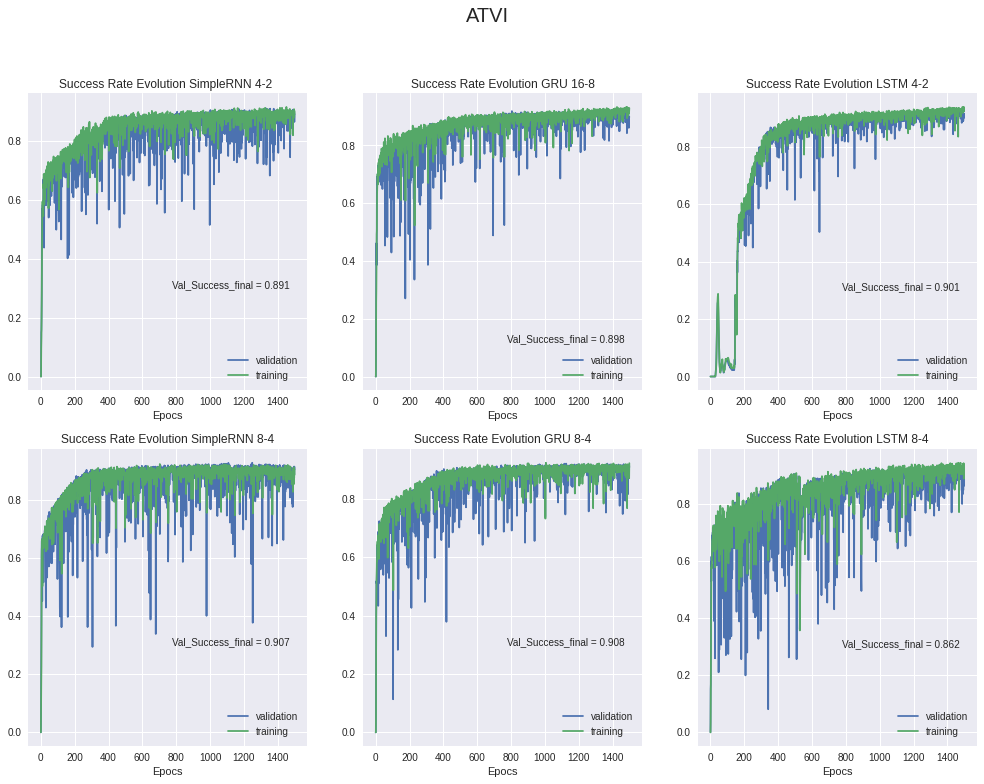

In [32]:
fig, axes = plt.subplots(2, 3,figsize=(17, 12))
fig.suptitle(tickers.Symbol[index],fontsize = 20)

# Plot de la RNN 8-4
axes[0,0].plot(history_RNN84.epoch,history_RNN84.history['val_porcentaje_margen'],label='validation')
axes[0,0].plot(history_RNN84.epoch,history_RNN84.history['porcentaje_margen'],label="training")
axes[0,0].legend()
axes[0,0].set_title('Success Rate Evolution SimpleRNN 4-2 ')
axes[0,0].set_xlabel('Epocs')
axes[0,0].annotate('Val_Success_final = %.3f'% history_RNN84.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)


# Plot de la RNN 816-8
axes[1,0].plot(history_RNN168.epoch,history_RNN168.history['val_porcentaje_margen'],label='validation')
axes[1,0].plot(history_RNN168.epoch,history_RNN168.history['porcentaje_margen'],label="training")
axes[1,0].legend()
axes[1,0].set_title('Success Rate Evolution SimpleRNN 8-4')
axes[1,0].set_xlabel('Epocs')
axes[1,0].annotate('Val_Success_final = %.3f'% history_RNN168.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la GRU 16-8
axes[0,1].plot(history_GRU168.epoch,history_GRU168.history['val_porcentaje_margen'],label='validation')
axes[0,1].plot(history_GRU168.epoch,history_GRU168.history['porcentaje_margen'],label="training")
axes[0,1].legend()
axes[0,1].set_title('Success Rate Evolution GRU 16-8')
axes[0,1].set_xlabel('Epocs')
axes[0,1].annotate('Val_Success_final = %.3f'% history_GRU168.history['val_porcentaje_margen'][-1], (1250, 0.12), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la GRU 16-8-4
axes[1,1].plot(history_GRU1684.epoch,history_GRU1684.history['val_porcentaje_margen'],label='validation')
axes[1,1].plot(history_GRU1684.epoch,history_GRU1684.history['porcentaje_margen'],label="training")
axes[1,1].legend()
axes[1,1].set_title('Success Rate Evolution GRU 8-4')
axes[1,1].set_xlabel('Epocs')
axes[1,1].annotate('Val_Success_final = %.3f'% history_GRU1684.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la LSTM 8-4
axes[0,2].plot(history_LSTM84.epoch,history_LSTM84.history['val_porcentaje_margen'],label='validation')
axes[0,2].plot(history_LSTM84.epoch,history_LSTM84.history['porcentaje_margen'],label="training")
axes[0,2].legend()
axes[0,2].set_title('Success Rate Evolution LSTM 4-2')
axes[0,2].set_xlabel('Epocs')
axes[0,2].annotate('Val_Success_final = %.3f'% history_LSTM84.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

# Plot de la LSTM 16-8
axes[1,2].plot(history_LSTM168.epoch,history_LSTM168.history['val_porcentaje_margen'],label='validation')
axes[1,2].plot(history_LSTM168.epoch,history_LSTM168.history['porcentaje_margen'],label="training")
axes[1,2].legend()
axes[1,2].set_title('Success Rate Evolution LSTM 8-4')
axes[1,2].set_xlabel('Epocs')
axes[1,2].annotate('Val_Success_final = %.3f'% history_LSTM168.history['val_porcentaje_margen'][-1], (1250, 0.3), xytext=(-80, 0), 
            textcoords='offset points',fontsize = 10)

plt.show()

In [18]:
# Calculo la prediccion para mi conjunto test
predictedRNN84 = pd.DataFrame(modelRNN84.predict(Xtt))
predictedRNN168 = pd.DataFrame(modelRNN168.predict(Xtt))
#predictedGRU168 = pd.DataFrame(modelGRU168.predict(Xtt))
predictedGRU1684 = pd.DataFrame(modelGRU1684.predict(Xtt))
#predictedLSTM84 = pd.DataFrame(modelLSTM84.predict(Xtt))
#predictedLSTM168 = pd.DataFrame(modelLSTM168.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
rmseRNN84 = sqrt(mean_squared_error(ytt, predictedRNN84))
rmseRNN168 = sqrt(mean_squared_error(ytt, predictedRNN168))
#rmseGRU168 = sqrt(mean_squared_error(ytt, predictedGRU168))
rmseGRU1684 = sqrt(mean_squared_error(ytt, predictedGRU1684))
#rmseLSTM84 = sqrt(mean_squared_error(ytt, predictedLSTM84))
#rmseLSTM168 = sqrt(mean_squared_error(ytt, predictedLSTM168))


NameError: name 'predictedGRU168' is not defined

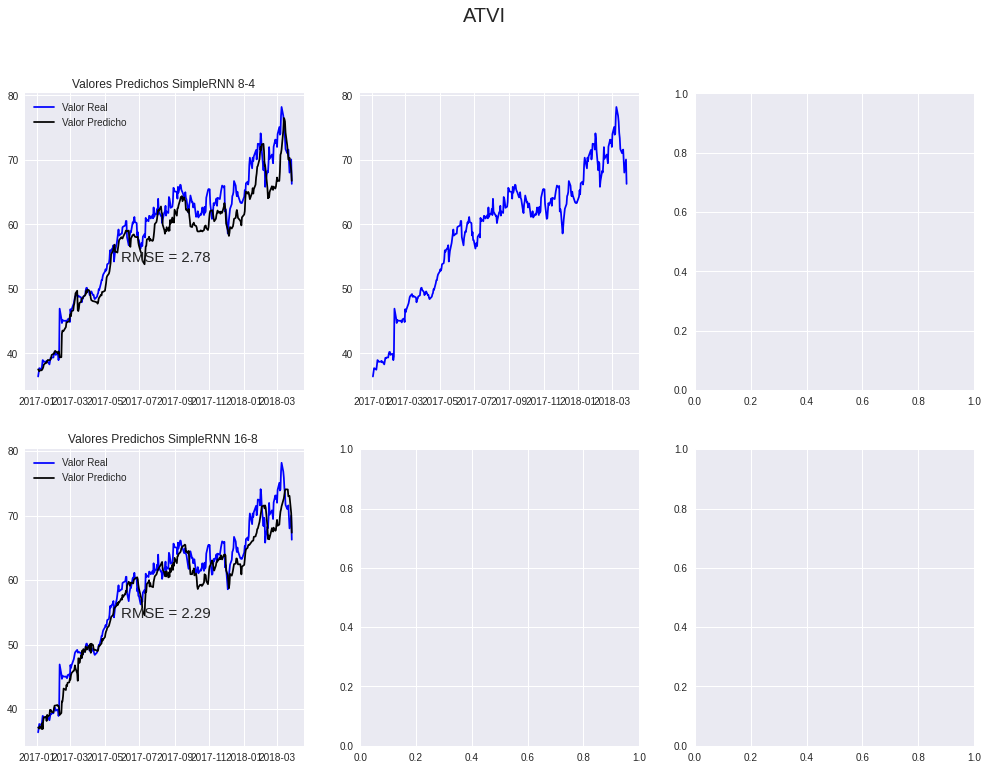

In [19]:
fig, axes = plt.subplots(2, 3,figsize=(17, 12))
fig.suptitle(tickers.Symbol[index],fontsize = 20)


# Plot de la RNN 8-4
axes[0,0].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0,0].plot(index_time_t,predictedRNN84, label="Valor Predicho", color = "black")
axes[0,0].legend()
axes[0,0].set_title('Valores Predichos SimpleRNN 8-4 ')
axes[0,0].annotate('RMSE = %.2f'% rmseRNN84, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)


# Plot de la RNN 16-8
axes[1,0].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1,0].plot(index_time_t,predictedRNN168, label="Valor Predicho", color = "black")
axes[1,0].legend()
axes[1,0].set_title('Valores Predichos SimpleRNN 16-8 ')
axes[1,0].annotate('RMSE = %.2f'% rmseRNN168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la GRU 16-8
axes[0,1].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0,1].plot(index_time_t,predictedGRU168, label="Valor Predicho", color = "black")
axes[0,1].legend()
axes[0,1].set_title('Valores Predichos GRU 16-8 ')
axes[0,1].annotate('RMSE = %.2f'% rmseGRU168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la GRU 16-8-4
axes[1,1].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1,1].plot(index_time_t,predictedGRU1684, label="Valor Predicho", color = "black")
axes[1,1].legend()
axes[1,1].set_title('Valores Predichos GRU 16-8-4')
axes[1,1].annotate('RMSE = %.2f'% rmseGRU1684, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la LSTM 8-4
axes[0,2].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[0,2].plot(index_time_t,predictedLSTM84, label="Valor Predicho", color = "black")
axes[0,2].legend()
axes[0,2].set_title('Valores Predichos LSTM 8-4 ')
axes[0,2].annotate('RMSE = %.2f'% rmseLSTM84, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

# Plot de la LSTM 16-8
axes[1,2].plot(index_time_t,ytt,label="Valor Real",color = "blue")
axes[1,2].plot(index_time_t,predictedLSTM168, label="Valor Predicho", color = "black")
axes[1,2].legend()
axes[1,2].set_title('Valores Predichos LSTM 16-8')
axes[1,2].annotate('RMSE = %.2f'% rmseLSTM168, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

plt.show()

Queremos realizar una inversion de 100000 euros en el activo que hemos estudiado, nos basamos en un margen entre la diferencia de los dos precios adyacentes para saber si comprar, vender o mantener.
Tenemos 3 posibles caminos, comprar solo a la alza, comprar solo a la baja o comprar a la alza y a la baja.
Ciertos actios tienen caidas o subidas muy bruscas imposibles de predecir porque no tienen que ver con los datos historicos si no con la situacion y el contexto que vive la empresa

In [66]:
pd.options.display.max_rows = 10000 # Para poder ver todos los movimientos
predicted_stock_price = predictedGRU1684
# Es un margen movil, segun lo que busquemos
margen = 0.03
diferencias = np.zeros(len(predicted_stock_price)-1)
for i in range(len(diferencias)):
    diferencias[i] = (predicted_stock_price.iloc[i+1,0]-predicted_stock_price.iloc[i,0])/max(predicted_stock_price.iloc[i+1,0],predicted_stock_price.iloc[i,0])
    if diferencias[i] > margen:
        diferencias[i] = 1
    elif diferencias[i] < -margen:
        diferencias[i] = -1
    else:
        diferencias[i] = 0
    
print(Counter(diferencias))

Counter({0.0: 292, 1.0: 9, -1.0: 6})


In [67]:
# Si solo queremos comrpar a la alza
# Estado es lo que hay que hacer ese dia
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_alza = pd.DataFrame(columns = ["presupuesto","acciones","estado","valor","pred","dif"],index = index_time_t)
movimientos_alza.presupuesto[0] = 100000 ; movimientos_alza.acciones[0] = 0 ; movimientos_alza.estado[0] = 0
movimientos_alza.valor[0] = ytt.iloc[0,0] ; movimientos_alza.pred[0] = predicted_stock_price.iloc[0,0]

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_alza.acciones[i-1] == 0:
            movimientos_alza.estado[i] = 1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] % ytt.iloc[i,0]
            movimientos_alza.acciones[i] = movimientos_alza.presupuesto[i-1] // ytt.iloc[i,0]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_alza.acciones[i-1] > 0:
            movimientos_alza.estado[i] = -1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] + movimientos_alza.acciones[i-1] * ytt.iloc[i,0]
            movimientos_alza.acciones[i] = 0
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]

            
movimientos_alza = movimientos_alza.drop(movimientos_alza.tail(1).index)
print(movimientos_alza.tail(1))
valor_f_alza = movimientos_alza.presupuesto[len(movimientos_alza)-1] + movimientos_alza.valor[len(movimientos_alza)-1] * movimientos_alza.acciones[len(movimientos_alza)-1]
ganancia_alza = valor_f_alza - 100000
print('Valor Final = %.2f' % valor_f_alza)
print('Ganancia con margen = %.2f' % ganancia_alza)

           presupuesto acciones estado  valor     pred dif
2018-03-26      117937        0      0  70.08  66.2802   0
Valor Final = 117936.89
Ganancia con margen = 17936.89


In [68]:
print(movimientos_alza)

           presupuesto acciones estado    valor     pred  dif
2017-01-03      100000        0      0  36.4204  36.5909  NaN
2017-01-04      100000        0      0  37.1361  36.0804    0
2017-01-05      100000        0      0  37.7126  36.1212    0
2017-01-06      100000        0      0  37.6828  36.5198    0
2017-01-09      100000        0      0  37.4741  36.4755    0
2017-01-10      100000        0      0    38.15  36.7172    0
2017-01-11      100000        0      0  38.9651  37.1265    0
2017-01-12      100000        0      0  38.8955  37.1628    0
2017-01-13      100000        0      0  38.7166  37.9127    0
2017-01-17      100000        0      0  38.7166  38.2267    0
2017-01-18      100000        0      0  38.8458  37.9685    0
2017-01-19      100000        0      0  38.6271  38.2227    0
2017-01-20      100000        0      0  38.7365  38.4512    0
2017-01-23      100000        0      0  38.2991  38.3181    0
2017-01-24      100000        0      0  38.8657  38.5827    0
2017-01-

In [69]:
movimientos_alza.to_csv("/home/cesar/Documentos/Git/TFG_Informatica/TFG/Decisiones/ATVI/Alza3GRU-1684.csv")

In [70]:
# Compro a la alza y a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_ab= pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_ab.presupuesto[0] = 100000 % ytt.iloc[0,0] ; movimientos_ab.acciones[0] = 100000 // ytt.iloc[0,0] ; movimientos_ab.acciones_debo[0] = 0 ;
movimientos_ab.estado[0] = 0 ; movimientos_ab.valor[0] = ytt.iloc[0,0] ;
movimientos_ab.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_ab.acciones[i-1] == 0:
            movimientos_ab.estado[i] = 1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         % ytt.iloc[i,0])
            movimientos_ab.acciones[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         // ytt.iloc[i,0])
            movimientos_ab.acciones_debo[i] = 0
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_ab.acciones_debo[i-1] == 0:
            movimientos_ab.estado[i] = -1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) +
                                          ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_ab.acciones[i] = 0
            movimientos_ab.acciones_debo[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) # Las pido prestadas
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
            
movimientos_ab = movimientos_ab.drop(movimientos_ab.tail(1).index)
print(movimientos_ab.tail(1))
if movimientos_ab.acciones_debo[len(movimientos_ab)-1] == 0 :
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] + movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones[len(movimientos_ab)-1]
else:
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] - movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones_debo[len(movimientos_ab)-1]
ganancia_ab = valor_f_ab - 100000
print('Valor Final = %.2f' % valor_f_ab)
print('Ganancia con margen = %.2f' % ganancia_ab)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      225933        0          1660      0  70.08  66.2802   0
Valor Final = 109600.65
Ganancia con margen = 9600.65


In [71]:
print(movimientos_ab)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2017-01-03     25.9375     2745             0      0  36.4204  36.5909  NaN
2017-01-04     25.9375     2745             0      0  37.1361  36.0804    0
2017-01-05     25.9375     2745             0      0  37.7126  36.1212    0
2017-01-06     25.9375     2745             0      0  37.6828  36.5198    0
2017-01-09     25.9375     2745             0      0  37.4741  36.4755    0
2017-01-10     25.9375     2745             0      0    38.15  36.7172    0
2017-01-11     25.9375     2745             0      0  38.9651  37.1265    0
2017-01-12     25.9375     2745             0      0  38.8955  37.1628    0
2017-01-13     25.9375     2745             0      0  38.7166  37.9127    0
2017-01-17     25.9375     2745             0      0  38.7166  38.2267    0
2017-01-18     25.9375     2745             0      0  38.8458  37.9685    0
2017-01-19     25.9375     2745             0      0  38.6271  38.2227    0
2017-01-20  

In [72]:
movimientos_ab.to_csv("/home/cesar/Documentos/Git/TFG_Informatica/TFG/Decisiones/ATVI/AlzaBaja3GRU-1684.csv")

In [73]:
# Compro a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_baja = pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_baja.presupuesto[0] = 100000  ; movimientos_baja.acciones[0] = 0 ; movimientos_baja.acciones_debo[0] = 0 ;
movimientos_baja.estado[0] = 0 ; movimientos_baja.valor[0] = ytt.iloc[0,0] ;
movimientos_baja.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_baja.acciones[i-1] == 0:
            movimientos_baja.estado[i] = 1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1] - (movimientos_baja.acciones_debo[i-1] * ytt.iloc[i,0])))
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = 0
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_baja.acciones_debo[i-1] == 0:
            movimientos_baja.estado[i] = -1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1]) + (movimientos_baja.presupuesto[i-1] //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = (movimientos_baja.presupuesto[i-1] // ytt.iloc[i,0]) # Las pido prestadas
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
            
movimientos_baja = movimientos_baja.drop(movimientos_baja.tail(1).index)
print(movimientos_baja.tail(1))
if movimientos_baja.acciones_debo[len(movimientos_baja)-1] == 0 :
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] + movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
else:
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] - movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
ganancia_baja = valor_f_baja - 100000
print('Valor Final = %.2f' % valor_f_baja)
print('Ganancia con margen = %.2f' % ganancia_baja)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      153566        0          1128      0  70.08  66.2802   0
Valor Final = 74515.38
Ganancia con margen = -25484.62


In [74]:
print(movimientos_baja)

           presupuesto acciones acciones_debo estado    valor     pred  dif
2017-01-03      100000        0             0      0  36.4204  36.5909  NaN
2017-01-04      100000        0             0      0  37.1361  36.0804    0
2017-01-05      100000        0             0      0  37.7126  36.1212    0
2017-01-06      100000        0             0      0  37.6828  36.5198    0
2017-01-09      100000        0             0      0  37.4741  36.4755    0
2017-01-10      100000        0             0      0    38.15  36.7172    0
2017-01-11      100000        0             0      0  38.9651  37.1265    0
2017-01-12      100000        0             0      0  38.8955  37.1628    0
2017-01-13      100000        0             0      0  38.7166  37.9127    0
2017-01-17      100000        0             0      0  38.7166  38.2267    0
2017-01-18      100000        0             0      0  38.8458  37.9685    0
2017-01-19      100000        0             0      0  38.6271  38.2227    0
2017-01-20  

In [75]:
movimientos_baja.to_csv("/home/cesar/Documentos/Git/TFG_Informatica/TFG/Decisiones/ATVI/Baja3GRU-1684.csv")